In [22]:
!pip install tensorflow-addons

## import libraries

In [23]:
from os import listdir
import numpy as np
from numpy import savez_compressed
import os
from os import listdir
import cv2
from numpy import asarray, vstack, savez_compressed
from numpy.random import randint
from glob import glob
from random import random
from tqdm import tqdm
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.layers import ReLU, Input,Conv2D,Dropout,LeakyReLU, Activation, Concatenate, Conv2DTranspose
from keras.models import load_model,Model ,Sequential
from tensorflow_addons.layers import InstanceNormalization
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

## Load images

In [24]:
#Resizing all the images to 64*64 pixels and storing in compressed Numpy array.
def load_images(path, size=(64, 64), max_images=None):
    data_list = []
    for filename in listdir(path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter for specific image file extensions
            pixels = load_img(path + filename, target_size=size)
            pixels = img_to_array(pixels)
            data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)

celeb_path = '../input/celeba-dataset/img_align_celeba/img_align_celeba/'
cartoon_path = '../input/cartoonset10k/cartoonset10k/'

dataA = load_images(celeb_path, max_images=1000)
print('loaded dataA', dataA.shape)

dataB = load_images(cartoon_path, max_images=1000)
print('loaded dataB', dataB.shape)
filename = 'celebrity2cartoon.npz'
np.savez_compressed(filename, dataA=dataA, dataB=dataB)

print('Saved dataset:', filename)


loaded dataA (1000, 64, 64, 3)
loaded dataB (1000, 64, 64, 3)
Saved dataset: celebrity2cartoon.npz


## Plotting images of Celebrity and Cartoon

Loaded data: (1000, 64, 64, 3) (1000, 64, 64, 3)


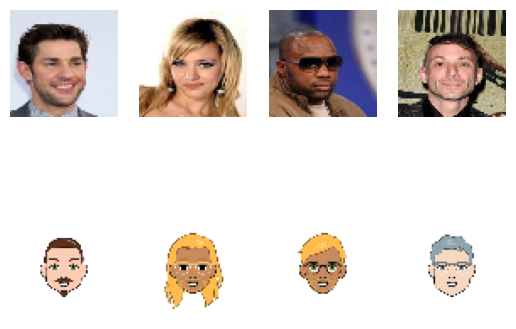

In [25]:
from numpy import load
data = load('celebrity2cartoon.npz')
daraA, dataB = data['dataA'], data['dataB']
print('Loaded data:', dataA.shape, dataB.shape)
n_samples = 4
# plot original image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+i )
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+n_samples+i )
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()


In [26]:
#define the discriminator model
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(input_image)
    x = LeakyReLU(alpha = 0.2)(x)
    #c128 
    x = Conv2D(128,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c256
    x = Conv2D(256,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c512
    x = Conv2D(512,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2D(512,(4,4) , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    out_put = Conv2D(1, (4, 4), padding='same', kernel_initializer=init, use_bias=False)(x)

    model = Model(input_image, out_put)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])

    return model
    
image_shape = (64, 64, 3)
discriminator = define_discriminator(image_shape)
discriminator.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_219 (Conv2D)         (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_220 (Conv2D)         (None, 16, 16, 128)       131200    
                                                                 
 instance_normalization_220   (None, 16, 16, 128)      256       
 (InstanceNormalization)                                         
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                          

In [27]:
def resnet_block(filters, layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    #print(layer.shape)  # print the shape of the previous layer
    
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    
    # skip connection
    x = Concatenate()([x, layer])
    return x
    

In [28]:
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding ='same', kernel_initializer='he_normal', use_bias=False)(layer)
    x = InstanceNormalization(axis=-1)(x)    
    x = LeakyReLU()(x)
    return x

In [29]:
# define the generator model
def define_generator(image_shape, n_resnet=9):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(7,7) , padding = 'same', kernel_initializer = init)(input_image)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c128 
    x = Conv2D(128,(3,3), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c256
    x = Conv2D(256,(3,3), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    
    for i in range(n_resnet):
        x = resnet_block(256 , x)
        
    # Add Conv2DTranspose layers to upscale the image to the desired shape
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    out_image = Activation('tanh')(x)

    model = Model(input_image, out_image)
    return model
image_shape = (64, 64, 3)
generator = define_generator(image_shape)
generator.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_225 (Conv2D)            (None, 64, 64, 64)   9472        ['input_30[0][0]']               
                                                                                                  
 instance_normalization_224 (In  (None, 64, 64, 64)  128         ['conv2d_225[0][0]']             
 stanceNormalization)                                                                             
                                                                                                  
 activation_120 (Activation)    (None, 64, 64, 64)   0           ['instance_normalization_2

## Defining Composite model

In [30]:
from keras.layers import Lambda, Reshape

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # Input for generated images
    input_gen = Input(shape=image_shape)
    
    # Resize generated images to the shape expected by the discriminator
    resized_gen = Lambda(lambda x: tf.image.resize(x, (64, 64), method=tf.image.ResizeMethod.BILINEAR))(input_gen)
    
    # Forward pass through the generator and discriminator
    gen_1_out = g_model_1(resized_gen)
    output_d = d_model(gen_1_out)
    
    # Input for identity mapping
    input_id = Input(shape=image_shape)
    
    # Forward pass for identity mapping
    output_id = g_model_1(input_id)
    
    # Forward and backward cycle loss
    output_f = g_model_2(gen_1_out)
    gen_2_out = g_model_2(input_id)
    output_b = g_model_1(gen_2_out)
    
    # Define the composite model
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    
    return model

## Load real samples

In [31]:
def load_real_samples(filename):
    data = load(filename)
    X1,X2 = data['dataA'],data['dataB']
    X1 = (X1-127.5)/127.5 #for source image
    X2 = (X2-127.5)/127.5 # for corresponding target images
    return [X1,X2]

In [32]:
import random

def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


In [33]:
##select a batch of random samples,return images and target
def generate_fake_samples(g_model, dataset, patch_shape):
    # Generate a batch of random noise as input for the generator
    X = g_model.predict(dataset)
    
    # Create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape,patch_shape, 1))
    
    return X, y


In [34]:
#save the generator model to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' %(step +1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' %(step +1)
    g_model_BtoA.save(filename2)
    print('>saved:%s and %s' %(filename1,filename2))
    

In [35]:
#update image pool for fake image
import random  # Import the random module

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # Stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # Use random.random() instead of random() here
            # Use image, but don't add it to the pool
            selected.append(image)
        else:
            # Replace an existing image and use the replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)  # This line should be outside the for loop
 


In [36]:
def show_image(image , title = None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [37]:
def show_preds(g_AB, g_BA, n_images=1):
    for i in range(n_images):
        id = np.random.randint(len(dataA))
        data = load('celebrity2cartoon.npz')
        celeb, cartoon = dataA[id], dataB[id]
        celeb_pred, cartoon_pred = g_BA.predict(tf.expand_dims(cartoon, axis=0))[0], g_AB.predict(tf.expand_dims(celeb, axis=0))[0]
        
        plt.figure(figsize=(10, 8))
        
        plt.subplot(1, 4, 1)
        show_image(celeb.astype('uint8'), title='Original celeb')
        
        plt.subplot(1, 4, 2)
        show_image(cartoon_pred, title='Generated celeb')
        
        plt.subplot(1, 4, 3)
        show_image(cartoon.astype('uint8'), title='Original cartoon')
        
        plt.subplot(1, 4, 4)
        show_image(celeb_pred, title='Generated cartoon')
        
        
        plt.show()

## Train cyclegan model

In [38]:
# train cyclegan model
def train(dataset,d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,epochs=30, chunk=5):
    #define peroperties of the training run
    n_epochs, n_batch = epochs, 1
    #determine the output square shape of discriminator
    n_patch = d_model_A.output_shape[1]
    #unpack dataset
    trainA, trainB = dataset[0], dataset[1]
    #prepare image pool for fakes
    poolA, poolB = list(), list()
    #calcute the number of batches per training epoch
    batch_per_epoch = int(len(trainA)/n_batch)
    #calcute the number of training iteration
    n_steps = batch_per_epoch 
    #manually enumerate epochs
    for j in tqdm(range(epochs), desc='Epochs'):
        for i in tqdm(range(n_steps), desc='Batchs'):
            #select a batch of real sample
            X_realA, y_realA = generate_real_samples(trainA,n_batch, n_patch)
            X_realB, y_realB = generate_real_samples(trainB,n_batch, n_patch)
            
            #genarate a batch of fake sample
            X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)




            
            #update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)
            
            #update generator B->A via adversarial and cycle loss
            gen_loss2, _, _, _,_ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])


            # update discriminator for A->[real/fake]
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            #update generator A->B via adversarial and cycle loss
            gen_loss1, _, _, _,_ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
            
            # update discriminator for B->[real/fake]
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
            
            #summerize performance
            print('>%d, dA[%.3f ,%.3f ] dB[%.3f ,%.3f] g[%.3f ,%.3f]' %(i+1,dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2))

        if(j%chunk)==0:
            show_preds(g_model_AtoB,g_model_BtoA, n_images=1)
                #save the models
            g_model_AtoB.save('Generator_Celebrity_to_Cartoon.h5')
            g_model_BtoA.save('Generator_Cartoon_to_Celebrity.h5')
                


Loaded (1000, 64, 64, 3) (1000, 64, 64, 3)


Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 968ms/step



Batchs:   0%|          | 1/1000 [01:11<19:51:16, 71.55s/it]

>1, dA[0.936 ,0.999 ] dB[0.720 ,0.753] g[22.853 ,21.864]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/1000 [01:12<8:16:06, 29.83s/it] 

>2, dA[0.550 ,0.854 ] dB[3.740 ,0.598] g[20.514 ,18.964]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 3/1000 [01:12<4:33:25, 16.46s/it]

>3, dA[0.710 ,0.957 ] dB[3.894 ,0.721] g[23.642 ,24.202]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 4/1000 [01:13<2:48:54, 10.17s/it]

>4, dA[1.935 ,2.427 ] dB[1.474 ,0.406] g[20.363 ,22.250]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [01:13<1:51:12,  6.71s/it]

>5, dA[1.737 ,2.688 ] dB[1.132 ,0.766] g[21.496 ,24.701]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 6/1000 [01:14<1:16:22,  4.61s/it]

>6, dA[1.150 ,10.137 ] dB[1.901 ,1.385] g[24.122 ,27.840]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 7/1000 [01:14<54:20,  3.28s/it]  

>7, dA[2.672 ,4.728 ] dB[1.425 ,1.195] g[21.264 ,23.373]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 8/1000 [01:15<39:56,  2.42s/it]

>8, dA[0.813 ,1.958 ] dB[2.090 ,0.557] g[20.488 ,19.890]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|          | 9/1000 [01:16<30:19,  1.84s/it]

>9, dA[0.956 ,6.467 ] dB[6.537 ,0.453] g[21.314 ,27.403]
1/1 [==============================] - 0s 26ms/step



Batchs:   1%|          | 10/1000 [01:16<23:46,  1.44s/it]

>10, dA[2.065 ,7.442 ] dB[1.460 ,1.255] g[21.568 ,29.383]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 11/1000 [01:17<19:12,  1.17s/it]

>11, dA[1.411 ,0.531 ] dB[0.904 ,0.724] g[20.318 ,19.781]
1/1 [==============================] - 0s 28ms/step



Batchs:   1%|          | 12/1000 [01:17<16:09,  1.02it/s]

>12, dA[2.401 ,1.893 ] dB[0.122 ,0.781] g[19.540 ,23.579]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 13/1000 [01:18<13:56,  1.18it/s]

>13, dA[1.697 ,4.323 ] dB[1.934 ,1.024] g[17.861 ,22.511]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|▏         | 14/1000 [01:18<12:22,  1.33it/s]

>14, dA[0.831 ,1.605 ] dB[0.415 ,0.512] g[18.691 ,19.916]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 15/1000 [01:19<11:19,  1.45it/s]

>15, dA[1.411 ,0.788 ] dB[1.423 ,0.716] g[20.312 ,19.472]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 16/1000 [01:19<10:35,  1.55it/s]

>16, dA[1.402 ,1.600 ] dB[3.246 ,1.808] g[17.046 ,16.770]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 17/1000 [01:20<10:04,  1.63it/s]

>17, dA[0.666 ,0.250 ] dB[0.443 ,0.886] g[17.530 ,15.950]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 18/1000 [01:20<09:42,  1.69it/s]

>18, dA[0.942 ,0.926 ] dB[0.546 ,0.741] g[20.391 ,18.535]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 19/1000 [01:21<09:26,  1.73it/s]

>19, dA[0.799 ,0.668 ] dB[1.456 ,1.122] g[20.280 ,19.121]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 20/1000 [01:22<09:16,  1.76it/s]

>20, dA[0.653 ,0.456 ] dB[1.206 ,0.547] g[18.388 ,16.965]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 21/1000 [01:22<09:05,  1.79it/s]

>21, dA[0.660 ,0.289 ] dB[1.494 ,0.890] g[18.105 ,15.978]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [01:23<09:00,  1.81it/s]

>22, dA[0.844 ,0.369 ] dB[0.385 ,1.107] g[16.598 ,16.041]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 23/1000 [01:23<08:54,  1.83it/s]

>23, dA[0.466 ,0.429 ] dB[0.806 ,0.671] g[18.330 ,17.971]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 24/1000 [01:24<08:55,  1.82it/s]

>24, dA[0.365 ,0.580 ] dB[0.402 ,3.486] g[24.488 ,18.167]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 25/1000 [01:24<08:52,  1.83it/s]

>25, dA[0.956 ,0.662 ] dB[0.347 ,3.002] g[19.018 ,16.696]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 26/1000 [01:25<08:49,  1.84it/s]

>26, dA[1.139 ,0.521 ] dB[0.472 ,0.829] g[19.005 ,17.832]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 27/1000 [01:25<08:49,  1.84it/s]

>27, dA[1.187 ,0.251 ] dB[1.234 ,0.680] g[16.220 ,14.678]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 28/1000 [01:26<08:49,  1.84it/s]

>28, dA[0.473 ,0.667 ] dB[0.289 ,1.450] g[21.079 ,17.645]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 29/1000 [01:26<08:49,  1.83it/s]

>29, dA[1.070 ,0.577 ] dB[0.378 ,0.291] g[18.270 ,17.862]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 30/1000 [01:27<08:47,  1.84it/s]

>30, dA[0.748 ,2.466 ] dB[0.967 ,0.789] g[17.803 ,20.104]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [01:27<08:45,  1.84it/s]

>31, dA[0.885 ,1.170 ] dB[1.032 ,0.985] g[18.044 ,17.061]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 32/1000 [01:28<08:47,  1.84it/s]

>32, dA[1.241 ,1.550 ] dB[0.559 ,0.725] g[19.222 ,19.043]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 33/1000 [01:29<08:46,  1.84it/s]

>33, dA[0.754 ,0.693 ] dB[0.423 ,0.241] g[17.190 ,17.504]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 34/1000 [01:29<08:45,  1.84it/s]

>34, dA[2.335 ,0.368 ] dB[1.024 ,0.693] g[17.363 ,15.841]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 35/1000 [01:30<08:43,  1.84it/s]

>35, dA[1.253 ,0.548 ] dB[0.098 ,0.369] g[17.142 ,17.094]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 36/1000 [01:30<08:45,  1.84it/s]

>36, dA[5.387 ,0.264 ] dB[0.077 ,0.298] g[17.832 ,17.440]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 37/1000 [01:31<08:44,  1.84it/s]

>37, dA[0.906 ,0.213 ] dB[0.275 ,0.294] g[17.473 ,17.198]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 38/1000 [01:31<08:44,  1.83it/s]

>38, dA[0.934 ,0.141 ] dB[0.226 ,0.382] g[17.384 ,16.469]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 39/1000 [01:32<08:42,  1.84it/s]

>39, dA[0.639 ,0.341 ] dB[0.251 ,0.431] g[15.822 ,15.853]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 40/1000 [01:32<08:41,  1.84it/s]

>40, dA[0.171 ,0.109 ] dB[0.062 ,0.205] g[17.430 ,18.068]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 41/1000 [01:33<08:41,  1.84it/s]

>41, dA[0.675 ,0.411 ] dB[0.126 ,0.162] g[16.588 ,16.159]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 42/1000 [01:33<08:40,  1.84it/s]

>42, dA[1.308 ,0.234 ] dB[0.152 ,0.558] g[17.681 ,18.017]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 43/1000 [01:34<08:38,  1.85it/s]

>43, dA[1.437 ,0.177 ] dB[0.171 ,0.367] g[15.949 ,14.120]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 44/1000 [01:35<08:41,  1.83it/s]

>44, dA[1.421 ,0.134 ] dB[0.147 ,0.137] g[17.517 ,18.007]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 45/1000 [01:35<08:36,  1.85it/s]

>45, dA[0.495 ,0.186 ] dB[0.241 ,0.525] g[17.361 ,18.519]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 46/1000 [01:36<08:37,  1.84it/s]

>46, dA[0.580 ,0.885 ] dB[0.169 ,0.228] g[16.176 ,15.628]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 47/1000 [01:36<08:38,  1.84it/s]

>47, dA[0.857 ,0.215 ] dB[0.084 ,0.249] g[14.571 ,14.255]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 48/1000 [01:37<08:38,  1.84it/s]

>48, dA[0.512 ,1.668 ] dB[0.145 ,0.162] g[15.081 ,16.185]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 49/1000 [01:37<08:36,  1.84it/s]

>49, dA[0.554 ,2.026 ] dB[0.064 ,0.141] g[14.963 ,16.010]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 50/1000 [01:38<08:36,  1.84it/s]

>50, dA[0.418 ,0.588 ] dB[0.092 ,0.079] g[15.387 ,15.454]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 51/1000 [01:38<08:35,  1.84it/s]

>51, dA[0.699 ,0.163 ] dB[0.062 ,2.031] g[17.398 ,18.660]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 52/1000 [01:39<08:38,  1.83it/s]

>52, dA[1.551 ,0.222 ] dB[0.499 ,0.852] g[17.226 ,15.696]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 53/1000 [01:39<08:36,  1.83it/s]

>53, dA[0.708 ,0.321 ] dB[0.154 ,1.085] g[17.413 ,17.057]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 54/1000 [01:40<08:35,  1.84it/s]

>54, dA[0.448 ,0.050 ] dB[1.081 ,0.743] g[17.854 ,14.981]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 55/1000 [01:41<08:35,  1.83it/s]

>55, dA[0.624 ,0.766 ] dB[0.149 ,0.700] g[15.270 ,13.449]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 56/1000 [01:41<08:35,  1.83it/s]

>56, dA[0.371 ,0.342 ] dB[0.409 ,0.161] g[18.329 ,16.155]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 57/1000 [01:42<08:34,  1.83it/s]

>57, dA[0.363 ,0.227 ] dB[0.066 ,0.357] g[16.836 ,14.373]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 58/1000 [01:42<08:33,  1.83it/s]

>58, dA[0.312 ,0.304 ] dB[0.122 ,0.310] g[15.227 ,14.122]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 59/1000 [01:43<08:33,  1.83it/s]

>59, dA[0.264 ,0.290 ] dB[0.209 ,0.582] g[16.126 ,15.602]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 60/1000 [01:43<08:40,  1.81it/s]

>60, dA[0.783 ,0.451 ] dB[0.222 ,1.698] g[15.068 ,14.726]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 61/1000 [01:44<08:38,  1.81it/s]

>61, dA[0.308 ,0.239 ] dB[0.318 ,3.210] g[15.631 ,14.307]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 62/1000 [01:44<08:35,  1.82it/s]

>62, dA[0.563 ,0.718 ] dB[0.126 ,0.289] g[16.167 ,15.806]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [01:45<08:33,  1.82it/s]

>63, dA[0.330 ,0.128 ] dB[0.129 ,0.371] g[14.617 ,13.588]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 64/1000 [01:45<08:35,  1.82it/s]

>64, dA[0.231 ,0.237 ] dB[0.151 ,0.148] g[13.663 ,12.752]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 65/1000 [01:46<08:35,  1.81it/s]

>65, dA[0.931 ,0.238 ] dB[0.099 ,0.062] g[16.597 ,17.130]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 66/1000 [01:47<08:33,  1.82it/s]

>66, dA[0.902 ,0.605 ] dB[0.077 ,0.312] g[15.720 ,16.181]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [01:47<08:34,  1.81it/s]

>67, dA[0.261 ,0.282 ] dB[0.118 ,0.265] g[13.191 ,13.689]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 68/1000 [01:48<08:36,  1.80it/s]

>68, dA[0.437 ,0.209 ] dB[0.105 ,1.050] g[13.427 ,13.558]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 69/1000 [01:48<08:38,  1.80it/s]

>69, dA[0.936 ,0.132 ] dB[0.438 ,0.615] g[16.168 ,15.615]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 70/1000 [01:49<08:34,  1.81it/s]

>70, dA[0.930 ,0.315 ] dB[0.126 ,0.357] g[12.092 ,11.211]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [01:49<08:32,  1.81it/s]

>71, dA[1.541 ,0.178 ] dB[0.045 ,0.220] g[13.782 ,13.625]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 72/1000 [01:50<08:35,  1.80it/s]

>72, dA[0.557 ,0.193 ] dB[0.079 ,0.106] g[14.254 ,14.074]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 73/1000 [01:50<08:32,  1.81it/s]

>73, dA[1.801 ,0.158 ] dB[0.024 ,0.218] g[16.260 ,15.084]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 74/1000 [01:51<08:33,  1.80it/s]

>74, dA[0.896 ,0.051 ] dB[0.102 ,1.150] g[14.992 ,13.508]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 75/1000 [01:52<08:30,  1.81it/s]

>75, dA[0.476 ,0.076 ] dB[0.266 ,0.448] g[12.791 ,12.130]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 76/1000 [01:52<08:30,  1.81it/s]

>76, dA[0.993 ,0.114 ] dB[0.073 ,0.259] g[15.957 ,13.578]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [01:53<08:28,  1.81it/s]

>77, dA[0.181 ,0.577 ] dB[0.084 ,1.295] g[15.442 ,13.487]
1/1 [==============================] - 0s 27ms/step



Batchs:   8%|▊         | 78/1000 [01:53<08:35,  1.79it/s]

>78, dA[0.293 ,0.501 ] dB[0.213 ,0.364] g[16.320 ,15.958]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 79/1000 [01:54<08:31,  1.80it/s]

>79, dA[0.456 ,0.220 ] dB[0.171 ,0.042] g[13.462 ,13.450]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 80/1000 [01:54<08:30,  1.80it/s]

>80, dA[0.304 ,0.373 ] dB[0.018 ,0.223] g[16.344 ,16.864]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 81/1000 [01:55<08:27,  1.81it/s]

>81, dA[1.859 ,0.222 ] dB[0.043 ,0.080] g[14.477 ,13.991]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [01:55<08:25,  1.82it/s]

>82, dA[0.713 ,0.233 ] dB[0.028 ,0.106] g[14.990 ,13.536]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [01:56<08:25,  1.82it/s]

>83, dA[0.313 ,0.427 ] dB[0.065 ,0.115] g[15.804 ,16.110]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 84/1000 [01:57<08:26,  1.81it/s]

>84, dA[0.448 ,0.276 ] dB[0.096 ,0.102] g[12.439 ,11.927]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 85/1000 [01:57<08:24,  1.81it/s]

>85, dA[0.457 ,0.095 ] dB[0.057 ,0.035] g[14.574 ,13.054]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▊         | 86/1000 [01:58<08:24,  1.81it/s]

>86, dA[0.170 ,0.095 ] dB[0.052 ,0.148] g[15.782 ,14.313]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▊         | 87/1000 [01:58<08:24,  1.81it/s]

>87, dA[0.492 ,0.156 ] dB[0.055 ,0.077] g[15.435 ,13.213]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 88/1000 [01:59<08:26,  1.80it/s]

>88, dA[0.159 ,0.088 ] dB[0.038 ,0.827] g[15.327 ,14.734]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [01:59<08:24,  1.81it/s]

>89, dA[0.107 ,0.054 ] dB[0.035 ,0.453] g[14.917 ,13.829]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [02:00<08:22,  1.81it/s]

>90, dA[0.186 ,0.272 ] dB[0.172 ,0.100] g[15.154 ,14.370]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 91/1000 [02:00<08:23,  1.80it/s]

>91, dA[0.520 ,0.279 ] dB[0.034 ,0.169] g[14.846 ,12.905]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 92/1000 [02:01<08:22,  1.81it/s]

>92, dA[0.174 ,0.244 ] dB[0.060 ,0.126] g[15.855 ,14.174]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 93/1000 [02:02<08:20,  1.81it/s]

>93, dA[0.104 ,0.252 ] dB[0.077 ,0.068] g[14.661 ,13.616]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 94/1000 [02:02<08:19,  1.81it/s]

>94, dA[0.183 ,0.386 ] dB[0.104 ,0.122] g[13.233 ,12.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [02:03<08:18,  1.82it/s]

>95, dA[0.158 ,0.134 ] dB[0.092 ,0.115] g[14.158 ,13.146]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 96/1000 [02:03<08:20,  1.81it/s]

>96, dA[0.312 ,0.047 ] dB[0.028 ,0.165] g[14.151 ,13.915]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 97/1000 [02:04<08:18,  1.81it/s]

>97, dA[0.550 ,0.628 ] dB[0.044 ,0.048] g[16.382 ,15.709]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 98/1000 [02:04<08:16,  1.82it/s]

>98, dA[0.352 ,0.126 ] dB[0.065 ,0.101] g[15.354 ,13.978]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 99/1000 [02:05<08:14,  1.82it/s]

>99, dA[0.249 ,0.119 ] dB[0.053 ,0.138] g[14.843 ,13.564]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 100/1000 [02:05<08:15,  1.82it/s]

>100, dA[0.691 ,0.151 ] dB[0.073 ,0.103] g[13.454 ,13.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 101/1000 [02:06<08:15,  1.82it/s]

>101, dA[0.134 ,0.833 ] dB[0.037 ,0.177] g[14.948 ,15.312]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 102/1000 [02:06<08:15,  1.81it/s]

>102, dA[0.408 ,0.417 ] dB[0.016 ,0.096] g[13.927 ,14.201]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 103/1000 [02:07<08:13,  1.82it/s]

>103, dA[0.197 ,0.089 ] dB[0.043 ,0.033] g[13.921 ,12.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [02:08<08:13,  1.81it/s]

>104, dA[0.206 ,0.133 ] dB[0.121 ,0.034] g[14.715 ,14.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [02:08<08:11,  1.82it/s]

>105, dA[0.240 ,0.051 ] dB[0.087 ,0.109] g[12.446 ,11.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [02:09<08:09,  1.83it/s]

>106, dA[0.190 ,0.228 ] dB[0.042 ,0.102] g[12.706 ,12.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [02:09<08:08,  1.83it/s]

>107, dA[0.606 ,0.175 ] dB[0.062 ,0.024] g[13.798 ,12.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [02:10<08:07,  1.83it/s]

>108, dA[0.243 ,0.166 ] dB[0.024 ,0.134] g[14.833 ,13.697]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 109/1000 [02:10<08:08,  1.82it/s]

>109, dA[0.212 ,0.398 ] dB[0.071 ,0.052] g[14.015 ,13.074]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 110/1000 [02:11<08:07,  1.82it/s]

>110, dA[0.284 ,0.451 ] dB[0.052 ,0.055] g[14.995 ,13.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [02:11<08:06,  1.83it/s]

>111, dA[0.386 ,0.075 ] dB[0.034 ,0.980] g[12.148 ,13.209]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 112/1000 [02:12<08:07,  1.82it/s]

>112, dA[0.094 ,0.095 ] dB[0.116 ,0.380] g[12.715 ,12.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 113/1000 [02:13<08:05,  1.83it/s]

>113, dA[0.275 ,0.181 ] dB[0.104 ,0.043] g[13.629 ,12.224]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 114/1000 [02:13<08:05,  1.83it/s]

>114, dA[0.279 ,0.099 ] dB[0.030 ,0.077] g[14.197 ,12.737]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 115/1000 [02:14<08:04,  1.83it/s]

>115, dA[0.187 ,0.064 ] dB[0.076 ,0.102] g[13.542 ,11.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 116/1000 [02:14<08:04,  1.83it/s]

>116, dA[0.144 ,0.373 ] dB[0.032 ,0.092] g[12.795 ,11.898]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 117/1000 [02:15<08:04,  1.82it/s]

>117, dA[0.381 ,0.285 ] dB[0.036 ,0.053] g[13.250 ,13.372]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 118/1000 [02:15<08:03,  1.82it/s]

>118, dA[0.089 ,0.185 ] dB[0.034 ,2.321] g[12.325 ,11.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [02:16<08:01,  1.83it/s]

>119, dA[0.227 ,0.163 ] dB[0.409 ,0.441] g[13.565 ,11.906]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 120/1000 [02:16<08:02,  1.82it/s]

>120, dA[0.174 ,0.197 ] dB[0.112 ,0.087] g[13.880 ,12.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [02:17<08:01,  1.83it/s]

>121, dA[0.255 ,0.092 ] dB[0.125 ,0.075] g[14.432 ,13.084]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 122/1000 [02:17<08:01,  1.83it/s]

>122, dA[0.237 ,0.121 ] dB[0.021 ,0.078] g[12.588 ,10.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [02:18<07:59,  1.83it/s]

>123, dA[0.214 ,0.135 ] dB[0.043 ,0.088] g[17.344 ,16.710]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 124/1000 [02:19<08:05,  1.80it/s]

>124, dA[0.416 ,0.053 ] dB[0.082 ,0.058] g[13.801 ,11.878]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▎        | 125/1000 [02:19<08:07,  1.80it/s]

>125, dA[0.099 ,0.484 ] dB[0.085 ,0.020] g[15.240 ,14.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 126/1000 [02:20<08:06,  1.80it/s]

>126, dA[0.370 ,0.077 ] dB[0.058 ,0.080] g[11.999 ,10.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [02:20<08:03,  1.81it/s]

>127, dA[0.172 ,0.101 ] dB[0.328 ,0.036] g[14.423 ,13.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 128/1000 [02:21<08:02,  1.81it/s]

>128, dA[0.040 ,0.095 ] dB[0.027 ,0.052] g[16.463 ,16.283]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 129/1000 [02:21<08:01,  1.81it/s]

>129, dA[0.630 ,0.098 ] dB[0.033 ,0.522] g[14.070 ,13.846]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 130/1000 [02:22<07:59,  1.81it/s]

>130, dA[0.191 ,0.467 ] dB[0.070 ,0.114] g[12.974 ,10.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 131/1000 [02:22<07:56,  1.82it/s]

>131, dA[0.265 ,0.109 ] dB[0.155 ,0.108] g[13.787 ,14.106]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 132/1000 [02:23<08:02,  1.80it/s]

>132, dA[0.203 ,0.378 ] dB[0.092 ,0.060] g[12.776 ,12.923]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 133/1000 [02:24<07:59,  1.81it/s]

>133, dA[0.083 ,0.129 ] dB[0.040 ,0.054] g[12.046 ,10.717]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 134/1000 [02:24<07:58,  1.81it/s]

>134, dA[0.087 ,0.045 ] dB[0.014 ,0.040] g[14.729 ,13.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 135/1000 [02:25<07:55,  1.82it/s]

>135, dA[0.040 ,0.090 ] dB[0.026 ,0.043] g[15.669 ,15.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 136/1000 [02:25<07:54,  1.82it/s]

>136, dA[0.319 ,0.029 ] dB[0.062 ,0.051] g[12.893 ,11.195]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 137/1000 [02:26<07:52,  1.83it/s]

>137, dA[0.071 ,0.216 ] dB[0.017 ,0.031] g[13.966 ,11.635]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 138/1000 [02:26<07:51,  1.83it/s]

>138, dA[0.104 ,0.287 ] dB[0.034 ,0.055] g[12.118 ,12.077]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 139/1000 [02:27<07:49,  1.83it/s]

>139, dA[0.202 ,0.032 ] dB[0.016 ,0.289] g[15.099 ,14.126]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [02:27<07:50,  1.83it/s]

>140, dA[0.213 ,0.104 ] dB[0.024 ,0.025] g[12.934 ,11.019]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [02:28<07:48,  1.83it/s]

>141, dA[0.065 ,0.143 ] dB[0.009 ,0.075] g[12.929 ,11.386]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 142/1000 [02:28<07:46,  1.84it/s]

>142, dA[0.051 ,0.085 ] dB[0.055 ,0.019] g[12.921 ,10.828]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 143/1000 [02:29<07:46,  1.84it/s]

>143, dA[0.047 ,0.047 ] dB[0.023 ,0.032] g[14.302 ,12.162]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 144/1000 [02:30<07:48,  1.83it/s]

>144, dA[0.249 ,0.322 ] dB[0.014 ,0.016] g[14.656 ,12.488]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 145/1000 [02:30<07:48,  1.83it/s]

>145, dA[0.148 ,0.156 ] dB[0.061 ,0.062] g[12.930 ,11.513]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 146/1000 [02:31<07:46,  1.83it/s]

>146, dA[0.348 ,0.359 ] dB[0.061 ,0.044] g[14.868 ,14.542]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 147/1000 [02:31<07:45,  1.83it/s]

>147, dA[0.089 ,0.094 ] dB[0.030 ,0.057] g[12.361 ,10.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [02:32<07:44,  1.83it/s]

>148, dA[0.367 ,0.049 ] dB[0.014 ,0.018] g[15.005 ,13.386]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 149/1000 [02:32<07:43,  1.84it/s]

>149, dA[0.127 ,0.183 ] dB[0.070 ,0.027] g[12.450 ,10.478]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 150/1000 [02:33<07:42,  1.84it/s]

>150, dA[0.497 ,0.527 ] dB[0.092 ,0.122] g[12.778 ,11.331]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 151/1000 [02:33<07:42,  1.84it/s]

>151, dA[0.092 ,0.116 ] dB[0.056 ,0.067] g[13.885 ,13.091]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 152/1000 [02:34<07:43,  1.83it/s]

>152, dA[0.035 ,0.083 ] dB[0.029 ,0.008] g[14.380 ,12.357]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 153/1000 [02:34<07:42,  1.83it/s]

>153, dA[0.257 ,0.176 ] dB[0.081 ,0.017] g[13.198 ,11.391]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 154/1000 [02:35<07:41,  1.83it/s]

>154, dA[0.151 ,0.207 ] dB[0.016 ,0.038] g[14.286 ,12.266]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 155/1000 [02:36<07:39,  1.84it/s]

>155, dA[0.147 ,0.114 ] dB[0.047 ,0.026] g[12.662 ,11.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 156/1000 [02:36<07:39,  1.83it/s]

>156, dA[0.220 ,0.142 ] dB[0.012 ,0.028] g[14.109 ,11.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [02:37<07:37,  1.84it/s]

>157, dA[0.212 ,0.339 ] dB[0.015 ,0.018] g[14.322 ,11.579]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 158/1000 [02:37<07:37,  1.84it/s]

>158, dA[0.069 ,0.827 ] dB[0.035 ,0.014] g[15.486 ,14.647]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 159/1000 [02:38<07:36,  1.84it/s]

>159, dA[0.176 ,0.215 ] dB[0.015 ,0.023] g[13.701 ,13.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [02:38<07:36,  1.84it/s]

>160, dA[0.253 ,0.152 ] dB[0.066 ,0.019] g[11.776 ,10.840]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 161/1000 [02:39<07:37,  1.83it/s]

>161, dA[0.135 ,0.052 ] dB[0.014 ,0.077] g[11.873 ,11.539]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 162/1000 [02:39<08:09,  1.71it/s]

>162, dA[0.141 ,0.097 ] dB[0.046 ,0.035] g[12.585 ,11.171]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 163/1000 [02:40<07:59,  1.75it/s]

>163, dA[0.130 ,0.086 ] dB[0.020 ,0.063] g[11.865 ,10.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 164/1000 [02:41<07:51,  1.77it/s]

>164, dA[0.113 ,0.123 ] dB[0.038 ,0.018] g[14.353 ,11.778]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 165/1000 [02:41<07:44,  1.80it/s]

>165, dA[0.596 ,0.064 ] dB[0.015 ,0.023] g[13.135 ,11.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [02:42<07:39,  1.81it/s]

>166, dA[0.100 ,0.315 ] dB[0.041 ,0.036] g[15.126 ,13.262]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 167/1000 [02:42<07:37,  1.82it/s]

>167, dA[0.213 ,0.080 ] dB[0.088 ,0.009] g[13.417 ,11.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 168/1000 [02:43<07:37,  1.82it/s]

>168, dA[0.439 ,0.127 ] dB[0.048 ,0.052] g[12.492 ,11.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 169/1000 [02:43<07:39,  1.81it/s]

>169, dA[0.043 ,0.071 ] dB[0.014 ,0.106] g[12.306 ,10.272]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [02:44<07:35,  1.82it/s]

>170, dA[0.156 ,0.401 ] dB[0.024 ,0.043] g[12.872 ,11.797]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 171/1000 [02:44<07:32,  1.83it/s]

>171, dA[0.092 ,0.245 ] dB[0.023 ,0.042] g[12.790 ,11.656]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 172/1000 [02:45<07:32,  1.83it/s]

>172, dA[0.231 ,0.101 ] dB[0.017 ,0.093] g[13.239 ,13.205]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 173/1000 [02:45<07:30,  1.84it/s]

>173, dA[0.505 ,0.120 ] dB[0.025 ,0.038] g[13.668 ,11.971]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 174/1000 [02:46<07:27,  1.84it/s]

>174, dA[0.143 ,0.394 ] dB[0.024 ,0.028] g[15.573 ,13.838]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 175/1000 [02:47<07:27,  1.85it/s]

>175, dA[0.145 ,0.188 ] dB[0.012 ,0.018] g[14.180 ,11.629]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [02:47<07:27,  1.84it/s]

>176, dA[0.306 ,0.207 ] dB[0.032 ,0.033] g[12.546 ,10.429]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 177/1000 [02:48<07:27,  1.84it/s]

>177, dA[0.061 ,0.638 ] dB[0.015 ,0.014] g[14.937 ,14.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [02:48<07:26,  1.84it/s]

>178, dA[0.275 ,0.193 ] dB[0.007 ,0.054] g[15.844 ,15.049]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 179/1000 [02:49<07:27,  1.83it/s]

>179, dA[0.297 ,0.021 ] dB[0.012 ,0.013] g[12.385 ,11.067]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 180/1000 [02:49<07:28,  1.83it/s]

>180, dA[0.113 ,0.059 ] dB[0.014 ,0.047] g[13.823 ,12.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [02:50<07:27,  1.83it/s]

>181, dA[0.030 ,0.526 ] dB[0.019 ,0.025] g[14.722 ,13.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 182/1000 [02:50<07:33,  1.80it/s]

>182, dA[0.298 ,0.049 ] dB[0.047 ,0.013] g[12.802 ,10.619]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 183/1000 [02:51<07:31,  1.81it/s]

>183, dA[0.194 ,0.280 ] dB[0.010 ,0.047] g[12.745 ,11.759]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 184/1000 [02:52<07:33,  1.80it/s]

>184, dA[0.068 ,0.028 ] dB[0.020 ,0.083] g[13.046 ,10.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 185/1000 [02:52<07:29,  1.81it/s]

>185, dA[0.060 ,0.043 ] dB[0.025 ,0.140] g[11.649 ,10.636]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▊        | 186/1000 [02:53<07:28,  1.82it/s]

>186, dA[0.042 ,0.276 ] dB[0.124 ,0.262] g[13.045 ,12.299]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▊        | 187/1000 [02:53<07:27,  1.82it/s]

>187, dA[0.197 ,0.028 ] dB[0.020 ,0.079] g[13.665 ,11.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 188/1000 [02:54<07:25,  1.82it/s]

>188, dA[0.105 ,0.305 ] dB[0.087 ,0.025] g[11.359 ,10.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 189/1000 [02:54<07:23,  1.83it/s]

>189, dA[0.090 ,0.162 ] dB[0.036 ,0.151] g[12.872 ,12.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 190/1000 [02:55<07:21,  1.84it/s]

>190, dA[0.070 ,0.047 ] dB[0.029 ,0.038] g[16.250 ,14.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [02:55<07:20,  1.84it/s]

>191, dA[0.070 ,0.051 ] dB[0.156 ,0.043] g[13.101 ,12.179]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [02:56<07:20,  1.84it/s]

>192, dA[0.148 ,0.171 ] dB[0.028 ,0.037] g[15.063 ,13.741]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 193/1000 [02:56<07:19,  1.84it/s]

>193, dA[0.121 ,0.445 ] dB[0.063 ,0.098] g[13.459 ,14.067]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 194/1000 [02:57<07:17,  1.84it/s]

>194, dA[0.208 ,0.074 ] dB[0.018 ,0.088] g[11.153 ,10.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [02:57<07:16,  1.84it/s]

>195, dA[0.064 ,0.066 ] dB[0.030 ,0.075] g[12.950 ,10.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 196/1000 [02:58<07:16,  1.84it/s]

>196, dA[0.041 ,0.056 ] dB[0.026 ,0.072] g[13.511 ,11.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [02:59<07:15,  1.84it/s]

>197, dA[0.018 ,0.071 ] dB[0.023 ,0.099] g[15.179 ,16.188]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 198/1000 [02:59<07:15,  1.84it/s]

>198, dA[0.329 ,0.242 ] dB[0.012 ,0.043] g[12.060 ,11.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 199/1000 [03:00<07:14,  1.84it/s]

>199, dA[0.090 ,0.154 ] dB[0.008 ,0.058] g[13.001 ,10.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 200/1000 [03:00<07:17,  1.83it/s]

>200, dA[0.032 ,0.091 ] dB[0.034 ,0.037] g[12.219 ,10.247]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 201/1000 [03:01<07:20,  1.82it/s]

>201, dA[0.123 ,0.072 ] dB[0.124 ,0.018] g[11.958 ,10.831]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 202/1000 [03:01<07:18,  1.82it/s]

>202, dA[0.224 ,0.074 ] dB[0.027 ,0.144] g[12.143 ,11.347]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 203/1000 [03:02<07:16,  1.82it/s]

>203, dA[0.337 ,0.040 ] dB[0.058 ,0.094] g[13.066 ,12.696]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 204/1000 [03:02<07:17,  1.82it/s]

>204, dA[0.059 ,0.198 ] dB[0.076 ,0.075] g[14.224 ,12.351]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 205/1000 [03:03<07:19,  1.81it/s]

>205, dA[0.140 ,0.698 ] dB[0.045 ,0.010] g[13.099 ,10.866]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 206/1000 [03:04<07:18,  1.81it/s]

>206, dA[0.051 ,0.461 ] dB[0.017 ,0.019] g[13.682 ,11.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 207/1000 [03:04<07:16,  1.82it/s]

>207, dA[0.148 ,0.053 ] dB[0.012 ,0.189] g[13.362 ,11.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 208/1000 [03:05<07:15,  1.82it/s]

>208, dA[0.071 ,0.027 ] dB[0.035 ,0.076] g[15.176 ,14.097]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 209/1000 [03:05<07:14,  1.82it/s]

>209, dA[0.038 ,0.207 ] dB[0.108 ,0.014] g[14.014 ,11.979]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 210/1000 [03:06<07:12,  1.82it/s]

>210, dA[0.109 ,0.044 ] dB[0.020 ,0.040] g[13.081 ,12.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 211/1000 [03:06<07:10,  1.83it/s]

>211, dA[0.186 ,0.016 ] dB[0.071 ,0.022] g[11.889 ,11.286]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 212/1000 [03:07<07:12,  1.82it/s]

>212, dA[0.028 ,0.299 ] dB[0.023 ,0.153] g[13.502 ,11.703]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 213/1000 [03:07<07:10,  1.83it/s]

>213, dA[0.156 ,0.072 ] dB[0.071 ,0.047] g[15.134 ,12.564]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██▏       | 214/1000 [03:08<07:09,  1.83it/s]

>214, dA[0.277 ,0.131 ] dB[0.065 ,0.063] g[12.312 ,10.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 215/1000 [03:08<07:08,  1.83it/s]

>215, dA[0.059 ,0.200 ] dB[0.019 ,0.328] g[11.743 ,11.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [03:09<07:08,  1.83it/s]

>216, dA[0.076 ,0.070 ] dB[0.127 ,0.353] g[13.819 ,13.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [03:10<07:07,  1.83it/s]

>217, dA[0.318 ,0.529 ] dB[0.105 ,0.150] g[14.872 ,11.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 218/1000 [03:10<07:06,  1.83it/s]

>218, dA[0.113 ,0.036 ] dB[0.038 ,0.097] g[14.879 ,13.789]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 219/1000 [03:11<07:06,  1.83it/s]

>219, dA[0.181 ,0.285 ] dB[0.202 ,0.047] g[11.864 ,10.619]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 220/1000 [03:11<07:08,  1.82it/s]

>220, dA[0.161 ,0.295 ] dB[0.027 ,0.032] g[13.380 ,11.868]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 221/1000 [03:12<07:07,  1.82it/s]

>221, dA[0.207 ,0.133 ] dB[0.024 ,0.069] g[14.491 ,12.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 222/1000 [03:12<07:07,  1.82it/s]

>222, dA[0.077 ,0.037 ] dB[0.021 ,0.043] g[16.481 ,15.428]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 223/1000 [03:13<07:06,  1.82it/s]

>223, dA[0.161 ,0.071 ] dB[0.153 ,0.020] g[13.323 ,11.926]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [03:13<07:05,  1.82it/s]

>224, dA[0.112 ,0.471 ] dB[0.012 ,0.044] g[12.938 ,11.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [03:14<07:04,  1.82it/s]

>225, dA[0.041 ,0.071 ] dB[0.035 ,0.216] g[13.285 ,11.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 226/1000 [03:14<07:03,  1.83it/s]

>226, dA[0.127 ,0.028 ] dB[0.049 ,0.108] g[13.005 ,11.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 227/1000 [03:15<07:02,  1.83it/s]

>227, dA[0.099 ,0.379 ] dB[0.089 ,0.086] g[12.830 ,10.983]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 228/1000 [03:16<07:02,  1.83it/s]

>228, dA[0.354 ,0.031 ] dB[0.076 ,0.121] g[11.831 ,10.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 229/1000 [03:16<07:01,  1.83it/s]

>229, dA[0.115 ,0.076 ] dB[0.037 ,0.176] g[15.578 ,13.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 230/1000 [03:17<07:00,  1.83it/s]

>230, dA[0.055 ,0.184 ] dB[0.107 ,0.415] g[11.546 ,10.499]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 231/1000 [03:17<06:58,  1.84it/s]

>231, dA[0.283 ,0.050 ] dB[0.066 ,0.062] g[11.861 ,10.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [03:18<06:59,  1.83it/s]

>232, dA[0.153 ,0.396 ] dB[0.031 ,0.030] g[13.304 ,10.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 233/1000 [03:18<06:58,  1.83it/s]

>233, dA[0.139 ,0.105 ] dB[0.099 ,0.030] g[12.675 ,11.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [03:19<06:57,  1.83it/s]

>234, dA[0.299 ,0.126 ] dB[0.034 ,0.018] g[13.202 ,12.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 235/1000 [03:19<06:57,  1.83it/s]

>235, dA[0.047 ,0.129 ] dB[0.046 ,0.035] g[11.998 ,11.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 236/1000 [03:20<06:58,  1.82it/s]

>236, dA[0.159 ,0.026 ] dB[0.010 ,0.069] g[11.871 ,11.203]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 237/1000 [03:20<06:57,  1.83it/s]

>237, dA[0.047 ,0.034 ] dB[0.053 ,0.074] g[11.548 ,10.420]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 238/1000 [03:21<06:56,  1.83it/s]

>238, dA[0.129 ,0.035 ] dB[0.029 ,0.130] g[12.577 ,11.104]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 239/1000 [03:22<06:59,  1.82it/s]

>239, dA[0.058 ,0.490 ] dB[0.071 ,0.090] g[13.286 ,10.732]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 240/1000 [03:22<07:03,  1.79it/s]

>240, dA[0.196 ,0.097 ] dB[0.042 ,0.191] g[11.418 ,10.502]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 241/1000 [03:23<07:02,  1.80it/s]

>241, dA[0.242 ,0.073 ] dB[0.017 ,0.034] g[11.711 ,10.235]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 242/1000 [03:23<07:02,  1.79it/s]

>242, dA[0.138 ,0.135 ] dB[0.048 ,0.073] g[12.269 ,10.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 243/1000 [03:24<06:59,  1.81it/s]

>243, dA[0.047 ,0.048 ] dB[0.013 ,0.008] g[15.075 ,13.825]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 244/1000 [03:24<06:57,  1.81it/s]

>244, dA[0.164 ,0.142 ] dB[0.014 ,0.021] g[14.216 ,12.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 245/1000 [03:25<06:56,  1.81it/s]

>245, dA[0.075 ,0.212 ] dB[0.035 ,0.073] g[11.677 ,10.294]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 246/1000 [03:25<06:53,  1.82it/s]

>246, dA[0.144 ,0.195 ] dB[0.016 ,0.032] g[13.331 ,10.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 247/1000 [03:26<06:52,  1.83it/s]

>247, dA[0.291 ,0.384 ] dB[0.022 ,0.077] g[14.252 ,12.227]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 248/1000 [03:27<06:53,  1.82it/s]

>248, dA[0.140 ,0.138 ] dB[0.013 ,0.117] g[12.389 ,11.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 249/1000 [03:27<06:51,  1.82it/s]

>249, dA[0.073 ,0.117 ] dB[0.018 ,0.171] g[13.659 ,12.435]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 250/1000 [03:28<06:50,  1.82it/s]

>250, dA[0.126 ,0.030 ] dB[0.082 ,0.127] g[13.196 ,12.533]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 251/1000 [03:28<06:49,  1.83it/s]

>251, dA[0.093 ,0.068 ] dB[0.009 ,0.037] g[12.588 ,10.639]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 252/1000 [03:29<06:49,  1.83it/s]

>252, dA[0.104 ,0.044 ] dB[0.016 ,0.020] g[12.937 ,10.741]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 253/1000 [03:29<06:47,  1.83it/s]

>253, dA[0.036 ,0.239 ] dB[0.024 ,0.016] g[15.019 ,13.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 254/1000 [03:30<06:46,  1.83it/s]

>254, dA[0.296 ,0.041 ] dB[0.016 ,0.013] g[11.913 ,10.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 255/1000 [03:30<06:45,  1.84it/s]

>255, dA[0.067 ,0.359 ] dB[0.024 ,0.054] g[14.097 ,11.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 256/1000 [03:31<06:46,  1.83it/s]

>256, dA[0.384 ,0.288 ] dB[0.119 ,0.161] g[11.207 ,10.954]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 257/1000 [03:31<06:45,  1.83it/s]

>257, dA[0.197 ,0.052 ] dB[0.062 ,0.064] g[13.326 ,10.794]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 258/1000 [03:32<06:44,  1.83it/s]

>258, dA[0.122 ,0.053 ] dB[0.035 ,0.021] g[12.317 ,9.695]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 259/1000 [03:33<06:45,  1.83it/s]

>259, dA[0.093 ,0.027 ] dB[0.042 ,0.046] g[11.008 ,9.634]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 260/1000 [03:33<06:47,  1.82it/s]

>260, dA[0.127 ,0.425 ] dB[0.075 ,0.024] g[13.715 ,11.973]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 261/1000 [03:34<06:46,  1.82it/s]

>261, dA[0.279 ,0.129 ] dB[0.044 ,0.086] g[13.009 ,10.350]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 262/1000 [03:34<06:45,  1.82it/s]

>262, dA[0.082 ,0.044 ] dB[0.055 ,0.042] g[12.176 ,10.236]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 263/1000 [03:35<06:44,  1.82it/s]

>263, dA[0.326 ,0.106 ] dB[0.012 ,0.025] g[12.849 ,10.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 264/1000 [03:35<06:43,  1.82it/s]

>264, dA[0.089 ,0.137 ] dB[0.021 ,0.070] g[11.872 ,10.186]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 265/1000 [03:36<06:43,  1.82it/s]

>265, dA[0.218 ,0.204 ] dB[0.038 ,0.037] g[13.152 ,10.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 266/1000 [03:36<06:41,  1.83it/s]

>266, dA[0.092 ,0.018 ] dB[0.022 ,0.111] g[12.900 ,10.984]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 267/1000 [03:37<06:40,  1.83it/s]

>267, dA[0.216 ,0.299 ] dB[0.040 ,0.141] g[11.896 ,10.972]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 268/1000 [03:38<06:41,  1.82it/s]

>268, dA[0.037 ,0.124 ] dB[0.048 ,0.124] g[12.945 ,11.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 269/1000 [03:38<06:39,  1.83it/s]

>269, dA[0.118 ,0.041 ] dB[0.040 ,0.044] g[11.744 ,10.079]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 270/1000 [03:39<06:40,  1.82it/s]

>270, dA[0.237 ,0.376 ] dB[0.043 ,0.043] g[14.045 ,12.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [03:39<06:38,  1.83it/s]

>271, dA[0.017 ,0.155 ] dB[0.071 ,0.093] g[13.456 ,13.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 272/1000 [03:40<06:37,  1.83it/s]

>272, dA[0.223 ,0.147 ] dB[0.043 ,0.017] g[13.288 ,12.098]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 273/1000 [03:40<06:36,  1.83it/s]

>273, dA[0.204 ,0.666 ] dB[0.013 ,0.058] g[13.131 ,11.448]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 274/1000 [03:41<06:36,  1.83it/s]

>274, dA[0.049 ,0.151 ] dB[0.021 ,0.025] g[16.829 ,15.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 275/1000 [03:41<06:35,  1.83it/s]

>275, dA[0.224 ,0.035 ] dB[0.009 ,0.011] g[13.440 ,13.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [03:42<06:35,  1.83it/s]

>276, dA[0.016 ,0.168 ] dB[0.022 ,0.010] g[13.419 ,12.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 277/1000 [03:42<06:34,  1.83it/s]

>277, dA[0.260 ,0.122 ] dB[0.008 ,0.021] g[12.295 ,10.916]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [03:43<06:35,  1.82it/s]

>278, dA[0.101 ,0.030 ] dB[0.012 ,0.070] g[11.364 ,10.229]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 279/1000 [03:44<06:37,  1.82it/s]

>279, dA[0.130 ,0.419 ] dB[0.022 ,0.021] g[11.574 ,9.429]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 280/1000 [03:44<06:36,  1.81it/s]

>280, dA[0.119 ,0.066 ] dB[0.026 ,0.024] g[13.283 ,12.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [03:45<06:34,  1.82it/s]

>281, dA[0.267 ,0.093 ] dB[0.018 ,0.116] g[12.282 ,12.091]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 282/1000 [03:45<06:33,  1.83it/s]

>282, dA[0.131 ,0.230 ] dB[0.013 ,0.029] g[12.976 ,10.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [03:46<06:32,  1.83it/s]

>283, dA[0.352 ,0.060 ] dB[0.207 ,0.088] g[9.584 ,9.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 284/1000 [03:46<06:31,  1.83it/s]

>284, dA[0.041 ,0.120 ] dB[0.049 ,0.059] g[11.413 ,11.110]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 285/1000 [03:47<06:30,  1.83it/s]

>285, dA[0.514 ,0.168 ] dB[0.020 ,0.060] g[14.268 ,12.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 286/1000 [03:47<06:28,  1.84it/s]

>286, dA[0.105 ,0.063 ] dB[0.023 ,0.085] g[10.106 ,9.086]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▊       | 287/1000 [03:48<06:28,  1.83it/s]

>287, dA[0.126 ,0.097 ] dB[0.025 ,0.024] g[13.184 ,11.454]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 288/1000 [03:48<06:31,  1.82it/s]

>288, dA[0.240 ,0.133 ] dB[0.067 ,0.049] g[11.655 ,10.422]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 289/1000 [03:49<06:31,  1.82it/s]

>289, dA[0.146 ,0.300 ] dB[0.013 ,0.024] g[12.877 ,11.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 290/1000 [03:50<06:29,  1.82it/s]

>290, dA[0.170 ,0.133 ] dB[0.013 ,0.009] g[12.940 ,11.895]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 291/1000 [03:50<06:28,  1.83it/s]

>291, dA[0.096 ,0.329 ] dB[0.014 ,0.008] g[12.962 ,11.914]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 292/1000 [03:51<06:29,  1.82it/s]

>292, dA[0.093 ,0.042 ] dB[0.008 ,0.006] g[13.635 ,11.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 293/1000 [03:51<06:27,  1.82it/s]

>293, dA[0.088 ,0.040 ] dB[0.012 ,0.276] g[11.348 ,9.866]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 294/1000 [03:52<06:26,  1.83it/s]

>294, dA[0.031 ,0.170 ] dB[0.051 ,0.130] g[13.084 ,10.864]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 295/1000 [03:52<06:24,  1.83it/s]

>295, dA[0.028 ,0.060 ] dB[0.011 ,0.033] g[12.203 ,10.443]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 296/1000 [03:53<06:28,  1.81it/s]

>296, dA[0.041 ,0.039 ] dB[0.027 ,0.067] g[10.713 ,9.016]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 297/1000 [03:53<06:36,  1.77it/s]

>297, dA[0.130 ,0.028 ] dB[0.058 ,0.015] g[10.907 ,9.074]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 298/1000 [03:54<06:34,  1.78it/s]

>298, dA[0.042 ,0.682 ] dB[0.010 ,0.063] g[12.054 ,10.137]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 299/1000 [03:55<06:30,  1.79it/s]

>299, dA[0.162 ,0.139 ] dB[0.020 ,0.044] g[13.794 ,12.908]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 300/1000 [03:55<06:28,  1.80it/s]

>300, dA[0.155 ,0.023 ] dB[0.028 ,0.016] g[14.768 ,12.983]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 301/1000 [03:56<06:27,  1.80it/s]

>301, dA[0.136 ,0.363 ] dB[0.023 ,0.043] g[12.058 ,10.441]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 302/1000 [03:56<06:25,  1.81it/s]

>302, dA[0.174 ,0.118 ] dB[0.087 ,0.035] g[12.862 ,13.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 303/1000 [03:57<06:23,  1.82it/s]

>303, dA[0.127 ,0.086 ] dB[0.019 ,0.054] g[11.032 ,9.320]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 304/1000 [03:57<06:21,  1.82it/s]

>304, dA[0.159 ,0.198 ] dB[0.062 ,0.190] g[11.166 ,10.210]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 305/1000 [03:58<06:20,  1.83it/s]

>305, dA[0.051 ,0.754 ] dB[0.055 ,0.060] g[12.929 ,11.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 306/1000 [03:58<06:19,  1.83it/s]

>306, dA[0.277 ,0.170 ] dB[0.023 ,0.030] g[14.279 ,14.489]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 307/1000 [03:59<06:17,  1.83it/s]

>307, dA[0.066 ,0.021 ] dB[0.068 ,0.036] g[11.993 ,10.429]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 308/1000 [03:59<06:18,  1.83it/s]

>308, dA[0.169 ,0.231 ] dB[0.017 ,0.016] g[13.860 ,11.603]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 309/1000 [04:00<06:17,  1.83it/s]

>309, dA[0.098 ,0.125 ] dB[0.023 ,0.020] g[11.166 ,10.718]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 310/1000 [04:01<06:17,  1.83it/s]

>310, dA[0.174 ,0.092 ] dB[0.022 ,0.036] g[14.506 ,13.790]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 311/1000 [04:01<06:15,  1.83it/s]

>311, dA[0.139 ,0.094 ] dB[0.045 ,0.111] g[11.923 ,9.469]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 312/1000 [04:02<06:16,  1.83it/s]

>312, dA[0.023 ,0.027 ] dB[0.154 ,0.061] g[10.436 ,8.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [04:02<06:15,  1.83it/s]

>313, dA[0.070 ,0.106 ] dB[0.019 ,0.098] g[13.483 ,11.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 314/1000 [04:03<06:13,  1.83it/s]

>314, dA[0.215 ,0.036 ] dB[0.053 ,0.390] g[14.799 ,12.419]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 315/1000 [04:03<06:18,  1.81it/s]

>315, dA[0.328 ,0.080 ] dB[0.114 ,0.054] g[12.271 ,10.929]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 316/1000 [04:04<06:19,  1.80it/s]

>316, dA[0.151 ,0.521 ] dB[0.034 ,0.034] g[11.531 ,9.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [04:04<06:15,  1.82it/s]

>317, dA[0.297 ,0.052 ] dB[0.014 ,0.015] g[14.186 ,12.796]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [04:05<06:13,  1.83it/s]

>318, dA[0.031 ,0.207 ] dB[0.013 ,0.012] g[13.213 ,10.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 319/1000 [04:06<06:11,  1.83it/s]

>319, dA[0.058 ,0.090 ] dB[0.026 ,0.043] g[11.575 ,10.182]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 320/1000 [04:06<06:11,  1.83it/s]

>320, dA[0.299 ,0.163 ] dB[0.010 ,0.017] g[12.430 ,11.638]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 321/1000 [04:07<06:10,  1.83it/s]

>321, dA[0.233 ,0.022 ] dB[0.018 ,0.058] g[11.932 ,10.559]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 322/1000 [04:07<06:09,  1.84it/s]

>322, dA[0.218 ,0.149 ] dB[0.026 ,0.018] g[12.165 ,9.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [04:08<06:08,  1.84it/s]

>323, dA[0.050 ,0.860 ] dB[0.012 ,0.024] g[13.596 ,11.915]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 324/1000 [04:08<06:09,  1.83it/s]

>324, dA[0.238 ,0.106 ] dB[0.091 ,0.095] g[10.045 ,9.483]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▎      | 325/1000 [04:09<06:08,  1.83it/s]

>325, dA[0.231 ,0.068 ] dB[0.036 ,0.048] g[11.385 ,10.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 326/1000 [04:09<06:08,  1.83it/s]

>326, dA[0.096 ,0.161 ] dB[0.086 ,0.059] g[12.024 ,10.316]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 327/1000 [04:10<06:33,  1.71it/s]

>327, dA[0.096 ,0.026 ] dB[0.066 ,0.052] g[10.174 ,8.832]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 328/1000 [04:11<06:26,  1.74it/s]

>328, dA[0.204 ,0.032 ] dB[0.076 ,0.048] g[13.644 ,12.432]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 329/1000 [04:11<06:18,  1.77it/s]

>329, dA[0.041 ,0.324 ] dB[0.044 ,0.023] g[11.489 ,9.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 330/1000 [04:12<06:14,  1.79it/s]

>330, dA[0.055 ,0.136 ] dB[0.021 ,0.017] g[11.748 ,10.576]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 331/1000 [04:12<06:09,  1.81it/s]

>331, dA[0.046 ,0.096 ] dB[0.005 ,0.060] g[11.623 ,10.369]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 332/1000 [04:13<06:09,  1.81it/s]

>332, dA[0.033 ,0.221 ] dB[0.025 ,0.138] g[11.636 ,9.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [04:13<06:10,  1.80it/s]

>333, dA[0.037 ,0.110 ] dB[0.052 ,0.051] g[12.994 ,10.644]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 334/1000 [04:14<06:07,  1.81it/s]

>334, dA[0.121 ,0.108 ] dB[0.010 ,0.025] g[13.215 ,13.525]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 335/1000 [04:14<06:05,  1.82it/s]

>335, dA[0.077 ,0.122 ] dB[0.021 ,0.013] g[13.840 ,12.681]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 336/1000 [04:15<06:04,  1.82it/s]

>336, dA[0.118 ,0.074 ] dB[0.008 ,0.024] g[12.391 ,10.817]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 337/1000 [04:15<06:04,  1.82it/s]

>337, dA[0.257 ,0.509 ] dB[0.051 ,0.020] g[10.337 ,9.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 338/1000 [04:16<06:04,  1.82it/s]

>338, dA[0.319 ,0.115 ] dB[0.021 ,0.016] g[12.126 ,10.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [04:17<06:02,  1.82it/s]

>339, dA[0.076 ,0.061 ] dB[0.019 ,0.013] g[10.066 ,8.755]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 340/1000 [04:17<06:04,  1.81it/s]

>340, dA[0.063 ,0.178 ] dB[0.011 ,0.133] g[13.255 ,11.844]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 341/1000 [04:18<06:05,  1.80it/s]

>341, dA[0.088 ,0.169 ] dB[0.067 ,0.018] g[13.131 ,10.748]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 342/1000 [04:18<06:02,  1.81it/s]

>342, dA[0.026 ,0.115 ] dB[0.015 ,0.071] g[13.932 ,11.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 343/1000 [04:19<06:00,  1.82it/s]

>343, dA[0.224 ,0.070 ] dB[0.026 ,0.080] g[13.706 ,11.856]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 344/1000 [04:19<06:00,  1.82it/s]

>344, dA[0.028 ,0.497 ] dB[0.117 ,0.013] g[12.715 ,10.708]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 345/1000 [04:20<05:59,  1.82it/s]

>345, dA[0.249 ,0.047 ] dB[0.010 ,0.018] g[12.216 ,11.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 346/1000 [04:20<05:58,  1.82it/s]

>346, dA[0.175 ,0.426 ] dB[0.011 ,0.036] g[11.242 ,9.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [04:21<05:57,  1.82it/s]

>347, dA[0.037 ,0.045 ] dB[0.029 ,0.014] g[10.698 ,9.475]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 348/1000 [04:22<05:58,  1.82it/s]

>348, dA[0.070 ,0.077 ] dB[0.017 ,0.086] g[13.288 ,12.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 349/1000 [04:22<05:56,  1.83it/s]

>349, dA[0.028 ,0.297 ] dB[0.077 ,0.101] g[11.642 ,10.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [04:23<05:54,  1.83it/s]

>350, dA[0.344 ,0.086 ] dB[0.059 ,0.284] g[12.521 ,11.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [04:23<05:54,  1.83it/s]

>351, dA[0.285 ,0.041 ] dB[0.064 ,0.131] g[11.725 ,9.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 352/1000 [04:24<05:54,  1.83it/s]

>352, dA[0.090 ,0.056 ] dB[0.040 ,0.198] g[10.478 ,9.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 353/1000 [04:24<05:53,  1.83it/s]

>353, dA[0.049 ,0.249 ] dB[0.031 ,0.069] g[11.784 ,10.230]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 354/1000 [04:25<05:58,  1.80it/s]

>354, dA[0.259 ,0.081 ] dB[0.016 ,0.077] g[13.979 ,12.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 355/1000 [04:25<06:02,  1.78it/s]

>355, dA[0.018 ,0.024 ] dB[0.030 ,0.094] g[14.248 ,13.654]
1/1 [==============================] - 0s 30ms/step



Batchs:  36%|███▌      | 356/1000 [04:26<06:13,  1.72it/s]

>356, dA[0.101 ,0.111 ] dB[0.027 ,0.061] g[11.650 ,10.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [04:27<06:06,  1.76it/s]

>357, dA[0.095 ,0.114 ] dB[0.029 ,0.034] g[12.966 ,11.497]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 358/1000 [04:27<06:00,  1.78it/s]

>358, dA[0.249 ,0.294 ] dB[0.031 ,0.052] g[10.947 ,9.280]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 359/1000 [04:28<05:57,  1.79it/s]

>359, dA[0.210 ,0.034 ] dB[0.026 ,0.105] g[12.771 ,10.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 360/1000 [04:28<05:54,  1.80it/s]

>360, dA[0.153 ,0.080 ] dB[0.082 ,0.040] g[10.981 ,8.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 361/1000 [04:29<05:52,  1.81it/s]

>361, dA[0.044 ,0.203 ] dB[0.048 ,0.069] g[13.180 ,11.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 362/1000 [04:29<05:50,  1.82it/s]

>362, dA[0.196 ,0.039 ] dB[0.059 ,0.046] g[12.094 ,9.332]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 363/1000 [04:30<05:48,  1.83it/s]

>363, dA[0.054 ,0.238 ] dB[0.039 ,0.086] g[12.141 ,9.894]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 364/1000 [04:30<05:48,  1.83it/s]

>364, dA[0.298 ,0.025 ] dB[0.047 ,0.017] g[12.971 ,10.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [04:31<05:46,  1.83it/s]

>365, dA[0.167 ,0.133 ] dB[0.040 ,0.075] g[14.685 ,13.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [04:31<05:44,  1.84it/s]

>366, dA[0.346 ,0.042 ] dB[0.044 ,0.066] g[12.710 ,10.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 367/1000 [04:32<05:43,  1.84it/s]

>367, dA[0.060 ,0.113 ] dB[0.018 ,0.031] g[13.067 ,10.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 368/1000 [04:33<05:44,  1.83it/s]

>368, dA[0.055 ,0.032 ] dB[0.034 ,0.059] g[11.305 ,9.422]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 369/1000 [04:33<05:47,  1.82it/s]

>369, dA[0.116 ,0.569 ] dB[0.076 ,0.039] g[12.837 ,10.211]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 370/1000 [04:34<05:45,  1.82it/s]

>370, dA[0.290 ,0.222 ] dB[0.011 ,0.017] g[11.395 ,9.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 371/1000 [04:34<05:43,  1.83it/s]

>371, dA[0.297 ,0.143 ] dB[0.033 ,0.034] g[11.273 ,10.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 372/1000 [04:35<05:43,  1.83it/s]

>372, dA[0.105 ,0.160 ] dB[0.129 ,0.014] g[12.192 ,10.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [04:35<05:42,  1.83it/s]

>373, dA[0.316 ,0.144 ] dB[0.024 ,0.070] g[13.801 ,12.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [04:36<05:40,  1.84it/s]

>374, dA[0.160 ,0.043 ] dB[0.037 ,0.022] g[13.084 ,11.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [04:36<05:40,  1.84it/s]

>375, dA[0.159 ,0.069 ] dB[0.035 ,0.017] g[13.409 ,10.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 376/1000 [04:37<05:40,  1.83it/s]

>376, dA[0.050 ,0.052 ] dB[0.013 ,0.038] g[11.934 ,10.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [04:37<05:40,  1.83it/s]

>377, dA[0.055 ,0.757 ] dB[0.014 ,0.044] g[12.824 ,10.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 378/1000 [04:38<05:39,  1.83it/s]

>378, dA[0.096 ,0.109 ] dB[0.010 ,0.016] g[14.271 ,13.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [04:39<05:38,  1.84it/s]

>379, dA[0.095 ,0.082 ] dB[0.020 ,0.025] g[12.873 ,11.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [04:39<05:38,  1.83it/s]

>380, dA[0.066 ,0.044 ] dB[0.039 ,0.077] g[13.650 ,12.023]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 381/1000 [04:40<05:37,  1.83it/s]

>381, dA[0.053 ,0.043 ] dB[0.044 ,0.105] g[13.933 ,12.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 382/1000 [04:40<05:37,  1.83it/s]

>382, dA[0.139 ,0.036 ] dB[0.070 ,0.063] g[11.815 ,10.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 383/1000 [04:41<05:36,  1.83it/s]

>383, dA[0.071 ,0.124 ] dB[0.045 ,0.036] g[12.614 ,11.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 384/1000 [04:41<05:37,  1.83it/s]

>384, dA[0.363 ,0.143 ] dB[0.028 ,0.054] g[10.898 ,9.778]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 385/1000 [04:42<05:35,  1.83it/s]

>385, dA[0.200 ,0.039 ] dB[0.048 ,0.030] g[12.580 ,11.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 386/1000 [04:42<05:34,  1.84it/s]

>386, dA[0.034 ,0.299 ] dB[0.032 ,0.096] g[11.140 ,9.470]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 387/1000 [04:43<05:33,  1.84it/s]

>387, dA[0.083 ,0.042 ] dB[0.057 ,0.110] g[10.431 ,8.562]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 388/1000 [04:43<05:34,  1.83it/s]

>388, dA[0.338 ,0.394 ] dB[0.177 ,0.172] g[12.302 ,9.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [04:44<05:33,  1.83it/s]

>389, dA[0.267 ,0.165 ] dB[0.100 ,0.092] g[11.244 ,10.628]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 390/1000 [04:45<05:32,  1.84it/s]

>390, dA[0.117 ,0.194 ] dB[0.032 ,0.020] g[11.206 ,9.098]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 391/1000 [04:45<05:32,  1.83it/s]

>391, dA[0.168 ,0.009 ] dB[0.027 ,0.130] g[10.636 ,8.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 392/1000 [04:46<05:32,  1.83it/s]

>392, dA[0.140 ,0.415 ] dB[0.059 ,0.042] g[11.593 ,8.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 393/1000 [04:46<05:31,  1.83it/s]

>393, dA[0.039 ,0.027 ] dB[0.012 ,0.019] g[12.750 ,10.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 394/1000 [04:47<05:31,  1.83it/s]

>394, dA[0.196 ,0.045 ] dB[0.014 ,0.026] g[12.976 ,10.782]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 395/1000 [04:47<05:29,  1.83it/s]

>395, dA[0.022 ,0.040 ] dB[0.089 ,0.048] g[9.936 ,8.452]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 396/1000 [04:48<05:30,  1.83it/s]

>396, dA[0.093 ,0.606 ] dB[0.099 ,0.111] g[12.638 ,11.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [04:48<05:31,  1.82it/s]

>397, dA[0.266 ,0.073 ] dB[0.102 ,0.073] g[12.041 ,9.911]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 398/1000 [04:49<05:32,  1.81it/s]

>398, dA[0.080 ,0.060 ] dB[0.032 ,0.035] g[12.298 ,11.676]
1/1 [==============================] - 0s 26ms/step



Batchs:  40%|███▉      | 399/1000 [04:50<05:33,  1.80it/s]

>399, dA[0.043 ,0.561 ] dB[0.066 ,0.048] g[14.406 ,13.077]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 400/1000 [04:50<05:33,  1.80it/s]

>400, dA[0.424 ,0.131 ] dB[0.042 ,0.044] g[13.592 ,11.622]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 401/1000 [04:51<05:30,  1.81it/s]

>401, dA[0.099 ,0.058 ] dB[0.032 ,0.142] g[10.913 ,10.312]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 402/1000 [04:51<05:28,  1.82it/s]

>402, dA[0.159 ,0.035 ] dB[0.049 ,0.064] g[13.861 ,12.813]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 403/1000 [04:52<05:26,  1.83it/s]

>403, dA[0.023 ,0.360 ] dB[0.016 ,0.090] g[12.002 ,10.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 404/1000 [04:52<05:26,  1.82it/s]

>404, dA[0.060 ,0.044 ] dB[0.018 ,0.042] g[14.278 ,13.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 405/1000 [04:53<05:28,  1.81it/s]

>405, dA[0.155 ,0.042 ] dB[0.024 ,0.020] g[11.561 ,10.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 406/1000 [04:53<05:26,  1.82it/s]

>406, dA[0.271 ,0.235 ] dB[0.015 ,0.020] g[12.682 ,10.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 407/1000 [04:54<05:25,  1.82it/s]

>407, dA[0.071 ,0.080 ] dB[0.025 ,0.046] g[12.290 ,10.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 408/1000 [04:54<05:25,  1.82it/s]

>408, dA[0.037 ,0.029 ] dB[0.072 ,0.048] g[13.893 ,12.938]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 409/1000 [04:55<05:23,  1.82it/s]

>409, dA[0.087 ,0.046 ] dB[0.355 ,0.285] g[10.349 ,8.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [04:56<05:22,  1.83it/s]

>410, dA[0.194 ,0.096 ] dB[0.022 ,0.024] g[11.894 ,11.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 411/1000 [04:56<05:24,  1.81it/s]

>411, dA[0.117 ,0.307 ] dB[0.012 ,0.065] g[12.352 ,10.988]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 412/1000 [04:57<05:27,  1.79it/s]

>412, dA[0.041 ,0.016 ] dB[0.043 ,0.073] g[10.211 ,9.294]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 413/1000 [04:57<05:25,  1.80it/s]

>413, dA[0.061 ,0.033 ] dB[0.115 ,0.034] g[11.690 ,10.801]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 414/1000 [04:58<05:23,  1.81it/s]

>414, dA[0.049 ,0.076 ] dB[0.029 ,0.030] g[10.085 ,8.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 415/1000 [04:58<05:21,  1.82it/s]

>415, dA[0.069 ,0.407 ] dB[0.014 ,0.023] g[11.841 ,9.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 416/1000 [04:59<05:20,  1.82it/s]

>416, dA[0.116 ,0.106 ] dB[0.011 ,0.059] g[14.310 ,12.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [04:59<05:18,  1.83it/s]

>417, dA[0.162 ,0.027 ] dB[0.104 ,0.087] g[11.361 ,10.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [05:00<05:18,  1.83it/s]

>418, dA[0.055 ,0.014 ] dB[0.048 ,0.057] g[12.771 ,11.748]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 419/1000 [05:01<05:20,  1.81it/s]

>419, dA[0.093 ,0.747 ] dB[0.018 ,0.050] g[12.804 ,10.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 420/1000 [05:01<05:19,  1.81it/s]

>420, dA[0.158 ,0.023 ] dB[0.022 ,0.037] g[11.646 ,10.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 421/1000 [05:02<05:18,  1.82it/s]

>421, dA[0.041 ,0.154 ] dB[0.050 ,0.014] g[11.877 ,10.910]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 422/1000 [05:02<05:16,  1.83it/s]

>422, dA[0.089 ,0.080 ] dB[0.025 ,0.021] g[16.427 ,15.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 423/1000 [05:03<05:15,  1.83it/s]

>423, dA[0.026 ,0.144 ] dB[0.043 ,0.061] g[12.522 ,11.545]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 424/1000 [05:03<05:19,  1.80it/s]

>424, dA[0.321 ,0.098 ] dB[0.107 ,0.025] g[12.166 ,11.604]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▎     | 425/1000 [05:04<05:17,  1.81it/s]

>425, dA[0.133 ,0.073 ] dB[0.023 ,0.056] g[11.024 ,9.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 426/1000 [05:04<05:14,  1.82it/s]

>426, dA[0.093 ,0.789 ] dB[0.008 ,0.069] g[13.121 ,11.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [05:05<05:12,  1.83it/s]

>427, dA[0.127 ,0.076 ] dB[0.020 ,0.101] g[13.494 ,13.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 428/1000 [05:05<05:13,  1.83it/s]

>428, dA[0.217 ,0.057 ] dB[0.054 ,0.030] g[9.644 ,9.107]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 429/1000 [05:06<05:13,  1.82it/s]

>429, dA[0.035 ,0.033 ] dB[0.022 ,0.023] g[12.352 ,9.980]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 430/1000 [05:07<05:11,  1.83it/s]

>430, dA[0.125 ,0.346 ] dB[0.004 ,0.018] g[12.310 ,10.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [05:07<05:09,  1.84it/s]

>431, dA[0.070 ,0.097 ] dB[0.018 ,0.021] g[12.323 ,10.617]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 432/1000 [05:08<05:09,  1.83it/s]

>432, dA[0.212 ,0.058 ] dB[0.033 ,0.023] g[13.269 ,12.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 433/1000 [05:08<05:07,  1.84it/s]

>433, dA[0.228 ,0.104 ] dB[0.013 ,0.007] g[12.527 ,11.676]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 434/1000 [05:09<05:06,  1.84it/s]

>434, dA[0.240 ,0.576 ] dB[0.006 ,0.044] g[11.328 ,9.507]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 435/1000 [05:09<05:07,  1.84it/s]

>435, dA[0.019 ,0.061 ] dB[0.010 ,0.010] g[11.947 ,10.462]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▎     | 436/1000 [05:10<05:10,  1.81it/s]

>436, dA[0.289 ,0.116 ] dB[0.065 ,0.015] g[11.242 ,9.349]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 437/1000 [05:10<05:09,  1.82it/s]

>437, dA[0.080 ,0.288 ] dB[0.014 ,0.040] g[15.589 ,14.434]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 438/1000 [05:11<05:07,  1.82it/s]

>438, dA[0.258 ,0.092 ] dB[0.014 ,0.009] g[12.935 ,11.601]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 439/1000 [05:11<05:09,  1.81it/s]

>439, dA[0.217 ,0.119 ] dB[0.018 ,0.041] g[12.218 ,9.885]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 440/1000 [05:12<05:08,  1.81it/s]

>440, dA[0.116 ,0.038 ] dB[0.083 ,0.073] g[13.411 ,12.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 441/1000 [05:13<05:07,  1.82it/s]

>441, dA[0.340 ,0.021 ] dB[0.035 ,0.114] g[11.162 ,9.523]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 442/1000 [05:13<05:27,  1.70it/s]

>442, dA[0.095 ,0.131 ] dB[0.031 ,0.026] g[11.585 ,9.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 443/1000 [05:14<05:19,  1.74it/s]

>443, dA[0.064 ,0.031 ] dB[0.068 ,0.021] g[11.681 ,10.040]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 444/1000 [05:14<05:14,  1.77it/s]

>444, dA[0.028 ,0.134 ] dB[0.046 ,0.081] g[12.865 ,11.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 445/1000 [05:15<05:10,  1.79it/s]

>445, dA[0.053 ,0.109 ] dB[0.063 ,0.048] g[13.328 ,10.662]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 446/1000 [05:15<05:07,  1.80it/s]

>446, dA[0.079 ,0.032 ] dB[0.015 ,0.049] g[15.123 ,14.737]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 447/1000 [05:16<05:04,  1.81it/s]

>447, dA[0.155 ,0.099 ] dB[0.016 ,0.014] g[11.665 ,9.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 448/1000 [05:17<05:03,  1.82it/s]

>448, dA[0.053 ,0.429 ] dB[0.020 ,0.055] g[11.733 ,9.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 449/1000 [05:17<05:02,  1.82it/s]

>449, dA[0.059 ,0.033 ] dB[0.043 ,0.067] g[11.257 ,10.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 450/1000 [05:18<05:01,  1.83it/s]

>450, dA[0.054 ,0.080 ] dB[0.017 ,0.099] g[11.591 ,10.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 451/1000 [05:18<05:00,  1.83it/s]

>451, dA[0.116 ,0.128 ] dB[0.010 ,0.046] g[13.089 ,12.685]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 452/1000 [05:19<05:00,  1.82it/s]

>452, dA[0.137 ,0.134 ] dB[0.038 ,0.020] g[12.228 ,11.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 453/1000 [05:19<04:59,  1.83it/s]

>453, dA[0.314 ,0.047 ] dB[0.008 ,0.041] g[13.518 ,12.131]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 454/1000 [05:20<04:58,  1.83it/s]

>454, dA[0.068 ,0.040 ] dB[0.035 ,0.016] g[12.046 ,10.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [05:20<04:57,  1.83it/s]

>455, dA[0.185 ,0.439 ] dB[0.007 ,0.035] g[13.878 ,13.081]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 456/1000 [05:21<04:57,  1.83it/s]

>456, dA[0.044 ,0.096 ] dB[0.011 ,0.060] g[11.413 ,10.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 457/1000 [05:21<04:58,  1.82it/s]

>457, dA[0.195 ,0.327 ] dB[0.052 ,0.059] g[13.338 ,12.075]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 458/1000 [05:22<04:58,  1.82it/s]

>458, dA[0.195 ,0.248 ] dB[0.050 ,0.009] g[11.036 ,10.774]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 459/1000 [05:23<04:57,  1.82it/s]

>459, dA[0.145 ,0.022 ] dB[0.022 ,0.056] g[10.406 ,8.888]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 460/1000 [05:23<04:57,  1.82it/s]

>460, dA[0.175 ,0.143 ] dB[0.027 ,0.114] g[11.062 ,9.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 461/1000 [05:24<04:55,  1.82it/s]

>461, dA[0.051 ,0.075 ] dB[0.153 ,0.013] g[9.904 ,9.043]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 462/1000 [05:24<04:53,  1.83it/s]

>462, dA[0.059 ,0.115 ] dB[0.025 ,0.014] g[10.984 ,10.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 463/1000 [05:25<04:52,  1.83it/s]

>463, dA[0.189 ,0.275 ] dB[0.006 ,0.026] g[12.642 ,10.752]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 464/1000 [05:25<04:52,  1.83it/s]

>464, dA[0.055 ,0.036 ] dB[0.011 ,0.046] g[11.941 ,10.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 465/1000 [05:26<04:52,  1.83it/s]

>465, dA[0.099 ,0.531 ] dB[0.035 ,0.012] g[13.567 ,12.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 466/1000 [05:26<04:51,  1.83it/s]

>466, dA[0.066 ,0.512 ] dB[0.026 ,0.018] g[10.777 ,8.785]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [05:27<04:50,  1.84it/s]

>467, dA[0.056 ,0.191 ] dB[0.018 ,0.073] g[9.523 ,8.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 468/1000 [05:27<04:50,  1.83it/s]

>468, dA[0.196 ,0.238 ] dB[0.049 ,0.037] g[12.608 ,10.211]
1/1 [==============================] - 0s 27ms/step



Batchs:  47%|████▋     | 469/1000 [05:28<04:53,  1.81it/s]

>469, dA[0.034 ,0.063 ] dB[0.018 ,0.071] g[14.251 ,12.945]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 470/1000 [05:29<04:54,  1.80it/s]

>470, dA[0.098 ,0.028 ] dB[0.015 ,0.018] g[11.140 ,11.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 471/1000 [05:29<04:52,  1.81it/s]

>471, dA[0.124 ,0.114 ] dB[0.040 ,0.027] g[11.566 ,9.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 472/1000 [05:30<04:51,  1.81it/s]

>472, dA[0.200 ,0.555 ] dB[0.023 ,0.143] g[11.801 ,10.159]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 473/1000 [05:30<04:49,  1.82it/s]

>473, dA[0.286 ,0.029 ] dB[0.065 ,0.080] g[14.037 ,13.295]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 474/1000 [05:31<04:48,  1.82it/s]

>474, dA[0.275 ,0.072 ] dB[0.009 ,0.023] g[12.682 ,10.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 475/1000 [05:31<04:47,  1.83it/s]

>475, dA[0.034 ,0.252 ] dB[0.022 ,0.018] g[14.507 ,12.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 476/1000 [05:32<04:46,  1.83it/s]

>476, dA[0.079 ,0.085 ] dB[0.048 ,0.108] g[9.243 ,8.549]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 477/1000 [05:32<04:46,  1.83it/s]

>477, dA[0.125 ,0.078 ] dB[0.017 ,0.012] g[10.453 ,9.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 478/1000 [05:33<04:46,  1.82it/s]

>478, dA[0.035 ,0.071 ] dB[0.010 ,0.019] g[10.733 ,9.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 479/1000 [05:34<04:44,  1.83it/s]

>479, dA[0.141 ,0.174 ] dB[0.036 ,0.031] g[11.491 ,9.715]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 480/1000 [05:34<04:45,  1.82it/s]

>480, dA[0.164 ,0.075 ] dB[0.063 ,0.013] g[10.615 ,9.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 481/1000 [05:35<04:44,  1.83it/s]

>481, dA[0.094 ,0.021 ] dB[0.009 ,0.063] g[12.174 ,10.139]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 482/1000 [05:35<04:44,  1.82it/s]

>482, dA[0.025 ,0.033 ] dB[0.114 ,0.028] g[9.996 ,9.743]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 483/1000 [05:36<04:43,  1.82it/s]

>483, dA[0.090 ,0.744 ] dB[0.028 ,0.038] g[11.868 ,10.566]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 484/1000 [05:36<04:43,  1.82it/s]

>484, dA[0.169 ,0.037 ] dB[0.020 ,0.019] g[13.384 ,11.585]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 485/1000 [05:37<04:42,  1.82it/s]

>485, dA[0.109 ,0.103 ] dB[0.011 ,0.012] g[11.893 ,10.332]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▊     | 486/1000 [05:37<04:41,  1.82it/s]

>486, dA[0.151 ,0.174 ] dB[0.008 ,0.014] g[11.639 ,10.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▊     | 487/1000 [05:38<04:41,  1.82it/s]

>487, dA[0.075 ,0.486 ] dB[0.010 ,0.050] g[13.617 ,11.384]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 488/1000 [05:38<04:41,  1.82it/s]

>488, dA[0.150 ,0.066 ] dB[0.026 ,0.053] g[11.631 ,9.824]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [05:39<04:40,  1.82it/s]

>489, dA[0.030 ,0.017 ] dB[0.036 ,0.040] g[11.821 ,10.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 490/1000 [05:40<04:39,  1.83it/s]

>490, dA[0.275 ,0.055 ] dB[0.012 ,0.030] g[12.381 ,10.464]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 491/1000 [05:40<04:39,  1.82it/s]

>491, dA[0.024 ,0.372 ] dB[0.010 ,0.014] g[10.648 ,9.041]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 492/1000 [05:41<04:39,  1.82it/s]

>492, dA[0.263 ,0.114 ] dB[0.068 ,0.032] g[9.438 ,8.700]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 493/1000 [05:41<04:38,  1.82it/s]

>493, dA[0.045 ,0.116 ] dB[0.017 ,0.076] g[12.509 ,10.248]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 494/1000 [05:42<04:38,  1.82it/s]

>494, dA[0.120 ,0.150 ] dB[0.053 ,0.011] g[11.970 ,10.840]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 495/1000 [05:42<04:37,  1.82it/s]

>495, dA[0.079 ,0.343 ] dB[0.010 ,0.014] g[10.502 ,9.306]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 496/1000 [05:43<04:37,  1.81it/s]

>496, dA[0.195 ,0.018 ] dB[0.043 ,0.129] g[10.735 ,10.240]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 497/1000 [05:43<04:36,  1.82it/s]

>497, dA[0.122 ,0.260 ] dB[0.049 ,0.036] g[12.504 ,9.878]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 498/1000 [05:44<04:36,  1.82it/s]

>498, dA[0.190 ,0.129 ] dB[0.025 ,0.010] g[11.870 ,10.442]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 499/1000 [05:44<04:35,  1.82it/s]

>499, dA[0.021 ,0.046 ] dB[0.009 ,0.044] g[11.199 ,9.133]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 500/1000 [05:45<04:36,  1.81it/s]

>500, dA[0.025 ,0.197 ] dB[0.029 ,0.015] g[13.096 ,11.901]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [05:46<04:34,  1.81it/s]

>501, dA[0.213 ,0.032 ] dB[0.010 ,0.075] g[12.547 ,11.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 502/1000 [05:46<04:33,  1.82it/s]

>502, dA[0.041 ,0.253 ] dB[0.036 ,0.033] g[11.014 ,9.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [05:47<04:31,  1.83it/s]

>503, dA[0.051 ,0.029 ] dB[0.039 ,0.044] g[13.754 ,12.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 504/1000 [05:47<04:30,  1.83it/s]

>504, dA[0.121 ,0.036 ] dB[0.069 ,0.030] g[12.283 ,10.385]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 505/1000 [05:48<04:30,  1.83it/s]

>505, dA[0.170 ,0.040 ] dB[0.027 ,0.015] g[12.188 ,9.912]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [05:48<04:29,  1.83it/s]

>506, dA[0.052 ,0.311 ] dB[0.055 ,0.013] g[11.812 ,10.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 507/1000 [05:49<04:29,  1.83it/s]

>507, dA[0.145 ,0.056 ] dB[0.068 ,0.046] g[10.457 ,8.925]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 508/1000 [05:49<04:31,  1.81it/s]

>508, dA[0.025 ,0.077 ] dB[0.015 ,0.048] g[11.130 ,9.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 509/1000 [05:50<04:29,  1.82it/s]

>509, dA[0.047 ,0.373 ] dB[0.012 ,0.029] g[10.882 ,9.192]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 510/1000 [05:51<04:28,  1.83it/s]

>510, dA[0.063 ,0.043 ] dB[0.008 ,0.162] g[11.333 ,10.592]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 511/1000 [05:51<04:28,  1.82it/s]

>511, dA[0.203 ,0.156 ] dB[0.049 ,0.128] g[10.901 ,8.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [05:52<04:27,  1.82it/s]

>512, dA[0.262 ,0.188 ] dB[0.016 ,0.137] g[11.603 ,9.877]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 513/1000 [05:52<04:26,  1.83it/s]

>513, dA[0.264 ,0.076 ] dB[0.098 ,0.029] g[11.140 ,8.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 514/1000 [05:53<04:25,  1.83it/s]

>514, dA[0.064 ,0.109 ] dB[0.026 ,0.023] g[11.120 ,9.469]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 515/1000 [05:53<04:28,  1.80it/s]

>515, dA[0.088 ,0.183 ] dB[0.018 ,0.011] g[12.171 ,9.528]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 516/1000 [05:54<04:27,  1.81it/s]

>516, dA[0.287 ,0.277 ] dB[0.009 ,0.043] g[11.012 ,9.804]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 517/1000 [05:54<04:25,  1.82it/s]

>517, dA[0.737 ,0.131 ] dB[0.020 ,0.047] g[13.068 ,13.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [05:55<04:23,  1.83it/s]

>518, dA[0.179 ,0.313 ] dB[0.024 ,0.024] g[14.127 ,12.212]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 519/1000 [05:55<04:22,  1.84it/s]

>519, dA[0.023 ,0.020 ] dB[0.025 ,0.012] g[11.428 ,9.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 520/1000 [05:56<04:22,  1.83it/s]

>520, dA[0.240 ,0.104 ] dB[0.007 ,0.063] g[12.599 ,11.227]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 521/1000 [05:57<04:21,  1.83it/s]

>521, dA[0.047 ,0.497 ] dB[0.010 ,0.049] g[13.241 ,12.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 522/1000 [05:57<04:20,  1.83it/s]

>522, dA[0.278 ,0.073 ] dB[0.033 ,0.095] g[10.903 ,9.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 523/1000 [05:58<04:19,  1.84it/s]

>523, dA[0.080 ,0.061 ] dB[0.294 ,0.161] g[10.725 ,9.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 524/1000 [05:58<04:19,  1.83it/s]

>524, dA[0.077 ,0.034 ] dB[0.046 ,0.011] g[12.610 ,12.184]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▎    | 525/1000 [05:59<04:18,  1.84it/s]

>525, dA[0.033 ,0.134 ] dB[0.017 ,0.055] g[12.577 ,10.378]
1/1 [==============================] - 0s 27ms/step



Batchs:  53%|█████▎    | 526/1000 [05:59<04:22,  1.80it/s]

>526, dA[0.218 ,0.027 ] dB[0.045 ,0.018] g[13.683 ,12.173]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 527/1000 [06:00<04:22,  1.80it/s]

>527, dA[0.020 ,0.135 ] dB[0.018 ,0.031] g[12.462 ,9.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 528/1000 [06:00<04:22,  1.80it/s]

>528, dA[0.118 ,0.288 ] dB[0.022 ,0.038] g[12.399 ,10.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [06:01<04:21,  1.80it/s]

>529, dA[0.357 ,0.176 ] dB[0.016 ,0.009] g[11.713 ,9.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 530/1000 [06:02<04:19,  1.81it/s]

>530, dA[0.252 ,0.249 ] dB[0.013 ,0.026] g[10.906 ,8.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 531/1000 [06:02<04:17,  1.82it/s]

>531, dA[0.156 ,0.038 ] dB[0.022 ,0.029] g[9.883 ,8.447]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 532/1000 [06:03<04:17,  1.82it/s]

>532, dA[0.092 ,0.097 ] dB[0.021 ,0.022] g[11.473 ,9.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 533/1000 [06:03<04:16,  1.82it/s]

>533, dA[0.056 ,0.159 ] dB[0.015 ,0.009] g[10.132 ,9.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 534/1000 [06:04<04:15,  1.82it/s]

>534, dA[0.009 ,0.574 ] dB[0.014 ,0.017] g[13.895 ,13.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [06:04<04:14,  1.83it/s]

>535, dA[0.477 ,0.099 ] dB[0.015 ,0.033] g[11.307 ,11.687]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 536/1000 [06:05<04:15,  1.82it/s]

>536, dA[0.105 ,0.107 ] dB[0.034 ,0.021] g[12.364 ,10.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 537/1000 [06:05<04:13,  1.83it/s]

>537, dA[0.112 ,0.134 ] dB[0.013 ,0.048] g[12.728 ,11.982]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 538/1000 [06:06<04:12,  1.83it/s]

>538, dA[0.063 ,0.086 ] dB[0.005 ,0.080] g[11.347 ,9.702]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 539/1000 [06:06<04:11,  1.84it/s]

>539, dA[0.045 ,0.020 ] dB[0.073 ,0.109] g[11.758 ,9.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [06:07<04:11,  1.83it/s]

>540, dA[0.298 ,0.251 ] dB[0.071 ,0.036] g[11.644 ,10.502]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 541/1000 [06:08<04:10,  1.83it/s]

>541, dA[0.037 ,0.045 ] dB[0.017 ,0.011] g[12.037 ,10.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 542/1000 [06:08<04:09,  1.84it/s]

>542, dA[0.396 ,0.049 ] dB[0.019 ,0.064] g[10.208 ,9.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 543/1000 [06:09<04:08,  1.84it/s]

>543, dA[0.030 ,0.086 ] dB[0.016 ,0.062] g[11.419 ,9.769]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 544/1000 [06:09<04:09,  1.83it/s]

>544, dA[0.065 ,0.145 ] dB[0.004 ,0.024] g[13.030 ,10.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 545/1000 [06:10<04:08,  1.83it/s]

>545, dA[0.043 ,0.227 ] dB[0.006 ,0.014] g[13.033 ,11.645]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 546/1000 [06:10<04:07,  1.83it/s]

>546, dA[0.075 ,0.037 ] dB[0.012 ,0.037] g[11.452 ,9.436]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 547/1000 [06:11<04:07,  1.83it/s]

>547, dA[0.320 ,0.023 ] dB[0.011 ,0.085] g[10.865 ,9.543]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 548/1000 [06:11<04:07,  1.82it/s]

>548, dA[0.051 ,0.405 ] dB[0.165 ,0.043] g[11.699 ,10.286]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 549/1000 [06:12<04:06,  1.83it/s]

>549, dA[0.043 ,0.064 ] dB[0.020 ,0.016] g[10.852 ,11.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 550/1000 [06:12<04:05,  1.83it/s]

>550, dA[0.093 ,0.108 ] dB[0.005 ,0.042] g[11.222 ,9.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [06:13<04:06,  1.82it/s]

>551, dA[0.082 ,0.009 ] dB[0.026 ,0.082] g[12.875 ,12.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 552/1000 [06:14<04:06,  1.82it/s]

>552, dA[0.013 ,0.322 ] dB[0.060 ,0.036] g[12.090 ,11.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 553/1000 [06:14<04:04,  1.83it/s]

>553, dA[0.168 ,0.198 ] dB[0.024 ,0.088] g[11.137 ,9.670]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 554/1000 [06:15<04:03,  1.83it/s]

>554, dA[0.243 ,0.054 ] dB[0.030 ,0.029] g[11.486 ,9.093]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 555/1000 [06:15<04:03,  1.83it/s]

>555, dA[0.267 ,0.160 ] dB[0.044 ,0.036] g[10.662 ,8.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [06:16<04:03,  1.83it/s]

>556, dA[0.019 ,0.039 ] dB[0.024 ,0.060] g[10.704 ,9.658]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 557/1000 [06:16<04:01,  1.83it/s]

>557, dA[0.025 ,0.095 ] dB[0.050 ,0.042] g[11.591 ,9.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 558/1000 [06:17<04:01,  1.83it/s]

>558, dA[0.138 ,0.026 ] dB[0.040 ,0.023] g[13.489 ,12.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [06:17<04:00,  1.83it/s]

>559, dA[0.033 ,0.227 ] dB[0.011 ,0.013] g[12.837 ,11.322]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 560/1000 [06:18<04:00,  1.83it/s]

>560, dA[0.356 ,0.031 ] dB[0.016 ,0.028] g[11.648 ,11.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 561/1000 [06:18<03:59,  1.83it/s]

>561, dA[0.166 ,0.220 ] dB[0.117 ,0.040] g[10.512 ,9.093]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [06:19<03:58,  1.84it/s]

>562, dA[0.014 ,0.211 ] dB[0.035 ,0.017] g[13.098 ,11.273]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [06:20<03:57,  1.84it/s]

>563, dA[0.383 ,0.024 ] dB[0.026 ,0.014] g[14.026 ,12.868]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 564/1000 [06:20<03:57,  1.83it/s]

>564, dA[0.020 ,0.069 ] dB[0.020 ,0.070] g[11.700 ,9.301]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 565/1000 [06:21<03:57,  1.83it/s]

>565, dA[0.042 ,0.247 ] dB[0.007 ,0.020] g[11.455 ,9.868]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 566/1000 [06:21<03:56,  1.83it/s]

>566, dA[0.098 ,0.022 ] dB[0.025 ,0.031] g[12.775 ,13.401]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 567/1000 [06:22<03:55,  1.84it/s]

>567, dA[0.053 ,0.045 ] dB[0.037 ,0.050] g[13.544 ,13.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 568/1000 [06:22<03:56,  1.83it/s]

>568, dA[0.017 ,0.059 ] dB[0.054 ,0.163] g[12.076 ,11.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 569/1000 [06:23<03:55,  1.83it/s]

>569, dA[0.057 ,0.365 ] dB[0.114 ,0.124] g[14.067 ,10.883]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 570/1000 [06:23<03:54,  1.83it/s]

>570, dA[0.186 ,0.150 ] dB[0.062 ,0.008] g[13.439 ,12.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 571/1000 [06:24<03:53,  1.84it/s]

>571, dA[0.404 ,0.165 ] dB[0.057 ,0.019] g[11.112 ,9.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 572/1000 [06:24<03:53,  1.84it/s]

>572, dA[0.256 ,0.029 ] dB[0.008 ,0.033] g[11.300 ,10.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 573/1000 [06:25<03:52,  1.84it/s]

>573, dA[0.041 ,0.386 ] dB[0.041 ,0.062] g[10.396 ,8.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [06:26<03:50,  1.85it/s]

>574, dA[0.185 ,0.170 ] dB[0.046 ,0.030] g[12.210 ,10.795]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▊    | 575/1000 [06:26<03:49,  1.85it/s]

>575, dA[0.240 ,0.045 ] dB[0.015 ,0.013] g[11.958 ,11.573]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 576/1000 [06:27<03:52,  1.82it/s]

>576, dA[0.152 ,0.022 ] dB[0.013 ,0.008] g[12.827 ,11.837]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 577/1000 [06:27<03:50,  1.83it/s]

>577, dA[0.084 ,0.346 ] dB[0.020 ,0.049] g[12.251 ,10.230]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 578/1000 [06:28<03:50,  1.83it/s]

>578, dA[0.125 ,0.013 ] dB[0.014 ,0.007] g[10.084 ,8.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [06:28<03:49,  1.84it/s]

>579, dA[0.181 ,0.039 ] dB[0.015 ,0.011] g[11.225 ,9.913]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [06:29<03:49,  1.83it/s]

>580, dA[0.041 ,0.553 ] dB[0.015 ,0.022] g[12.437 ,10.058]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [06:29<03:48,  1.84it/s]

>581, dA[0.094 ,0.187 ] dB[0.191 ,0.060] g[9.530 ,8.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [06:30<03:47,  1.84it/s]

>582, dA[0.174 ,0.091 ] dB[0.056 ,0.126] g[11.160 ,12.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [06:30<03:48,  1.82it/s]

>583, dA[0.139 ,0.114 ] dB[0.086 ,0.079] g[11.083 ,10.471]
1/1 [==============================] - 0s 28ms/step



Batchs:  58%|█████▊    | 584/1000 [06:31<03:51,  1.80it/s]

>584, dA[0.066 ,0.236 ] dB[0.214 ,0.155] g[14.600 ,10.092]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 585/1000 [06:32<03:51,  1.79it/s]

>585, dA[0.100 ,0.039 ] dB[0.112 ,0.058] g[11.942 ,12.089]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 586/1000 [06:32<03:49,  1.80it/s]

>586, dA[0.047 ,0.032 ] dB[0.087 ,0.103] g[13.038 ,13.555]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▊    | 587/1000 [06:33<03:47,  1.81it/s]

>587, dA[0.058 ,0.145 ] dB[0.028 ,0.022] g[11.850 ,10.615]
1/1 [==============================] - 0s 27ms/step



Batchs:  59%|█████▉    | 588/1000 [06:33<03:49,  1.79it/s]

>588, dA[0.083 ,0.064 ] dB[0.014 ,0.013] g[10.893 ,10.589]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 589/1000 [06:34<03:47,  1.81it/s]

>589, dA[0.115 ,0.142 ] dB[0.017 ,0.020] g[12.667 ,10.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [06:34<03:45,  1.82it/s]

>590, dA[0.156 ,0.069 ] dB[0.019 ,0.042] g[11.412 ,10.224]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [06:35<03:43,  1.83it/s]

>591, dA[0.016 ,0.017 ] dB[0.038 ,0.008] g[12.989 ,10.746]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 592/1000 [06:35<03:43,  1.82it/s]

>592, dA[0.183 ,0.018 ] dB[0.013 ,0.025] g[11.656 ,9.374]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 593/1000 [06:36<03:42,  1.83it/s]

>593, dA[0.063 ,0.022 ] dB[0.016 ,0.010] g[11.410 ,9.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 594/1000 [06:37<03:41,  1.83it/s]

>594, dA[0.008 ,0.129 ] dB[0.028 ,0.043] g[11.427 ,9.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [06:37<03:41,  1.83it/s]

>595, dA[0.206 ,0.526 ] dB[0.146 ,0.021] g[11.365 ,8.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 596/1000 [06:38<03:40,  1.83it/s]

>596, dA[0.057 ,0.023 ] dB[0.040 ,0.012] g[11.451 ,11.579]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 597/1000 [06:38<03:39,  1.84it/s]

>597, dA[0.123 ,0.125 ] dB[0.009 ,0.067] g[13.813 ,13.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 598/1000 [06:39<03:38,  1.84it/s]

>598, dA[0.072 ,0.103 ] dB[0.018 ,0.045] g[9.492 ,8.188]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 599/1000 [06:39<03:37,  1.84it/s]

>599, dA[0.259 ,0.081 ] dB[0.008 ,0.020] g[11.199 ,11.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 600/1000 [06:40<03:37,  1.84it/s]

>600, dA[0.098 ,0.280 ] dB[0.012 ,0.031] g[10.707 ,10.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 601/1000 [06:40<03:36,  1.84it/s]

>601, dA[0.041 ,0.011 ] dB[0.042 ,0.012] g[11.792 ,10.958]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 602/1000 [06:41<03:36,  1.84it/s]

>602, dA[0.022 ,0.094 ] dB[0.009 ,0.052] g[10.745 ,10.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 603/1000 [06:41<03:36,  1.84it/s]

>603, dA[0.204 ,0.247 ] dB[0.030 ,0.109] g[12.123 ,11.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 604/1000 [06:42<03:35,  1.84it/s]

>604, dA[0.278 ,0.022 ] dB[0.054 ,0.054] g[12.017 ,10.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [06:43<03:34,  1.84it/s]

>605, dA[0.020 ,0.303 ] dB[0.020 ,0.015] g[12.780 ,11.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 606/1000 [06:43<03:35,  1.83it/s]

>606, dA[0.300 ,0.555 ] dB[0.026 ,0.193] g[10.920 ,9.800]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 607/1000 [06:44<03:34,  1.83it/s]

>607, dA[0.224 ,0.090 ] dB[0.093 ,0.031] g[12.358 ,12.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 608/1000 [06:44<03:34,  1.83it/s]

>608, dA[0.064 ,0.175 ] dB[0.017 ,0.012] g[11.830 ,10.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 609/1000 [06:45<03:33,  1.83it/s]

>609, dA[0.111 ,0.069 ] dB[0.008 ,0.046] g[11.638 ,10.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 610/1000 [06:45<03:32,  1.84it/s]

>610, dA[0.237 ,0.180 ] dB[0.052 ,0.058] g[12.698 ,11.793]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 611/1000 [06:46<03:31,  1.84it/s]

>611, dA[0.041 ,0.073 ] dB[0.015 ,0.074] g[11.473 ,9.944]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 612/1000 [06:46<03:32,  1.83it/s]

>612, dA[0.421 ,0.136 ] dB[0.045 ,0.022] g[13.195 ,11.248]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 613/1000 [06:47<03:31,  1.83it/s]

>613, dA[0.017 ,0.055 ] dB[0.008 ,0.003] g[11.703 ,9.937]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 614/1000 [06:47<03:30,  1.83it/s]

>614, dA[0.222 ,0.165 ] dB[0.008 ,0.063] g[9.614 ,9.818]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 615/1000 [06:48<03:30,  1.83it/s]

>615, dA[0.133 ,0.133 ] dB[0.023 ,0.019] g[12.032 ,9.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 616/1000 [06:49<03:30,  1.83it/s]

>616, dA[0.048 ,0.048 ] dB[0.024 ,0.009] g[12.428 ,10.579]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 617/1000 [06:49<03:29,  1.83it/s]

>617, dA[0.026 ,0.129 ] dB[0.024 ,0.034] g[10.363 ,8.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [06:50<03:28,  1.83it/s]

>618, dA[0.010 ,0.334 ] dB[0.026 ,0.030] g[9.734 ,8.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [06:50<03:27,  1.83it/s]

>619, dA[0.061 ,0.035 ] dB[0.009 ,0.101] g[10.797 ,9.511]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 620/1000 [06:51<03:27,  1.83it/s]

>620, dA[0.017 ,0.137 ] dB[0.053 ,0.020] g[12.681 ,12.297]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 621/1000 [06:51<03:27,  1.83it/s]

>621, dA[0.206 ,0.475 ] dB[0.015 ,0.011] g[10.342 ,8.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [06:52<03:25,  1.84it/s]

>622, dA[0.016 ,0.089 ] dB[0.005 ,0.007] g[11.732 ,10.319]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 623/1000 [06:52<03:24,  1.84it/s]

>623, dA[0.455 ,0.078 ] dB[0.003 ,0.015] g[12.465 ,11.906]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 624/1000 [06:53<03:25,  1.83it/s]

>624, dA[0.129 ,0.028 ] dB[0.047 ,0.016] g[11.977 ,11.142]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▎   | 625/1000 [06:53<03:24,  1.83it/s]

>625, dA[0.039 ,0.646 ] dB[0.003 ,0.018] g[9.555 ,7.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 626/1000 [06:54<03:24,  1.83it/s]

>626, dA[0.192 ,0.073 ] dB[0.016 ,0.013] g[12.273 ,10.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 627/1000 [06:55<03:23,  1.83it/s]

>627, dA[0.043 ,0.034 ] dB[0.007 ,0.031] g[13.919 ,12.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 628/1000 [06:55<03:23,  1.83it/s]

>628, dA[0.020 ,0.119 ] dB[0.022 ,0.071] g[9.464 ,8.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 629/1000 [06:56<03:22,  1.83it/s]

>629, dA[0.014 ,0.022 ] dB[0.018 ,0.059] g[11.367 ,9.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 630/1000 [06:56<03:21,  1.84it/s]

>630, dA[0.173 ,0.014 ] dB[0.022 ,0.017] g[11.248 ,9.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 631/1000 [06:57<03:20,  1.84it/s]

>631, dA[0.062 ,0.039 ] dB[0.020 ,0.012] g[13.439 ,12.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 632/1000 [06:57<03:20,  1.83it/s]

>632, dA[0.048 ,0.385 ] dB[0.004 ,0.058] g[10.436 ,8.511]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 633/1000 [06:58<03:20,  1.83it/s]

>633, dA[0.141 ,0.019 ] dB[0.032 ,0.041] g[12.056 ,10.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 634/1000 [06:58<03:19,  1.83it/s]

>634, dA[0.028 ,0.127 ] dB[0.016 ,0.054] g[12.836 ,11.596]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 635/1000 [06:59<03:18,  1.84it/s]

>635, dA[0.047 ,0.033 ] dB[0.021 ,0.026] g[12.097 ,10.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 636/1000 [06:59<03:18,  1.83it/s]

>636, dA[0.051 ,0.178 ] dB[0.030 ,0.030] g[11.539 ,9.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [07:00<03:17,  1.84it/s]

>637, dA[0.208 ,0.153 ] dB[0.017 ,0.080] g[12.618 ,11.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 638/1000 [07:01<03:17,  1.84it/s]

>638, dA[0.025 ,0.083 ] dB[0.027 ,0.041] g[10.008 ,8.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [07:01<03:17,  1.83it/s]

>639, dA[0.529 ,0.043 ] dB[0.061 ,0.061] g[10.413 ,9.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 640/1000 [07:02<03:17,  1.82it/s]

>640, dA[0.091 ,0.090 ] dB[0.007 ,0.015] g[11.595 ,10.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 641/1000 [07:02<03:21,  1.78it/s]

>641, dA[0.101 ,0.194 ] dB[0.017 ,0.032] g[12.060 ,11.089]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 642/1000 [07:03<03:21,  1.78it/s]

>642, dA[0.354 ,0.021 ] dB[0.015 ,0.021] g[10.607 ,9.047]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 643/1000 [07:03<03:22,  1.76it/s]

>643, dA[0.052 ,0.026 ] dB[0.006 ,0.015] g[11.096 ,9.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 644/1000 [07:04<03:20,  1.78it/s]

>644, dA[0.048 ,0.513 ] dB[0.026 ,0.022] g[10.648 ,8.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [07:04<03:17,  1.80it/s]

>645, dA[0.219 ,0.028 ] dB[0.063 ,0.073] g[10.627 ,10.883]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 646/1000 [07:05<03:15,  1.81it/s]

>646, dA[0.022 ,0.062 ] dB[0.015 ,0.047] g[10.328 ,10.127]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 647/1000 [07:06<03:14,  1.82it/s]

>647, dA[0.028 ,0.038 ] dB[0.033 ,0.025] g[12.770 ,10.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 648/1000 [07:06<03:13,  1.82it/s]

>648, dA[0.217 ,0.374 ] dB[0.025 ,0.032] g[11.906 ,9.856]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 649/1000 [07:07<03:12,  1.82it/s]

>649, dA[0.172 ,0.055 ] dB[0.019 ,0.031] g[12.060 ,9.254]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 650/1000 [07:07<03:12,  1.82it/s]

>650, dA[0.026 ,0.150 ] dB[0.041 ,0.105] g[12.705 ,12.696]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 651/1000 [07:08<03:11,  1.82it/s]

>651, dA[0.470 ,0.041 ] dB[0.086 ,0.042] g[11.068 ,9.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 652/1000 [07:08<03:11,  1.82it/s]

>652, dA[0.337 ,0.096 ] dB[0.028 ,0.015] g[9.460 ,8.636]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 653/1000 [07:09<03:09,  1.83it/s]

>653, dA[0.015 ,0.067 ] dB[0.008 ,0.081] g[9.238 ,8.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 654/1000 [07:09<03:08,  1.83it/s]

>654, dA[0.047 ,0.035 ] dB[0.049 ,0.068] g[13.200 ,11.664]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 655/1000 [07:10<03:08,  1.83it/s]

>655, dA[0.008 ,0.030 ] dB[0.064 ,0.016] g[10.843 ,9.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 656/1000 [07:10<03:08,  1.83it/s]

>656, dA[0.055 ,0.025 ] dB[0.017 ,0.048] g[12.113 ,11.417]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 657/1000 [07:11<03:07,  1.83it/s]

>657, dA[0.108 ,0.079 ] dB[0.016 ,0.052] g[9.501 ,7.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 658/1000 [07:12<03:06,  1.84it/s]

>658, dA[0.006 ,0.235 ] dB[0.013 ,0.051] g[9.414 ,8.073]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 659/1000 [07:12<03:05,  1.84it/s]

>659, dA[0.053 ,0.136 ] dB[0.028 ,0.035] g[12.864 ,11.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 660/1000 [07:13<03:06,  1.83it/s]

>660, dA[0.252 ,0.021 ] dB[0.008 ,0.034] g[9.562 ,8.849]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 661/1000 [07:13<03:06,  1.82it/s]

>661, dA[0.058 ,0.322 ] dB[0.025 ,0.013] g[10.940 ,8.333]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 662/1000 [07:14<03:05,  1.83it/s]

>662, dA[0.065 ,0.125 ] dB[0.007 ,0.021] g[9.194 ,7.561]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 663/1000 [07:14<03:04,  1.83it/s]

>663, dA[0.078 ,0.014 ] dB[0.010 ,0.020] g[11.463 ,9.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [07:15<03:03,  1.83it/s]

>664, dA[0.141 ,0.356 ] dB[0.015 ,0.017] g[11.991 ,9.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 665/1000 [07:15<03:02,  1.83it/s]

>665, dA[0.095 ,0.013 ] dB[0.021 ,0.015] g[11.816 ,10.160]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 666/1000 [07:16<03:01,  1.84it/s]

>666, dA[0.315 ,0.041 ] dB[0.025 ,0.036] g[10.522 ,9.952]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 667/1000 [07:16<03:01,  1.83it/s]

>667, dA[0.047 ,0.067 ] dB[0.015 ,0.012] g[11.703 ,10.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 668/1000 [07:17<03:01,  1.83it/s]

>668, dA[0.010 ,0.016 ] dB[0.042 ,0.022] g[9.022 ,8.409]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 669/1000 [07:18<03:00,  1.83it/s]

>669, dA[0.127 ,0.375 ] dB[0.040 ,0.005] g[9.654 ,8.304]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 670/1000 [07:18<02:59,  1.84it/s]

>670, dA[0.287 ,0.111 ] dB[0.020 ,0.016] g[10.195 ,9.273]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 671/1000 [07:19<02:59,  1.83it/s]

>671, dA[0.110 ,0.017 ] dB[0.027 ,0.012] g[11.692 ,9.962]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 672/1000 [07:19<02:59,  1.83it/s]

>672, dA[0.115 ,0.051 ] dB[0.006 ,0.027] g[11.256 ,9.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [07:20<02:58,  1.83it/s]

>673, dA[0.024 ,0.052 ] dB[0.023 ,0.030] g[12.292 ,10.771]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 674/1000 [07:20<02:57,  1.83it/s]

>674, dA[0.027 ,0.060 ] dB[0.027 ,0.022] g[13.926 ,11.767]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [07:21<02:57,  1.83it/s]

>675, dA[0.079 ,0.545 ] dB[0.022 ,0.028] g[11.423 ,9.344]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 676/1000 [07:21<02:57,  1.83it/s]

>676, dA[0.190 ,0.107 ] dB[0.042 ,0.011] g[9.602 ,8.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 677/1000 [07:22<02:56,  1.83it/s]

>677, dA[0.252 ,0.016 ] dB[0.007 ,0.080] g[10.131 ,9.498]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 678/1000 [07:22<02:55,  1.83it/s]

>678, dA[0.090 ,0.063 ] dB[0.099 ,0.035] g[9.862 ,7.945]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 679/1000 [07:23<02:56,  1.82it/s]

>679, dA[0.018 ,0.075 ] dB[0.041 ,0.020] g[12.422 ,9.928]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 680/1000 [07:24<02:56,  1.82it/s]

>680, dA[0.047 ,0.104 ] dB[0.012 ,0.032] g[11.012 ,9.799]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [07:24<02:55,  1.82it/s]

>681, dA[0.031 ,0.024 ] dB[0.002 ,0.015] g[10.907 ,9.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 682/1000 [07:25<02:54,  1.82it/s]

>682, dA[0.073 ,0.371 ] dB[0.051 ,0.038] g[9.338 ,8.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 683/1000 [07:25<02:53,  1.83it/s]

>683, dA[0.018 ,0.025 ] dB[0.013 ,0.060] g[11.995 ,10.456]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 684/1000 [07:27<04:24,  1.19it/s]

>684, dA[0.039 ,0.051 ] dB[0.009 ,0.042] g[13.535 ,12.513]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 685/1000 [07:27<03:57,  1.33it/s]

>685, dA[0.185 ,0.602 ] dB[0.029 ,0.021] g[11.195 ,8.653]
1/1 [==============================] - 0s 26ms/step



Batchs:  69%|██████▊   | 686/1000 [07:28<03:39,  1.43it/s]

>686, dA[0.125 ,0.052 ] dB[0.042 ,0.031] g[10.989 ,9.931]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▊   | 687/1000 [07:28<03:25,  1.52it/s]

>687, dA[0.096 ,0.121 ] dB[0.024 ,0.014] g[9.922 ,8.875]
1/1 [==============================] - 0s 26ms/step



Batchs:  69%|██████▉   | 688/1000 [07:29<03:17,  1.58it/s]

>688, dA[0.052 ,0.019 ] dB[0.017 ,0.011] g[11.957 ,9.810]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 689/1000 [07:30<03:09,  1.64it/s]

>689, dA[0.179 ,0.122 ] dB[0.015 ,0.017] g[11.163 ,9.104]
1/1 [==============================] - 0s 27ms/step



Batchs:  69%|██████▉   | 690/1000 [07:30<03:05,  1.67it/s]

>690, dA[0.022 ,0.024 ] dB[0.010 ,0.056] g[11.842 ,10.327]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 691/1000 [07:31<03:01,  1.70it/s]

>691, dA[0.038 ,0.412 ] dB[0.024 ,0.020] g[12.294 ,11.092]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 692/1000 [07:31<02:58,  1.72it/s]

>692, dA[0.136 ,0.047 ] dB[0.011 ,0.028] g[9.192 ,8.260]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 693/1000 [07:32<02:56,  1.74it/s]

>693, dA[0.345 ,0.055 ] dB[0.021 ,0.021] g[10.813 ,9.347]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 694/1000 [07:32<02:54,  1.75it/s]

>694, dA[0.094 ,0.109 ] dB[0.034 ,0.057] g[11.209 ,9.034]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 695/1000 [07:33<02:53,  1.76it/s]

>695, dA[0.037 ,0.467 ] dB[0.039 ,0.012] g[12.072 ,10.332]
1/1 [==============================] - 0s 36ms/step



Batchs:  70%|██████▉   | 696/1000 [07:34<02:54,  1.74it/s]

>696, dA[0.300 ,0.043 ] dB[0.013 ,0.022] g[10.204 ,9.769]
1/1 [==============================] - 0s 27ms/step



Batchs:  70%|██████▉   | 697/1000 [07:34<02:55,  1.72it/s]

>697, dA[0.097 ,0.049 ] dB[0.021 ,0.069] g[11.311 ,10.069]
1/1 [==============================] - 0s 27ms/step



Batchs:  70%|██████▉   | 698/1000 [07:35<02:55,  1.72it/s]

>698, dA[0.043 ,0.027 ] dB[0.043 ,0.189] g[11.302 ,10.127]
1/1 [==============================] - 0s 26ms/step



Batchs:  70%|██████▉   | 699/1000 [07:35<02:53,  1.74it/s]

>699, dA[0.024 ,0.226 ] dB[0.109 ,0.052] g[10.447 ,7.970]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 700/1000 [07:36<02:52,  1.74it/s]

>700, dA[0.230 ,0.145 ] dB[0.103 ,0.017] g[10.995 ,9.124]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 701/1000 [07:36<02:50,  1.75it/s]

>701, dA[0.183 ,0.069 ] dB[0.022 ,0.008] g[12.452 ,10.980]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 702/1000 [07:37<02:49,  1.76it/s]

>702, dA[0.104 ,0.281 ] dB[0.017 ,0.032] g[11.416 ,8.753]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 703/1000 [07:38<02:59,  1.66it/s]

>703, dA[0.152 ,0.029 ] dB[0.018 ,0.032] g[11.102 ,9.579]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 704/1000 [07:38<02:55,  1.69it/s]

>704, dA[0.046 ,0.244 ] dB[0.012 ,0.025] g[12.519 ,11.454]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 705/1000 [07:39<02:52,  1.71it/s]

>705, dA[0.086 ,0.070 ] dB[0.006 ,0.075] g[10.942 ,9.927]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 706/1000 [07:39<02:49,  1.73it/s]

>706, dA[0.134 ,0.031 ] dB[0.015 ,0.048] g[11.851 ,11.272]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 707/1000 [07:40<02:47,  1.75it/s]

>707, dA[0.187 ,0.051 ] dB[0.034 ,0.022] g[10.628 ,9.596]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 708/1000 [07:40<02:46,  1.75it/s]

>708, dA[0.097 ,0.393 ] dB[0.033 ,0.024] g[12.054 ,9.967]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 709/1000 [07:41<02:44,  1.76it/s]

>709, dA[0.286 ,0.056 ] dB[0.048 ,0.009] g[11.223 ,9.434]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 710/1000 [07:42<02:44,  1.77it/s]

>710, dA[0.054 ,0.142 ] dB[0.016 ,0.014] g[13.417 ,12.368]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 711/1000 [07:42<02:43,  1.77it/s]

>711, dA[0.067 ,0.024 ] dB[0.023 ,0.011] g[10.036 ,8.642]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 712/1000 [07:43<02:43,  1.76it/s]

>712, dA[0.082 ,0.033 ] dB[0.009 ,0.012] g[10.194 ,8.612]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████▏  | 713/1000 [07:43<02:44,  1.75it/s]

>713, dA[0.041 ,0.454 ] dB[0.004 ,0.046] g[12.646 ,11.176]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████▏  | 714/1000 [07:44<02:42,  1.76it/s]

>714, dA[0.222 ,0.067 ] dB[0.091 ,0.062] g[8.332 ,7.609]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 715/1000 [07:44<02:40,  1.77it/s]

>715, dA[0.163 ,0.213 ] dB[0.105 ,0.100] g[8.648 ,8.992]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 716/1000 [07:45<02:40,  1.77it/s]

>716, dA[0.028 ,0.165 ] dB[0.117 ,0.083] g[11.459 ,10.681]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 717/1000 [07:46<02:39,  1.77it/s]

>717, dA[0.195 ,0.097 ] dB[0.087 ,0.020] g[10.561 ,9.264]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 718/1000 [07:46<02:38,  1.78it/s]

>718, dA[0.085 ,0.029 ] dB[0.010 ,0.039] g[11.007 ,9.565]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 719/1000 [07:47<02:37,  1.78it/s]

>719, dA[0.009 ,0.247 ] dB[0.011 ,0.014] g[10.417 ,10.698]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 720/1000 [07:47<02:37,  1.78it/s]

>720, dA[0.128 ,0.149 ] dB[0.007 ,0.013] g[9.809 ,8.231]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 721/1000 [07:48<02:36,  1.78it/s]

>721, dA[0.250 ,0.017 ] dB[0.006 ,0.004] g[10.853 ,9.181]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 722/1000 [07:48<02:36,  1.77it/s]

>722, dA[0.081 ,0.096 ] dB[0.012 ,0.004] g[9.080 ,8.179]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 723/1000 [07:49<02:35,  1.78it/s]

>723, dA[0.043 ,0.160 ] dB[0.004 ,0.013] g[11.207 ,9.080]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 724/1000 [07:49<02:35,  1.78it/s]

>724, dA[0.083 ,0.317 ] dB[0.007 ,0.033] g[11.108 ,8.614]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▎  | 725/1000 [07:50<02:34,  1.78it/s]

>725, dA[0.059 ,0.030 ] dB[0.030 ,0.008] g[12.535 ,11.129]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 726/1000 [07:51<02:33,  1.79it/s]

>726, dA[0.166 ,0.288 ] dB[0.012 ,0.038] g[11.022 ,8.649]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 727/1000 [07:51<02:32,  1.79it/s]

>727, dA[0.339 ,0.159 ] dB[0.041 ,0.026] g[10.319 ,9.315]
1/1 [==============================] - 0s 27ms/step



Batchs:  73%|███████▎  | 728/1000 [07:52<02:33,  1.77it/s]

>728, dA[0.226 ,0.266 ] dB[0.024 ,0.018] g[10.565 ,8.850]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 729/1000 [07:52<02:32,  1.78it/s]

>729, dA[0.270 ,0.085 ] dB[0.013 ,0.027] g[9.674 ,8.041]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 730/1000 [07:53<02:32,  1.78it/s]

>730, dA[0.108 ,0.063 ] dB[0.020 ,0.028] g[10.577 ,9.672]
1/1 [==============================] - 0s 28ms/step



Batchs:  73%|███████▎  | 731/1000 [07:53<02:32,  1.76it/s]

>731, dA[0.113 ,0.357 ] dB[0.012 ,0.020] g[12.029 ,10.538]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 732/1000 [07:54<02:32,  1.76it/s]

>732, dA[0.113 ,0.077 ] dB[0.038 ,0.016] g[10.335 ,9.601]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 733/1000 [07:55<02:31,  1.76it/s]

>733, dA[0.114 ,0.043 ] dB[0.007 ,0.003] g[10.526 ,8.757]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 734/1000 [07:55<02:30,  1.76it/s]

>734, dA[0.022 ,0.163 ] dB[0.004 ,0.014] g[11.257 ,9.227]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▎  | 735/1000 [07:56<02:29,  1.77it/s]

>735, dA[0.027 ,0.152 ] dB[0.013 ,0.113] g[14.306 ,13.785]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▎  | 736/1000 [07:56<02:29,  1.77it/s]

>736, dA[0.229 ,0.097 ] dB[0.084 ,0.079] g[12.864 ,10.072]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▎  | 737/1000 [07:57<02:28,  1.77it/s]

>737, dA[0.246 ,0.043 ] dB[0.034 ,0.005] g[9.636 ,9.036]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 738/1000 [07:57<02:27,  1.78it/s]

>738, dA[0.188 ,0.071 ] dB[0.009 ,0.033] g[9.932 ,8.156]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 739/1000 [07:58<02:26,  1.78it/s]

>739, dA[0.100 ,0.285 ] dB[0.023 ,0.007] g[10.776 ,9.284]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 740/1000 [07:59<02:25,  1.78it/s]

>740, dA[0.081 ,0.648 ] dB[0.010 ,0.009] g[12.500 ,10.589]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 741/1000 [07:59<02:24,  1.79it/s]

>741, dA[0.023 ,0.032 ] dB[0.011 ,0.058] g[13.237 ,11.885]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 742/1000 [08:00<02:23,  1.80it/s]

>742, dA[0.102 ,0.022 ] dB[0.018 ,0.012] g[12.120 ,9.825]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 743/1000 [08:00<02:23,  1.79it/s]

>743, dA[0.193 ,0.006 ] dB[0.023 ,0.010] g[12.522 ,11.669]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 744/1000 [08:01<02:23,  1.79it/s]

>744, dA[0.160 ,0.174 ] dB[0.005 ,0.032] g[9.935 ,9.282]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 745/1000 [08:01<02:22,  1.78it/s]

>745, dA[0.020 ,0.226 ] dB[0.003 ,0.252] g[11.050 ,9.208]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 746/1000 [08:02<02:21,  1.80it/s]

>746, dA[0.052 ,0.055 ] dB[0.062 ,0.087] g[10.966 ,9.691]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 747/1000 [08:02<02:20,  1.79it/s]

>747, dA[0.127 ,0.024 ] dB[0.208 ,0.184] g[9.388 ,8.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 748/1000 [08:03<02:21,  1.78it/s]

>748, dA[0.030 ,0.376 ] dB[0.036 ,0.066] g[11.298 ,9.891]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 749/1000 [08:04<02:19,  1.79it/s]

>749, dA[0.394 ,0.032 ] dB[0.154 ,0.071] g[10.487 ,8.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 750/1000 [08:04<02:18,  1.81it/s]

>750, dA[0.160 ,0.287 ] dB[0.087 ,0.068] g[11.940 ,11.455]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 751/1000 [08:05<02:17,  1.81it/s]

>751, dA[0.013 ,0.024 ] dB[0.039 ,0.045] g[10.136 ,8.583]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 752/1000 [08:05<02:19,  1.78it/s]

>752, dA[0.082 ,0.042 ] dB[0.041 ,0.137] g[13.895 ,12.979]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 753/1000 [08:06<02:19,  1.78it/s]

>753, dA[0.258 ,0.015 ] dB[0.066 ,0.029] g[14.683 ,13.152]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 754/1000 [08:06<02:18,  1.78it/s]

>754, dA[0.069 ,0.476 ] dB[0.031 ,0.036] g[11.600 ,9.151]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 755/1000 [08:07<02:16,  1.79it/s]

>755, dA[0.102 ,0.089 ] dB[0.048 ,0.180] g[10.889 ,9.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 756/1000 [08:07<02:15,  1.80it/s]

>756, dA[0.162 ,0.050 ] dB[0.142 ,0.067] g[11.710 ,9.380]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 757/1000 [08:08<02:14,  1.81it/s]

>757, dA[0.026 ,0.174 ] dB[0.021 ,0.063] g[10.401 ,9.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 758/1000 [08:09<02:13,  1.82it/s]

>758, dA[0.078 ,0.052 ] dB[0.097 ,0.088] g[10.798 ,9.422]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 759/1000 [08:09<02:11,  1.83it/s]

>759, dA[0.215 ,0.034 ] dB[0.171 ,0.030] g[10.617 ,9.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 760/1000 [08:10<02:11,  1.82it/s]

>760, dA[0.066 ,0.036 ] dB[0.062 ,0.043] g[12.864 ,11.774]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 761/1000 [08:10<02:11,  1.81it/s]

>761, dA[0.043 ,0.095 ] dB[0.051 ,0.045] g[9.166 ,7.920]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 762/1000 [08:11<02:11,  1.81it/s]

>762, dA[0.083 ,0.025 ] dB[0.028 ,0.040] g[11.942 ,9.626]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 763/1000 [08:11<02:10,  1.82it/s]

>763, dA[0.028 ,0.059 ] dB[0.019 ,0.015] g[10.869 ,10.131]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 764/1000 [08:12<02:10,  1.81it/s]

>764, dA[0.115 ,0.182 ] dB[0.017 ,0.016] g[11.165 ,9.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 765/1000 [08:12<02:09,  1.82it/s]

>765, dA[0.143 ,0.036 ] dB[0.034 ,0.085] g[10.864 ,9.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 766/1000 [08:13<02:08,  1.82it/s]

>766, dA[0.178 ,0.526 ] dB[0.093 ,0.008] g[12.089 ,9.695]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 767/1000 [08:13<02:07,  1.83it/s]

>767, dA[0.022 ,0.069 ] dB[0.024 ,0.025] g[10.076 ,8.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 768/1000 [08:14<02:07,  1.82it/s]

>768, dA[0.261 ,0.050 ] dB[0.014 ,0.007] g[8.339 ,8.763]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 769/1000 [08:15<02:06,  1.82it/s]

>769, dA[0.039 ,0.148 ] dB[0.004 ,0.017] g[11.870 ,11.651]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 770/1000 [08:15<02:06,  1.82it/s]

>770, dA[0.076 ,0.031 ] dB[0.012 ,0.107] g[11.536 ,10.360]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 771/1000 [08:16<02:05,  1.82it/s]

>771, dA[0.041 ,0.270 ] dB[0.135 ,0.053] g[10.411 ,8.031]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 772/1000 [08:16<02:05,  1.82it/s]

>772, dA[0.017 ,0.035 ] dB[0.052 ,0.047] g[13.237 ,13.101]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 773/1000 [08:17<02:04,  1.82it/s]

>773, dA[0.076 ,0.020 ] dB[0.011 ,0.098] g[11.536 ,10.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [08:17<02:03,  1.82it/s]

>774, dA[0.088 ,0.029 ] dB[0.033 ,0.015] g[9.588 ,9.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 775/1000 [08:18<02:02,  1.83it/s]

>775, dA[0.061 ,0.387 ] dB[0.010 ,0.058] g[8.867 ,7.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [08:18<02:02,  1.83it/s]

>776, dA[0.143 ,0.159 ] dB[0.031 ,0.027] g[11.252 ,9.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 777/1000 [08:19<02:01,  1.83it/s]

>777, dA[0.344 ,0.041 ] dB[0.031 ,0.074] g[11.181 ,9.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 778/1000 [08:19<02:01,  1.83it/s]

>778, dA[0.100 ,0.313 ] dB[0.011 ,0.016] g[10.241 ,10.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [08:20<02:00,  1.83it/s]

>779, dA[0.286 ,0.012 ] dB[0.009 ,0.016] g[11.351 ,9.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 780/1000 [08:21<02:00,  1.83it/s]

>780, dA[0.050 ,0.322 ] dB[0.020 ,0.004] g[11.879 ,10.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [08:21<02:00,  1.82it/s]

>781, dA[0.041 ,0.064 ] dB[0.009 ,0.008] g[10.688 ,9.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [08:22<01:59,  1.83it/s]

>782, dA[0.232 ,0.019 ] dB[0.012 ,0.011] g[9.433 ,8.433]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 783/1000 [08:22<01:58,  1.83it/s]

>783, dA[0.146 ,0.064 ] dB[0.011 ,0.018] g[11.229 ,9.106]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 784/1000 [08:23<01:58,  1.82it/s]

>784, dA[0.057 ,0.425 ] dB[0.014 ,0.045] g[10.271 ,8.168]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 785/1000 [08:23<01:58,  1.81it/s]

>785, dA[0.096 ,0.055 ] dB[0.049 ,0.033] g[11.274 ,9.488]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▊  | 786/1000 [08:24<01:57,  1.82it/s]

>786, dA[0.032 ,0.158 ] dB[0.014 ,0.029] g[12.238 ,11.079]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▊  | 787/1000 [08:24<01:56,  1.83it/s]

>787, dA[0.213 ,0.013 ] dB[0.036 ,0.030] g[12.668 ,10.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [08:25<01:55,  1.83it/s]

>788, dA[0.024 ,0.149 ] dB[0.028 ,0.021] g[13.498 ,11.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [08:26<01:55,  1.83it/s]

>789, dA[0.059 ,0.303 ] dB[0.035 ,0.041] g[10.425 ,8.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 790/1000 [08:26<01:54,  1.84it/s]

>790, dA[0.057 ,0.041 ] dB[0.019 ,0.082] g[11.324 ,10.122]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 791/1000 [08:27<01:53,  1.84it/s]

>791, dA[0.297 ,0.022 ] dB[0.026 ,0.051] g[11.756 ,10.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 792/1000 [08:27<01:53,  1.84it/s]

>792, dA[0.067 ,0.361 ] dB[0.029 ,0.045] g[9.824 ,7.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [08:28<01:52,  1.84it/s]

>793, dA[0.149 ,0.026 ] dB[0.042 ,0.172] g[11.087 ,9.267]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 794/1000 [08:28<01:51,  1.84it/s]

>794, dA[0.029 ,0.086 ] dB[0.073 ,0.028] g[14.780 ,13.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 795/1000 [08:29<01:51,  1.84it/s]

>795, dA[0.024 ,0.018 ] dB[0.014 ,0.070] g[12.133 ,11.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [08:29<01:50,  1.84it/s]

>796, dA[0.147 ,0.018 ] dB[0.087 ,0.011] g[11.615 ,9.745]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [08:30<01:50,  1.84it/s]

>797, dA[0.063 ,0.442 ] dB[0.028 ,0.030] g[10.348 ,8.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 798/1000 [08:30<01:49,  1.84it/s]

>798, dA[0.035 ,0.108 ] dB[0.025 ,0.027] g[11.446 ,11.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 799/1000 [08:31<01:49,  1.84it/s]

>799, dA[0.368 ,0.118 ] dB[0.012 ,0.057] g[10.889 ,9.902]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 800/1000 [08:31<01:48,  1.84it/s]

>800, dA[0.028 ,0.039 ] dB[0.020 ,0.086] g[9.289 ,8.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [08:32<01:48,  1.84it/s]

>801, dA[0.014 ,0.341 ] dB[0.085 ,0.019] g[13.939 ,12.571]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 802/1000 [08:33<01:47,  1.84it/s]

>802, dA[0.258 ,0.093 ] dB[0.025 ,0.021] g[10.440 ,9.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 803/1000 [08:33<01:47,  1.84it/s]

>803, dA[0.247 ,0.027 ] dB[0.012 ,0.024] g[10.647 ,9.508]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 804/1000 [08:34<01:46,  1.83it/s]

>804, dA[0.035 ,0.443 ] dB[0.026 ,0.037] g[11.650 ,9.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 805/1000 [08:34<01:46,  1.83it/s]

>805, dA[0.440 ,0.112 ] dB[0.024 ,0.030] g[12.052 ,9.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [08:35<01:45,  1.84it/s]

>806, dA[0.111 ,0.212 ] dB[0.018 ,0.013] g[11.651 ,9.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 807/1000 [08:35<01:44,  1.84it/s]

>807, dA[0.087 ,0.027 ] dB[0.016 ,0.019] g[12.534 ,11.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 808/1000 [08:36<01:44,  1.84it/s]

>808, dA[0.127 ,0.172 ] dB[0.012 ,0.034] g[9.545 ,7.999]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 809/1000 [08:36<01:45,  1.81it/s]

>809, dA[0.085 ,0.033 ] dB[0.015 ,0.012] g[10.452 ,8.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 810/1000 [08:37<01:44,  1.81it/s]

>810, dA[0.040 ,0.019 ] dB[0.023 ,0.012] g[10.816 ,9.676]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 811/1000 [08:38<01:44,  1.81it/s]

>811, dA[0.103 ,0.038 ] dB[0.004 ,0.020] g[10.142 ,8.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 812/1000 [08:38<01:43,  1.82it/s]

>812, dA[0.067 ,0.099 ] dB[0.029 ,0.007] g[11.023 ,8.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 813/1000 [08:39<01:42,  1.82it/s]

>813, dA[0.039 ,0.035 ] dB[0.011 ,0.027] g[10.232 ,8.449]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 814/1000 [08:39<01:41,  1.83it/s]

>814, dA[0.034 ,0.073 ] dB[0.028 ,0.086] g[12.045 ,10.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [08:40<01:40,  1.83it/s]

>815, dA[0.055 ,0.603 ] dB[0.038 ,0.044] g[12.608 ,11.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 816/1000 [08:40<01:40,  1.83it/s]

>816, dA[0.032 ,0.068 ] dB[0.036 ,0.029] g[12.267 ,11.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 817/1000 [08:41<01:39,  1.83it/s]

>817, dA[0.382 ,0.042 ] dB[0.020 ,0.026] g[10.630 ,10.880]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 818/1000 [08:41<01:39,  1.83it/s]

>818, dA[0.042 ,0.192 ] dB[0.009 ,0.050] g[11.671 ,9.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 819/1000 [08:42<01:38,  1.83it/s]

>819, dA[0.023 ,0.084 ] dB[0.019 ,0.022] g[11.373 ,10.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 820/1000 [08:42<01:38,  1.83it/s]

>820, dA[0.162 ,0.052 ] dB[0.019 ,0.026] g[10.243 ,8.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 821/1000 [08:43<01:38,  1.82it/s]

>821, dA[0.138 ,0.158 ] dB[0.004 ,0.047] g[10.376 ,9.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 822/1000 [08:44<01:37,  1.83it/s]

>822, dA[0.172 ,0.108 ] dB[0.011 ,0.006] g[12.106 ,10.444]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [08:44<01:36,  1.83it/s]

>823, dA[0.024 ,0.073 ] dB[0.007 ,0.019] g[12.748 ,12.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 824/1000 [08:45<01:36,  1.82it/s]

>824, dA[0.278 ,0.029 ] dB[0.012 ,0.050] g[9.211 ,8.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 825/1000 [08:45<01:35,  1.83it/s]

>825, dA[0.069 ,0.512 ] dB[0.008 ,0.004] g[10.893 ,8.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 826/1000 [08:46<01:35,  1.83it/s]

>826, dA[0.114 ,0.073 ] dB[0.019 ,0.013] g[11.396 ,9.041]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 827/1000 [08:46<01:34,  1.83it/s]

>827, dA[0.262 ,0.130 ] dB[0.011 ,0.012] g[10.340 ,9.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 828/1000 [08:47<01:33,  1.83it/s]

>828, dA[0.019 ,0.008 ] dB[0.007 ,0.014] g[11.424 ,10.110]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 829/1000 [08:47<01:33,  1.83it/s]

>829, dA[0.049 ,0.102 ] dB[0.019 ,0.009] g[10.945 ,9.735]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 830/1000 [08:48<01:33,  1.83it/s]

>830, dA[0.114 ,0.067 ] dB[0.051 ,0.065] g[11.048 ,10.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 831/1000 [08:48<01:32,  1.82it/s]

>831, dA[0.211 ,0.706 ] dB[0.011 ,0.012] g[11.063 ,9.285]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 832/1000 [08:49<01:32,  1.82it/s]

>832, dA[0.150 ,0.039 ] dB[0.019 ,0.011] g[9.951 ,8.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 833/1000 [08:50<01:31,  1.82it/s]

>833, dA[0.102 ,0.085 ] dB[0.012 ,0.072] g[9.870 ,9.235]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 834/1000 [08:50<01:30,  1.83it/s]

>834, dA[0.013 ,0.077 ] dB[0.014 ,0.014] g[11.155 ,10.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [08:51<01:30,  1.83it/s]

>835, dA[0.135 ,0.035 ] dB[0.004 ,0.086] g[11.325 ,9.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [08:51<01:29,  1.83it/s]

>836, dA[0.050 ,0.428 ] dB[0.011 ,0.072] g[8.807 ,8.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 837/1000 [08:52<01:28,  1.83it/s]

>837, dA[0.162 ,0.042 ] dB[0.008 ,0.015] g[11.414 ,9.603]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 838/1000 [08:52<01:28,  1.84it/s]

>838, dA[0.034 ,0.311 ] dB[0.016 ,0.043] g[10.359 ,9.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 839/1000 [08:53<01:27,  1.83it/s]

>839, dA[0.030 ,0.039 ] dB[0.040 ,0.011] g[9.689 ,8.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 840/1000 [08:53<01:27,  1.83it/s]

>840, dA[0.219 ,0.069 ] dB[0.023 ,0.057] g[9.448 ,9.109]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 841/1000 [08:54<01:26,  1.83it/s]

>841, dA[0.010 ,0.056 ] dB[0.034 ,0.026] g[9.060 ,8.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [08:54<01:26,  1.84it/s]

>842, dA[0.014 ,0.039 ] dB[0.051 ,0.028] g[11.574 ,10.938]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 843/1000 [08:55<01:25,  1.84it/s]

>843, dA[0.163 ,0.015 ] dB[0.072 ,0.047] g[11.740 ,8.881]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 844/1000 [08:56<01:25,  1.83it/s]

>844, dA[0.075 ,0.013 ] dB[0.048 ,0.006] g[12.841 ,12.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 845/1000 [08:56<01:25,  1.82it/s]

>845, dA[0.139 ,0.236 ] dB[0.017 ,0.003] g[9.806 ,7.971]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 846/1000 [08:57<01:24,  1.83it/s]

>846, dA[0.059 ,0.079 ] dB[0.007 ,0.011] g[11.038 ,8.918]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 847/1000 [08:57<01:23,  1.84it/s]

>847, dA[0.095 ,0.411 ] dB[0.003 ,0.013] g[12.129 ,10.640]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 848/1000 [08:58<01:22,  1.84it/s]

>848, dA[0.023 ,0.020 ] dB[0.021 ,0.054] g[13.943 ,14.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 849/1000 [08:58<01:22,  1.84it/s]

>849, dA[0.230 ,0.034 ] dB[0.065 ,0.009] g[9.380 ,8.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 850/1000 [08:59<01:21,  1.84it/s]

>850, dA[0.084 ,0.128 ] dB[0.034 ,0.015] g[10.884 ,8.990]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 851/1000 [08:59<01:20,  1.84it/s]

>851, dA[0.078 ,0.044 ] dB[0.011 ,0.025] g[11.464 ,11.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 852/1000 [09:00<01:20,  1.84it/s]

>852, dA[0.004 ,0.453 ] dB[0.010 ,0.006] g[10.669 ,9.202]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 853/1000 [09:00<01:20,  1.84it/s]

>853, dA[0.297 ,0.182 ] dB[0.440 ,0.834] g[9.640 ,7.430]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 854/1000 [09:01<01:20,  1.82it/s]

>854, dA[0.238 ,0.046 ] dB[0.026 ,0.049] g[11.330 ,10.785]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 855/1000 [09:02<01:19,  1.83it/s]

>855, dA[0.061 ,0.293 ] dB[0.098 ,0.067] g[11.535 ,9.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 856/1000 [09:02<01:18,  1.82it/s]

>856, dA[0.008 ,0.042 ] dB[0.063 ,0.009] g[10.952 ,9.099]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 857/1000 [09:03<01:18,  1.83it/s]

>857, dA[0.051 ,0.205 ] dB[0.015 ,0.021] g[9.002 ,8.500]
1/1 [==============================] - 0s 26ms/step



Batchs:  86%|████████▌ | 858/1000 [09:03<01:17,  1.82it/s]

>858, dA[0.211 ,0.104 ] dB[0.020 ,0.015] g[10.755 ,9.750]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 859/1000 [09:04<01:16,  1.83it/s]

>859, dA[0.085 ,0.075 ] dB[0.014 ,0.020] g[10.000 ,8.776]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 860/1000 [09:04<01:16,  1.83it/s]

>860, dA[0.030 ,0.009 ] dB[0.017 ,0.113] g[10.564 ,10.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 861/1000 [09:05<01:15,  1.84it/s]

>861, dA[0.024 ,0.055 ] dB[0.015 ,0.010] g[11.092 ,8.737]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 862/1000 [09:05<01:15,  1.84it/s]

>862, dA[0.028 ,0.015 ] dB[0.097 ,0.039] g[9.175 ,7.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [09:06<01:14,  1.84it/s]

>863, dA[0.014 ,0.135 ] dB[0.024 ,0.055] g[8.441 ,7.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 864/1000 [09:06<01:14,  1.83it/s]

>864, dA[0.077 ,0.009 ] dB[0.039 ,0.007] g[10.637 ,8.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [09:07<01:13,  1.83it/s]

>865, dA[0.066 ,0.051 ] dB[0.022 ,0.049] g[10.632 ,9.782]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 866/1000 [09:08<01:13,  1.81it/s]

>866, dA[0.012 ,0.530 ] dB[0.036 ,0.006] g[11.670 ,10.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 867/1000 [09:08<01:13,  1.81it/s]

>867, dA[0.200 ,0.023 ] dB[0.007 ,0.015] g[10.998 ,9.285]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 868/1000 [09:09<01:13,  1.80it/s]

>868, dA[0.070 ,0.161 ] dB[0.024 ,0.037] g[10.816 ,8.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 869/1000 [09:09<01:12,  1.81it/s]

>869, dA[0.142 ,0.031 ] dB[0.025 ,0.068] g[9.748 ,8.571]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 870/1000 [09:10<01:11,  1.83it/s]

>870, dA[0.159 ,0.258 ] dB[0.051 ,0.075] g[9.765 ,7.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [09:10<01:10,  1.83it/s]

>871, dA[0.034 ,0.048 ] dB[0.018 ,0.143] g[9.638 ,8.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [09:11<01:09,  1.83it/s]

>872, dA[0.049 ,0.087 ] dB[0.008 ,0.071] g[9.128 ,7.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 873/1000 [09:11<01:09,  1.83it/s]

>873, dA[0.010 ,0.079 ] dB[0.192 ,0.292] g[9.779 ,9.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [09:12<01:08,  1.84it/s]

>874, dA[0.252 ,0.152 ] dB[0.029 ,0.046] g[12.150 ,10.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 875/1000 [09:12<01:08,  1.84it/s]

>875, dA[0.209 ,0.034 ] dB[0.040 ,0.031] g[11.678 ,10.015]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 876/1000 [09:13<01:07,  1.82it/s]

>876, dA[0.023 ,0.038 ] dB[0.010 ,0.014] g[14.233 ,13.390]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 877/1000 [09:14<01:07,  1.82it/s]

>877, dA[0.048 ,0.074 ] dB[0.009 ,0.013] g[10.352 ,8.209]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 878/1000 [09:14<01:06,  1.82it/s]

>878, dA[0.042 ,0.022 ] dB[0.010 ,0.075] g[9.311 ,7.697]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 879/1000 [09:15<01:06,  1.82it/s]

>879, dA[0.081 ,0.089 ] dB[0.060 ,0.005] g[12.398 ,9.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 880/1000 [09:15<01:05,  1.82it/s]

>880, dA[0.057 ,0.545 ] dB[0.005 ,0.007] g[10.081 ,8.471]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 881/1000 [09:16<01:05,  1.83it/s]

>881, dA[0.206 ,0.054 ] dB[0.003 ,0.028] g[10.124 ,9.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 882/1000 [09:16<01:04,  1.84it/s]

>882, dA[0.028 ,0.027 ] dB[0.006 ,0.045] g[10.506 ,10.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 883/1000 [09:17<01:03,  1.84it/s]

>883, dA[0.087 ,0.097 ] dB[0.030 ,0.015] g[11.437 ,9.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 884/1000 [09:17<01:03,  1.84it/s]

>884, dA[0.038 ,0.345 ] dB[0.019 ,0.008] g[12.964 ,12.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 885/1000 [09:18<01:02,  1.84it/s]

>885, dA[0.368 ,0.013 ] dB[0.006 ,0.015] g[10.504 ,8.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 886/1000 [09:19<01:01,  1.84it/s]

>886, dA[0.135 ,0.269 ] dB[0.011 ,0.025] g[9.950 ,8.425]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▊ | 887/1000 [09:19<01:05,  1.72it/s]

>887, dA[0.024 ,0.027 ] dB[0.032 ,0.048] g[9.818 ,7.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 888/1000 [09:20<01:03,  1.75it/s]

>888, dA[0.062 ,0.220 ] dB[0.009 ,0.014] g[9.356 ,7.782]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 889/1000 [09:20<01:02,  1.78it/s]

>889, dA[0.063 ,0.020 ] dB[0.008 ,0.010] g[9.394 ,7.564]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 890/1000 [09:21<01:01,  1.80it/s]

>890, dA[0.036 ,0.262 ] dB[0.009 ,0.019] g[11.209 ,9.666]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 891/1000 [09:21<01:00,  1.81it/s]

>891, dA[0.331 ,0.174 ] dB[0.006 ,0.012] g[10.861 ,9.348]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 892/1000 [09:22<00:59,  1.82it/s]

>892, dA[0.092 ,0.424 ] dB[0.007 ,0.004] g[9.961 ,7.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 893/1000 [09:22<00:58,  1.83it/s]

>893, dA[0.380 ,0.027 ] dB[0.039 ,0.047] g[9.507 ,8.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 894/1000 [09:23<00:58,  1.82it/s]

>894, dA[0.079 ,0.209 ] dB[0.032 ,0.039] g[10.084 ,9.078]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 895/1000 [09:24<00:57,  1.83it/s]

>895, dA[0.015 ,0.026 ] dB[0.052 ,0.002] g[12.770 ,10.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 896/1000 [09:24<00:56,  1.83it/s]

>896, dA[0.066 ,0.010 ] dB[0.017 ,0.033] g[10.233 ,8.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 897/1000 [09:25<00:56,  1.83it/s]

>897, dA[0.006 ,0.026 ] dB[0.022 ,0.014] g[10.237 ,8.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 898/1000 [09:25<00:55,  1.84it/s]

>898, dA[0.028 ,0.373 ] dB[0.018 ,0.010] g[11.648 ,9.675]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 899/1000 [09:26<00:54,  1.84it/s]

>899, dA[0.260 ,0.061 ] dB[0.004 ,0.016] g[10.508 ,8.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 900/1000 [09:26<00:54,  1.84it/s]

>900, dA[0.019 ,0.023 ] dB[0.010 ,0.013] g[10.583 ,9.492]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 901/1000 [09:27<00:53,  1.84it/s]

>901, dA[0.069 ,0.174 ] dB[0.012 ,0.009] g[11.820 ,10.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 902/1000 [09:27<00:53,  1.84it/s]

>902, dA[0.075 ,0.315 ] dB[0.011 ,0.015] g[10.685 ,9.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 903/1000 [09:28<00:52,  1.84it/s]

>903, dA[0.025 ,0.101 ] dB[0.012 ,0.033] g[12.749 ,11.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [09:28<00:52,  1.84it/s]

>904, dA[0.425 ,0.013 ] dB[0.019 ,0.007] g[12.112 ,11.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 905/1000 [09:29<00:51,  1.84it/s]

>905, dA[0.129 ,0.089 ] dB[0.013 ,0.005] g[9.981 ,8.436]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 906/1000 [09:30<00:51,  1.84it/s]

>906, dA[0.044 ,0.151 ] dB[0.011 ,0.011] g[10.939 ,8.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 907/1000 [09:30<00:50,  1.84it/s]

>907, dA[0.142 ,0.092 ] dB[0.012 ,0.008] g[9.631 ,8.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 908/1000 [09:31<00:50,  1.84it/s]

>908, dA[0.039 ,0.020 ] dB[0.006 ,0.012] g[10.725 ,8.238]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 909/1000 [09:31<00:49,  1.84it/s]

>909, dA[0.080 ,0.303 ] dB[0.007 ,0.007] g[11.379 ,10.555]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 910/1000 [09:32<00:48,  1.84it/s]

>910, dA[0.037 ,0.019 ] dB[0.003 ,0.008] g[11.607 ,10.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [09:32<00:48,  1.84it/s]

>911, dA[0.043 ,0.024 ] dB[0.014 ,0.013] g[11.797 ,10.691]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 912/1000 [09:33<00:48,  1.83it/s]

>912, dA[0.160 ,0.373 ] dB[0.004 ,0.009] g[10.667 ,8.225]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████▏| 913/1000 [09:33<00:47,  1.81it/s]

>913, dA[0.248 ,0.111 ] dB[0.007 ,0.013] g[10.045 ,8.598]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 914/1000 [09:34<00:47,  1.82it/s]

>914, dA[0.079 ,0.038 ] dB[0.006 ,0.022] g[10.710 ,9.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [09:34<00:46,  1.83it/s]

>915, dA[0.069 ,0.052 ] dB[0.003 ,0.037] g[10.609 ,8.943]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 916/1000 [09:35<00:45,  1.83it/s]

>916, dA[0.021 ,0.248 ] dB[0.026 ,0.004] g[10.759 ,8.699]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 917/1000 [09:36<00:45,  1.83it/s]

>917, dA[0.217 ,0.029 ] dB[0.004 ,0.011] g[9.175 ,7.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [09:36<00:44,  1.83it/s]

>918, dA[0.121 ,0.232 ] dB[0.012 ,0.007] g[8.424 ,7.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [09:37<00:44,  1.83it/s]

>919, dA[0.043 ,0.056 ] dB[0.036 ,0.006] g[8.885 ,8.088]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 920/1000 [09:37<00:43,  1.83it/s]

>920, dA[0.091 ,0.054 ] dB[0.018 ,0.032] g[10.751 ,9.091]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 921/1000 [09:38<00:43,  1.83it/s]

>921, dA[0.116 ,0.009 ] dB[0.009 ,0.004] g[10.213 ,9.456]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 922/1000 [09:38<00:42,  1.83it/s]

>922, dA[0.098 ,0.648 ] dB[0.003 ,0.039] g[13.284 ,12.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [09:39<00:41,  1.83it/s]

>923, dA[0.049 ,0.019 ] dB[0.005 ,0.004] g[10.915 ,9.159]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 924/1000 [09:39<00:42,  1.80it/s]

>924, dA[0.155 ,0.128 ] dB[0.044 ,0.006] g[9.578 ,7.834]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 925/1000 [09:40<00:41,  1.81it/s]

>925, dA[0.083 ,0.057 ] dB[0.006 ,0.006] g[10.020 ,8.615]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 926/1000 [09:40<00:40,  1.81it/s]

>926, dA[0.051 ,0.105 ] dB[0.011 ,0.036] g[10.949 ,8.902]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 927/1000 [09:41<00:40,  1.82it/s]

>927, dA[0.015 ,0.241 ] dB[0.020 ,0.024] g[9.057 ,7.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 928/1000 [09:42<00:39,  1.82it/s]

>928, dA[0.228 ,0.007 ] dB[0.017 ,0.022] g[10.935 ,10.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 929/1000 [09:42<00:38,  1.83it/s]

>929, dA[0.127 ,0.030 ] dB[0.032 ,0.011] g[10.107 ,8.788]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 930/1000 [09:43<00:38,  1.83it/s]

>930, dA[0.016 ,0.312 ] dB[0.008 ,0.028] g[9.990 ,8.315]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 931/1000 [09:43<00:37,  1.82it/s]

>931, dA[0.018 ,0.035 ] dB[0.046 ,0.038] g[10.110 ,9.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 932/1000 [09:44<00:37,  1.82it/s]

>932, dA[0.124 ,0.027 ] dB[0.007 ,0.032] g[13.068 ,11.938]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 933/1000 [09:44<00:36,  1.83it/s]

>933, dA[0.241 ,0.332 ] dB[0.011 ,0.076] g[8.265 ,7.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 934/1000 [09:45<00:35,  1.83it/s]

>934, dA[0.011 ,0.128 ] dB[0.023 ,0.039] g[12.658 ,10.864]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 935/1000 [09:45<00:35,  1.84it/s]

>935, dA[0.563 ,0.023 ] dB[0.016 ,0.006] g[11.177 ,9.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [09:46<00:34,  1.83it/s]

>936, dA[0.154 ,0.313 ] dB[0.007 ,0.005] g[9.945 ,11.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 937/1000 [09:46<00:34,  1.83it/s]

>937, dA[0.021 ,0.078 ] dB[0.034 ,0.007] g[10.436 ,9.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 938/1000 [09:47<00:33,  1.83it/s]

>938, dA[0.262 ,0.069 ] dB[0.022 ,0.003] g[9.049 ,9.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 939/1000 [09:48<00:33,  1.84it/s]

>939, dA[0.282 ,0.110 ] dB[0.008 ,0.079] g[11.541 ,10.968]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 940/1000 [09:48<00:32,  1.83it/s]

>940, dA[0.020 ,0.032 ] dB[0.008 ,0.064] g[10.892 ,9.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 941/1000 [09:49<00:32,  1.83it/s]

>941, dA[0.028 ,0.114 ] dB[0.011 ,0.036] g[8.667 ,7.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 942/1000 [09:49<00:31,  1.84it/s]

>942, dA[0.186 ,0.267 ] dB[0.003 ,0.008] g[12.714 ,11.246]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 943/1000 [09:50<00:30,  1.84it/s]

>943, dA[0.017 ,0.020 ] dB[0.014 ,0.006] g[11.761 ,10.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [09:50<00:30,  1.84it/s]

>944, dA[0.030 ,0.064 ] dB[0.006 ,0.012] g[10.868 ,10.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 945/1000 [09:51<00:29,  1.84it/s]

>945, dA[0.024 ,0.280 ] dB[0.005 ,0.056] g[14.311 ,13.479]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 946/1000 [09:51<00:29,  1.84it/s]

>946, dA[0.112 ,0.095 ] dB[0.022 ,0.021] g[12.091 ,10.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 947/1000 [09:52<00:28,  1.84it/s]

>947, dA[0.381 ,0.083 ] dB[0.011 ,0.052] g[9.130 ,9.319]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 948/1000 [09:52<00:28,  1.84it/s]

>948, dA[0.123 ,0.068 ] dB[0.013 ,0.013] g[10.075 ,8.267]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 949/1000 [09:53<00:28,  1.82it/s]

>949, dA[0.033 ,0.508 ] dB[0.011 ,0.017] g[9.865 ,8.105]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 950/1000 [09:54<00:27,  1.83it/s]

>950, dA[0.110 ,0.010 ] dB[0.039 ,0.043] g[11.195 ,10.086]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 951/1000 [09:54<00:26,  1.83it/s]

>951, dA[0.213 ,0.086 ] dB[0.002 ,0.045] g[10.417 ,9.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [09:55<00:26,  1.83it/s]

>952, dA[0.026 ,0.093 ] dB[0.007 ,0.009] g[12.219 ,11.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 953/1000 [09:55<00:25,  1.83it/s]

>953, dA[0.046 ,0.092 ] dB[0.025 ,0.035] g[10.247 ,9.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 954/1000 [09:56<00:25,  1.84it/s]

>954, dA[0.079 ,0.063 ] dB[0.003 ,0.021] g[9.983 ,8.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 955/1000 [09:56<00:24,  1.84it/s]

>955, dA[0.026 ,0.328 ] dB[0.012 ,0.010] g[11.018 ,9.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 956/1000 [09:57<00:23,  1.84it/s]

>956, dA[0.255 ,0.067 ] dB[0.007 ,0.009] g[10.673 ,9.457]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 957/1000 [09:57<00:23,  1.84it/s]

>957, dA[0.083 ,0.112 ] dB[0.036 ,0.063] g[10.739 ,8.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 958/1000 [09:58<00:22,  1.84it/s]

>958, dA[0.073 ,0.190 ] dB[0.013 ,0.026] g[9.637 ,8.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [09:58<00:22,  1.84it/s]

>959, dA[0.044 ,0.051 ] dB[0.005 ,0.005] g[13.597 ,12.802]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 960/1000 [09:59<00:21,  1.84it/s]

>960, dA[0.196 ,0.198 ] dB[0.015 ,0.006] g[10.934 ,9.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 961/1000 [10:00<00:21,  1.84it/s]

>961, dA[0.288 ,0.041 ] dB[0.004 ,0.006] g[10.309 ,8.643]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 962/1000 [10:00<00:20,  1.84it/s]

>962, dA[0.013 ,0.076 ] dB[0.015 ,0.007] g[10.627 ,9.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 963/1000 [10:01<00:20,  1.84it/s]

>963, dA[0.133 ,0.483 ] dB[0.011 ,0.025] g[9.834 ,8.056]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▋| 964/1000 [10:01<00:19,  1.82it/s]

>964, dA[0.283 ,0.065 ] dB[0.006 ,0.005] g[10.683 ,9.155]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 965/1000 [10:02<00:19,  1.82it/s]

>965, dA[0.135 ,0.067 ] dB[0.011 ,0.037] g[8.510 ,7.567]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 966/1000 [10:02<00:18,  1.83it/s]

>966, dA[0.075 ,0.071 ] dB[0.056 ,0.038] g[10.666 ,10.092]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 967/1000 [10:03<00:18,  1.82it/s]

>967, dA[0.015 ,0.004 ] dB[0.037 ,0.025] g[11.550 ,10.172]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 968/1000 [10:03<00:17,  1.81it/s]

>968, dA[0.003 ,0.021 ] dB[0.012 ,0.078] g[9.468 ,9.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 969/1000 [10:04<00:17,  1.82it/s]

>969, dA[0.058 ,0.029 ] dB[0.095 ,0.012] g[10.148 ,9.443]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 970/1000 [10:04<00:16,  1.83it/s]

>970, dA[0.369 ,0.093 ] dB[0.029 ,0.011] g[11.260 ,10.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [10:05<00:15,  1.83it/s]

>971, dA[0.073 ,0.127 ] dB[0.007 ,0.011] g[11.413 ,9.299]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 972/1000 [10:06<00:15,  1.83it/s]

>972, dA[0.014 ,0.030 ] dB[0.006 ,0.004] g[11.453 ,9.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [10:06<00:14,  1.83it/s]

>973, dA[0.166 ,0.061 ] dB[0.006 ,0.006] g[10.287 ,9.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [10:07<00:14,  1.84it/s]

>974, dA[0.150 ,0.134 ] dB[0.006 ,0.009] g[9.677 ,7.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 975/1000 [10:07<00:13,  1.84it/s]

>975, dA[0.024 ,0.361 ] dB[0.004 ,0.005] g[11.493 ,10.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 976/1000 [10:08<00:13,  1.83it/s]

>976, dA[0.183 ,0.051 ] dB[0.002 ,0.005] g[10.403 ,8.716]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 977/1000 [10:08<00:12,  1.83it/s]

>977, dA[0.259 ,0.134 ] dB[0.003 ,0.019] g[12.149 ,12.040]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 978/1000 [10:09<00:12,  1.83it/s]

>978, dA[0.017 ,0.046 ] dB[0.023 ,0.011] g[13.623 ,13.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [10:09<00:11,  1.83it/s]

>979, dA[0.122 ,0.008 ] dB[0.007 ,0.103] g[9.144 ,8.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 980/1000 [10:10<00:10,  1.83it/s]

>980, dA[0.231 ,0.354 ] dB[0.113 ,0.015] g[11.925 ,9.050]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 981/1000 [10:10<00:10,  1.82it/s]

>981, dA[0.124 ,0.140 ] dB[0.023 ,0.006] g[12.117 ,10.352]
1/1 [==============================] - 0s 27ms/step



Batchs:  98%|█████████▊| 982/1000 [10:11<00:09,  1.80it/s]

>982, dA[0.102 ,0.013 ] dB[0.002 ,0.006] g[9.740 ,8.191]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 983/1000 [10:12<00:09,  1.80it/s]

>983, dA[0.013 ,0.149 ] dB[0.007 ,0.032] g[10.972 ,10.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 984/1000 [10:12<00:08,  1.81it/s]

>984, dA[0.063 ,0.020 ] dB[0.013 ,0.006] g[12.392 ,11.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [10:13<00:08,  1.82it/s]

>985, dA[0.008 ,0.092 ] dB[0.003 ,0.004] g[11.452 ,10.194]
1/1 [==============================] - 0s 26ms/step



Batchs:  99%|█████████▊| 986/1000 [10:13<00:07,  1.81it/s]

>986, dA[0.059 ,0.106 ] dB[0.063 ,0.100] g[8.422 ,7.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 987/1000 [10:14<00:07,  1.82it/s]

>987, dA[0.027 ,0.225 ] dB[0.026 ,0.025] g[10.668 ,8.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 988/1000 [10:14<00:06,  1.82it/s]

>988, dA[0.194 ,0.051 ] dB[0.018 ,0.078] g[8.333 ,7.439]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 989/1000 [10:15<00:06,  1.70it/s]

>989, dA[0.083 ,0.011 ] dB[0.056 ,0.011] g[10.853 ,8.778]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 990/1000 [10:16<00:05,  1.74it/s]

>990, dA[0.005 ,0.281 ] dB[0.013 ,0.014] g[11.434 ,8.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 991/1000 [10:16<00:05,  1.77it/s]

>991, dA[0.057 ,0.013 ] dB[0.007 ,0.016] g[11.134 ,9.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 992/1000 [10:17<00:04,  1.78it/s]

>992, dA[0.126 ,0.474 ] dB[0.014 ,0.008] g[11.633 ,9.839]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [10:17<00:03,  1.80it/s]

>993, dA[0.175 ,0.044 ] dB[0.010 ,0.018] g[10.118 ,8.499]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 994/1000 [10:18<00:03,  1.81it/s]

>994, dA[0.110 ,0.081 ] dB[0.010 ,0.008] g[11.068 ,9.841]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 995/1000 [10:18<00:02,  1.82it/s]

>995, dA[0.128 ,0.246 ] dB[0.009 ,0.015] g[10.189 ,8.114]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 996/1000 [10:19<00:02,  1.82it/s]

>996, dA[0.038 ,0.017 ] dB[0.014 ,0.040] g[8.920 ,7.247]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 997/1000 [10:19<00:01,  1.82it/s]

>997, dA[0.024 ,0.105 ] dB[0.009 ,0.012] g[12.057 ,10.264]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 998/1000 [10:20<00:01,  1.83it/s]

>998, dA[0.306 ,0.184 ] dB[0.005 ,0.004] g[10.448 ,9.370]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 999/1000 [10:20<00:00,  1.84it/s]

>999, dA[0.041 ,0.122 ] dB[0.005 ,0.001] g[12.757 ,11.923]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|██████████| 1000/1000 [10:21<00:00,  1.61it/s]

>1000, dA[0.181 ,0.023 ] dB[0.004 ,0.013] g[9.599 ,9.049]
1/1 [==============================] - 0s 20ms/step


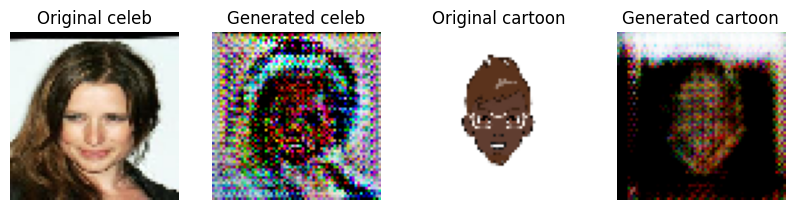

Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/1000 [00:00<09:13,  1.81it/s]

>1, dA[0.013 ,0.310 ] dB[0.017 ,0.003] g[11.239 ,9.657]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/1000 [00:01<09:17,  1.79it/s]

>2, dA[0.241 ,0.036 ] dB[0.003 ,0.020] g[9.238 ,8.069]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 3/1000 [00:01<09:09,  1.81it/s]

>3, dA[0.048 ,0.402 ] dB[0.019 ,0.008] g[9.578 ,8.421]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 4/1000 [00:02<09:04,  1.83it/s]

>4, dA[0.052 ,0.101 ] dB[0.008 ,0.006] g[10.803 ,9.231]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [00:02<09:02,  1.83it/s]

>5, dA[0.232 ,0.014 ] dB[0.005 ,0.005] g[10.418 ,9.210]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<08:59,  1.84it/s]

>6, dA[0.023 ,0.191 ] dB[0.025 ,0.012] g[12.243 ,10.267]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 7/1000 [00:03<08:57,  1.85it/s]

>7, dA[0.011 ,0.056 ] dB[0.006 ,0.045] g[12.166 ,11.183]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 8/1000 [00:04<08:56,  1.85it/s]

>8, dA[0.336 ,0.066 ] dB[0.023 ,0.007] g[10.501 ,11.348]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 9/1000 [00:04<09:00,  1.84it/s]

>9, dA[0.232 ,0.119 ] dB[0.012 ,0.006] g[10.054 ,9.500]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 10/1000 [00:05<09:02,  1.83it/s]

>10, dA[0.196 ,0.209 ] dB[0.008 ,0.014] g[11.262 ,10.142]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 11/1000 [00:06<09:01,  1.83it/s]

>11, dA[0.077 ,0.005 ] dB[0.005 ,0.017] g[10.302 ,8.455]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 12/1000 [00:06<08:59,  1.83it/s]

>12, dA[0.054 ,0.245 ] dB[0.012 ,0.025] g[9.245 ,7.685]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [00:07<08:58,  1.83it/s]

>13, dA[0.105 ,0.115 ] dB[0.035 ,0.006] g[11.721 ,10.871]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 14/1000 [00:07<08:56,  1.84it/s]

>14, dA[0.020 ,0.036 ] dB[0.027 ,0.011] g[11.325 ,10.607]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<08:55,  1.84it/s]

>15, dA[0.166 ,0.153 ] dB[0.016 ,0.029] g[11.655 ,9.447]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 16/1000 [00:08<08:53,  1.84it/s]

>16, dA[0.322 ,0.161 ] dB[0.008 ,0.011] g[11.438 ,10.015]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 17/1000 [00:09<08:54,  1.84it/s]

>17, dA[0.109 ,0.029 ] dB[0.006 ,0.009] g[10.035 ,8.787]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 18/1000 [00:09<08:53,  1.84it/s]

>18, dA[0.011 ,0.201 ] dB[0.005 ,0.030] g[10.327 ,8.516]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 19/1000 [00:10<08:52,  1.84it/s]

>19, dA[0.012 ,0.052 ] dB[0.011 ,0.067] g[9.084 ,8.304]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 20/1000 [00:10<08:54,  1.83it/s]

>20, dA[0.241 ,0.039 ] dB[0.058 ,0.009] g[8.576 ,7.415]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:33,  1.71it/s]

>21, dA[0.044 ,0.023 ] dB[0.005 ,0.064] g[10.328 ,9.804]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:19,  1.75it/s]

>22, dA[0.155 ,0.902 ] dB[0.021 ,0.003] g[9.920 ,8.293]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:09,  1.78it/s]

>23, dA[0.074 ,0.053 ] dB[0.007 ,0.013] g[11.818 ,9.660]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:03,  1.80it/s]

>24, dA[0.178 ,0.011 ] dB[0.022 ,0.022] g[10.206 ,9.158]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 25/1000 [00:13<09:01,  1.80it/s]

>25, dA[0.114 ,0.160 ] dB[0.022 ,0.038] g[10.756 ,8.859]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 26/1000 [00:14<08:57,  1.81it/s]

>26, dA[0.024 ,0.049 ] dB[0.008 ,0.029] g[10.381 ,9.695]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 27/1000 [00:14<08:55,  1.82it/s]

>27, dA[0.087 ,0.053 ] dB[0.007 ,0.009] g[10.661 ,9.338]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 28/1000 [00:15<08:52,  1.83it/s]

>28, dA[0.164 ,0.053 ] dB[0.009 ,0.007] g[9.266 ,7.885]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 29/1000 [00:15<08:52,  1.82it/s]

>29, dA[0.027 ,0.024 ] dB[0.003 ,0.011] g[9.741 ,8.241]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 30/1000 [00:16<08:51,  1.83it/s]

>30, dA[0.269 ,0.095 ] dB[0.034 ,0.085] g[9.313 ,8.778]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 31/1000 [00:17<08:48,  1.83it/s]

>31, dA[0.090 ,0.211 ] dB[0.019 ,0.010] g[10.145 ,8.591]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 32/1000 [00:17<08:46,  1.84it/s]

>32, dA[0.030 ,0.075 ] dB[0.019 ,0.009] g[10.074 ,8.193]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 33/1000 [00:18<08:45,  1.84it/s]

>33, dA[0.159 ,0.185 ] dB[0.013 ,0.004] g[10.291 ,9.845]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 34/1000 [00:18<08:45,  1.84it/s]

>34, dA[0.026 ,0.054 ] dB[0.046 ,0.045] g[8.749 ,7.569]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 35/1000 [00:19<08:45,  1.84it/s]

>35, dA[0.117 ,0.173 ] dB[0.034 ,0.010] g[10.946 ,9.627]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 36/1000 [00:19<08:45,  1.83it/s]

>36, dA[0.443 ,0.021 ] dB[0.034 ,0.004] g[10.368 ,10.416]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▎         | 37/1000 [00:20<08:56,  1.80it/s]

>37, dA[0.093 ,0.596 ] dB[0.039 ,0.020] g[10.031 ,8.908]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 38/1000 [00:20<08:57,  1.79it/s]

>38, dA[0.250 ,0.131 ] dB[0.012 ,0.014] g[9.527 ,7.917]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 39/1000 [00:21<08:52,  1.80it/s]

>39, dA[0.225 ,0.138 ] dB[0.002 ,0.121] g[11.348 ,10.855]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 40/1000 [00:21<08:47,  1.82it/s]

>40, dA[0.236 ,0.124 ] dB[0.174 ,0.192] g[9.662 ,8.143]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 41/1000 [00:22<08:48,  1.81it/s]

>41, dA[0.095 ,0.249 ] dB[0.068 ,0.003] g[8.982 ,7.092]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [00:23<08:47,  1.82it/s]

>42, dA[0.091 ,0.072 ] dB[0.036 ,0.011] g[10.450 ,8.895]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 43/1000 [00:23<08:45,  1.82it/s]

>43, dA[0.072 ,0.018 ] dB[0.012 ,0.015] g[8.675 ,8.038]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:43,  1.83it/s]

>44, dA[0.035 ,0.051 ] dB[0.014 ,0.076] g[10.831 ,11.448]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 45/1000 [00:24<08:43,  1.82it/s]

>45, dA[0.163 ,0.151 ] dB[0.018 ,0.013] g[10.115 ,8.621]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:41,  1.83it/s]

>46, dA[0.030 ,0.012 ] dB[0.009 ,0.009] g[10.108 ,8.541]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 47/1000 [00:25<08:39,  1.84it/s]

>47, dA[0.052 ,0.025 ] dB[0.006 ,0.020] g[8.998 ,7.515]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 48/1000 [00:26<08:37,  1.84it/s]

>48, dA[0.056 ,0.291 ] dB[0.017 ,0.022] g[11.441 ,9.583]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 49/1000 [00:26<08:38,  1.84it/s]

>49, dA[0.067 ,0.034 ] dB[0.025 ,0.010] g[10.721 ,9.615]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 50/1000 [00:27<08:37,  1.83it/s]

>50, dA[0.009 ,0.051 ] dB[0.018 ,0.008] g[9.647 ,8.312]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 51/1000 [00:27<08:36,  1.84it/s]

>51, dA[0.058 ,0.030 ] dB[0.010 ,0.022] g[9.013 ,8.092]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 52/1000 [00:28<08:35,  1.84it/s]

>52, dA[0.012 ,0.586 ] dB[0.021 ,0.055] g[8.099 ,7.415]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 53/1000 [00:29<08:35,  1.84it/s]

>53, dA[0.037 ,0.167 ] dB[0.199 ,0.027] g[13.533 ,12.191]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 54/1000 [00:29<08:34,  1.84it/s]

>54, dA[0.307 ,0.022 ] dB[0.012 ,0.011] g[10.330 ,10.090]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:33,  1.84it/s]

>55, dA[0.042 ,0.192 ] dB[0.020 ,0.007] g[9.434 ,8.092]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 56/1000 [00:30<08:32,  1.84it/s]

>56, dA[0.014 ,0.090 ] dB[0.002 ,0.005] g[10.562 ,8.798]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 57/1000 [00:31<08:33,  1.84it/s]

>57, dA[0.403 ,0.127 ] dB[0.006 ,0.018] g[10.301 ,8.838]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 58/1000 [00:31<08:32,  1.84it/s]

>58, dA[0.041 ,0.005 ] dB[0.007 ,0.016] g[9.689 ,8.914]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 59/1000 [00:32<08:32,  1.83it/s]

>59, dA[0.079 ,0.043 ] dB[0.011 ,0.038] g[10.548 ,8.216]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 60/1000 [00:32<08:34,  1.83it/s]

>60, dA[0.057 ,0.055 ] dB[0.034 ,0.018] g[11.143 ,9.783]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 61/1000 [00:33<08:34,  1.82it/s]

>61, dA[0.070 ,0.322 ] dB[0.017 ,0.013] g[9.153 ,7.721]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 62/1000 [00:33<08:33,  1.83it/s]

>62, dA[0.202 ,0.038 ] dB[0.034 ,0.006] g[10.106 ,7.821]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:34<08:31,  1.83it/s]

>63, dA[0.016 ,0.330 ] dB[0.016 ,0.037] g[8.288 ,7.226]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 64/1000 [00:35<08:30,  1.83it/s]

>64, dA[0.158 ,0.034 ] dB[0.014 ,0.057] g[9.399 ,7.493]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 65/1000 [00:35<08:31,  1.83it/s]

>65, dA[0.052 ,0.429 ] dB[0.040 ,0.013] g[11.292 ,9.499]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 66/1000 [00:36<08:31,  1.83it/s]

>66, dA[0.318 ,0.176 ] dB[0.009 ,0.024] g[12.077 ,11.345]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [00:36<08:28,  1.83it/s]

>67, dA[0.134 ,0.115 ] dB[0.016 ,0.017] g[10.496 ,8.793]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:37<08:27,  1.84it/s]

>68, dA[0.157 ,0.045 ] dB[0.064 ,0.017] g[9.624 ,9.072]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 69/1000 [00:37<08:28,  1.83it/s]

>69, dA[0.088 ,0.209 ] dB[0.008 ,0.014] g[9.217 ,8.042]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 70/1000 [00:38<08:28,  1.83it/s]

>70, dA[0.135 ,0.173 ] dB[0.016 ,0.013] g[10.393 ,8.068]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [00:38<08:27,  1.83it/s]

>71, dA[0.162 ,0.098 ] dB[0.019 ,0.038] g[8.855 ,8.217]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 72/1000 [00:39<08:25,  1.84it/s]

>72, dA[0.077 ,0.012 ] dB[0.014 ,0.013] g[10.467 ,9.507]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 73/1000 [00:39<08:25,  1.83it/s]

>73, dA[0.131 ,0.212 ] dB[0.005 ,0.008] g[10.140 ,8.284]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 74/1000 [00:40<08:25,  1.83it/s]

>74, dA[0.333 ,0.203 ] dB[0.006 ,0.009] g[11.885 ,10.090]
1/1 [==============================] - 0s 27ms/step



Batchs:   8%|▊         | 75/1000 [00:41<08:30,  1.81it/s]

>75, dA[0.051 ,0.046 ] dB[0.041 ,0.098] g[8.806 ,8.854]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 76/1000 [00:41<08:26,  1.83it/s]

>76, dA[0.020 ,0.012 ] dB[0.037 ,0.049] g[10.882 ,9.639]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:42<08:25,  1.82it/s]

>77, dA[0.044 ,0.121 ] dB[0.019 ,0.012] g[9.799 ,9.675]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 78/1000 [00:42<08:24,  1.83it/s]

>78, dA[0.290 ,0.032 ] dB[0.003 ,0.058] g[9.958 ,10.240]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 79/1000 [00:43<08:22,  1.83it/s]

>79, dA[0.034 ,0.395 ] dB[0.046 ,0.032] g[12.552 ,10.499]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 80/1000 [00:43<08:21,  1.84it/s]

>80, dA[0.191 ,0.067 ] dB[0.012 ,0.011] g[9.024 ,8.119]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 81/1000 [00:44<08:23,  1.83it/s]

>81, dA[0.356 ,0.053 ] dB[0.017 ,0.010] g[11.284 ,11.966]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [00:44<08:22,  1.83it/s]

>82, dA[0.022 ,0.047 ] dB[0.007 ,0.009] g[11.210 ,9.580]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [00:45<08:20,  1.83it/s]

>83, dA[0.029 ,0.181 ] dB[0.015 ,0.003] g[11.115 ,9.670]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 84/1000 [00:45<08:19,  1.84it/s]

>84, dA[0.406 ,0.110 ] dB[0.014 ,0.038] g[11.013 ,10.024]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 85/1000 [00:46<08:19,  1.83it/s]

>85, dA[0.079 ,0.078 ] dB[0.004 ,0.007] g[8.726 ,7.743]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:47<08:17,  1.84it/s]

>86, dA[0.019 ,0.053 ] dB[0.005 ,0.020] g[11.422 ,10.831]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 87/1000 [00:47<08:15,  1.84it/s]

>87, dA[0.145 ,0.016 ] dB[0.058 ,0.055] g[8.277 ,7.331]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 88/1000 [00:48<08:14,  1.84it/s]

>88, dA[0.122 ,0.070 ] dB[0.010 ,0.021] g[9.414 ,7.961]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [00:48<08:14,  1.84it/s]

>89, dA[0.049 ,0.597 ] dB[0.005 ,0.034] g[12.218 ,10.395]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [00:49<08:14,  1.84it/s]

>90, dA[0.158 ,0.013 ] dB[0.032 ,0.012] g[11.116 ,10.739]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 91/1000 [00:49<08:12,  1.84it/s]

>91, dA[0.174 ,0.066 ] dB[0.007 ,0.023] g[10.721 ,9.456]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 92/1000 [00:50<08:11,  1.85it/s]

>92, dA[0.033 ,0.107 ] dB[0.011 ,0.013] g[11.132 ,9.804]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 93/1000 [00:50<08:15,  1.83it/s]

>93, dA[0.121 ,0.109 ] dB[0.011 ,0.006] g[9.506 ,8.461]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 94/1000 [00:51<08:16,  1.82it/s]

>94, dA[0.297 ,0.020 ] dB[0.015 ,0.017] g[8.983 ,7.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [00:51<08:15,  1.83it/s]

>95, dA[0.069 ,0.454 ] dB[0.007 ,0.009] g[9.224 ,7.315]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 96/1000 [00:52<08:17,  1.82it/s]

>96, dA[0.016 ,0.025 ] dB[0.013 ,0.004] g[11.833 ,10.755]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 97/1000 [00:53<08:16,  1.82it/s]

>97, dA[0.257 ,0.071 ] dB[0.005 ,0.023] g[9.459 ,8.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 98/1000 [00:53<08:13,  1.83it/s]

>98, dA[0.236 ,0.301 ] dB[0.026 ,0.002] g[9.821 ,9.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 99/1000 [00:54<08:11,  1.83it/s]

>99, dA[0.160 ,0.022 ] dB[0.020 ,0.006] g[10.068 ,8.420]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 100/1000 [00:54<08:08,  1.84it/s]

>100, dA[0.008 ,0.267 ] dB[0.032 ,0.137] g[9.529 ,9.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 101/1000 [00:55<08:09,  1.84it/s]

>101, dA[0.055 ,0.018 ] dB[0.009 ,0.021] g[9.502 ,7.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 102/1000 [00:55<08:08,  1.84it/s]

>102, dA[0.143 ,0.176 ] dB[0.008 ,0.027] g[9.016 ,7.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:56<08:06,  1.85it/s]

>103, dA[0.145 ,0.053 ] dB[0.008 ,0.010] g[11.399 ,10.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:56<08:04,  1.85it/s]

>104, dA[0.008 ,0.134 ] dB[0.017 ,0.006] g[8.703 ,7.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [00:57<08:04,  1.85it/s]

>105, dA[0.194 ,0.052 ] dB[0.004 ,0.025] g[11.292 ,9.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [00:57<08:04,  1.85it/s]

>106, dA[0.063 ,0.005 ] dB[0.021 ,0.011] g[10.298 ,8.342]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 107/1000 [00:58<08:03,  1.85it/s]

>107, dA[0.016 ,0.021 ] dB[0.012 ,0.003] g[11.346 ,10.674]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 108/1000 [00:59<08:05,  1.84it/s]

>108, dA[0.033 ,0.285 ] dB[0.008 ,0.008] g[12.359 ,11.210]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 109/1000 [00:59<08:05,  1.84it/s]

>109, dA[0.051 ,0.096 ] dB[0.006 ,0.021] g[11.936 ,11.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 110/1000 [01:00<08:04,  1.84it/s]

>110, dA[0.019 ,0.018 ] dB[0.030 ,0.067] g[11.784 ,10.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [01:00<08:04,  1.83it/s]

>111, dA[0.239 ,0.503 ] dB[0.024 ,0.018] g[10.493 ,9.469]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 112/1000 [01:01<08:02,  1.84it/s]

>112, dA[0.112 ,0.040 ] dB[0.009 ,0.013] g[9.748 ,8.785]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 113/1000 [01:01<08:03,  1.83it/s]

>113, dA[0.023 ,0.024 ] dB[0.009 ,0.007] g[13.753 ,13.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 114/1000 [01:02<08:02,  1.84it/s]

>114, dA[0.246 ,0.204 ] dB[0.023 ,0.008] g[9.542 ,7.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 115/1000 [01:02<08:01,  1.84it/s]

>115, dA[0.030 ,0.186 ] dB[0.010 ,0.010] g[10.374 ,8.613]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 116/1000 [01:03<08:00,  1.84it/s]

>116, dA[0.279 ,0.011 ] dB[0.007 ,0.004] g[9.139 ,8.027]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 117/1000 [01:03<08:00,  1.84it/s]

>117, dA[0.091 ,0.180 ] dB[0.007 ,0.005] g[9.693 ,7.771]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 118/1000 [01:04<08:00,  1.84it/s]

>118, dA[0.014 ,0.036 ] dB[0.025 ,0.071] g[8.722 ,8.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [01:05<07:58,  1.84it/s]

>119, dA[0.132 ,0.006 ] dB[0.006 ,0.018] g[9.777 ,8.025]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 120/1000 [01:05<07:58,  1.84it/s]

>120, dA[0.013 ,0.060 ] dB[0.009 ,0.025] g[11.656 ,9.698]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 121/1000 [01:06<08:02,  1.82it/s]

>121, dA[0.073 ,0.230 ] dB[0.042 ,0.009] g[10.474 ,10.214]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 122/1000 [01:06<08:00,  1.83it/s]

>122, dA[0.135 ,0.073 ] dB[0.020 ,0.026] g[10.373 ,8.511]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 123/1000 [01:07<07:58,  1.83it/s]

>123, dA[0.357 ,0.066 ] dB[0.020 ,0.029] g[9.475 ,8.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [01:07<07:57,  1.83it/s]

>124, dA[0.039 ,0.028 ] dB[0.027 ,0.010] g[9.615 ,7.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 125/1000 [01:08<07:56,  1.83it/s]

>125, dA[0.014 ,0.065 ] dB[0.006 ,0.005] g[10.492 ,9.835]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 126/1000 [01:08<07:56,  1.84it/s]

>126, dA[0.037 ,0.035 ] dB[0.008 ,0.003] g[12.227 ,11.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:09<07:55,  1.83it/s]

>127, dA[0.034 ,0.009 ] dB[0.012 ,0.003] g[8.484 ,6.931]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 128/1000 [01:09<07:55,  1.84it/s]

>128, dA[0.007 ,0.019 ] dB[0.005 ,0.019] g[12.013 ,11.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:10<07:55,  1.83it/s]

>129, dA[0.016 ,0.014 ] dB[0.011 ,0.011] g[9.805 ,8.806]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 130/1000 [01:11<07:58,  1.82it/s]

>130, dA[0.067 ,0.010 ] dB[0.007 ,0.032] g[9.645 ,8.586]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 131/1000 [01:11<07:57,  1.82it/s]

>131, dA[0.023 ,0.510 ] dB[0.013 ,0.007] g[12.678 ,11.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [01:12<07:54,  1.83it/s]

>132, dA[0.176 ,0.029 ] dB[0.005 ,0.038] g[11.165 ,10.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 133/1000 [01:12<07:54,  1.83it/s]

>133, dA[0.168 ,0.090 ] dB[0.015 ,0.029] g[9.828 ,8.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:13<07:51,  1.84it/s]

>134, dA[0.039 ,0.033 ] dB[0.021 ,0.009] g[11.106 ,8.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 135/1000 [01:13<07:50,  1.84it/s]

>135, dA[0.014 ,0.315 ] dB[0.003 ,0.019] g[10.035 ,8.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 136/1000 [01:14<07:49,  1.84it/s]

>136, dA[0.049 ,0.056 ] dB[0.014 ,0.009] g[10.350 ,8.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:14<07:49,  1.84it/s]

>137, dA[0.248 ,0.157 ] dB[0.006 ,0.007] g[9.646 ,9.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 138/1000 [01:15<07:49,  1.84it/s]

>138, dA[0.018 ,0.103 ] dB[0.014 ,0.021] g[8.239 ,6.891]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 139/1000 [01:15<07:48,  1.84it/s]

>139, dA[0.022 ,0.008 ] dB[0.014 ,0.057] g[8.286 ,7.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:16<07:47,  1.84it/s]

>140, dA[0.118 ,0.051 ] dB[0.016 ,0.014] g[10.354 ,8.705]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 141/1000 [01:17<07:48,  1.83it/s]

>141, dA[0.017 ,0.250 ] dB[0.009 ,0.016] g[8.552 ,7.096]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 142/1000 [01:17<07:48,  1.83it/s]

>142, dA[0.080 ,0.091 ] dB[0.007 ,0.008] g[9.964 ,8.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:18<07:47,  1.83it/s]

>143, dA[0.026 ,0.072 ] dB[0.002 ,0.005] g[10.916 ,9.110]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 144/1000 [01:18<07:46,  1.84it/s]

>144, dA[0.132 ,0.008 ] dB[0.011 ,0.012] g[9.845 ,9.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 145/1000 [01:19<07:46,  1.83it/s]

>145, dA[0.153 ,0.020 ] dB[0.005 ,0.005] g[9.440 ,8.353]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 146/1000 [01:19<07:45,  1.83it/s]

>146, dA[0.040 ,0.435 ] dB[0.009 ,0.005] g[10.043 ,7.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 147/1000 [01:20<07:44,  1.84it/s]

>147, dA[0.046 ,0.090 ] dB[0.007 ,0.005] g[9.342 ,8.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [01:20<07:45,  1.83it/s]

>148, dA[0.255 ,0.069 ] dB[0.002 ,0.006] g[10.567 ,9.118]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 149/1000 [01:21<07:45,  1.83it/s]

>149, dA[0.028 ,0.011 ] dB[0.013 ,0.007] g[8.622 ,7.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:21<07:43,  1.83it/s]

>150, dA[0.158 ,0.385 ] dB[0.004 ,0.010] g[8.041 ,7.009]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 151/1000 [01:22<07:43,  1.83it/s]

>151, dA[0.013 ,0.015 ] dB[0.003 ,0.003] g[11.477 ,10.672]
1/1 [==============================] - 0s 29ms/step



Batchs:  15%|█▌        | 152/1000 [01:23<07:48,  1.81it/s]

>152, dA[0.545 ,0.039 ] dB[0.008 ,0.005] g[10.517 ,10.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [01:23<07:49,  1.80it/s]

>153, dA[0.016 ,0.187 ] dB[0.004 ,0.010] g[12.050 ,10.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 154/1000 [01:24<07:45,  1.82it/s]

>154, dA[0.142 ,0.033 ] dB[0.003 ,0.014] g[11.783 ,10.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:24<07:42,  1.83it/s]

>155, dA[0.126 ,0.159 ] dB[0.006 ,0.004] g[9.057 ,8.241]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 156/1000 [01:25<07:39,  1.84it/s]

>156, dA[0.046 ,0.087 ] dB[0.009 ,0.007] g[11.167 ,10.343]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [01:25<07:40,  1.83it/s]

>157, dA[0.174 ,0.060 ] dB[0.008 ,0.020] g[10.472 ,8.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [01:26<07:38,  1.84it/s]

>158, dA[0.058 ,0.062 ] dB[0.014 ,0.009] g[10.295 ,9.340]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 159/1000 [01:26<07:38,  1.84it/s]

>159, dA[0.056 ,0.038 ] dB[0.006 ,0.004] g[9.198 ,8.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [01:27<07:36,  1.84it/s]

>160, dA[0.066 ,0.085 ] dB[0.001 ,0.004] g[11.019 ,9.913]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 161/1000 [01:27<07:38,  1.83it/s]

>161, dA[0.014 ,0.028 ] dB[0.101 ,0.140] g[13.310 ,13.247]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 162/1000 [01:28<07:37,  1.83it/s]

>162, dA[0.013 ,0.008 ] dB[0.042 ,0.008] g[9.948 ,9.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 163/1000 [01:29<07:35,  1.84it/s]

>163, dA[0.052 ,0.009 ] dB[0.017 ,0.057] g[10.651 ,8.675]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 164/1000 [01:29<07:34,  1.84it/s]

>164, dA[0.019 ,0.027 ] dB[0.050 ,0.032] g[12.819 ,10.749]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 165/1000 [01:30<07:35,  1.83it/s]

>165, dA[0.034 ,0.115 ] dB[0.030 ,0.068] g[10.117 ,9.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [01:30<07:34,  1.84it/s]

>166, dA[0.122 ,0.028 ] dB[0.056 ,0.036] g[11.685 ,10.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 167/1000 [01:31<07:33,  1.84it/s]

>167, dA[0.016 ,0.153 ] dB[0.054 ,0.012] g[8.853 ,7.311]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 168/1000 [01:31<07:33,  1.83it/s]

>168, dA[0.031 ,0.104 ] dB[0.023 ,0.012] g[10.836 ,9.839]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 169/1000 [01:32<07:33,  1.83it/s]

>169, dA[0.485 ,0.010 ] dB[0.007 ,0.009] g[9.500 ,7.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [01:32<07:31,  1.84it/s]

>170, dA[0.074 ,0.292 ] dB[0.005 ,0.005] g[11.206 ,9.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 171/1000 [01:33<07:31,  1.84it/s]

>171, dA[0.122 ,0.025 ] dB[0.010 ,0.025] g[10.577 ,9.221]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 172/1000 [01:33<07:31,  1.84it/s]

>172, dA[0.102 ,0.038 ] dB[0.015 ,0.010] g[10.056 ,8.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 173/1000 [01:34<07:31,  1.83it/s]

>173, dA[0.005 ,0.200 ] dB[0.029 ,0.010] g[9.711 ,7.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 174/1000 [01:35<07:30,  1.83it/s]

>174, dA[0.305 ,0.006 ] dB[0.003 ,0.009] g[10.980 ,9.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:35<07:29,  1.84it/s]

>175, dA[0.265 ,0.363 ] dB[0.005 ,0.016] g[9.969 ,8.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [01:36<07:28,  1.84it/s]

>176, dA[0.162 ,0.025 ] dB[0.018 ,0.025] g[9.078 ,7.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:36<07:28,  1.84it/s]

>177, dA[0.095 ,0.117 ] dB[0.025 ,0.010] g[12.923 ,11.280]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 178/1000 [01:37<07:27,  1.84it/s]

>178, dA[0.018 ,0.284 ] dB[0.006 ,0.011] g[10.111 ,8.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:37<07:27,  1.83it/s]

>179, dA[0.035 ,0.021 ] dB[0.037 ,0.023] g[11.857 ,11.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 180/1000 [01:38<07:26,  1.84it/s]

>180, dA[0.205 ,0.026 ] dB[0.018 ,0.013] g[11.065 ,9.590]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 181/1000 [01:38<07:26,  1.83it/s]

>181, dA[0.202 ,0.418 ] dB[0.021 ,0.023] g[9.987 ,8.217]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 182/1000 [01:39<07:29,  1.82it/s]

>182, dA[0.023 ,0.088 ] dB[0.011 ,0.034] g[12.596 ,12.402]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 183/1000 [01:39<07:26,  1.83it/s]

>183, dA[0.220 ,0.276 ] dB[0.024 ,0.010] g[11.179 ,9.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 184/1000 [01:40<07:24,  1.83it/s]

>184, dA[0.145 ,0.113 ] dB[0.020 ,0.008] g[9.561 ,7.883]
1/1 [==============================] - 0s 26ms/step



Batchs:  18%|█▊        | 185/1000 [01:41<07:30,  1.81it/s]

>185, dA[0.171 ,0.145 ] dB[0.024 ,0.010] g[9.816 ,8.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:41<07:27,  1.82it/s]

>186, dA[0.051 ,0.082 ] dB[0.012 ,0.011] g[10.416 ,10.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 187/1000 [01:42<07:25,  1.82it/s]

>187, dA[0.035 ,0.037 ] dB[0.010 ,0.015] g[12.018 ,11.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 188/1000 [01:42<07:23,  1.83it/s]

>188, dA[0.076 ,0.108 ] dB[0.007 ,0.020] g[10.211 ,8.663]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 189/1000 [01:43<07:22,  1.83it/s]

>189, dA[0.279 ,0.063 ] dB[0.007 ,0.014] g[11.825 ,10.564]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 190/1000 [01:43<07:22,  1.83it/s]

>190, dA[0.073 ,0.122 ] dB[0.004 ,0.006] g[9.510 ,7.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:44<07:20,  1.84it/s]

>191, dA[0.025 ,0.015 ] dB[0.016 ,0.030] g[10.699 ,10.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:44<07:19,  1.84it/s]

>192, dA[0.033 ,0.014 ] dB[0.003 ,0.004] g[9.804 ,8.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 193/1000 [01:45<07:18,  1.84it/s]

>193, dA[0.070 ,0.565 ] dB[0.001 ,0.026] g[10.503 ,8.260]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 194/1000 [01:45<07:19,  1.84it/s]

>194, dA[0.011 ,0.016 ] dB[0.006 ,0.023] g[8.745 ,7.608]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 195/1000 [01:46<07:19,  1.83it/s]

>195, dA[0.026 ,0.006 ] dB[0.006 ,0.001] g[9.235 ,8.879]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 196/1000 [01:47<07:18,  1.83it/s]

>196, dA[0.230 ,0.061 ] dB[0.001 ,0.009] g[10.787 ,9.574]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 197/1000 [01:47<07:18,  1.83it/s]

>197, dA[0.214 ,0.023 ] dB[0.009 ,0.008] g[9.743 ,8.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 198/1000 [01:48<07:17,  1.83it/s]

>198, dA[0.047 ,0.035 ] dB[0.019 ,0.029] g[11.808 ,10.381]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 199/1000 [01:48<07:16,  1.84it/s]

>199, dA[0.171 ,0.011 ] dB[0.014 ,0.007] g[9.606 ,9.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [01:49<07:13,  1.85it/s]

>200, dA[0.187 ,0.028 ] dB[0.021 ,0.013] g[10.331 ,9.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:49<07:13,  1.84it/s]

>201, dA[0.101 ,0.026 ] dB[0.006 ,0.020] g[12.848 ,12.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 202/1000 [01:50<07:13,  1.84it/s]

>202, dA[0.077 ,0.088 ] dB[0.014 ,0.013] g[11.198 ,9.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 203/1000 [01:50<07:13,  1.84it/s]

>203, dA[0.017 ,0.539 ] dB[0.018 ,0.010] g[9.022 ,7.773]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 204/1000 [01:51<07:12,  1.84it/s]

>204, dA[0.220 ,0.088 ] dB[0.008 ,0.016] g[9.587 ,9.191]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 205/1000 [01:51<07:13,  1.83it/s]

>205, dA[0.089 ,0.089 ] dB[0.005 ,0.011] g[10.069 ,8.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 206/1000 [01:52<07:12,  1.83it/s]

>206, dA[0.113 ,0.039 ] dB[0.198 ,0.701] g[8.690 ,7.998]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 207/1000 [01:53<07:11,  1.84it/s]

>207, dA[0.010 ,0.040 ] dB[0.097 ,0.012] g[12.042 ,11.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 208/1000 [01:53<07:10,  1.84it/s]

>208, dA[0.159 ,0.015 ] dB[0.084 ,0.077] g[9.654 ,8.889]
1/1 [==============================] - 0s 35ms/step



Batchs:  21%|██        | 209/1000 [01:54<07:23,  1.78it/s]

>209, dA[0.093 ,0.226 ] dB[0.019 ,0.053] g[10.901 ,9.202]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 210/1000 [01:54<07:22,  1.79it/s]

>210, dA[0.146 ,0.131 ] dB[0.023 ,0.102] g[8.742 ,11.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 211/1000 [01:55<07:19,  1.80it/s]

>211, dA[0.111 ,0.252 ] dB[0.085 ,0.176] g[10.932 ,10.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 212/1000 [01:55<07:15,  1.81it/s]

>212, dA[0.009 ,0.143 ] dB[0.189 ,0.048] g[9.764 ,8.569]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 213/1000 [01:56<07:14,  1.81it/s]

>213, dA[0.054 ,0.108 ] dB[0.032 ,0.150] g[10.535 ,9.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [01:56<07:11,  1.82it/s]

>214, dA[0.064 ,0.047 ] dB[0.251 ,0.026] g[9.637 ,8.317]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 215/1000 [01:57<07:11,  1.82it/s]

>215, dA[0.102 ,0.167 ] dB[0.016 ,0.192] g[9.800 ,9.775]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 216/1000 [01:58<07:08,  1.83it/s]

>216, dA[0.109 ,0.039 ] dB[0.267 ,0.040] g[10.079 ,8.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [01:58<07:08,  1.83it/s]

>217, dA[0.018 ,0.029 ] dB[0.016 ,0.061] g[11.075 ,9.580]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 218/1000 [01:59<07:08,  1.82it/s]

>218, dA[0.040 ,0.068 ] dB[0.040 ,0.034] g[10.597 ,8.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 219/1000 [01:59<07:06,  1.83it/s]

>219, dA[0.026 ,0.009 ] dB[0.045 ,0.011] g[9.902 ,8.524]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 220/1000 [02:00<07:05,  1.83it/s]

>220, dA[0.023 ,0.506 ] dB[0.013 ,0.013] g[9.928 ,8.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 221/1000 [02:00<07:06,  1.83it/s]

>221, dA[0.108 ,0.009 ] dB[0.009 ,0.010] g[9.870 ,8.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 222/1000 [02:01<07:04,  1.83it/s]

>222, dA[0.036 ,0.006 ] dB[0.015 ,0.018] g[10.471 ,10.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 223/1000 [02:01<07:03,  1.83it/s]

>223, dA[0.215 ,0.260 ] dB[0.014 ,0.006] g[8.646 ,7.770]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 224/1000 [02:02<07:02,  1.84it/s]

>224, dA[0.085 ,0.113 ] dB[0.022 ,0.011] g[10.492 ,8.863]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▎       | 225/1000 [02:02<07:02,  1.84it/s]

>225, dA[0.046 ,0.007 ] dB[0.021 ,0.013] g[10.033 ,9.040]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 226/1000 [02:03<07:01,  1.84it/s]

>226, dA[0.011 ,0.036 ] dB[0.015 ,0.014] g[9.036 ,8.045]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 227/1000 [02:04<07:00,  1.84it/s]

>227, dA[0.163 ,0.046 ] dB[0.014 ,0.016] g[9.024 ,7.941]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 228/1000 [02:04<07:00,  1.84it/s]

>228, dA[0.005 ,0.096 ] dB[0.026 ,0.009] g[11.292 ,10.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 229/1000 [02:05<07:01,  1.83it/s]

>229, dA[0.015 ,0.043 ] dB[0.005 ,0.010] g[8.956 ,7.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 230/1000 [02:05<07:01,  1.83it/s]

>230, dA[0.013 ,0.030 ] dB[0.011 ,0.067] g[9.270 ,8.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 231/1000 [02:06<06:59,  1.83it/s]

>231, dA[0.022 ,0.007 ] dB[0.023 ,0.009] g[9.576 ,8.663]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 232/1000 [02:06<06:56,  1.84it/s]

>232, dA[0.015 ,0.346 ] dB[0.002 ,0.068] g[9.592 ,7.694]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 233/1000 [02:07<06:56,  1.84it/s]

>233, dA[0.209 ,0.021 ] dB[0.081 ,0.012] g[11.285 ,8.954]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [02:07<06:55,  1.84it/s]

>234, dA[0.028 ,0.096 ] dB[0.044 ,0.019] g[8.672 ,8.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 235/1000 [02:08<06:54,  1.85it/s]

>235, dA[0.038 ,0.073 ] dB[0.041 ,0.036] g[9.121 ,7.735]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 236/1000 [02:08<06:54,  1.84it/s]

>236, dA[0.181 ,0.153 ] dB[0.015 ,0.004] g[10.999 ,10.197]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 237/1000 [02:09<06:54,  1.84it/s]

>237, dA[0.403 ,0.233 ] dB[0.005 ,0.023] g[11.061 ,10.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 238/1000 [02:10<06:53,  1.84it/s]

>238, dA[0.012 ,0.033 ] dB[0.013 ,0.161] g[9.255 ,9.228]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 239/1000 [02:10<06:52,  1.85it/s]

>239, dA[0.139 ,0.155 ] dB[0.073 ,0.015] g[11.055 ,9.932]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 240/1000 [02:11<06:56,  1.82it/s]

>240, dA[0.265 ,0.112 ] dB[0.031 ,0.003] g[8.430 ,8.448]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 241/1000 [02:11<06:56,  1.82it/s]

>241, dA[0.055 ,0.021 ] dB[0.037 ,0.014] g[10.153 ,9.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 242/1000 [02:12<06:55,  1.83it/s]

>242, dA[0.017 ,0.036 ] dB[0.010 ,0.019] g[9.670 ,7.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 243/1000 [02:12<06:52,  1.83it/s]

>243, dA[0.077 ,0.054 ] dB[0.007 ,0.017] g[10.136 ,8.702]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 244/1000 [02:13<06:52,  1.83it/s]

>244, dA[0.004 ,0.077 ] dB[0.020 ,0.018] g[11.011 ,9.350]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 245/1000 [02:13<06:51,  1.83it/s]

>245, dA[0.124 ,0.022 ] dB[0.010 ,0.007] g[7.482 ,6.672]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 246/1000 [02:14<06:51,  1.83it/s]

>246, dA[0.068 ,0.271 ] dB[0.005 ,0.011] g[11.210 ,11.526]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 247/1000 [02:14<06:49,  1.84it/s]

>247, dA[0.013 ,0.010 ] dB[0.038 ,0.025] g[9.683 ,8.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 248/1000 [02:15<06:48,  1.84it/s]

>248, dA[0.381 ,0.180 ] dB[0.011 ,0.053] g[10.653 ,9.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 249/1000 [02:16<06:49,  1.83it/s]

>249, dA[0.009 ,0.054 ] dB[0.014 ,0.013] g[11.850 ,10.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 250/1000 [02:16<06:48,  1.84it/s]

>250, dA[0.013 ,0.016 ] dB[0.076 ,0.035] g[12.269 ,12.027]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 251/1000 [02:17<06:46,  1.84it/s]

>251, dA[0.138 ,0.033 ] dB[0.039 ,0.020] g[9.565 ,8.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:17<06:45,  1.85it/s]

>252, dA[0.037 ,0.016 ] dB[0.018 ,0.030] g[13.416 ,12.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 253/1000 [02:18<06:45,  1.84it/s]

>253, dA[0.045 ,0.015 ] dB[0.091 ,0.012] g[10.551 ,8.481]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 254/1000 [02:18<06:45,  1.84it/s]

>254, dA[0.071 ,0.093 ] dB[0.050 ,0.094] g[9.140 ,9.189]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 255/1000 [02:19<06:44,  1.84it/s]

>255, dA[0.213 ,0.537 ] dB[0.109 ,0.023] g[9.788 ,8.086]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [02:19<06:43,  1.85it/s]

>256, dA[0.032 ,0.064 ] dB[0.021 ,0.173] g[11.117 ,13.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 257/1000 [02:20<06:43,  1.84it/s]

>257, dA[0.218 ,0.050 ] dB[0.015 ,0.077] g[9.523 ,7.978]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 258/1000 [02:20<06:45,  1.83it/s]

>258, dA[0.078 ,0.249 ] dB[0.045 ,0.147] g[9.616 ,7.960]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 259/1000 [02:21<06:43,  1.83it/s]

>259, dA[0.079 ,0.023 ] dB[0.047 ,0.092] g[11.002 ,10.473]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 260/1000 [02:22<06:43,  1.83it/s]

>260, dA[0.089 ,0.041 ] dB[0.022 ,0.016] g[10.999 ,8.966]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 261/1000 [02:22<06:44,  1.83it/s]

>261, dA[0.096 ,0.022 ] dB[0.013 ,0.022] g[11.674 ,10.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 262/1000 [02:23<06:43,  1.83it/s]

>262, dA[0.086 ,0.325 ] dB[0.023 ,0.006] g[9.774 ,8.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [02:23<06:41,  1.83it/s]

>263, dA[0.062 ,0.107 ] dB[0.034 ,0.052] g[8.887 ,7.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 264/1000 [02:24<06:40,  1.84it/s]

>264, dA[0.102 ,0.077 ] dB[0.030 ,0.007] g[9.358 ,8.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 265/1000 [02:24<06:40,  1.84it/s]

>265, dA[0.038 ,0.075 ] dB[0.009 ,0.011] g[9.068 ,7.997]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 266/1000 [02:25<06:42,  1.82it/s]

>266, dA[0.013 ,0.065 ] dB[0.009 ,0.050] g[11.996 ,12.013]
1/1 [==============================] - 0s 29ms/step



Batchs:  27%|██▋       | 267/1000 [02:25<06:48,  1.79it/s]

>267, dA[0.114 ,0.120 ] dB[0.020 ,0.047] g[10.380 ,9.370]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 268/1000 [02:26<06:53,  1.77it/s]

>268, dA[0.095 ,0.060 ] dB[0.063 ,0.033] g[9.689 ,7.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 269/1000 [02:26<06:49,  1.78it/s]

>269, dA[0.103 ,0.296 ] dB[0.035 ,0.020] g[11.102 ,9.738]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 270/1000 [02:27<06:45,  1.80it/s]

>270, dA[0.604 ,0.070 ] dB[0.076 ,0.033] g[8.869 ,7.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [02:28<06:41,  1.81it/s]

>271, dA[0.260 ,0.107 ] dB[0.014 ,0.038] g[9.667 ,8.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 272/1000 [02:28<06:39,  1.82it/s]

>272, dA[0.007 ,0.212 ] dB[0.028 ,0.051] g[11.060 ,10.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 273/1000 [02:29<06:38,  1.83it/s]

>273, dA[0.117 ,0.032 ] dB[0.093 ,0.013] g[8.956 ,7.137]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 274/1000 [02:29<06:36,  1.83it/s]

>274, dA[0.018 ,0.142 ] dB[0.092 ,0.070] g[10.703 ,10.020]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 275/1000 [02:30<06:37,  1.83it/s]

>275, dA[0.229 ,0.129 ] dB[0.045 ,0.042] g[11.222 ,10.248]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 276/1000 [02:30<06:42,  1.80it/s]

>276, dA[0.088 ,0.066 ] dB[0.020 ,0.022] g[9.705 ,8.267]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 277/1000 [02:31<06:39,  1.81it/s]

>277, dA[0.042 ,0.081 ] dB[0.031 ,0.014] g[12.818 ,12.024]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 278/1000 [02:31<06:37,  1.82it/s]

>278, dA[0.223 ,0.196 ] dB[0.035 ,0.030] g[9.656 ,8.507]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 279/1000 [02:32<06:34,  1.83it/s]

>279, dA[0.046 ,0.101 ] dB[0.045 ,0.037] g[8.878 ,7.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 280/1000 [02:33<06:32,  1.83it/s]

>280, dA[0.079 ,0.071 ] dB[0.079 ,0.013] g[8.043 ,7.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:33<06:33,  1.83it/s]

>281, dA[0.305 ,0.093 ] dB[0.039 ,0.012] g[10.389 ,9.749]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 282/1000 [02:34<06:33,  1.82it/s]

>282, dA[0.171 ,0.045 ] dB[0.188 ,0.098] g[6.900 ,6.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [02:34<06:32,  1.83it/s]

>283, dA[0.028 ,0.220 ] dB[0.037 ,0.279] g[9.214 ,8.349]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 284/1000 [02:35<06:30,  1.83it/s]

>284, dA[0.221 ,0.129 ] dB[0.297 ,0.017] g[12.616 ,11.509]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 285/1000 [02:35<06:30,  1.83it/s]

>285, dA[0.022 ,0.206 ] dB[0.048 ,0.009] g[8.582 ,7.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 286/1000 [02:36<06:29,  1.83it/s]

>286, dA[0.057 ,0.121 ] dB[0.025 ,0.017] g[7.595 ,6.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 287/1000 [02:36<06:28,  1.84it/s]

>287, dA[0.279 ,0.109 ] dB[0.021 ,0.019] g[8.852 ,7.971]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 288/1000 [02:37<06:26,  1.84it/s]

>288, dA[0.018 ,0.033 ] dB[0.058 ,0.336] g[11.044 ,10.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 289/1000 [02:37<06:26,  1.84it/s]

>289, dA[0.005 ,0.046 ] dB[0.274 ,0.045] g[10.484 ,10.022]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 290/1000 [02:38<06:27,  1.83it/s]

>290, dA[0.022 ,0.016 ] dB[0.026 ,0.052] g[10.692 ,10.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:39<06:28,  1.83it/s]

>291, dA[0.012 ,0.295 ] dB[0.024 ,0.030] g[10.016 ,8.361]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 292/1000 [02:39<06:28,  1.82it/s]

>292, dA[0.480 ,0.041 ] dB[0.087 ,0.029] g[11.854 ,10.547]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 293/1000 [02:40<06:27,  1.83it/s]

>293, dA[0.339 ,0.090 ] dB[0.017 ,0.007] g[9.038 ,7.816]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 294/1000 [02:40<06:26,  1.82it/s]

>294, dA[0.023 ,0.349 ] dB[0.017 ,0.069] g[9.022 ,7.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [02:41<06:25,  1.83it/s]

>295, dA[0.111 ,0.047 ] dB[0.083 ,0.058] g[8.505 ,8.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 296/1000 [02:41<06:23,  1.84it/s]

>296, dA[0.043 ,0.013 ] dB[0.173 ,0.053] g[9.351 ,8.843]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 297/1000 [02:42<06:24,  1.83it/s]

>297, dA[0.064 ,0.153 ] dB[0.003 ,0.015] g[9.244 ,8.803]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 298/1000 [02:42<06:23,  1.83it/s]

>298, dA[0.015 ,0.021 ] dB[0.008 ,0.071] g[11.036 ,10.831]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 299/1000 [02:43<06:21,  1.84it/s]

>299, dA[0.064 ,0.016 ] dB[0.149 ,0.021] g[11.090 ,9.412]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 300/1000 [02:43<06:19,  1.84it/s]

>300, dA[0.124 ,0.326 ] dB[0.025 ,0.038] g[8.768 ,7.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 301/1000 [02:44<06:19,  1.84it/s]

>301, dA[0.268 ,0.021 ] dB[0.030 ,0.008] g[9.104 ,7.943]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 302/1000 [02:45<06:18,  1.84it/s]

>302, dA[0.017 ,0.247 ] dB[0.031 ,0.032] g[9.354 ,7.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 303/1000 [02:45<06:17,  1.85it/s]

>303, dA[0.132 ,0.048 ] dB[0.011 ,0.015] g[8.569 ,7.572]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 304/1000 [02:46<06:16,  1.85it/s]

>304, dA[0.045 ,0.019 ] dB[0.009 ,0.118] g[8.832 ,10.226]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 305/1000 [02:46<06:16,  1.85it/s]

>305, dA[0.049 ,0.045 ] dB[0.016 ,0.012] g[9.925 ,8.120]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 306/1000 [02:47<06:16,  1.84it/s]

>306, dA[0.018 ,0.218 ] dB[0.014 ,0.019] g[10.835 ,8.820]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 307/1000 [02:47<06:15,  1.84it/s]

>307, dA[0.090 ,0.014 ] dB[0.010 ,0.030] g[9.611 ,8.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 308/1000 [02:48<06:15,  1.84it/s]

>308, dA[0.066 ,0.008 ] dB[0.014 ,0.015] g[9.144 ,7.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [02:48<06:14,  1.84it/s]

>309, dA[0.020 ,0.021 ] dB[0.021 ,0.017] g[12.332 ,10.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 310/1000 [02:49<06:14,  1.84it/s]

>310, dA[0.195 ,0.077 ] dB[0.008 ,0.024] g[10.463 ,8.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 311/1000 [02:49<06:13,  1.84it/s]

>311, dA[0.148 ,0.026 ] dB[0.068 ,0.026] g[10.478 ,8.493]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 312/1000 [02:50<06:12,  1.85it/s]

>312, dA[0.080 ,0.029 ] dB[0.620 ,0.263] g[7.785 ,7.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [02:50<06:13,  1.84it/s]

>313, dA[0.204 ,0.845 ] dB[0.039 ,0.036] g[7.931 ,7.643]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 314/1000 [02:51<06:12,  1.84it/s]

>314, dA[0.188 ,0.058 ] dB[0.263 ,0.165] g[10.092 ,9.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [02:52<06:11,  1.84it/s]

>315, dA[0.051 ,0.036 ] dB[0.013 ,0.015] g[11.246 ,11.552]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 316/1000 [02:52<06:11,  1.84it/s]

>316, dA[0.295 ,0.045 ] dB[0.073 ,0.049] g[7.650 ,8.538]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 317/1000 [02:53<06:16,  1.81it/s]

>317, dA[0.034 ,0.045 ] dB[0.008 ,0.073] g[12.123 ,11.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [02:53<06:14,  1.82it/s]

>318, dA[0.035 ,0.028 ] dB[0.075 ,0.053] g[11.424 ,8.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 319/1000 [02:54<06:11,  1.83it/s]

>319, dA[0.347 ,0.413 ] dB[0.036 ,0.031] g[9.422 ,8.557]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 320/1000 [02:54<06:11,  1.83it/s]

>320, dA[0.092 ,0.191 ] dB[0.035 ,0.020] g[9.891 ,11.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 321/1000 [02:55<06:11,  1.83it/s]

>321, dA[0.064 ,0.064 ] dB[0.085 ,0.011] g[8.756 ,7.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 322/1000 [02:55<06:10,  1.83it/s]

>322, dA[0.420 ,0.118 ] dB[0.017 ,0.006] g[10.372 ,9.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [02:56<06:08,  1.84it/s]

>323, dA[0.589 ,0.079 ] dB[0.006 ,0.005] g[9.571 ,10.679]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 324/1000 [02:57<06:13,  1.81it/s]

>324, dA[0.088 ,0.084 ] dB[0.006 ,0.011] g[9.759 ,7.989]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▎      | 325/1000 [02:57<06:16,  1.79it/s]

>325, dA[0.035 ,0.272 ] dB[0.002 ,0.019] g[9.397 ,7.871]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 326/1000 [02:58<06:14,  1.80it/s]

>326, dA[0.137 ,0.062 ] dB[0.007 ,0.010] g[10.802 ,9.355]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 327/1000 [02:58<06:10,  1.81it/s]

>327, dA[0.465 ,0.048 ] dB[0.019 ,0.045] g[9.117 ,9.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 328/1000 [02:59<06:08,  1.83it/s]

>328, dA[0.024 ,0.066 ] dB[0.008 ,0.006] g[12.459 ,11.547]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 329/1000 [02:59<06:08,  1.82it/s]

>329, dA[0.028 ,0.004 ] dB[0.016 ,0.023] g[10.367 ,9.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 330/1000 [03:00<06:06,  1.83it/s]

>330, dA[0.081 ,0.416 ] dB[0.015 ,0.010] g[9.856 ,7.863]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 331/1000 [03:00<06:06,  1.82it/s]

>331, dA[0.243 ,0.037 ] dB[0.019 ,0.006] g[10.341 ,9.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 332/1000 [03:01<06:05,  1.83it/s]

>332, dA[0.220 ,0.174 ] dB[0.020 ,0.005] g[9.651 ,8.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [03:01<06:04,  1.83it/s]

>333, dA[0.052 ,0.085 ] dB[0.014 ,0.004] g[10.947 ,8.745]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 334/1000 [03:02<06:03,  1.83it/s]

>334, dA[0.071 ,0.029 ] dB[0.010 ,0.006] g[8.330 ,7.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 335/1000 [03:03<06:02,  1.84it/s]

>335, dA[0.050 ,0.032 ] dB[0.014 ,0.032] g[9.634 ,8.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 336/1000 [03:03<06:01,  1.84it/s]

>336, dA[0.052 ,0.083 ] dB[0.029 ,0.012] g[11.122 ,10.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 337/1000 [03:04<06:01,  1.84it/s]

>337, dA[0.089 ,0.379 ] dB[0.024 ,0.012] g[10.507 ,8.367]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 338/1000 [03:04<06:00,  1.83it/s]

>338, dA[0.045 ,0.020 ] dB[0.012 ,0.043] g[10.685 ,9.461]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:05<05:59,  1.84it/s]

>339, dA[0.194 ,0.018 ] dB[0.010 ,0.042] g[10.564 ,10.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 340/1000 [03:05<05:58,  1.84it/s]

>340, dA[0.108 ,0.331 ] dB[0.011 ,0.008] g[10.239 ,9.913]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 341/1000 [03:06<05:58,  1.84it/s]

>341, dA[0.008 ,0.024 ] dB[0.011 ,0.030] g[11.991 ,11.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [03:06<05:58,  1.84it/s]

>342, dA[0.301 ,0.395 ] dB[0.390 ,0.377] g[10.105 ,9.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 343/1000 [03:07<05:56,  1.84it/s]

>343, dA[0.026 ,0.058 ] dB[0.008 ,0.017] g[9.373 ,8.916]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 344/1000 [03:07<05:55,  1.85it/s]

>344, dA[0.108 ,0.006 ] dB[0.054 ,0.014] g[11.488 ,11.488]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 345/1000 [03:08<05:55,  1.84it/s]

>345, dA[0.015 ,0.045 ] dB[0.009 ,0.010] g[7.162 ,7.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 346/1000 [03:08<05:54,  1.84it/s]

>346, dA[0.011 ,0.101 ] dB[0.009 ,0.143] g[11.098 ,10.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:09<05:54,  1.84it/s]

>347, dA[0.391 ,0.036 ] dB[0.066 ,0.010] g[10.152 ,8.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:10<05:53,  1.84it/s]

>348, dA[0.025 ,0.181 ] dB[0.016 ,0.003] g[10.899 ,9.043]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 349/1000 [03:10<05:55,  1.83it/s]

>349, dA[0.264 ,0.015 ] dB[0.003 ,0.049] g[10.155 ,8.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [03:11<05:54,  1.83it/s]

>350, dA[0.146 ,0.064 ] dB[0.034 ,0.027] g[10.337 ,7.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [03:11<05:52,  1.84it/s]

>351, dA[0.040 ,0.029 ] dB[0.023 ,0.027] g[12.229 ,13.448]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 352/1000 [03:12<05:52,  1.84it/s]

>352, dA[0.054 ,0.246 ] dB[0.014 ,0.008] g[11.552 ,11.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 353/1000 [03:12<05:52,  1.83it/s]

>353, dA[0.260 ,0.118 ] dB[0.011 ,0.012] g[9.985 ,10.269]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 354/1000 [03:13<05:52,  1.83it/s]

>354, dA[0.324 ,0.078 ] dB[0.010 ,0.022] g[10.598 ,11.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 355/1000 [03:13<05:50,  1.84it/s]

>355, dA[0.019 ,0.066 ] dB[0.006 ,0.020] g[10.863 ,10.121]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 356/1000 [03:14<05:49,  1.84it/s]

>356, dA[0.045 ,0.194 ] dB[0.010 ,0.013] g[10.171 ,10.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:14<05:50,  1.83it/s]

>357, dA[0.167 ,0.032 ] dB[0.021 ,0.008] g[10.444 ,9.754]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 358/1000 [03:15<05:50,  1.83it/s]

>358, dA[0.045 ,0.031 ] dB[0.026 ,0.011] g[10.240 ,9.331]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 359/1000 [03:16<05:49,  1.84it/s]

>359, dA[0.027 ,0.379 ] dB[0.021 ,0.008] g[9.880 ,9.447]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 360/1000 [03:16<05:47,  1.84it/s]

>360, dA[0.106 ,0.060 ] dB[0.010 ,0.019] g[10.635 ,10.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 361/1000 [03:17<05:47,  1.84it/s]

>361, dA[0.369 ,0.034 ] dB[0.014 ,0.007] g[8.873 ,9.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 362/1000 [03:17<05:46,  1.84it/s]

>362, dA[0.042 ,0.051 ] dB[0.006 ,0.010] g[10.738 ,9.694]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 363/1000 [03:18<05:45,  1.84it/s]

>363, dA[0.057 ,0.028 ] dB[0.013 ,0.012] g[9.979 ,8.537]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 364/1000 [03:18<05:44,  1.84it/s]

>364, dA[0.007 ,0.034 ] dB[0.013 ,0.008] g[10.808 ,9.332]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 365/1000 [03:19<05:44,  1.84it/s]

>365, dA[0.254 ,0.573 ] dB[0.002 ,0.002] g[9.951 ,8.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:19<05:44,  1.84it/s]

>366, dA[0.100 ,0.048 ] dB[0.003 ,0.001] g[11.307 ,9.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 367/1000 [03:20<05:43,  1.84it/s]

>367, dA[0.190 ,0.111 ] dB[0.005 ,0.006] g[11.740 ,12.345]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 368/1000 [03:20<05:43,  1.84it/s]

>368, dA[0.067 ,0.071 ] dB[0.004 ,0.004] g[10.675 ,9.267]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 369/1000 [03:21<05:43,  1.84it/s]

>369, dA[0.091 ,0.019 ] dB[0.003 ,0.009] g[10.174 ,9.053]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 370/1000 [03:22<05:42,  1.84it/s]

>370, dA[0.039 ,0.465 ] dB[0.003 ,0.013] g[10.761 ,8.925]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 371/1000 [03:22<05:41,  1.84it/s]

>371, dA[0.009 ,0.037 ] dB[0.007 ,0.004] g[10.764 ,10.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 372/1000 [03:23<05:40,  1.85it/s]

>372, dA[0.181 ,0.025 ] dB[0.004 ,0.004] g[9.861 ,10.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [03:23<05:40,  1.84it/s]

>373, dA[0.030 ,0.003 ] dB[0.012 ,0.013] g[8.164 ,7.418]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 374/1000 [03:24<05:40,  1.84it/s]

>374, dA[0.011 ,0.063 ] dB[0.005 ,0.007] g[8.397 ,8.005]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [03:24<05:39,  1.84it/s]

>375, dA[0.029 ,0.059 ] dB[0.021 ,0.004] g[10.518 ,9.553]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 376/1000 [03:25<05:38,  1.84it/s]

>376, dA[0.188 ,0.061 ] dB[0.004 ,0.005] g[10.465 ,9.194]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 377/1000 [03:25<05:39,  1.84it/s]

>377, dA[0.071 ,0.112 ] dB[0.006 ,0.023] g[10.043 ,9.118]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 378/1000 [03:26<05:38,  1.84it/s]

>378, dA[0.096 ,0.112 ] dB[0.009 ,0.019] g[10.221 ,8.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:26<05:38,  1.84it/s]

>379, dA[0.106 ,0.034 ] dB[0.009 ,0.008] g[9.746 ,8.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [03:27<05:36,  1.84it/s]

>380, dA[0.011 ,0.103 ] dB[0.006 ,0.044] g[10.776 ,9.146]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 381/1000 [03:28<05:38,  1.83it/s]

>381, dA[0.137 ,0.058 ] dB[0.021 ,0.036] g[8.801 ,8.792]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 382/1000 [03:28<05:42,  1.81it/s]

>382, dA[0.116 ,0.561 ] dB[0.018 ,0.003] g[9.326 ,8.342]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 383/1000 [03:29<05:41,  1.81it/s]

>383, dA[0.020 ,0.038 ] dB[0.004 ,0.005] g[10.886 ,10.061]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 384/1000 [03:29<05:40,  1.81it/s]

>384, dA[0.155 ,0.033 ] dB[0.004 ,0.011] g[10.347 ,8.643]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 385/1000 [03:30<05:40,  1.80it/s]

>385, dA[0.008 ,0.026 ] dB[0.020 ,0.011] g[9.865 ,8.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 386/1000 [03:30<05:43,  1.79it/s]

>386, dA[0.045 ,0.051 ] dB[0.377 ,0.187] g[9.541 ,8.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 387/1000 [03:31<05:39,  1.80it/s]

>387, dA[0.019 ,0.464 ] dB[0.074 ,0.323] g[8.960 ,8.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 388/1000 [03:31<05:37,  1.81it/s]

>388, dA[0.501 ,0.156 ] dB[0.510 ,0.019] g[9.859 ,9.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [03:32<05:36,  1.82it/s]

>389, dA[0.154 ,0.034 ] dB[0.037 ,0.039] g[10.435 ,9.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 390/1000 [03:33<05:34,  1.82it/s]

>390, dA[0.016 ,0.392 ] dB[0.012 ,0.029] g[10.229 ,9.841]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 391/1000 [03:33<05:33,  1.83it/s]

>391, dA[0.068 ,0.055 ] dB[0.018 ,0.005] g[10.023 ,8.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 392/1000 [03:34<05:32,  1.83it/s]

>392, dA[0.010 ,0.067 ] dB[0.006 ,0.014] g[11.922 ,11.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 393/1000 [03:34<05:31,  1.83it/s]

>393, dA[0.063 ,0.106 ] dB[0.008 ,0.006] g[10.156 ,8.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 394/1000 [03:35<05:30,  1.83it/s]

>394, dA[0.132 ,0.052 ] dB[0.024 ,0.009] g[10.605 ,10.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 395/1000 [03:35<05:29,  1.83it/s]

>395, dA[0.023 ,0.017 ] dB[0.027 ,0.017] g[10.046 ,9.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 396/1000 [03:36<05:28,  1.84it/s]

>396, dA[0.023 ,0.150 ] dB[0.011 ,0.003] g[9.748 ,8.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [03:36<05:28,  1.83it/s]

>397, dA[0.124 ,0.104 ] dB[0.010 ,0.023] g[8.736 ,8.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 398/1000 [03:37<05:27,  1.84it/s]

>398, dA[0.041 ,0.089 ] dB[0.004 ,0.002] g[9.953 ,8.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 399/1000 [03:37<05:27,  1.84it/s]

>399, dA[0.302 ,0.085 ] dB[0.019 ,0.017] g[9.704 ,10.205]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 400/1000 [03:38<05:26,  1.84it/s]

>400, dA[0.128 ,0.114 ] dB[0.002 ,0.001] g[9.656 ,8.713]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 401/1000 [03:39<05:27,  1.83it/s]

>401, dA[0.128 ,0.175 ] dB[0.003 ,0.004] g[10.607 ,8.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 402/1000 [03:39<05:27,  1.83it/s]

>402, dA[0.082 ,0.161 ] dB[0.003 ,0.011] g[8.601 ,7.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 403/1000 [03:40<05:26,  1.83it/s]

>403, dA[0.071 ,0.021 ] dB[0.004 ,0.001] g[8.762 ,7.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 404/1000 [03:40<05:25,  1.83it/s]

>404, dA[0.149 ,0.185 ] dB[0.001 ,0.007] g[8.350 ,7.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 405/1000 [03:41<05:25,  1.83it/s]

>405, dA[0.174 ,0.091 ] dB[0.005 ,0.004] g[8.089 ,7.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 406/1000 [03:41<05:24,  1.83it/s]

>406, dA[0.024 ,0.013 ] dB[0.001 ,0.010] g[9.130 ,7.853]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 407/1000 [03:42<05:23,  1.83it/s]

>407, dA[0.069 ,0.209 ] dB[0.007 ,0.004] g[10.952 ,9.557]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 408/1000 [03:42<05:22,  1.83it/s]

>408, dA[0.081 ,0.113 ] dB[0.005 ,0.004] g[8.901 ,6.951]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 409/1000 [03:43<05:22,  1.83it/s]

>409, dA[0.038 ,0.256 ] dB[0.004 ,0.009] g[7.636 ,6.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 410/1000 [03:43<05:22,  1.83it/s]

>410, dA[0.292 ,0.110 ] dB[0.003 ,0.023] g[10.817 ,9.384]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 411/1000 [03:44<05:22,  1.83it/s]

>411, dA[0.041 ,0.188 ] dB[0.010 ,0.014] g[9.761 ,7.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 412/1000 [03:45<05:21,  1.83it/s]

>412, dA[0.031 ,0.012 ] dB[0.005 ,0.006] g[9.671 ,9.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 413/1000 [03:45<05:20,  1.83it/s]

>413, dA[0.271 ,0.020 ] dB[0.005 ,0.001] g[9.332 ,7.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:46<05:19,  1.83it/s]

>414, dA[0.034 ,0.619 ] dB[0.004 ,0.003] g[8.882 ,7.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 415/1000 [03:46<05:18,  1.84it/s]

>415, dA[0.049 ,0.075 ] dB[0.002 ,0.015] g[9.524 ,8.434]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 416/1000 [03:47<05:16,  1.84it/s]

>416, dA[0.017 ,0.010 ] dB[0.004 ,0.009] g[11.007 ,10.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 417/1000 [03:47<05:16,  1.84it/s]

>417, dA[0.439 ,0.171 ] dB[0.017 ,0.012] g[11.250 ,10.770]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 418/1000 [03:48<05:16,  1.84it/s]

>418, dA[0.027 ,0.051 ] dB[0.030 ,0.004] g[10.539 ,8.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 419/1000 [03:48<05:15,  1.84it/s]

>419, dA[0.290 ,0.116 ] dB[0.018 ,0.005] g[8.651 ,7.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 420/1000 [03:49<05:14,  1.84it/s]

>420, dA[0.037 ,0.034 ] dB[0.010 ,0.009] g[11.440 ,10.898]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 421/1000 [03:49<05:15,  1.84it/s]

>421, dA[0.113 ,0.297 ] dB[0.008 ,0.003] g[9.803 ,8.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 422/1000 [03:50<05:14,  1.84it/s]

>422, dA[0.168 ,0.171 ] dB[0.005 ,0.003] g[9.020 ,8.230]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 423/1000 [03:51<05:15,  1.83it/s]

>423, dA[0.100 ,0.013 ] dB[0.002 ,0.022] g[10.911 ,10.656]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 424/1000 [03:51<05:14,  1.83it/s]

>424, dA[0.043 ,0.039 ] dB[0.002 ,0.008] g[11.312 ,10.030]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▎     | 425/1000 [03:52<05:14,  1.83it/s]

>425, dA[0.008 ,0.065 ] dB[0.002 ,0.004] g[9.548 ,8.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 426/1000 [03:52<05:13,  1.83it/s]

>426, dA[0.066 ,0.141 ] dB[0.010 ,0.010] g[7.739 ,7.356]
1/1 [==============================] - 0s 26ms/step



Batchs:  43%|████▎     | 427/1000 [03:53<05:15,  1.81it/s]

>427, dA[0.126 ,0.181 ] dB[0.005 ,0.004] g[7.655 ,6.369]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 428/1000 [03:53<05:15,  1.82it/s]

>428, dA[0.131 ,0.025 ] dB[0.002 ,0.004] g[10.221 ,8.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [03:54<05:12,  1.82it/s]

>429, dA[0.006 ,0.092 ] dB[0.005 ,0.006] g[10.629 ,9.773]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 430/1000 [03:54<05:11,  1.83it/s]

>430, dA[0.047 ,0.010 ] dB[0.003 ,0.010] g[9.196 ,8.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [03:55<05:10,  1.83it/s]

>431, dA[0.125 ,0.021 ] dB[0.003 ,0.009] g[12.334 ,12.499]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 432/1000 [03:55<05:10,  1.83it/s]

>432, dA[0.050 ,0.321 ] dB[0.009 ,0.009] g[9.743 ,8.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 433/1000 [03:56<05:10,  1.83it/s]

>433, dA[0.282 ,0.102 ] dB[0.013 ,0.006] g[9.261 ,8.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 434/1000 [03:57<05:08,  1.83it/s]

>434, dA[0.300 ,0.023 ] dB[0.011 ,0.003] g[8.901 ,8.087]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 435/1000 [03:57<05:08,  1.83it/s]

>435, dA[0.020 ,0.055 ] dB[0.006 ,0.005] g[9.136 ,7.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 436/1000 [03:58<05:07,  1.83it/s]

>436, dA[0.120 ,0.015 ] dB[0.004 ,0.010] g[8.599 ,7.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 437/1000 [03:58<05:08,  1.83it/s]

>437, dA[0.055 ,0.372 ] dB[0.008 ,0.014] g[10.693 ,10.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 438/1000 [03:59<05:07,  1.83it/s]

>438, dA[0.033 ,0.043 ] dB[0.004 ,0.004] g[8.258 ,7.279]
1/1 [==============================] - 0s 26ms/step



Batchs:  44%|████▍     | 439/1000 [03:59<05:10,  1.81it/s]

>439, dA[0.006 ,0.082 ] dB[0.006 ,0.004] g[10.936 ,10.989]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 440/1000 [04:00<05:09,  1.81it/s]

>440, dA[0.184 ,0.088 ] dB[0.002 ,0.006] g[10.663 ,9.905]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 441/1000 [04:00<05:11,  1.80it/s]

>441, dA[0.030 ,0.458 ] dB[0.004 ,0.010] g[7.635 ,6.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 442/1000 [04:01<05:08,  1.81it/s]

>442, dA[0.021 ,0.146 ] dB[0.005 ,0.018] g[12.378 ,10.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 443/1000 [04:02<05:06,  1.82it/s]

>443, dA[0.107 ,0.074 ] dB[0.062 ,0.349] g[10.146 ,12.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 444/1000 [04:02<05:03,  1.83it/s]

>444, dA[0.028 ,0.020 ] dB[0.028 ,0.010] g[11.242 ,10.442]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 445/1000 [04:03<05:03,  1.83it/s]

>445, dA[0.095 ,0.289 ] dB[0.042 ,0.115] g[10.183 ,9.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 446/1000 [04:03<05:02,  1.83it/s]

>446, dA[0.032 ,0.010 ] dB[0.050 ,0.017] g[10.848 ,9.164]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 447/1000 [04:04<05:02,  1.83it/s]

>447, dA[0.218 ,0.062 ] dB[0.023 ,0.003] g[11.337 ,10.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 448/1000 [04:04<05:00,  1.84it/s]

>448, dA[0.098 ,0.790 ] dB[0.011 ,0.005] g[10.007 ,8.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 449/1000 [04:05<04:59,  1.84it/s]

>449, dA[0.028 ,0.028 ] dB[0.007 ,0.011] g[11.690 ,11.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 450/1000 [04:05<04:58,  1.84it/s]

>450, dA[0.298 ,0.044 ] dB[0.010 ,0.013] g[9.468 ,8.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 451/1000 [04:06<04:58,  1.84it/s]

>451, dA[0.039 ,0.070 ] dB[0.159 ,0.188] g[10.088 ,9.816]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 452/1000 [04:06<04:57,  1.84it/s]

>452, dA[0.061 ,0.029 ] dB[0.012 ,0.009] g[10.424 ,8.923]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 453/1000 [04:07<04:57,  1.84it/s]

>453, dA[0.122 ,0.145 ] dB[0.008 ,0.016] g[11.434 ,10.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 454/1000 [04:07<04:56,  1.84it/s]

>454, dA[0.046 ,0.035 ] dB[0.018 ,0.018] g[7.978 ,6.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [04:08<04:55,  1.84it/s]

>455, dA[0.013 ,0.196 ] dB[0.017 ,0.005] g[8.638 ,7.009]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 456/1000 [04:09<04:54,  1.84it/s]

>456, dA[0.208 ,0.073 ] dB[0.004 ,0.007] g[9.509 ,7.966]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 457/1000 [04:09<04:56,  1.83it/s]

>457, dA[0.041 ,0.008 ] dB[0.002 ,0.002] g[9.927 ,7.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 458/1000 [04:10<04:55,  1.84it/s]

>458, dA[0.054 ,0.014 ] dB[0.001 ,0.015] g[10.609 ,9.307]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 459/1000 [04:10<04:54,  1.84it/s]

>459, dA[0.041 ,0.435 ] dB[0.007 ,0.005] g[9.947 ,8.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 460/1000 [04:11<04:53,  1.84it/s]

>460, dA[0.129 ,0.199 ] dB[0.014 ,0.067] g[6.773 ,6.043]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 461/1000 [04:11<04:53,  1.84it/s]

>461, dA[0.352 ,0.081 ] dB[0.007 ,0.033] g[8.987 ,8.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 462/1000 [04:12<04:52,  1.84it/s]

>462, dA[0.049 ,0.231 ] dB[0.004 ,0.023] g[9.594 ,8.284]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 463/1000 [04:12<04:51,  1.84it/s]

>463, dA[0.102 ,0.019 ] dB[0.004 ,0.005] g[9.907 ,8.419]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 464/1000 [04:13<04:50,  1.84it/s]

>464, dA[0.107 ,0.222 ] dB[0.011 ,0.005] g[10.649 ,9.670]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 465/1000 [04:13<04:51,  1.84it/s]

>465, dA[0.093 ,0.143 ] dB[0.008 ,0.009] g[11.043 ,10.152]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 466/1000 [04:14<04:50,  1.84it/s]

>466, dA[0.063 ,0.012 ] dB[0.006 ,0.005] g[10.241 ,9.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:15<04:49,  1.84it/s]

>467, dA[0.131 ,0.065 ] dB[0.002 ,0.003] g[7.448 ,7.189]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 468/1000 [04:15<04:49,  1.84it/s]

>468, dA[0.048 ,0.028 ] dB[0.017 ,0.005] g[10.699 ,9.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 469/1000 [04:16<04:49,  1.84it/s]

>469, dA[0.010 ,0.174 ] dB[0.010 ,0.026] g[11.627 ,11.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 470/1000 [04:16<04:48,  1.84it/s]

>470, dA[0.343 ,0.018 ] dB[0.014 ,0.026] g[7.966 ,7.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 471/1000 [04:17<04:47,  1.84it/s]

>471, dA[0.067 ,0.045 ] dB[0.012 ,0.018] g[8.313 ,7.548]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 472/1000 [04:17<04:46,  1.84it/s]

>472, dA[0.052 ,0.050 ] dB[0.001 ,0.027] g[9.563 ,9.205]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 473/1000 [04:18<04:47,  1.83it/s]

>473, dA[0.010 ,0.257 ] dB[0.009 ,0.014] g[10.894 ,9.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 474/1000 [04:18<04:46,  1.84it/s]

>474, dA[0.266 ,0.077 ] dB[0.018 ,0.006] g[8.851 ,7.716]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 475/1000 [04:19<04:45,  1.84it/s]

>475, dA[0.306 ,0.055 ] dB[0.013 ,0.005] g[9.752 ,9.337]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 476/1000 [04:19<04:46,  1.83it/s]

>476, dA[0.061 ,0.089 ] dB[0.002 ,0.004] g[8.548 ,6.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [04:20<04:45,  1.83it/s]

>477, dA[0.017 ,0.147 ] dB[0.003 ,0.003] g[9.035 ,7.063]
1/1 [==============================] - 0s 27ms/step



Batchs:  48%|████▊     | 478/1000 [04:21<04:48,  1.81it/s]

>478, dA[0.022 ,0.015 ] dB[0.006 ,0.010] g[10.378 ,8.301]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 479/1000 [04:21<04:46,  1.82it/s]

>479, dA[0.270 ,0.259 ] dB[0.003 ,0.019] g[9.785 ,8.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 480/1000 [04:22<04:45,  1.82it/s]

>480, dA[0.364 ,0.234 ] dB[0.014 ,0.005] g[8.889 ,7.796]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 481/1000 [04:22<04:44,  1.82it/s]

>481, dA[0.043 ,0.031 ] dB[0.007 ,0.003] g[9.618 ,8.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:23<04:43,  1.83it/s]

>482, dA[0.045 ,0.187 ] dB[0.003 ,0.015] g[9.354 ,8.181]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 483/1000 [04:23<04:42,  1.83it/s]

>483, dA[0.162 ,0.166 ] dB[0.015 ,0.007] g[9.151 ,8.013]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 484/1000 [04:24<04:42,  1.83it/s]

>484, dA[0.378 ,0.011 ] dB[0.012 ,0.003] g[9.740 ,9.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 485/1000 [04:24<04:42,  1.83it/s]

>485, dA[0.006 ,0.123 ] dB[0.003 ,0.000] g[9.532 ,8.267]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▊     | 486/1000 [04:25<04:40,  1.83it/s]

>486, dA[0.032 ,0.231 ] dB[0.176 ,0.347] g[8.705 ,8.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:25<04:39,  1.83it/s]

>487, dA[0.260 ,0.290 ] dB[0.028 ,0.037] g[10.449 ,8.295]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 488/1000 [04:26<04:39,  1.83it/s]

>488, dA[0.291 ,0.065 ] dB[0.056 ,0.008] g[10.623 ,8.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:27<04:39,  1.83it/s]

>489, dA[0.123 ,0.160 ] dB[0.013 ,0.054] g[9.537 ,7.901]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 490/1000 [04:27<04:39,  1.83it/s]

>490, dA[0.027 ,0.060 ] dB[0.051 ,0.008] g[11.837 ,9.478]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 491/1000 [04:28<04:39,  1.82it/s]

>491, dA[0.125 ,0.052 ] dB[0.015 ,0.010] g[9.387 ,8.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 492/1000 [04:28<04:37,  1.83it/s]

>492, dA[0.069 ,0.162 ] dB[0.020 ,0.013] g[10.608 ,9.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 493/1000 [04:29<04:36,  1.83it/s]

>493, dA[0.058 ,0.026 ] dB[0.017 ,0.080] g[9.386 ,8.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 494/1000 [04:29<04:36,  1.83it/s]

>494, dA[0.083 ,0.116 ] dB[0.005 ,0.059] g[11.325 ,10.473]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 495/1000 [04:30<04:35,  1.83it/s]

>495, dA[0.021 ,0.042 ] dB[0.027 ,0.010] g[9.454 ,8.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 496/1000 [04:30<04:37,  1.81it/s]

>496, dA[0.025 ,0.149 ] dB[0.018 ,0.006] g[9.902 ,9.053]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 497/1000 [04:31<04:40,  1.80it/s]

>497, dA[0.070 ,0.017 ] dB[0.004 ,0.007] g[9.147 ,7.952]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 498/1000 [04:32<04:38,  1.80it/s]

>498, dA[0.283 ,0.417 ] dB[0.001 ,0.018] g[10.079 ,8.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 499/1000 [04:32<04:36,  1.81it/s]

>499, dA[0.104 ,0.003 ] dB[0.005 ,0.040] g[8.253 ,7.300]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 500/1000 [04:33<04:34,  1.82it/s]

>500, dA[0.024 ,0.159 ] dB[0.023 ,0.011] g[8.649 ,7.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [04:33<04:33,  1.82it/s]

>501, dA[0.124 ,0.070 ] dB[0.010 ,0.009] g[8.942 ,7.503]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 502/1000 [04:34<04:33,  1.82it/s]

>502, dA[0.088 ,0.011 ] dB[0.006 ,0.006] g[8.616 ,7.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:34<04:31,  1.83it/s]

>503, dA[0.009 ,0.013 ] dB[0.008 ,0.008] g[9.320 ,8.987]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 504/1000 [04:35<04:30,  1.83it/s]

>504, dA[0.338 ,0.037 ] dB[0.006 ,0.005] g[11.244 ,10.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:35<04:30,  1.83it/s]

>505, dA[0.016 ,0.153 ] dB[0.009 ,0.003] g[8.625 ,6.710]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 506/1000 [04:36<04:29,  1.83it/s]

>506, dA[0.045 ,0.067 ] dB[0.005 ,0.006] g[9.065 ,7.748]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 507/1000 [04:36<04:28,  1.84it/s]

>507, dA[0.011 ,0.003 ] dB[0.001 ,0.013] g[10.557 ,9.060]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 508/1000 [04:37<04:27,  1.84it/s]

>508, dA[0.114 ,0.226 ] dB[0.014 ,0.005] g[9.522 ,8.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 509/1000 [04:38<04:27,  1.83it/s]

>509, dA[0.002 ,0.082 ] dB[0.002 ,0.011] g[9.737 ,8.196]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 510/1000 [04:38<04:28,  1.82it/s]

>510, dA[0.444 ,0.024 ] dB[0.005 ,0.003] g[9.707 ,8.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 511/1000 [04:39<04:27,  1.83it/s]

>511, dA[0.097 ,0.248 ] dB[0.003 ,0.003] g[9.478 ,8.083]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 512/1000 [04:39<04:29,  1.81it/s]

>512, dA[0.087 ,0.034 ] dB[0.004 ,0.004] g[10.774 ,9.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 513/1000 [04:40<04:28,  1.81it/s]

>513, dA[0.460 ,0.028 ] dB[0.009 ,0.002] g[8.587 ,7.382]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 514/1000 [04:40<04:28,  1.81it/s]

>514, dA[0.031 ,0.409 ] dB[0.011 ,0.010] g[11.589 ,11.356]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 515/1000 [04:41<04:26,  1.82it/s]

>515, dA[0.165 ,0.043 ] dB[0.002 ,0.007] g[9.266 ,7.972]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:41<04:24,  1.83it/s]

>516, dA[0.297 ,0.018 ] dB[0.010 ,0.005] g[10.133 ,8.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 517/1000 [04:42<04:24,  1.83it/s]

>517, dA[0.018 ,0.325 ] dB[0.005 ,0.006] g[9.209 ,7.848]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 518/1000 [04:42<04:23,  1.83it/s]

>518, dA[0.040 ,0.149 ] dB[0.003 ,0.006] g[10.248 ,8.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 519/1000 [04:43<04:21,  1.84it/s]

>519, dA[0.362 ,0.080 ] dB[0.003 ,0.005] g[9.745 ,9.598]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 520/1000 [04:44<04:21,  1.84it/s]

>520, dA[0.102 ,0.057 ] dB[0.007 ,0.007] g[9.511 ,8.425]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 521/1000 [04:44<04:21,  1.83it/s]

>521, dA[0.012 ,0.013 ] dB[0.017 ,0.005] g[10.230 ,9.788]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 522/1000 [04:45<04:21,  1.83it/s]

>522, dA[0.008 ,0.131 ] dB[0.020 ,0.009] g[8.329 ,7.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 523/1000 [04:45<04:19,  1.84it/s]

>523, dA[0.569 ,0.104 ] dB[0.003 ,0.004] g[8.477 ,7.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 524/1000 [04:46<04:19,  1.84it/s]

>524, dA[0.083 ,0.102 ] dB[0.004 ,0.009] g[7.420 ,6.922]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▎    | 525/1000 [04:46<04:19,  1.83it/s]

>525, dA[0.052 ,0.070 ] dB[0.009 ,0.005] g[8.673 ,7.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [04:47<04:18,  1.83it/s]

>526, dA[0.030 ,0.019 ] dB[0.003 ,0.002] g[9.429 ,8.165]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 527/1000 [04:47<04:18,  1.83it/s]

>527, dA[0.191 ,0.107 ] dB[0.004 ,0.001] g[7.961 ,7.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 528/1000 [04:48<04:16,  1.84it/s]

>528, dA[0.265 ,0.019 ] dB[0.005 ,0.002] g[8.601 ,7.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [04:48<04:16,  1.84it/s]

>529, dA[0.024 ,0.025 ] dB[0.001 ,0.002] g[9.116 ,7.624]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 530/1000 [04:49<04:15,  1.84it/s]

>530, dA[0.024 ,0.105 ] dB[0.002 ,0.001] g[9.455 ,7.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 531/1000 [04:50<04:15,  1.84it/s]

>531, dA[0.023 ,0.028 ] dB[0.006 ,0.006] g[9.753 ,8.444]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [04:50<04:17,  1.82it/s]

>532, dA[0.023 ,0.011 ] dB[0.008 ,0.015] g[11.074 ,11.012]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 533/1000 [04:51<04:18,  1.81it/s]

>533, dA[0.029 ,0.183 ] dB[0.009 ,0.003] g[8.530 ,7.577]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 534/1000 [04:51<04:16,  1.82it/s]

>534, dA[0.092 ,0.047 ] dB[0.009 ,0.022] g[9.295 ,9.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [04:52<04:14,  1.83it/s]

>535, dA[0.052 ,0.333 ] dB[0.007 ,0.017] g[9.116 ,7.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 536/1000 [04:52<04:12,  1.83it/s]

>536, dA[0.013 ,0.027 ] dB[0.055 ,0.006] g[11.473 ,11.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 537/1000 [04:53<04:13,  1.83it/s]

>537, dA[0.009 ,0.004 ] dB[0.032 ,0.033] g[10.128 ,10.056]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 538/1000 [04:53<04:12,  1.83it/s]

>538, dA[0.143 ,0.245 ] dB[0.059 ,0.013] g[10.103 ,8.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 539/1000 [04:54<04:11,  1.83it/s]

>539, dA[0.210 ,0.142 ] dB[0.017 ,0.007] g[10.778 ,9.474]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [04:54<04:10,  1.84it/s]

>540, dA[0.149 ,0.025 ] dB[0.004 ,0.069] g[8.528 ,7.929]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 541/1000 [04:55<04:09,  1.84it/s]

>541, dA[0.161 ,0.298 ] dB[0.098 ,0.043] g[10.625 ,8.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 542/1000 [04:56<04:09,  1.84it/s]

>542, dA[0.011 ,0.187 ] dB[0.065 ,0.009] g[8.209 ,7.013]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 543/1000 [04:56<04:09,  1.83it/s]

>543, dA[0.125 ,0.008 ] dB[0.010 ,0.005] g[8.792 ,8.138]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 544/1000 [04:57<04:09,  1.83it/s]

>544, dA[0.291 ,0.008 ] dB[0.003 ,0.014] g[9.910 ,8.618]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 545/1000 [04:57<04:08,  1.83it/s]

>545, dA[0.079 ,0.691 ] dB[0.009 ,0.004] g[8.569 ,7.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 546/1000 [04:58<04:08,  1.83it/s]

>546, dA[0.078 ,0.029 ] dB[0.010 ,0.010] g[8.805 ,8.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [04:58<04:07,  1.83it/s]

>547, dA[0.066 ,0.024 ] dB[0.009 ,0.002] g[9.585 ,8.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 548/1000 [04:59<04:06,  1.84it/s]

>548, dA[0.033 ,0.140 ] dB[0.295 ,0.250] g[7.895 ,7.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [04:59<04:06,  1.83it/s]

>549, dA[0.066 ,0.039 ] dB[0.055 ,0.061] g[8.603 ,8.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 550/1000 [05:00<04:05,  1.84it/s]

>550, dA[0.017 ,0.019 ] dB[0.168 ,0.016] g[8.270 ,6.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [05:00<04:05,  1.83it/s]

>551, dA[0.014 ,0.020 ] dB[0.033 ,0.184] g[7.978 ,7.578]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 552/1000 [05:01<04:04,  1.84it/s]

>552, dA[0.121 ,0.062 ] dB[0.098 ,0.006] g[8.928 ,7.348]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 553/1000 [05:02<04:04,  1.83it/s]

>553, dA[0.008 ,0.059 ] dB[0.016 ,0.025] g[7.321 ,6.225]
1/1 [==============================] - 0s 29ms/step



Batchs:  55%|█████▌    | 554/1000 [05:02<04:07,  1.80it/s]

>554, dA[0.008 ,0.038 ] dB[0.003 ,0.038] g[10.065 ,7.832]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 555/1000 [05:03<04:07,  1.80it/s]

>555, dA[0.276 ,0.262 ] dB[0.018 ,0.096] g[7.187 ,6.264]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:03<04:07,  1.80it/s]

>556, dA[0.064 ,0.011 ] dB[0.379 ,0.359] g[7.486 ,6.905]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 557/1000 [05:04<04:05,  1.81it/s]

>557, dA[0.009 ,0.060 ] dB[0.016 ,0.022] g[6.747 ,6.580]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 558/1000 [05:04<04:03,  1.81it/s]

>558, dA[0.459 ,0.180 ] dB[0.044 ,0.113] g[9.276 ,8.956]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 559/1000 [05:05<04:03,  1.81it/s]

>559, dA[0.115 ,0.141 ] dB[0.294 ,0.104] g[8.610 ,7.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 560/1000 [05:05<04:01,  1.82it/s]

>560, dA[0.153 ,0.052 ] dB[0.025 ,0.048] g[10.032 ,10.209]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 561/1000 [05:06<04:01,  1.82it/s]

>561, dA[0.038 ,0.295 ] dB[0.094 ,0.021] g[10.091 ,8.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:07<04:00,  1.82it/s]

>562, dA[0.085 ,0.019 ] dB[0.021 ,0.040] g[8.676 ,7.799]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [05:07<03:58,  1.83it/s]

>563, dA[0.006 ,0.091 ] dB[0.158 ,0.162] g[9.044 ,8.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:08<03:57,  1.83it/s]

>564, dA[0.194 ,0.003 ] dB[0.004 ,0.009] g[7.944 ,7.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 565/1000 [05:08<03:57,  1.83it/s]

>565, dA[0.159 ,0.111 ] dB[0.002 ,0.012] g[9.897 ,8.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [05:09<03:57,  1.83it/s]

>566, dA[0.007 ,0.012 ] dB[0.029 ,0.030] g[10.555 ,10.351]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 567/1000 [05:09<03:56,  1.83it/s]

>567, dA[0.005 ,0.319 ] dB[0.007 ,0.072] g[9.098 ,7.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 568/1000 [05:10<03:55,  1.83it/s]

>568, dA[0.501 ,0.043 ] dB[0.037 ,0.005] g[8.408 ,7.714]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 569/1000 [05:10<03:57,  1.82it/s]

>569, dA[0.032 ,0.360 ] dB[0.031 ,0.029] g[7.217 ,5.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 570/1000 [05:11<03:56,  1.82it/s]

>570, dA[0.127 ,0.027 ] dB[0.005 ,0.037] g[7.830 ,7.166]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 571/1000 [05:11<03:55,  1.82it/s]

>571, dA[0.047 ,0.059 ] dB[0.021 ,0.043] g[8.452 ,7.963]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 572/1000 [05:12<03:54,  1.83it/s]

>572, dA[0.005 ,0.108 ] dB[0.045 ,0.005] g[9.834 ,8.710]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 573/1000 [05:13<03:53,  1.83it/s]

>573, dA[0.167 ,0.007 ] dB[0.021 ,0.027] g[9.377 ,7.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [05:13<03:53,  1.83it/s]

>574, dA[0.011 ,0.497 ] dB[0.032 ,0.005] g[10.327 ,9.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 575/1000 [05:14<03:51,  1.83it/s]

>575, dA[0.080 ,0.040 ] dB[0.009 ,0.015] g[10.531 ,9.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 576/1000 [05:14<03:50,  1.84it/s]

>576, dA[0.234 ,0.003 ] dB[0.016 ,0.045] g[7.669 ,7.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 577/1000 [05:15<03:51,  1.83it/s]

>577, dA[0.034 ,0.190 ] dB[0.004 ,0.004] g[9.647 ,8.746]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 578/1000 [05:15<03:51,  1.83it/s]

>578, dA[0.124 ,0.033 ] dB[0.011 ,0.015] g[9.344 ,8.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [05:16<03:49,  1.83it/s]

>579, dA[0.048 ,0.012 ] dB[0.036 ,0.014] g[9.333 ,8.440]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [05:16<03:49,  1.83it/s]

>580, dA[0.032 ,0.063 ] dB[0.036 ,0.011] g[9.533 ,8.955]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 581/1000 [05:17<03:49,  1.82it/s]

>581, dA[0.171 ,0.111 ] dB[0.107 ,0.461] g[6.272 ,5.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 582/1000 [05:17<03:48,  1.83it/s]

>582, dA[0.045 ,0.057 ] dB[0.047 ,0.016] g[9.259 ,7.423]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 583/1000 [05:18<03:47,  1.83it/s]

>583, dA[0.006 ,0.012 ] dB[0.074 ,0.011] g[11.162 ,10.058]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 584/1000 [05:19<03:46,  1.83it/s]

>584, dA[0.004 ,0.015 ] dB[0.011 ,0.051] g[9.292 ,8.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 585/1000 [05:19<03:47,  1.83it/s]

>585, dA[0.162 ,0.322 ] dB[0.036 ,0.016] g[9.078 ,7.966]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▊    | 586/1000 [05:20<03:47,  1.82it/s]

>586, dA[0.028 ,0.005 ] dB[0.027 ,0.005] g[9.337 ,8.457]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▊    | 587/1000 [05:20<03:46,  1.82it/s]

>587, dA[0.114 ,0.056 ] dB[0.007 ,0.004] g[9.481 ,8.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:21<03:45,  1.82it/s]

>588, dA[0.274 ,0.156 ] dB[0.015 ,0.007] g[8.390 ,7.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 589/1000 [05:21<03:45,  1.82it/s]

>589, dA[0.074 ,0.157 ] dB[0.023 ,0.026] g[9.606 ,8.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 590/1000 [05:22<03:45,  1.82it/s]

>590, dA[0.304 ,0.067 ] dB[0.019 ,0.003] g[9.265 ,8.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:22<03:43,  1.83it/s]

>591, dA[0.012 ,0.025 ] dB[0.006 ,0.021] g[8.797 ,7.864]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 592/1000 [05:23<03:42,  1.83it/s]

>592, dA[0.089 ,0.018 ] dB[0.008 ,0.016] g[9.175 ,9.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 593/1000 [05:24<03:42,  1.83it/s]

>593, dA[0.046 ,0.337 ] dB[0.008 ,0.050] g[10.102 ,8.250]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 594/1000 [05:24<03:42,  1.83it/s]

>594, dA[0.125 ,0.007 ] dB[0.039 ,0.006] g[10.694 ,10.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:25<03:41,  1.83it/s]

>595, dA[0.023 ,0.011 ] dB[0.023 ,0.003] g[9.121 ,8.285]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:25<03:40,  1.83it/s]

>596, dA[0.007 ,0.035 ] dB[0.380 ,0.262] g[7.735 ,7.806]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 597/1000 [05:26<03:41,  1.82it/s]

>597, dA[0.023 ,0.016 ] dB[0.053 ,0.092] g[6.596 ,7.201]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 598/1000 [05:26<03:40,  1.83it/s]

>598, dA[0.333 ,0.073 ] dB[0.181 ,0.059] g[8.167 ,7.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 599/1000 [05:27<03:38,  1.83it/s]

>599, dA[0.036 ,0.465 ] dB[0.018 ,0.017] g[10.083 ,8.702]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 600/1000 [05:27<03:38,  1.83it/s]

>600, dA[0.371 ,0.140 ] dB[0.006 ,0.007] g[9.945 ,10.574]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 601/1000 [05:28<03:38,  1.83it/s]

>601, dA[0.474 ,0.053 ] dB[0.027 ,0.004] g[8.428 ,8.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 602/1000 [05:28<03:37,  1.83it/s]

>602, dA[0.010 ,0.247 ] dB[0.029 ,0.012] g[10.289 ,8.273]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 603/1000 [05:29<03:35,  1.84it/s]

>603, dA[0.112 ,0.039 ] dB[0.017 ,0.052] g[9.300 ,9.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 604/1000 [05:30<03:35,  1.84it/s]

>604, dA[0.148 ,0.108 ] dB[0.030 ,0.056] g[10.628 ,9.205]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [05:30<03:35,  1.83it/s]

>605, dA[0.036 ,0.013 ] dB[0.012 ,0.034] g[10.370 ,9.654]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 606/1000 [05:31<03:36,  1.82it/s]

>606, dA[0.023 ,0.091 ] dB[0.021 ,0.018] g[9.032 ,8.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 607/1000 [05:31<03:35,  1.83it/s]

>607, dA[0.284 ,0.014 ] dB[0.003 ,0.009] g[9.275 ,7.643]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 608/1000 [05:32<03:34,  1.83it/s]

>608, dA[0.026 ,0.187 ] dB[0.013 ,0.015] g[8.604 ,6.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 609/1000 [05:32<03:33,  1.83it/s]

>609, dA[0.024 ,0.077 ] dB[0.001 ,0.007] g[11.181 ,10.699]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 610/1000 [05:33<03:34,  1.82it/s]

>610, dA[0.009 ,0.111 ] dB[0.005 ,0.006] g[12.410 ,12.027]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 611/1000 [05:33<03:35,  1.80it/s]

>611, dA[0.080 ,0.062 ] dB[0.004 ,0.003] g[10.133 ,9.971]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 612/1000 [05:34<03:37,  1.78it/s]

>612, dA[0.168 ,0.159 ] dB[0.005 ,0.017] g[10.458 ,10.472]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████▏   | 613/1000 [05:35<03:38,  1.77it/s]

>613, dA[0.275 ,0.235 ] dB[0.003 ,0.006] g[8.755 ,7.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 614/1000 [05:35<03:35,  1.79it/s]

>614, dA[0.043 ,0.014 ] dB[0.009 ,0.005] g[10.441 ,9.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 615/1000 [05:36<03:34,  1.79it/s]

>615, dA[0.127 ,0.007 ] dB[0.037 ,0.012] g[7.662 ,6.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 616/1000 [05:36<03:32,  1.81it/s]

>616, dA[0.071 ,0.406 ] dB[0.004 ,0.003] g[11.388 ,10.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 617/1000 [05:37<03:31,  1.81it/s]

>617, dA[0.104 ,0.089 ] dB[0.004 ,0.002] g[9.512 ,8.243]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 618/1000 [05:37<03:31,  1.81it/s]

>618, dA[0.142 ,0.133 ] dB[0.033 ,0.016] g[9.052 ,8.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [05:38<03:29,  1.82it/s]

>619, dA[0.006 ,0.082 ] dB[0.001 ,0.006] g[9.659 ,9.151]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 620/1000 [05:38<03:28,  1.82it/s]

>620, dA[0.229 ,0.039 ] dB[0.001 ,0.002] g[9.570 ,8.712]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 621/1000 [05:39<03:28,  1.81it/s]

>621, dA[0.017 ,0.108 ] dB[0.003 ,0.006] g[9.997 ,8.539]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 622/1000 [05:39<03:28,  1.81it/s]

>622, dA[0.107 ,0.023 ] dB[0.016 ,0.016] g[8.939 ,8.390]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 623/1000 [05:40<03:28,  1.81it/s]

>623, dA[0.178 ,0.132 ] dB[0.008 ,0.008] g[9.599 ,8.178]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 624/1000 [05:41<03:28,  1.80it/s]

>624, dA[0.193 ,0.048 ] dB[0.011 ,0.037] g[9.417 ,9.119]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▎   | 625/1000 [05:41<03:27,  1.81it/s]

>625, dA[0.015 ,0.041 ] dB[0.030 ,0.004] g[7.691 ,6.311]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 626/1000 [05:42<03:26,  1.81it/s]

>626, dA[0.038 ,0.094 ] dB[0.005 ,0.002] g[8.618 ,7.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 627/1000 [05:42<03:24,  1.82it/s]

>627, dA[0.013 ,0.170 ] dB[0.004 ,0.013] g[8.881 ,7.686]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 628/1000 [05:43<03:24,  1.82it/s]

>628, dA[0.013 ,0.016 ] dB[0.013 ,0.007] g[9.019 ,8.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 629/1000 [05:43<03:24,  1.82it/s]

>629, dA[0.178 ,0.357 ] dB[0.002 ,0.003] g[9.496 ,7.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 630/1000 [05:44<03:23,  1.82it/s]

>630, dA[0.084 ,0.032 ] dB[0.011 ,0.004] g[10.545 ,9.601]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 631/1000 [05:44<03:22,  1.82it/s]

>631, dA[0.341 ,0.063 ] dB[0.005 ,0.006] g[8.697 ,8.272]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 632/1000 [05:45<03:21,  1.83it/s]

>632, dA[0.068 ,0.214 ] dB[0.004 ,0.004] g[9.458 ,8.027]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 633/1000 [05:46<03:21,  1.82it/s]

>633, dA[0.016 ,0.011 ] dB[0.208 ,0.752] g[7.723 ,7.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 634/1000 [05:46<03:20,  1.82it/s]

>634, dA[0.393 ,0.188 ] dB[0.143 ,0.003] g[8.249 ,7.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 635/1000 [05:47<03:19,  1.83it/s]

>635, dA[0.021 ,0.158 ] dB[0.067 ,0.032] g[10.728 ,9.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 636/1000 [05:47<03:18,  1.83it/s]

>636, dA[0.095 ,0.084 ] dB[0.029 ,0.031] g[8.606 ,7.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [05:48<03:18,  1.83it/s]

>637, dA[0.153 ,0.017 ] dB[0.002 ,0.005] g[11.603 ,11.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 638/1000 [05:48<03:17,  1.83it/s]

>638, dA[0.055 ,0.262 ] dB[0.007 ,0.018] g[9.446 ,8.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [05:49<03:17,  1.83it/s]

>639, dA[0.044 ,0.017 ] dB[0.012 ,0.004] g[7.470 ,6.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 640/1000 [05:49<03:16,  1.83it/s]

>640, dA[0.143 ,0.068 ] dB[0.054 ,0.044] g[7.047 ,7.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 641/1000 [05:50<03:16,  1.83it/s]

>641, dA[0.038 ,0.332 ] dB[0.047 ,0.007] g[8.739 ,8.056]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 642/1000 [05:50<03:15,  1.83it/s]

>642, dA[0.352 ,0.127 ] dB[0.039 ,0.073] g[7.836 ,7.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 643/1000 [05:51<03:14,  1.83it/s]

>643, dA[0.014 ,0.010 ] dB[0.046 ,0.072] g[9.357 ,7.944]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 644/1000 [05:52<03:14,  1.83it/s]

>644, dA[0.085 ,0.038 ] dB[0.044 ,0.003] g[9.102 ,8.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [05:52<03:14,  1.83it/s]

>645, dA[0.012 ,0.219 ] dB[0.004 ,0.025] g[11.485 ,10.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 646/1000 [05:53<03:13,  1.83it/s]

>646, dA[0.067 ,0.009 ] dB[0.006 ,0.037] g[9.090 ,8.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 647/1000 [05:53<03:12,  1.83it/s]

>647, dA[0.255 ,0.089 ] dB[0.040 ,0.009] g[9.008 ,8.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 648/1000 [05:54<03:11,  1.84it/s]

>648, dA[0.061 ,0.031 ] dB[0.071 ,0.044] g[8.992 ,8.482]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 649/1000 [05:54<03:11,  1.83it/s]

>649, dA[0.173 ,0.320 ] dB[0.060 ,0.016] g[9.435 ,9.421]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 650/1000 [05:55<03:11,  1.83it/s]

>650, dA[0.006 ,0.014 ] dB[0.010 ,0.006] g[10.934 ,10.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [05:55<03:10,  1.83it/s]

>651, dA[0.011 ,0.010 ] dB[0.004 ,0.002] g[10.917 ,11.235]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 652/1000 [05:56<03:09,  1.84it/s]

>652, dA[0.065 ,0.236 ] dB[0.003 ,0.004] g[9.356 ,8.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 653/1000 [05:56<03:08,  1.84it/s]

>653, dA[0.160 ,0.029 ] dB[0.015 ,0.007] g[9.264 ,8.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 654/1000 [05:57<03:08,  1.84it/s]

>654, dA[0.130 ,0.014 ] dB[0.009 ,0.003] g[11.975 ,12.534]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 655/1000 [05:58<03:08,  1.83it/s]

>655, dA[0.035 ,0.048 ] dB[0.033 ,0.041] g[7.935 ,7.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 656/1000 [05:58<03:07,  1.84it/s]

>656, dA[0.026 ,0.067 ] dB[0.003 ,0.007] g[9.549 ,7.859]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 657/1000 [05:59<03:07,  1.83it/s]

>657, dA[0.010 ,0.024 ] dB[0.005 ,0.002] g[9.563 ,8.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 658/1000 [05:59<03:07,  1.83it/s]

>658, dA[0.188 ,0.051 ] dB[0.003 ,0.001] g[7.264 ,5.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:00<03:06,  1.83it/s]

>659, dA[0.077 ,0.347 ] dB[0.001 ,0.015] g[9.252 ,8.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 660/1000 [06:00<03:05,  1.83it/s]

>660, dA[0.245 ,0.119 ] dB[0.020 ,0.005] g[8.328 ,7.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 661/1000 [06:01<03:05,  1.83it/s]

>661, dA[0.028 ,0.003 ] dB[0.004 ,0.003] g[8.576 ,7.031]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 662/1000 [06:01<03:04,  1.83it/s]

>662, dA[0.031 ,0.193 ] dB[0.041 ,0.103] g[8.475 ,7.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 663/1000 [06:02<03:03,  1.83it/s]

>663, dA[0.082 ,0.135 ] dB[0.024 ,0.018] g[8.450 ,6.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:02<03:02,  1.84it/s]

>664, dA[0.115 ,0.021 ] dB[0.021 ,0.006] g[10.794 ,10.117]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 665/1000 [06:03<03:02,  1.83it/s]

>665, dA[0.011 ,0.013 ] dB[0.010 ,0.012] g[10.670 ,9.604]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 666/1000 [06:04<03:02,  1.83it/s]

>666, dA[0.420 ,0.138 ] dB[0.010 ,0.006] g[9.536 ,8.871]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 667/1000 [06:04<03:01,  1.84it/s]

>667, dA[0.039 ,0.327 ] dB[0.013 ,0.002] g[10.199 ,8.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 668/1000 [06:05<03:00,  1.84it/s]

>668, dA[0.428 ,0.054 ] dB[0.004 ,0.012] g[9.368 ,8.700]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 669/1000 [06:05<03:04,  1.80it/s]

>669, dA[0.081 ,0.061 ] dB[0.001 ,0.006] g[9.656 ,8.800]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 670/1000 [06:06<03:03,  1.80it/s]

>670, dA[0.043 ,0.004 ] dB[0.005 ,0.012] g[8.385 ,7.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 671/1000 [06:06<03:01,  1.81it/s]

>671, dA[0.005 ,0.007 ] dB[0.009 ,0.004] g[10.169 ,8.704]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 672/1000 [06:07<02:59,  1.82it/s]

>672, dA[0.043 ,0.409 ] dB[0.373 ,0.568] g[8.153 ,7.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:07<02:59,  1.82it/s]

>673, dA[0.067 ,0.032 ] dB[0.023 ,0.024] g[9.123 ,7.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 674/1000 [06:08<02:57,  1.83it/s]

>674, dA[0.123 ,0.088 ] dB[0.596 ,0.306] g[10.111 ,10.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [06:08<02:57,  1.83it/s]

>675, dA[0.143 ,0.034 ] dB[0.012 ,0.075] g[8.294 ,7.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 676/1000 [06:09<02:56,  1.84it/s]

>676, dA[0.321 ,0.324 ] dB[0.028 ,0.011] g[9.049 ,7.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 677/1000 [06:10<02:56,  1.83it/s]

>677, dA[0.023 ,0.024 ] dB[0.104 ,0.446] g[10.633 ,10.973]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 678/1000 [06:10<02:56,  1.82it/s]

>678, dA[0.203 ,0.165 ] dB[0.135 ,0.052] g[9.755 ,8.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 679/1000 [06:11<02:56,  1.82it/s]

>679, dA[0.214 ,0.113 ] dB[0.079 ,0.032] g[8.890 ,7.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 680/1000 [06:11<02:54,  1.83it/s]

>680, dA[0.094 ,0.157 ] dB[0.015 ,0.012] g[8.996 ,7.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:12<02:54,  1.83it/s]

>681, dA[0.045 ,0.092 ] dB[0.006 ,0.016] g[9.671 ,9.066]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 682/1000 [06:12<02:54,  1.83it/s]

>682, dA[0.157 ,0.088 ] dB[0.025 ,0.003] g[10.322 ,10.564]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 683/1000 [06:13<02:53,  1.83it/s]

>683, dA[0.203 ,0.011 ] dB[0.005 ,0.009] g[9.747 ,8.627]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 684/1000 [06:13<02:52,  1.83it/s]

>684, dA[0.070 ,0.187 ] dB[0.008 ,0.007] g[8.012 ,7.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 685/1000 [06:14<02:51,  1.83it/s]

>685, dA[0.019 ,0.042 ] dB[0.011 ,0.001] g[8.870 ,8.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 686/1000 [06:14<02:51,  1.83it/s]

>686, dA[0.143 ,0.049 ] dB[0.126 ,0.413] g[7.897 ,7.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 687/1000 [06:15<02:50,  1.84it/s]

>687, dA[0.150 ,0.544 ] dB[0.026 ,0.052] g[9.295 ,7.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 688/1000 [06:16<02:49,  1.84it/s]

>688, dA[0.048 ,0.033 ] dB[0.062 ,0.047] g[9.170 ,8.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 689/1000 [06:16<02:49,  1.83it/s]

>689, dA[0.363 ,0.073 ] dB[0.007 ,0.019] g[10.488 ,11.304]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 690/1000 [06:17<02:49,  1.83it/s]

>690, dA[0.511 ,0.610 ] dB[0.011 ,0.015] g[8.408 ,8.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 691/1000 [06:17<02:48,  1.83it/s]

>691, dA[0.022 ,0.054 ] dB[0.003 ,0.010] g[9.715 ,8.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 692/1000 [06:18<02:48,  1.83it/s]

>692, dA[0.111 ,0.046 ] dB[0.012 ,0.021] g[8.646 ,8.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 693/1000 [06:18<02:47,  1.83it/s]

>693, dA[0.110 ,0.156 ] dB[0.009 ,0.006] g[7.798 ,6.967]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 694/1000 [06:19<02:47,  1.83it/s]

>694, dA[0.179 ,0.173 ] dB[0.003 ,0.004] g[8.436 ,7.382]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 695/1000 [06:19<02:46,  1.83it/s]

>695, dA[0.104 ,0.039 ] dB[0.005 ,0.005] g[9.395 ,9.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 696/1000 [06:20<02:45,  1.83it/s]

>696, dA[0.014 ,0.030 ] dB[0.047 ,0.007] g[8.214 ,7.801]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 697/1000 [06:20<02:45,  1.83it/s]

>697, dA[0.017 ,0.036 ] dB[0.023 ,0.011] g[7.823 ,7.498]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 698/1000 [06:21<02:45,  1.83it/s]

>698, dA[0.473 ,0.051 ] dB[0.003 ,0.022] g[7.514 ,7.203]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 699/1000 [06:22<02:44,  1.83it/s]

>699, dA[0.032 ,0.082 ] dB[0.011 ,0.004] g[7.985 ,6.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 700/1000 [06:22<02:43,  1.83it/s]

>700, dA[0.018 ,0.264 ] dB[0.006 ,0.014] g[9.477 ,9.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 701/1000 [06:23<02:43,  1.83it/s]

>701, dA[0.061 ,0.015 ] dB[0.004 ,0.005] g[9.896 ,9.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 702/1000 [06:23<02:42,  1.83it/s]

>702, dA[0.421 ,0.295 ] dB[0.007 ,0.009] g[9.302 ,8.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 703/1000 [06:24<02:41,  1.84it/s]

>703, dA[0.008 ,0.078 ] dB[0.016 ,0.023] g[10.959 ,10.741]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 704/1000 [06:24<02:41,  1.83it/s]

>704, dA[0.278 ,0.031 ] dB[0.026 ,0.008] g[9.955 ,9.049]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 705/1000 [06:25<02:41,  1.82it/s]

>705, dA[0.042 ,0.311 ] dB[0.008 ,0.003] g[8.257 ,7.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:25<02:40,  1.83it/s]

>706, dA[0.008 ,0.103 ] dB[0.005 ,0.002] g[9.062 ,7.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 707/1000 [06:26<02:39,  1.83it/s]

>707, dA[0.284 ,0.018 ] dB[0.001 ,0.009] g[8.163 ,7.205]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 708/1000 [06:26<02:38,  1.84it/s]

>708, dA[0.035 ,0.109 ] dB[0.002 ,0.046] g[10.650 ,9.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 709/1000 [06:27<02:38,  1.84it/s]

>709, dA[0.098 ,0.283 ] dB[0.015 ,0.005] g[9.929 ,8.625]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 710/1000 [06:28<02:38,  1.83it/s]

>710, dA[0.014 ,0.023 ] dB[0.003 ,0.002] g[8.479 ,7.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 711/1000 [06:28<02:37,  1.83it/s]

>711, dA[0.152 ,0.047 ] dB[0.002 ,0.027] g[9.701 ,9.573]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 712/1000 [06:29<02:36,  1.84it/s]

>712, dA[0.055 ,0.093 ] dB[0.006 ,0.004] g[9.041 ,7.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 713/1000 [06:29<02:36,  1.83it/s]

>713, dA[0.235 ,0.125 ] dB[0.032 ,0.011] g[9.117 ,9.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 714/1000 [06:30<02:36,  1.83it/s]

>714, dA[0.158 ,0.049 ] dB[0.052 ,0.030] g[8.809 ,8.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 715/1000 [06:30<02:37,  1.81it/s]

>715, dA[0.056 ,0.352 ] dB[0.039 ,0.019] g[9.680 ,7.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:31<02:35,  1.82it/s]

>716, dA[0.175 ,0.089 ] dB[0.008 ,0.006] g[10.021 ,9.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 717/1000 [06:31<02:35,  1.82it/s]

>717, dA[0.112 ,0.103 ] dB[0.013 ,0.021] g[7.954 ,6.670]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 718/1000 [06:32<02:35,  1.82it/s]

>718, dA[0.026 ,0.004 ] dB[0.033 ,0.016] g[7.919 ,7.026]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 719/1000 [06:33<02:34,  1.82it/s]

>719, dA[0.060 ,0.192 ] dB[0.002 ,0.045] g[10.345 ,9.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 720/1000 [06:33<02:33,  1.83it/s]

>720, dA[0.038 ,0.030 ] dB[0.025 ,0.006] g[9.693 ,9.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 721/1000 [06:34<02:32,  1.82it/s]

>721, dA[0.502 ,0.159 ] dB[0.004 ,0.005] g[7.698 ,6.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 722/1000 [06:34<02:32,  1.83it/s]

>722, dA[0.034 ,0.215 ] dB[0.010 ,0.005] g[8.269 ,6.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 723/1000 [06:35<02:31,  1.83it/s]

>723, dA[0.202 ,0.104 ] dB[0.009 ,0.009] g[8.779 ,8.229]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 724/1000 [06:35<02:30,  1.83it/s]

>724, dA[0.009 ,0.015 ] dB[0.005 ,0.002] g[9.665 ,9.494]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 725/1000 [06:36<02:30,  1.82it/s]

>725, dA[0.080 ,0.087 ] dB[0.003 ,0.014] g[9.882 ,8.413]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 726/1000 [06:36<02:30,  1.82it/s]

>726, dA[0.116 ,0.589 ] dB[0.009 ,0.009] g[8.797 ,7.247]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 727/1000 [06:37<02:31,  1.81it/s]

>727, dA[0.051 ,0.047 ] dB[0.004 ,0.014] g[8.433 ,7.131]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 728/1000 [06:37<02:30,  1.81it/s]

>728, dA[0.094 ,0.018 ] dB[0.010 ,0.005] g[10.355 ,9.759]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 729/1000 [06:38<02:30,  1.81it/s]

>729, dA[0.364 ,0.376 ] dB[0.008 ,0.002] g[8.961 ,8.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 730/1000 [06:39<02:28,  1.81it/s]

>730, dA[0.072 ,0.044 ] dB[0.003 ,0.003] g[9.499 ,8.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 731/1000 [06:39<02:28,  1.82it/s]

>731, dA[0.194 ,0.092 ] dB[0.008 ,0.018] g[7.790 ,6.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 732/1000 [06:40<02:26,  1.82it/s]

>732, dA[0.019 ,0.039 ] dB[0.010 ,0.012] g[8.666 ,8.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 733/1000 [06:40<02:26,  1.82it/s]

>733, dA[0.284 ,0.659 ] dB[0.006 ,0.003] g[8.979 ,7.771]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 734/1000 [06:41<02:25,  1.83it/s]

>734, dA[0.024 ,0.010 ] dB[0.004 ,0.003] g[8.361 ,7.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 735/1000 [06:41<02:24,  1.83it/s]

>735, dA[0.094 ,0.020 ] dB[0.007 ,0.012] g[9.082 ,8.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 736/1000 [06:42<02:23,  1.84it/s]

>736, dA[0.032 ,0.072 ] dB[0.004 ,0.011] g[7.641 ,6.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 737/1000 [06:42<02:23,  1.84it/s]

>737, dA[0.011 ,0.032 ] dB[0.015 ,0.002] g[11.042 ,11.468]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 738/1000 [06:43<02:22,  1.83it/s]

>738, dA[0.330 ,0.100 ] dB[0.010 ,0.001] g[8.683 ,8.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 739/1000 [06:43<02:22,  1.84it/s]

>739, dA[0.013 ,0.064 ] dB[0.003 ,0.001] g[9.239 ,7.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 740/1000 [06:44<02:21,  1.84it/s]

>740, dA[0.018 ,0.031 ] dB[0.005 ,0.004] g[9.547 ,7.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 741/1000 [06:45<02:21,  1.83it/s]

>741, dA[0.124 ,0.003 ] dB[0.002 ,0.019] g[8.033 ,6.968]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 742/1000 [06:45<02:20,  1.83it/s]

>742, dA[0.021 ,0.024 ] dB[0.102 ,0.547] g[7.962 ,7.597]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 743/1000 [06:46<02:20,  1.83it/s]

>743, dA[0.016 ,0.010 ] dB[0.093 ,0.005] g[7.779 ,6.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 744/1000 [06:46<02:19,  1.84it/s]

>744, dA[0.023 ,0.215 ] dB[0.047 ,0.067] g[9.833 ,8.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 745/1000 [06:47<02:19,  1.83it/s]

>745, dA[0.017 ,0.013 ] dB[0.032 ,0.007] g[11.603 ,11.969]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 746/1000 [06:47<02:18,  1.83it/s]

>746, dA[0.157 ,0.087 ] dB[0.019 ,0.086] g[8.381 ,8.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 747/1000 [06:48<02:17,  1.84it/s]

>747, dA[0.221 ,0.083 ] dB[0.103 ,0.008] g[9.161 ,7.634]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 748/1000 [06:48<02:17,  1.83it/s]

>748, dA[0.035 ,0.037 ] dB[0.012 ,0.010] g[11.026 ,10.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 749/1000 [06:49<02:17,  1.83it/s]

>749, dA[0.287 ,0.060 ] dB[0.021 ,0.013] g[8.320 ,6.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 750/1000 [06:49<02:16,  1.83it/s]

>750, dA[0.014 ,0.531 ] dB[0.038 ,0.003] g[8.073 ,7.505]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 751/1000 [06:50<02:15,  1.84it/s]

>751, dA[0.541 ,0.014 ] dB[0.013 ,0.001] g[8.846 ,8.401]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 752/1000 [06:51<02:16,  1.82it/s]

>752, dA[0.132 ,0.214 ] dB[0.024 ,0.012] g[9.200 ,8.283]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 753/1000 [06:51<02:15,  1.82it/s]

>753, dA[0.125 ,0.073 ] dB[0.005 ,0.004] g[8.063 ,7.513]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 754/1000 [06:52<02:14,  1.83it/s]

>754, dA[0.138 ,0.099 ] dB[0.004 ,0.007] g[11.501 ,11.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 755/1000 [06:52<02:13,  1.83it/s]

>755, dA[0.130 ,0.075 ] dB[0.005 ,0.003] g[9.974 ,9.451]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 756/1000 [06:53<02:12,  1.83it/s]

>756, dA[0.169 ,0.004 ] dB[0.007 ,0.007] g[10.345 ,9.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 757/1000 [06:53<02:12,  1.83it/s]

>757, dA[0.188 ,0.047 ] dB[0.005 ,0.001] g[8.818 ,7.849]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 758/1000 [06:54<02:12,  1.82it/s]

>758, dA[0.012 ,0.318 ] dB[0.053 ,0.210] g[7.673 ,6.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 759/1000 [06:54<02:11,  1.83it/s]

>759, dA[0.204 ,0.097 ] dB[0.067 ,0.011] g[8.993 ,7.805]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 760/1000 [06:55<02:10,  1.84it/s]

>760, dA[0.007 ,0.012 ] dB[0.017 ,0.012] g[9.894 ,8.619]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 761/1000 [06:56<02:10,  1.83it/s]

>761, dA[0.017 ,0.006 ] dB[0.003 ,0.005] g[9.028 ,8.001]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 762/1000 [06:56<02:09,  1.83it/s]

>762, dA[0.036 ,0.009 ] dB[0.017 ,0.011] g[10.889 ,10.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 763/1000 [06:57<02:09,  1.84it/s]

>763, dA[0.025 ,0.094 ] dB[0.016 ,0.002] g[8.141 ,6.987]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 764/1000 [06:57<02:08,  1.83it/s]

>764, dA[0.033 ,0.031 ] dB[0.193 ,0.425] g[8.860 ,8.666]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [06:58<02:08,  1.83it/s]

>765, dA[0.038 ,0.091 ] dB[0.019 ,0.021] g[8.375 ,7.854]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 766/1000 [06:58<02:07,  1.83it/s]

>766, dA[0.084 ,0.065 ] dB[0.044 ,0.009] g[9.348 ,7.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 767/1000 [06:59<02:07,  1.83it/s]

>767, dA[0.645 ,0.742 ] dB[0.011 ,0.018] g[8.707 ,7.068]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 768/1000 [06:59<02:06,  1.84it/s]

>768, dA[0.039 ,0.052 ] dB[0.013 ,0.008] g[7.827 ,7.269]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 769/1000 [07:00<02:06,  1.83it/s]

>769, dA[0.027 ,0.055 ] dB[0.006 ,0.008] g[8.535 ,7.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 770/1000 [07:00<02:05,  1.83it/s]

>770, dA[0.157 ,0.101 ] dB[0.219 ,0.071] g[7.839 ,7.202]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 771/1000 [07:01<02:04,  1.83it/s]

>771, dA[0.098 ,0.147 ] dB[0.018 ,0.028] g[7.113 ,6.758]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 772/1000 [07:01<02:03,  1.84it/s]

>772, dA[0.046 ,0.020 ] dB[0.027 ,0.002] g[8.748 ,8.298]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 773/1000 [07:02<02:03,  1.83it/s]

>773, dA[0.136 ,0.156 ] dB[0.011 ,0.003] g[9.469 ,8.127]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 774/1000 [07:03<02:03,  1.83it/s]

>774, dA[0.030 ,0.037 ] dB[0.005 ,0.005] g[8.108 ,6.859]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 775/1000 [07:03<02:02,  1.83it/s]

>775, dA[0.063 ,0.072 ] dB[0.004 ,0.003] g[8.711 ,7.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [07:04<02:01,  1.84it/s]

>776, dA[0.070 ,0.212 ] dB[0.005 ,0.006] g[10.682 ,10.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 777/1000 [07:04<02:01,  1.84it/s]

>777, dA[0.285 ,0.087 ] dB[0.005 ,0.004] g[8.957 ,7.618]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 778/1000 [07:05<02:00,  1.84it/s]

>778, dA[0.066 ,0.002 ] dB[0.002 ,0.009] g[10.021 ,9.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [07:05<02:00,  1.84it/s]

>779, dA[0.016 ,0.072 ] dB[0.004 ,0.004] g[8.058 ,6.910]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 780/1000 [07:06<01:59,  1.84it/s]

>780, dA[0.048 ,0.179 ] dB[0.003 ,0.016] g[8.695 ,7.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [07:06<01:59,  1.84it/s]

>781, dA[0.024 ,0.012 ] dB[0.002 ,0.007] g[9.183 ,8.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [07:07<01:58,  1.84it/s]

>782, dA[0.005 ,0.039 ] dB[0.084 ,0.027] g[8.390 ,7.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 783/1000 [07:07<01:58,  1.83it/s]

>783, dA[0.342 ,0.362 ] dB[0.030 ,0.035] g[9.810 ,9.233]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 784/1000 [07:08<01:58,  1.82it/s]

>784, dA[0.004 ,0.018 ] dB[0.004 ,0.040] g[8.462 ,7.782]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 785/1000 [07:09<01:58,  1.81it/s]

>785, dA[0.223 ,0.146 ] dB[0.022 ,0.035] g[8.819 ,7.955]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▊  | 786/1000 [07:09<01:58,  1.81it/s]

>786, dA[0.016 ,0.018 ] dB[0.008 ,0.021] g[9.073 ,8.471]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 787/1000 [07:10<01:56,  1.82it/s]

>787, dA[0.168 ,0.052 ] dB[0.010 ,0.013] g[8.862 ,7.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [07:10<01:55,  1.83it/s]

>788, dA[0.055 ,0.231 ] dB[0.102 ,0.016] g[10.108 ,8.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:11<01:55,  1.83it/s]

>789, dA[0.052 ,0.025 ] dB[0.032 ,0.028] g[10.160 ,10.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 790/1000 [07:11<01:54,  1.83it/s]

>790, dA[0.106 ,0.029 ] dB[0.009 ,0.045] g[8.846 ,7.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [07:12<01:54,  1.83it/s]

>791, dA[0.009 ,0.048 ] dB[0.151 ,0.009] g[8.925 ,7.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 792/1000 [07:12<01:53,  1.83it/s]

>792, dA[0.435 ,0.061 ] dB[0.021 ,0.012] g[8.182 ,9.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [07:13<01:53,  1.83it/s]

>793, dA[0.019 ,0.599 ] dB[0.012 ,0.013] g[9.060 ,7.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 794/1000 [07:14<01:52,  1.83it/s]

>794, dA[0.270 ,0.009 ] dB[0.008 ,0.007] g[8.277 ,8.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 795/1000 [07:14<01:51,  1.83it/s]

>795, dA[0.141 ,0.105 ] dB[0.010 ,0.007] g[8.383 ,6.952]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 796/1000 [07:15<01:51,  1.83it/s]

>796, dA[0.008 ,0.010 ] dB[0.007 ,0.004] g[10.299 ,10.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:15<01:50,  1.83it/s]

>797, dA[0.020 ,0.058 ] dB[0.006 ,0.010] g[7.860 ,6.857]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 798/1000 [07:16<01:50,  1.83it/s]

>798, dA[0.059 ,0.021 ] dB[0.031 ,0.003] g[8.975 ,8.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 799/1000 [07:16<01:49,  1.83it/s]

>799, dA[0.030 ,0.269 ] dB[0.030 ,0.022] g[7.354 ,6.499]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 800/1000 [07:17<01:48,  1.83it/s]

>800, dA[0.148 ,0.062 ] dB[0.010 ,0.016] g[12.232 ,13.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [07:17<01:48,  1.83it/s]

>801, dA[0.047 ,0.019 ] dB[0.002 ,0.020] g[9.051 ,8.955]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 802/1000 [07:18<01:48,  1.83it/s]

>802, dA[0.015 ,0.026 ] dB[0.013 ,0.043] g[9.949 ,9.682]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 803/1000 [07:18<01:47,  1.83it/s]

>803, dA[0.011 ,0.037 ] dB[0.038 ,0.035] g[9.240 ,8.242]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 804/1000 [07:19<01:46,  1.84it/s]

>804, dA[0.017 ,0.004 ] dB[0.115 ,0.685] g[7.641 ,8.082]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 805/1000 [07:20<01:46,  1.83it/s]

>805, dA[0.368 ,0.066 ] dB[0.127 ,0.029] g[7.232 ,7.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [07:20<01:46,  1.82it/s]

>806, dA[0.122 ,0.134 ] dB[0.129 ,0.035] g[10.698 ,9.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 807/1000 [07:21<01:46,  1.81it/s]

>807, dA[0.026 ,0.141 ] dB[0.013 ,0.030] g[8.735 ,8.038]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 808/1000 [07:21<01:45,  1.82it/s]

>808, dA[0.242 ,0.193 ] dB[0.040 ,0.010] g[8.769 ,8.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 809/1000 [07:22<01:45,  1.82it/s]

>809, dA[0.137 ,0.124 ] dB[0.012 ,0.058] g[7.754 ,7.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 810/1000 [07:22<01:44,  1.82it/s]

>810, dA[0.018 ,0.016 ] dB[0.034 ,0.006] g[8.400 ,6.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [07:23<01:43,  1.83it/s]

>811, dA[0.003 ,0.018 ] dB[0.021 ,0.006] g[9.404 ,9.313]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 812/1000 [07:23<01:43,  1.82it/s]

>812, dA[0.003 ,0.368 ] dB[0.014 ,0.006] g[8.114 ,6.765]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 813/1000 [07:24<01:42,  1.82it/s]

>813, dA[0.264 ,0.084 ] dB[0.008 ,0.035] g[9.174 ,8.549]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 814/1000 [07:24<01:41,  1.83it/s]

>814, dA[0.131 ,0.067 ] dB[0.004 ,0.017] g[7.857 ,7.320]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [07:25<01:40,  1.83it/s]

>815, dA[0.011 ,0.038 ] dB[0.116 ,0.138] g[9.794 ,9.886]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 816/1000 [07:26<01:40,  1.83it/s]

>816, dA[0.188 ,0.053 ] dB[0.016 ,0.006] g[7.106 ,7.798]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 817/1000 [07:26<01:40,  1.83it/s]

>817, dA[0.005 ,0.022 ] dB[0.041 ,0.060] g[9.569 ,9.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 818/1000 [07:27<01:39,  1.83it/s]

>818, dA[0.048 ,0.008 ] dB[0.029 ,0.011] g[10.063 ,9.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 819/1000 [07:27<01:38,  1.83it/s]

>819, dA[0.018 ,0.005 ] dB[0.008 ,0.023] g[10.708 ,10.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 820/1000 [07:28<01:38,  1.84it/s]

>820, dA[0.009 ,0.240 ] dB[0.059 ,0.024] g[8.243 ,7.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 821/1000 [07:28<01:37,  1.83it/s]

>821, dA[0.013 ,0.026 ] dB[0.010 ,0.010] g[9.945 ,8.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 822/1000 [07:29<01:37,  1.83it/s]

>822, dA[0.335 ,0.113 ] dB[0.010 ,0.017] g[9.393 ,9.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [07:29<01:36,  1.83it/s]

>823, dA[0.010 ,0.277 ] dB[0.052 ,0.007] g[9.821 ,7.475]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 824/1000 [07:30<01:36,  1.83it/s]

>824, dA[0.050 ,0.023 ] dB[0.023 ,0.030] g[11.175 ,11.938]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 825/1000 [07:30<01:36,  1.81it/s]

>825, dA[0.186 ,0.198 ] dB[0.043 ,0.014] g[7.922 ,6.901]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 826/1000 [07:31<01:35,  1.82it/s]

>826, dA[0.204 ,0.219 ] dB[0.022 ,0.030] g[9.087 ,8.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [07:32<01:34,  1.82it/s]

>827, dA[0.089 ,0.033 ] dB[0.032 ,0.026] g[8.582 ,7.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 828/1000 [07:32<01:34,  1.83it/s]

>828, dA[0.077 ,0.119 ] dB[0.011 ,0.010] g[7.870 ,7.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 829/1000 [07:33<01:33,  1.83it/s]

>829, dA[0.400 ,0.017 ] dB[0.006 ,0.016] g[8.565 ,8.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 830/1000 [07:33<01:32,  1.83it/s]

>830, dA[0.006 ,0.350 ] dB[0.022 ,0.012] g[8.632 ,7.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 831/1000 [07:34<01:32,  1.83it/s]

>831, dA[0.166 ,0.056 ] dB[0.025 ,0.005] g[9.619 ,8.668]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 832/1000 [07:34<01:31,  1.83it/s]

>832, dA[0.073 ,0.089 ] dB[0.019 ,0.004] g[8.331 ,7.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 833/1000 [07:35<01:31,  1.83it/s]

>833, dA[0.213 ,0.116 ] dB[0.003 ,0.001] g[9.987 ,8.626]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 834/1000 [07:35<01:30,  1.83it/s]

>834, dA[0.004 ,0.009 ] dB[0.008 ,0.007] g[8.836 ,8.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:36<01:29,  1.83it/s]

>835, dA[0.041 ,0.011 ] dB[0.007 ,0.019] g[8.439 ,7.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [07:36<01:29,  1.84it/s]

>836, dA[0.296 ,0.327 ] dB[0.006 ,0.011] g[7.395 ,8.084]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 837/1000 [07:37<01:28,  1.83it/s]

>837, dA[0.017 ,0.082 ] dB[0.003 ,0.020] g[8.459 ,6.609]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 838/1000 [07:38<01:28,  1.83it/s]

>838, dA[0.021 ,0.046 ] dB[0.003 ,0.004] g[10.525 ,9.840]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 839/1000 [07:38<01:27,  1.84it/s]

>839, dA[0.305 ,0.121 ] dB[0.007 ,0.005] g[9.394 ,8.421]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 840/1000 [07:39<01:27,  1.84it/s]

>840, dA[0.200 ,0.140 ] dB[0.030 ,0.024] g[9.403 ,9.576]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 841/1000 [07:39<01:27,  1.82it/s]

>841, dA[0.011 ,0.105 ] dB[0.027 ,0.019] g[9.598 ,9.052]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 842/1000 [07:40<01:27,  1.81it/s]

>842, dA[0.039 ,0.037 ] dB[0.046 ,0.003] g[9.111 ,8.121]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 843/1000 [07:40<01:28,  1.78it/s]

>843, dA[0.290 ,0.027 ] dB[0.015 ,0.006] g[8.254 ,7.650]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 844/1000 [07:41<01:26,  1.80it/s]

>844, dA[0.143 ,0.261 ] dB[0.006 ,0.007] g[6.687 ,5.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 845/1000 [07:41<01:25,  1.81it/s]

>845, dA[0.026 ,0.021 ] dB[0.013 ,0.013] g[7.616 ,6.753]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 846/1000 [07:42<01:24,  1.82it/s]

>846, dA[0.038 ,0.010 ] dB[0.006 ,0.004] g[9.951 ,8.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 847/1000 [07:43<01:24,  1.82it/s]

>847, dA[0.171 ,0.331 ] dB[0.017 ,0.004] g[8.235 ,6.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 848/1000 [07:43<01:23,  1.82it/s]

>848, dA[0.010 ,0.096 ] dB[0.022 ,0.010] g[8.808 ,7.908]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 849/1000 [07:44<01:22,  1.82it/s]

>849, dA[0.014 ,0.102 ] dB[0.003 ,0.008] g[8.400 ,7.408]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 850/1000 [07:44<01:22,  1.82it/s]

>850, dA[0.276 ,0.019 ] dB[0.008 ,0.003] g[8.298 ,8.424]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 851/1000 [07:45<01:21,  1.83it/s]

>851, dA[0.003 ,0.109 ] dB[0.006 ,0.014] g[9.900 ,10.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 852/1000 [07:45<01:20,  1.83it/s]

>852, dA[0.051 ,0.015 ] dB[0.130 ,0.203] g[6.863 ,6.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [07:46<01:20,  1.83it/s]

>853, dA[0.144 ,0.162 ] dB[0.005 ,0.022] g[8.155 ,7.013]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 854/1000 [07:46<01:19,  1.83it/s]

>854, dA[0.004 ,0.006 ] dB[0.014 ,0.005] g[10.325 ,9.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 855/1000 [07:47<01:19,  1.83it/s]

>855, dA[0.007 ,0.008 ] dB[0.006 ,0.009] g[8.964 ,8.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 856/1000 [07:47<01:18,  1.84it/s]

>856, dA[0.215 ,0.027 ] dB[0.026 ,0.004] g[9.178 ,8.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 857/1000 [07:48<01:18,  1.83it/s]

>857, dA[0.085 ,0.035 ] dB[0.029 ,0.010] g[7.645 ,6.468]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 858/1000 [07:49<01:17,  1.83it/s]

>858, dA[0.102 ,0.119 ] dB[0.013 ,0.053] g[9.728 ,7.700]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 859/1000 [07:49<01:17,  1.83it/s]

>859, dA[0.120 ,0.104 ] dB[0.017 ,0.029] g[6.853 ,6.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 860/1000 [07:50<01:16,  1.83it/s]

>860, dA[0.110 ,0.173 ] dB[0.006 ,0.005] g[8.692 ,7.447]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 861/1000 [07:50<01:16,  1.83it/s]

>861, dA[0.498 ,0.010 ] dB[0.006 ,0.002] g[9.720 ,8.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 862/1000 [07:51<01:15,  1.83it/s]

>862, dA[0.033 ,0.047 ] dB[0.005 ,0.009] g[9.483 ,7.710]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [07:51<01:14,  1.83it/s]

>863, dA[0.069 ,0.048 ] dB[0.006 ,0.002] g[10.429 ,9.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 864/1000 [07:52<01:13,  1.84it/s]

>864, dA[0.003 ,0.329 ] dB[0.005 ,0.011] g[9.684 ,7.851]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 865/1000 [07:52<01:13,  1.83it/s]

>865, dA[0.198 ,0.062 ] dB[0.005 ,0.005] g[9.418 ,8.625]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 866/1000 [07:53<01:13,  1.83it/s]

>866, dA[0.277 ,0.113 ] dB[0.005 ,0.004] g[8.686 ,7.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 867/1000 [07:53<01:12,  1.83it/s]

>867, dA[0.033 ,0.032 ] dB[0.003 ,0.004] g[8.537 ,7.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [07:54<01:12,  1.83it/s]

>868, dA[0.007 ,0.011 ] dB[0.010 ,0.008] g[10.057 ,9.860]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 869/1000 [07:55<01:11,  1.83it/s]

>869, dA[0.160 ,0.219 ] dB[0.004 ,0.021] g[7.362 ,6.824]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 870/1000 [07:55<01:11,  1.83it/s]

>870, dA[0.099 ,0.235 ] dB[0.003 ,0.008] g[9.988 ,9.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [07:56<01:10,  1.83it/s]

>871, dA[0.146 ,0.015 ] dB[0.044 ,0.040] g[7.426 ,6.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [07:56<01:09,  1.84it/s]

>872, dA[0.112 ,0.017 ] dB[0.007 ,0.034] g[7.637 ,7.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 873/1000 [07:57<01:09,  1.83it/s]

>873, dA[0.015 ,0.371 ] dB[0.011 ,0.057] g[9.157 ,7.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [07:57<01:08,  1.83it/s]

>874, dA[0.085 ,0.031 ] dB[0.013 ,0.005] g[7.862 ,6.675]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 875/1000 [07:58<01:08,  1.83it/s]

>875, dA[0.036 ,0.162 ] dB[0.004 ,0.020] g[9.308 ,8.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [07:58<01:07,  1.84it/s]

>876, dA[0.167 ,0.083 ] dB[0.009 ,0.022] g[9.930 ,9.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 877/1000 [07:59<01:07,  1.83it/s]

>877, dA[0.193 ,0.014 ] dB[0.006 ,0.038] g[7.080 ,6.670]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 878/1000 [07:59<01:06,  1.83it/s]

>878, dA[0.026 ,0.332 ] dB[0.015 ,0.048] g[8.589 ,7.839]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:00<01:05,  1.83it/s]

>879, dA[0.048 ,0.018 ] dB[0.005 ,0.007] g[8.762 ,7.542]
1/1 [==============================] - 0s 28ms/step



Batchs:  88%|████████▊ | 880/1000 [08:01<01:06,  1.81it/s]

>880, dA[0.018 ,0.085 ] dB[0.003 ,0.002] g[10.023 ,9.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [08:01<01:05,  1.82it/s]

>881, dA[0.417 ,0.041 ] dB[0.002 ,0.003] g[8.929 ,8.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 882/1000 [08:02<01:04,  1.83it/s]

>882, dA[0.059 ,0.206 ] dB[0.003 ,0.008] g[11.438 ,10.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 883/1000 [08:02<01:03,  1.83it/s]

>883, dA[0.246 ,0.031 ] dB[0.004 ,0.032] g[9.656 ,9.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 884/1000 [08:03<01:03,  1.83it/s]

>884, dA[0.200 ,0.017 ] dB[0.022 ,0.004] g[8.197 ,7.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 885/1000 [08:03<01:02,  1.83it/s]

>885, dA[0.015 ,0.022 ] dB[0.014 ,0.007] g[9.601 ,9.233]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▊ | 886/1000 [08:04<01:02,  1.83it/s]

>886, dA[0.018 ,0.242 ] dB[0.071 ,0.067] g[9.710 ,9.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 887/1000 [08:04<01:01,  1.83it/s]

>887, dA[0.106 ,0.045 ] dB[0.010 ,0.003] g[9.661 ,10.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 888/1000 [08:05<01:01,  1.83it/s]

>888, dA[0.060 ,0.027 ] dB[0.007 ,0.049] g[8.259 ,7.371]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 889/1000 [08:06<01:00,  1.82it/s]

>889, dA[0.112 ,0.034 ] dB[0.048 ,0.030] g[9.516 ,8.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 890/1000 [08:06<01:00,  1.83it/s]

>890, dA[0.026 ,0.007 ] dB[0.028 ,0.002] g[11.704 ,11.086]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 891/1000 [08:07<00:59,  1.83it/s]

>891, dA[0.132 ,0.242 ] dB[0.128 ,0.637] g[7.647 ,7.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [08:07<00:58,  1.83it/s]

>892, dA[0.034 ,0.078 ] dB[0.087 ,0.019] g[8.716 ,7.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 893/1000 [08:08<00:58,  1.83it/s]

>893, dA[0.119 ,0.165 ] dB[0.113 ,0.057] g[8.921 ,7.083]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 894/1000 [08:08<00:57,  1.83it/s]

>894, dA[0.032 ,0.013 ] dB[0.014 ,0.076] g[7.288 ,6.175]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 895/1000 [08:09<00:57,  1.83it/s]

>895, dA[0.058 ,0.893 ] dB[0.018 ,0.031] g[8.265 ,6.479]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 896/1000 [08:09<00:56,  1.84it/s]

>896, dA[0.027 ,0.032 ] dB[0.030 ,0.003] g[9.996 ,8.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 897/1000 [08:10<00:56,  1.84it/s]

>897, dA[0.199 ,0.019 ] dB[0.009 ,0.002] g[9.722 ,8.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 898/1000 [08:10<00:56,  1.82it/s]

>898, dA[0.045 ,0.056 ] dB[0.006 ,0.006] g[9.654 ,8.456]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 899/1000 [08:11<00:56,  1.80it/s]

>899, dA[0.012 ,0.179 ] dB[0.041 ,0.021] g[7.864 ,7.048]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 900/1000 [08:12<00:55,  1.80it/s]

>900, dA[0.050 ,0.018 ] dB[0.012 ,0.005] g[10.293 ,10.656]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 901/1000 [08:12<00:55,  1.80it/s]

>901, dA[0.136 ,0.039 ] dB[0.007 ,0.006] g[10.448 ,10.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 902/1000 [08:13<00:54,  1.81it/s]

>902, dA[0.146 ,0.131 ] dB[0.004 ,0.004] g[9.885 ,8.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 903/1000 [08:13<00:53,  1.81it/s]

>903, dA[0.118 ,0.054 ] dB[0.004 ,0.015] g[8.627 ,8.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [08:14<00:52,  1.82it/s]

>904, dA[0.022 ,0.014 ] dB[0.018 ,0.044] g[9.895 ,10.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 905/1000 [08:14<00:52,  1.82it/s]

>905, dA[0.215 ,0.264 ] dB[0.026 ,0.011] g[8.380 ,7.252]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 906/1000 [08:15<00:51,  1.82it/s]

>906, dA[0.021 ,0.031 ] dB[0.063 ,0.010] g[7.388 ,6.138]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 907/1000 [08:15<00:50,  1.83it/s]

>907, dA[0.032 ,0.169 ] dB[0.012 ,0.032] g[7.908 ,7.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 908/1000 [08:16<00:50,  1.83it/s]

>908, dA[0.027 ,0.031 ] dB[0.030 ,0.026] g[7.833 ,6.831]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 909/1000 [08:16<00:49,  1.82it/s]

>909, dA[0.011 ,0.035 ] dB[0.013 ,0.010] g[8.814 ,8.723]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 910/1000 [08:17<00:49,  1.83it/s]

>910, dA[0.071 ,0.021 ] dB[0.008 ,0.006] g[7.538 ,7.263]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 911/1000 [08:18<00:48,  1.83it/s]

>911, dA[0.331 ,0.326 ] dB[0.011 ,0.010] g[10.048 ,10.999]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 912/1000 [08:18<00:48,  1.83it/s]

>912, dA[0.010 ,0.017 ] dB[0.023 ,0.004] g[7.301 ,6.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 913/1000 [08:19<00:47,  1.83it/s]

>913, dA[0.109 ,0.016 ] dB[0.078 ,0.075] g[9.527 ,9.115]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 914/1000 [08:19<00:46,  1.83it/s]

>914, dA[0.012 ,0.179 ] dB[0.078 ,0.024] g[11.616 ,10.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:20<00:46,  1.83it/s]

>915, dA[0.231 ,0.137 ] dB[0.053 ,0.048] g[8.581 ,7.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 916/1000 [08:20<00:46,  1.82it/s]

>916, dA[0.151 ,0.005 ] dB[0.031 ,0.015] g[7.806 ,7.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [08:21<00:45,  1.82it/s]

>917, dA[0.016 ,0.084 ] dB[0.012 ,0.005] g[8.598 ,8.247]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 918/1000 [08:21<00:45,  1.82it/s]

>918, dA[0.041 ,0.005 ] dB[0.007 ,0.015] g[8.986 ,7.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [08:22<00:44,  1.82it/s]

>919, dA[0.073 ,0.131 ] dB[0.018 ,0.033] g[8.705 ,7.057]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 920/1000 [08:23<00:43,  1.82it/s]

>920, dA[0.018 ,0.039 ] dB[0.009 ,0.066] g[8.722 ,8.743]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 921/1000 [08:23<00:43,  1.81it/s]

>921, dA[0.024 ,0.010 ] dB[0.007 ,0.008] g[8.853 ,7.634]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 922/1000 [08:24<00:42,  1.82it/s]

>922, dA[0.021 ,0.010 ] dB[0.003 ,0.005] g[8.248 ,6.723]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 923/1000 [08:24<00:42,  1.82it/s]

>923, dA[0.108 ,0.072 ] dB[0.157 ,0.703] g[6.803 ,6.233]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 924/1000 [08:25<00:41,  1.82it/s]

>924, dA[0.046 ,0.036 ] dB[0.090 ,0.010] g[8.093 ,6.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 925/1000 [08:25<00:41,  1.83it/s]

>925, dA[0.196 ,0.613 ] dB[0.141 ,0.028] g[7.894 ,6.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 926/1000 [08:26<00:40,  1.82it/s]

>926, dA[0.050 ,0.026 ] dB[0.021 ,0.063] g[8.184 ,6.948]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 927/1000 [08:26<00:39,  1.83it/s]

>927, dA[0.004 ,0.074 ] dB[0.224 ,0.161] g[8.267 ,8.141]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 928/1000 [08:27<00:39,  1.84it/s]

>928, dA[0.007 ,0.008 ] dB[0.004 ,0.022] g[9.557 ,9.084]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 929/1000 [08:27<00:38,  1.82it/s]

>929, dA[0.040 ,0.013 ] dB[0.003 ,0.003] g[9.078 ,8.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:28<00:38,  1.83it/s]

>930, dA[0.054 ,0.204 ] dB[0.005 ,0.003] g[9.619 ,8.677]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 931/1000 [08:29<00:37,  1.83it/s]

>931, dA[0.011 ,0.058 ] dB[0.017 ,0.009] g[8.111 ,7.828]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 932/1000 [08:29<00:37,  1.84it/s]

>932, dA[0.010 ,0.114 ] dB[0.006 ,0.006] g[9.990 ,9.888]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 933/1000 [08:30<00:36,  1.83it/s]

>933, dA[0.433 ,0.149 ] dB[0.047 ,0.018] g[6.997 ,5.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 934/1000 [08:30<00:36,  1.83it/s]

>934, dA[0.041 ,0.006 ] dB[0.059 ,0.026] g[7.154 ,6.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 935/1000 [08:31<00:35,  1.83it/s]

>935, dA[0.035 ,0.102 ] dB[0.003 ,0.050] g[11.656 ,11.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 936/1000 [08:31<00:34,  1.83it/s]

>936, dA[0.026 ,0.014 ] dB[0.037 ,0.016] g[10.684 ,9.825]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 937/1000 [08:32<00:34,  1.83it/s]

>937, dA[0.018 ,0.026 ] dB[0.002 ,0.011] g[9.219 ,7.897]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 938/1000 [08:32<00:33,  1.83it/s]

>938, dA[0.377 ,0.021 ] dB[0.004 ,0.012] g[7.419 ,7.027]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 939/1000 [08:33<00:33,  1.83it/s]

>939, dA[0.038 ,0.004 ] dB[0.006 ,0.004] g[9.485 ,7.407]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 940/1000 [08:33<00:32,  1.83it/s]

>940, dA[0.004 ,0.018 ] dB[0.002 ,0.006] g[9.766 ,8.671]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 941/1000 [08:34<00:32,  1.83it/s]

>941, dA[0.021 ,0.011 ] dB[0.005 ,0.011] g[7.690 ,6.286]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 942/1000 [08:35<00:31,  1.83it/s]

>942, dA[0.011 ,0.002 ] dB[0.020 ,0.005] g[10.069 ,8.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [08:35<00:31,  1.84it/s]

>943, dA[0.136 ,0.647 ] dB[0.008 ,0.012] g[8.699 ,6.951]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 944/1000 [08:36<00:30,  1.83it/s]

>944, dA[0.141 ,0.028 ] dB[0.010 ,0.005] g[7.566 ,6.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 945/1000 [08:36<00:30,  1.83it/s]

>945, dA[0.054 ,0.017 ] dB[0.002 ,0.011] g[7.352 ,6.290]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 946/1000 [08:37<00:29,  1.83it/s]

>946, dA[0.016 ,0.078 ] dB[0.006 ,0.007] g[9.742 ,8.174]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 947/1000 [08:37<00:28,  1.83it/s]

>947, dA[0.140 ,0.005 ] dB[0.001 ,0.007] g[8.625 ,6.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 948/1000 [08:38<00:28,  1.84it/s]

>948, dA[0.017 ,0.208 ] dB[0.006 ,0.006] g[8.305 ,6.917]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▍| 949/1000 [08:38<00:27,  1.82it/s]

>949, dA[0.050 ,0.031 ] dB[0.014 ,0.008] g[6.809 ,6.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 950/1000 [08:39<00:27,  1.82it/s]

>950, dA[0.076 ,0.027 ] dB[0.062 ,0.174] g[7.890 ,7.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 951/1000 [08:39<00:26,  1.82it/s]

>951, dA[0.073 ,0.018 ] dB[0.008 ,0.021] g[8.303 ,6.858]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 952/1000 [08:40<00:26,  1.82it/s]

>952, dA[0.031 ,0.038 ] dB[0.029 ,0.023] g[8.041 ,6.885]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 953/1000 [08:41<00:26,  1.80it/s]

>953, dA[0.008 ,0.078 ] dB[0.004 ,0.011] g[9.764 ,9.313]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 954/1000 [08:41<00:25,  1.81it/s]

>954, dA[0.072 ,0.046 ] dB[0.030 ,0.009] g[11.802 ,12.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 955/1000 [08:42<00:24,  1.82it/s]

>955, dA[0.031 ,0.025 ] dB[0.068 ,0.019] g[7.584 ,6.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 956/1000 [08:42<00:24,  1.81it/s]

>956, dA[0.160 ,0.066 ] dB[0.008 ,0.032] g[9.057 ,10.198]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 957/1000 [08:43<00:24,  1.79it/s]

>957, dA[0.189 ,0.012 ] dB[0.073 ,0.010] g[7.633 ,6.550]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 958/1000 [08:43<00:23,  1.80it/s]

>958, dA[0.025 ,0.043 ] dB[0.037 ,0.009] g[7.723 ,6.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [08:44<00:22,  1.81it/s]

>959, dA[0.006 ,0.003 ] dB[0.183 ,0.626] g[8.343 ,7.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 960/1000 [08:44<00:21,  1.82it/s]

>960, dA[0.008 ,0.028 ] dB[0.111 ,0.012] g[9.539 ,8.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 961/1000 [08:45<00:21,  1.82it/s]

>961, dA[0.033 ,0.200 ] dB[0.090 ,0.202] g[7.111 ,6.097]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 962/1000 [08:46<00:20,  1.82it/s]

>962, dA[0.045 ,0.003 ] dB[0.142 ,0.005] g[8.959 ,8.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 963/1000 [08:46<00:20,  1.83it/s]

>963, dA[0.005 ,0.044 ] dB[0.102 ,0.546] g[9.719 ,11.269]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 964/1000 [08:47<00:19,  1.83it/s]

>964, dA[0.533 ,0.019 ] dB[0.085 ,0.004] g[7.458 ,6.438]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 965/1000 [08:47<00:19,  1.82it/s]

>965, dA[0.141 ,0.627 ] dB[0.017 ,0.012] g[9.379 ,7.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 966/1000 [08:48<00:18,  1.83it/s]

>966, dA[0.162 ,0.024 ] dB[0.012 ,0.006] g[8.251 ,7.220]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 967/1000 [08:48<00:18,  1.83it/s]

>967, dA[0.155 ,0.032 ] dB[0.004 ,0.006] g[9.169 ,8.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 968/1000 [08:49<00:17,  1.83it/s]

>968, dA[0.064 ,0.405 ] dB[0.003 ,0.004] g[8.874 ,8.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 969/1000 [08:49<00:16,  1.83it/s]

>969, dA[0.005 ,0.072 ] dB[0.085 ,0.141] g[8.642 ,7.650]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 970/1000 [08:50<00:16,  1.83it/s]

>970, dA[0.194 ,0.072 ] dB[0.011 ,0.020] g[8.286 ,7.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [08:50<00:15,  1.83it/s]

>971, dA[0.018 ,0.012 ] dB[0.039 ,0.027] g[7.983 ,6.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 972/1000 [08:51<00:15,  1.84it/s]

>972, dA[0.007 ,0.331 ] dB[0.032 ,0.013] g[8.989 ,8.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [08:52<00:14,  1.83it/s]

>973, dA[0.134 ,0.013 ] dB[0.007 ,0.016] g[8.833 ,7.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [08:52<00:14,  1.84it/s]

>974, dA[0.098 ,0.021 ] dB[0.024 ,0.067] g[7.086 ,6.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 975/1000 [08:53<00:13,  1.84it/s]

>975, dA[0.091 ,0.156 ] dB[0.007 ,0.026] g[7.287 ,7.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 976/1000 [08:53<00:13,  1.83it/s]

>976, dA[0.483 ,0.050 ] dB[0.033 ,0.008] g[10.670 ,10.267]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 977/1000 [08:54<00:12,  1.83it/s]

>977, dA[0.015 ,0.169 ] dB[0.006 ,0.005] g[9.184 ,7.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 978/1000 [08:54<00:12,  1.83it/s]

>978, dA[0.163 ,0.021 ] dB[0.013 ,0.017] g[9.137 ,8.010]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 979/1000 [08:55<00:11,  1.84it/s]

>979, dA[0.027 ,0.065 ] dB[0.030 ,0.062] g[7.232 ,7.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [08:55<00:10,  1.84it/s]

>980, dA[0.020 ,0.056 ] dB[0.013 ,0.004] g[8.631 ,7.962]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 981/1000 [08:56<00:10,  1.84it/s]

>981, dA[0.288 ,0.271 ] dB[0.005 ,0.011] g[8.997 ,7.079]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 982/1000 [08:56<00:09,  1.83it/s]

>982, dA[0.194 ,0.079 ] dB[0.028 ,0.055] g[6.787 ,6.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 983/1000 [08:57<00:09,  1.84it/s]

>983, dA[0.010 ,0.009 ] dB[0.008 ,0.047] g[9.320 ,9.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 984/1000 [08:58<00:08,  1.84it/s]

>984, dA[0.232 ,0.081 ] dB[0.022 ,0.008] g[7.479 ,7.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [08:58<00:08,  1.83it/s]

>985, dA[0.093 ,0.330 ] dB[0.041 ,0.011] g[8.259 ,7.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [08:59<00:07,  1.83it/s]

>986, dA[0.004 ,0.032 ] dB[0.002 ,0.017] g[8.032 ,6.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 987/1000 [08:59<00:07,  1.84it/s]

>987, dA[0.168 ,0.137 ] dB[0.003 ,0.014] g[9.052 ,8.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 988/1000 [09:00<00:06,  1.84it/s]

>988, dA[0.113 ,0.012 ] dB[0.010 ,0.004] g[10.005 ,9.095]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 989/1000 [09:00<00:05,  1.84it/s]

>989, dA[0.037 ,0.117 ] dB[0.012 ,0.006] g[10.145 ,9.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:01<00:05,  1.84it/s]

>990, dA[0.017 ,0.160 ] dB[0.001 ,0.003] g[11.556 ,11.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 991/1000 [09:01<00:04,  1.84it/s]

>991, dA[0.178 ,0.022 ] dB[0.003 ,0.025] g[9.231 ,9.284]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 992/1000 [09:02<00:04,  1.84it/s]

>992, dA[0.229 ,0.049 ] dB[0.017 ,0.010] g[8.621 ,8.260]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [09:02<00:03,  1.84it/s]

>993, dA[0.157 ,0.037 ] dB[0.018 ,0.008] g[7.348 ,6.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 994/1000 [09:03<00:03,  1.84it/s]

>994, dA[0.009 ,0.234 ] dB[0.003 ,0.016] g[8.051 ,7.902]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:04<00:02,  1.84it/s]

>995, dA[0.198 ,0.059 ] dB[0.008 ,0.014] g[9.357 ,8.401]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 996/1000 [09:04<00:02,  1.84it/s]

>996, dA[0.012 ,0.005 ] dB[0.012 ,0.005] g[8.304 ,7.728]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 997/1000 [09:05<00:01,  1.83it/s]

>997, dA[0.136 ,0.069 ] dB[0.007 ,0.004] g[7.869 ,7.403]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 998/1000 [09:05<00:01,  1.84it/s]

>998, dA[0.023 ,0.030 ] dB[0.009 ,0.002] g[8.440 ,7.092]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 999/1000 [09:06<00:00,  1.84it/s]

>999, dA[0.130 ,0.137 ] dB[0.005 ,0.004] g[9.502 ,8.865]
1/1 [==============================] - 0s 24ms/step



Epochs:  40%|████      | 2/5 [19:29<28:54, 578.01s/it]

>1000, dA[0.035 ,0.153 ] dB[0.014 ,0.019] g[9.734 ,8.520]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/1000 [00:00<09:08,  1.82it/s]

>1, dA[0.013 ,0.051 ] dB[0.076 ,0.008] g[8.847 ,8.124]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/1000 [00:01<09:03,  1.84it/s]

>2, dA[0.053 ,0.138 ] dB[0.049 ,0.085] g[7.482 ,7.922]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 3/1000 [00:01<09:01,  1.84it/s]

>3, dA[0.132 ,0.259 ] dB[0.069 ,0.066] g[12.210 ,10.556]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 4/1000 [00:02<08:59,  1.85it/s]

>4, dA[0.511 ,0.101 ] dB[0.286 ,0.224] g[6.848 ,6.193]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 5/1000 [00:02<09:01,  1.84it/s]

>5, dA[0.006 ,0.227 ] dB[0.109 ,0.088] g[8.147 ,7.793]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<09:01,  1.84it/s]

>6, dA[0.032 ,0.011 ] dB[0.168 ,0.021] g[9.666 ,8.332]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 7/1000 [00:03<09:00,  1.84it/s]

>7, dA[0.126 ,0.043 ] dB[0.027 ,0.026] g[8.647 ,8.418]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 8/1000 [00:04<09:05,  1.82it/s]

>8, dA[0.264 ,0.197 ] dB[0.021 ,0.033] g[9.211 ,7.741]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 9/1000 [00:04<09:04,  1.82it/s]

>9, dA[0.167 ,0.118 ] dB[0.060 ,0.004] g[8.147 ,7.407]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:02,  1.83it/s]

>10, dA[0.017 ,0.052 ] dB[0.011 ,0.020] g[9.476 ,8.997]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 11/1000 [00:06<09:00,  1.83it/s]

>11, dA[0.096 ,0.023 ] dB[0.020 ,0.007] g[10.308 ,9.989]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 12/1000 [00:06<08:59,  1.83it/s]

>12, dA[0.037 ,0.087 ] dB[0.005 ,0.011] g[8.386 ,7.123]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:01,  1.82it/s]

>13, dA[0.227 ,0.046 ] dB[0.011 ,0.022] g[9.682 ,10.022]
1/1 [==============================] - 0s 29ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:07,  1.80it/s]

>14, dA[0.020 ,0.054 ] dB[0.020 ,0.003] g[9.903 ,9.652]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:06,  1.80it/s]

>15, dA[0.028 ,0.006 ] dB[0.005 ,0.001] g[8.821 ,7.431]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 16/1000 [00:08<09:06,  1.80it/s]

>16, dA[0.039 ,0.300 ] dB[0.004 ,0.011] g[8.819 ,7.304]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:03,  1.81it/s]

>17, dA[0.121 ,0.027 ] dB[0.013 ,0.023] g[8.394 ,8.430]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 18/1000 [00:09<08:59,  1.82it/s]

>18, dA[0.140 ,0.496 ] dB[0.014 ,0.017] g[8.541 ,6.948]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 19/1000 [00:10<08:57,  1.83it/s]

>19, dA[0.168 ,0.030 ] dB[0.005 ,0.028] g[7.715 ,7.063]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 20/1000 [00:10<08:55,  1.83it/s]

>20, dA[0.164 ,0.067 ] dB[0.015 ,0.007] g[10.916 ,11.452]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 21/1000 [00:11<08:55,  1.83it/s]

>21, dA[0.050 ,0.074 ] dB[0.220 ,0.528] g[9.348 ,10.670]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<08:53,  1.83it/s]

>22, dA[0.146 ,0.210 ] dB[0.076 ,0.018] g[7.480 ,6.531]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 23/1000 [00:12<08:51,  1.84it/s]

>23, dA[0.057 ,0.016 ] dB[0.013 ,0.007] g[8.699 ,7.585]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 24/1000 [00:13<08:50,  1.84it/s]

>24, dA[0.009 ,0.124 ] dB[0.010 ,0.085] g[6.741 ,6.615]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 25/1000 [00:13<08:52,  1.83it/s]

>25, dA[0.092 ,0.017 ] dB[0.010 ,0.041] g[9.703 ,8.905]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 26/1000 [00:14<08:51,  1.83it/s]

>26, dA[0.242 ,0.020 ] dB[0.011 ,0.047] g[8.526 ,7.753]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 27/1000 [00:14<08:50,  1.83it/s]

>27, dA[0.037 ,0.392 ] dB[0.058 ,0.061] g[8.913 ,8.648]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 28/1000 [00:15<08:49,  1.83it/s]

>28, dA[0.004 ,0.007 ] dB[0.013 ,0.017] g[10.020 ,9.335]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 29/1000 [00:15<08:51,  1.83it/s]

>29, dA[0.222 ,0.067 ] dB[0.072 ,0.045] g[8.651 ,7.858]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 30/1000 [00:16<08:50,  1.83it/s]

>30, dA[0.045 ,0.056 ] dB[0.020 ,0.006] g[6.819 ,6.302]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 31/1000 [00:16<08:48,  1.83it/s]

>31, dA[0.013 ,0.011 ] dB[0.008 ,0.015] g[8.289 ,6.871]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 32/1000 [00:17<08:48,  1.83it/s]

>32, dA[0.262 ,0.171 ] dB[0.017 ,0.009] g[8.950 ,9.173]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 33/1000 [00:18<08:50,  1.82it/s]

>33, dA[0.038 ,0.236 ] dB[0.063 ,0.356] g[8.297 ,8.328]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 34/1000 [00:18<08:50,  1.82it/s]

>34, dA[0.307 ,0.013 ] dB[0.431 ,0.023] g[7.884 ,7.150]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 35/1000 [00:19<08:48,  1.83it/s]

>35, dA[0.053 ,0.021 ] dB[0.109 ,0.068] g[7.536 ,6.603]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 36/1000 [00:19<08:45,  1.83it/s]

>36, dA[0.048 ,0.013 ] dB[0.123 ,0.015] g[9.583 ,8.122]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 37/1000 [00:20<08:46,  1.83it/s]

>37, dA[0.011 ,0.010 ] dB[0.026 ,0.007] g[9.462 ,7.662]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 38/1000 [00:20<08:45,  1.83it/s]

>38, dA[0.012 ,0.077 ] dB[0.008 ,0.013] g[7.785 ,6.408]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 39/1000 [00:21<08:45,  1.83it/s]

>39, dA[0.086 ,0.435 ] dB[0.018 ,0.020] g[8.940 ,7.868]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 40/1000 [00:21<08:42,  1.84it/s]

>40, dA[0.301 ,0.161 ] dB[0.012 ,0.012] g[9.006 ,7.950]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 41/1000 [00:22<08:42,  1.83it/s]

>41, dA[0.054 ,0.009 ] dB[0.019 ,0.045] g[7.934 ,7.871]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [00:22<08:41,  1.84it/s]

>42, dA[0.086 ,0.038 ] dB[0.006 ,0.008] g[7.107 ,6.293]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 43/1000 [00:23<08:39,  1.84it/s]

>43, dA[0.016 ,0.025 ] dB[0.011 ,0.007] g[7.922 ,6.477]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:42,  1.83it/s]

>44, dA[0.005 ,0.161 ] dB[0.002 ,0.003] g[8.445 ,7.491]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 45/1000 [00:24<08:41,  1.83it/s]

>45, dA[0.457 ,0.027 ] dB[0.044 ,0.040] g[7.075 ,7.255]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:40,  1.83it/s]

>46, dA[0.296 ,0.192 ] dB[0.032 ,0.048] g[7.560 ,8.064]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 47/1000 [00:25<08:39,  1.83it/s]

>47, dA[0.014 ,0.020 ] dB[0.050 ,0.062] g[8.873 ,7.303]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 48/1000 [00:26<08:37,  1.84it/s]

>48, dA[0.007 ,0.058 ] dB[0.024 ,0.007] g[9.156 ,8.699]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 49/1000 [00:26<08:38,  1.84it/s]

>49, dA[0.049 ,0.105 ] dB[0.014 ,0.021] g[8.044 ,6.909]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 50/1000 [00:27<08:37,  1.83it/s]

>50, dA[0.039 ,0.016 ] dB[0.007 ,0.016] g[9.303 ,9.005]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 51/1000 [00:27<08:35,  1.84it/s]

>51, dA[0.177 ,0.284 ] dB[0.016 ,0.017] g[7.740 ,6.763]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 52/1000 [00:28<08:33,  1.85it/s]

>52, dA[0.020 ,0.119 ] dB[0.009 ,0.003] g[9.807 ,9.801]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 53/1000 [00:28<08:34,  1.84it/s]

>53, dA[0.080 ,0.048 ] dB[0.004 ,0.014] g[10.201 ,9.606]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 54/1000 [00:29<08:33,  1.84it/s]

>54, dA[0.181 ,0.099 ] dB[0.013 ,0.008] g[7.386 ,6.279]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:32,  1.85it/s]

>55, dA[0.028 ,0.070 ] dB[0.013 ,0.005] g[8.294 ,6.899]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 56/1000 [00:30<08:31,  1.84it/s]

>56, dA[0.131 ,0.480 ] dB[0.002 ,0.001] g[8.062 ,6.658]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 57/1000 [00:31<08:33,  1.84it/s]

>57, dA[0.134 ,0.132 ] dB[0.005 ,0.010] g[7.490 ,5.923]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 58/1000 [00:31<08:34,  1.83it/s]

>58, dA[0.324 ,0.008 ] dB[0.010 ,0.005] g[7.891 ,7.127]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 59/1000 [00:32<08:33,  1.83it/s]

>59, dA[0.007 ,0.008 ] dB[0.012 ,0.011] g[9.745 ,8.603]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 60/1000 [00:32<08:32,  1.83it/s]

>60, dA[0.007 ,0.219 ] dB[0.016 ,0.008] g[6.948 ,5.759]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 61/1000 [00:33<08:34,  1.83it/s]

>61, dA[0.167 ,0.079 ] dB[0.005 ,0.022] g[8.760 ,8.588]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 62/1000 [00:33<08:34,  1.82it/s]

>62, dA[0.099 ,0.042 ] dB[0.014 ,0.003] g[9.801 ,9.008]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:34<08:35,  1.82it/s]

>63, dA[0.030 ,0.018 ] dB[0.009 ,0.002] g[9.966 ,8.859]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 64/1000 [00:34<08:32,  1.82it/s]

>64, dA[0.073 ,0.185 ] dB[0.002 ,0.002] g[7.460 ,5.802]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 65/1000 [00:35<08:32,  1.82it/s]

>65, dA[0.012 ,0.020 ] dB[0.006 ,0.007] g[8.045 ,6.939]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 66/1000 [00:36<08:31,  1.82it/s]

>66, dA[0.383 ,0.183 ] dB[0.010 ,0.003] g[9.437 ,8.678]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 67/1000 [00:36<08:29,  1.83it/s]

>67, dA[0.046 ,0.043 ] dB[0.012 ,0.005] g[6.679 ,6.052]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:37<08:27,  1.84it/s]

>68, dA[0.012 ,0.027 ] dB[0.002 ,0.003] g[8.775 ,8.023]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 69/1000 [00:37<08:29,  1.83it/s]

>69, dA[0.141 ,0.011 ] dB[0.002 ,0.002] g[9.526 ,8.049]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 70/1000 [00:38<08:27,  1.83it/s]

>70, dA[0.080 ,0.005 ] dB[0.005 ,0.007] g[8.101 ,7.616]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 71/1000 [00:38<08:33,  1.81it/s]

>71, dA[0.009 ,0.086 ] dB[0.005 ,0.008] g[8.268 ,7.236]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 72/1000 [00:39<08:36,  1.80it/s]

>72, dA[0.253 ,0.038 ] dB[0.012 ,0.008] g[8.834 ,7.156]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 73/1000 [00:39<08:37,  1.79it/s]

>73, dA[0.076 ,0.074 ] dB[0.009 ,0.009] g[6.951 ,6.073]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 74/1000 [00:40<08:33,  1.80it/s]

>74, dA[0.007 ,0.044 ] dB[0.011 ,0.003] g[8.052 ,6.755]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 75/1000 [00:41<08:28,  1.82it/s]

>75, dA[0.035 ,0.314 ] dB[0.001 ,0.005] g[8.283 ,6.817]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 76/1000 [00:41<08:26,  1.82it/s]

>76, dA[0.036 ,0.008 ] dB[0.003 ,0.003] g[9.018 ,8.557]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:42<08:26,  1.82it/s]

>77, dA[0.298 ,0.006 ] dB[0.001 ,0.003] g[8.491 ,7.589]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 78/1000 [00:42<08:23,  1.83it/s]

>78, dA[0.241 ,0.374 ] dB[0.005 ,0.008] g[7.907 ,6.985]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 79/1000 [00:43<08:21,  1.84it/s]

>79, dA[0.007 ,0.056 ] dB[0.013 ,0.030] g[6.825 ,7.135]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 80/1000 [00:43<08:19,  1.84it/s]

>80, dA[0.118 ,0.016 ] dB[0.002 ,0.009] g[10.849 ,11.931]
1/1 [==============================] - 0s 31ms/step



Batchs:   8%|▊         | 81/1000 [00:44<08:26,  1.82it/s]

>81, dA[0.126 ,0.124 ] dB[0.006 ,0.006] g[7.555 ,6.589]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 82/1000 [00:44<08:24,  1.82it/s]

>82, dA[0.018 ,0.004 ] dB[0.008 ,0.012] g[8.190 ,9.092]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 83/1000 [00:45<08:21,  1.83it/s]

>83, dA[0.014 ,0.031 ] dB[0.009 ,0.003] g[8.190 ,7.238]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 84/1000 [00:45<08:19,  1.83it/s]

>84, dA[0.035 ,0.330 ] dB[0.005 ,0.002] g[10.229 ,9.261]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 85/1000 [00:46<08:19,  1.83it/s]

>85, dA[0.122 ,0.067 ] dB[0.001 ,0.003] g[8.114 ,6.741]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:47<08:18,  1.83it/s]

>86, dA[0.005 ,0.008 ] dB[0.002 ,0.004] g[9.592 ,8.851]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▊         | 87/1000 [00:47<08:17,  1.84it/s]

>87, dA[0.205 ,0.010 ] dB[0.006 ,0.001] g[8.548 ,8.633]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 88/1000 [00:48<08:17,  1.83it/s]

>88, dA[0.087 ,0.263 ] dB[0.004 ,0.002] g[8.663 ,7.670]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 89/1000 [00:48<08:18,  1.83it/s]

>89, dA[0.115 ,0.068 ] dB[0.010 ,0.002] g[9.369 ,8.435]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [00:49<08:16,  1.83it/s]

>90, dA[0.063 ,0.042 ] dB[0.010 ,0.003] g[7.987 ,6.693]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 91/1000 [00:49<08:15,  1.83it/s]

>91, dA[0.006 ,0.006 ] dB[0.004 ,0.009] g[8.348 ,6.670]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 92/1000 [00:50<08:13,  1.84it/s]

>92, dA[0.254 ,0.151 ] dB[0.003 ,0.006] g[8.917 ,7.729]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 93/1000 [00:50<08:14,  1.84it/s]

>93, dA[0.008 ,0.216 ] dB[0.003 ,0.033] g[7.908 ,6.460]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 94/1000 [00:51<08:12,  1.84it/s]

>94, dA[0.270 ,0.151 ] dB[0.088 ,0.567] g[6.514 ,5.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [00:51<08:11,  1.84it/s]

>95, dA[0.012 ,0.029 ] dB[0.168 ,0.088] g[6.667 ,6.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 96/1000 [00:52<08:10,  1.84it/s]

>96, dA[0.129 ,0.006 ] dB[0.064 ,0.007] g[8.787 ,7.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 97/1000 [00:53<08:10,  1.84it/s]

>97, dA[0.019 ,0.161 ] dB[0.030 ,0.037] g[9.544 ,8.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 98/1000 [00:53<08:10,  1.84it/s]

>98, dA[0.118 ,0.018 ] dB[0.327 ,0.367] g[6.664 ,6.515]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 99/1000 [00:54<08:13,  1.83it/s]

>99, dA[0.091 ,0.020 ] dB[0.020 ,0.039] g[8.449 ,7.766]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 100/1000 [00:54<08:13,  1.82it/s]

>100, dA[0.012 ,0.082 ] dB[0.127 ,0.053] g[8.068 ,6.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 101/1000 [00:55<08:13,  1.82it/s]

>101, dA[0.043 ,0.014 ] dB[0.032 ,0.027] g[7.668 ,7.439]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 102/1000 [00:55<08:10,  1.83it/s]

>102, dA[0.072 ,0.082 ] dB[0.017 ,0.020] g[8.639 ,7.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:56<08:09,  1.83it/s]

>103, dA[0.032 ,0.370 ] dB[0.018 ,0.002] g[11.757 ,11.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:56<08:08,  1.84it/s]

>104, dA[0.017 ,0.015 ] dB[0.009 ,0.018] g[11.463 ,11.154]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 105/1000 [00:57<08:08,  1.83it/s]

>105, dA[0.185 ,0.013 ] dB[0.005 ,0.012] g[7.787 ,7.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [00:57<08:08,  1.83it/s]

>106, dA[0.010 ,0.290 ] dB[0.006 ,0.005] g[7.410 ,6.105]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 107/1000 [00:58<08:07,  1.83it/s]

>107, dA[0.181 ,0.013 ] dB[0.023 ,0.020] g[7.801 ,6.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [00:59<08:05,  1.84it/s]

>108, dA[0.013 ,0.039 ] dB[0.017 ,0.027] g[7.772 ,7.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 109/1000 [00:59<08:06,  1.83it/s]

>109, dA[0.214 ,0.183 ] dB[0.088 ,0.219] g[6.042 ,5.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 110/1000 [01:00<08:05,  1.83it/s]

>110, dA[0.004 ,0.024 ] dB[0.006 ,0.023] g[9.445 ,7.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [01:00<08:03,  1.84it/s]

>111, dA[0.015 ,0.138 ] dB[0.014 ,0.012] g[9.364 ,7.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 112/1000 [01:01<08:01,  1.84it/s]

>112, dA[0.055 ,0.036 ] dB[0.011 ,0.018] g[8.533 ,7.766]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 113/1000 [01:01<08:03,  1.84it/s]

>113, dA[0.567 ,0.096 ] dB[0.007 ,0.004] g[9.038 ,8.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 114/1000 [01:02<08:02,  1.84it/s]

>114, dA[0.008 ,0.077 ] dB[0.012 ,0.004] g[7.959 ,7.072]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 115/1000 [01:02<08:02,  1.83it/s]

>115, dA[0.035 ,0.016 ] dB[0.025 ,0.049] g[8.073 ,8.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 116/1000 [01:03<08:01,  1.84it/s]

>116, dA[0.006 ,0.011 ] dB[0.070 ,0.048] g[10.914 ,12.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 117/1000 [01:03<08:02,  1.83it/s]

>117, dA[0.026 ,0.035 ] dB[0.010 ,0.012] g[8.878 ,8.367]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 118/1000 [01:04<08:01,  1.83it/s]

>118, dA[0.102 ,0.042 ] dB[0.009 ,0.005] g[9.271 ,8.266]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 119/1000 [01:05<08:00,  1.83it/s]

>119, dA[0.034 ,0.102 ] dB[0.065 ,0.034] g[7.079 ,6.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 120/1000 [01:05<07:59,  1.84it/s]

>120, dA[0.133 ,0.387 ] dB[0.021 ,0.010] g[7.674 ,6.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 121/1000 [01:06<08:01,  1.83it/s]

>121, dA[0.202 ,0.012 ] dB[0.021 ,0.034] g[8.224 ,7.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 122/1000 [01:06<07:59,  1.83it/s]

>122, dA[0.033 ,0.054 ] dB[0.074 ,0.003] g[7.928 ,6.463]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 123/1000 [01:07<07:59,  1.83it/s]

>123, dA[0.123 ,0.084 ] dB[0.009 ,0.022] g[9.184 ,8.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [01:07<07:57,  1.84it/s]

>124, dA[0.095 ,0.005 ] dB[0.003 ,0.018] g[9.225 ,8.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 125/1000 [01:08<07:57,  1.83it/s]

>125, dA[0.148 ,0.168 ] dB[0.012 ,0.003] g[7.654 ,6.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 126/1000 [01:08<07:56,  1.83it/s]

>126, dA[0.301 ,0.008 ] dB[0.020 ,0.005] g[7.136 ,6.089]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 127/1000 [01:09<07:57,  1.83it/s]

>127, dA[0.019 ,0.014 ] dB[0.016 ,0.003] g[8.852 ,7.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 128/1000 [01:09<07:57,  1.83it/s]

>128, dA[0.047 ,0.037 ] dB[0.009 ,0.009] g[6.958 ,5.469]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 129/1000 [01:10<08:06,  1.79it/s]

>129, dA[0.019 ,0.117 ] dB[0.014 ,0.009] g[7.689 ,6.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 130/1000 [01:11<08:08,  1.78it/s]

>130, dA[0.080 ,0.050 ] dB[0.019 ,0.030] g[7.172 ,6.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 131/1000 [01:11<08:04,  1.79it/s]

>131, dA[0.005 ,0.011 ] dB[0.028 ,0.017] g[7.495 ,6.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [01:12<08:00,  1.81it/s]

>132, dA[0.025 ,0.210 ] dB[0.026 ,0.023] g[6.943 ,6.089]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 133/1000 [01:12<07:59,  1.81it/s]

>133, dA[0.200 ,0.019 ] dB[0.005 ,0.010] g[10.724 ,10.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:13<07:56,  1.82it/s]

>134, dA[0.146 ,0.429 ] dB[0.002 ,0.004] g[8.284 ,6.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 135/1000 [01:13<07:53,  1.83it/s]

>135, dA[0.097 ,0.062 ] dB[0.004 ,0.008] g[8.522 ,7.169]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▎        | 136/1000 [01:14<07:57,  1.81it/s]

>136, dA[0.036 ,0.047 ] dB[0.002 ,0.007] g[6.584 ,6.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:14<07:55,  1.82it/s]

>137, dA[0.327 ,0.103 ] dB[0.003 ,0.005] g[8.422 ,7.360]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 138/1000 [01:15<07:52,  1.82it/s]

>138, dA[0.010 ,0.023 ] dB[0.004 ,0.006] g[8.424 ,6.872]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 139/1000 [01:16<07:50,  1.83it/s]

>139, dA[0.012 ,0.099 ] dB[0.014 ,0.012] g[7.310 ,6.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:16<07:47,  1.84it/s]

>140, dA[0.007 ,0.609 ] dB[0.004 ,0.003] g[9.305 ,8.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [01:17<07:48,  1.83it/s]

>141, dA[0.166 ,0.015 ] dB[0.004 ,0.003] g[9.688 ,9.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 142/1000 [01:17<07:47,  1.84it/s]

>142, dA[0.315 ,0.106 ] dB[0.012 ,0.006] g[7.265 ,6.576]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 143/1000 [01:18<07:46,  1.84it/s]

>143, dA[0.056 ,0.126 ] dB[0.011 ,0.010] g[7.274 ,6.463]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 144/1000 [01:18<07:45,  1.84it/s]

>144, dA[0.088 ,0.007 ] dB[0.018 ,0.009] g[8.628 ,8.080]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 145/1000 [01:19<07:46,  1.83it/s]

>145, dA[0.030 ,0.180 ] dB[0.001 ,0.002] g[8.034 ,7.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 146/1000 [01:19<07:44,  1.84it/s]

>146, dA[0.047 ,0.014 ] dB[0.002 ,0.007] g[7.632 ,7.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 147/1000 [01:20<07:43,  1.84it/s]

>147, dA[0.015 ,0.018 ] dB[0.008 ,0.004] g[8.065 ,6.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [01:20<07:43,  1.84it/s]

>148, dA[0.008 ,0.073 ] dB[0.010 ,0.002] g[12.158 ,12.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 149/1000 [01:21<07:43,  1.84it/s]

>149, dA[0.066 ,0.033 ] dB[0.005 ,0.017] g[8.045 ,8.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:22<07:43,  1.84it/s]

>150, dA[0.080 ,0.015 ] dB[0.009 ,0.029] g[7.543 ,6.737]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 151/1000 [01:22<07:41,  1.84it/s]

>151, dA[0.049 ,0.008 ] dB[0.023 ,0.008] g[8.036 ,6.298]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 152/1000 [01:23<07:40,  1.84it/s]

>152, dA[0.015 ,0.023 ] dB[0.015 ,0.018] g[8.314 ,6.872]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [01:23<07:41,  1.83it/s]

>153, dA[0.017 ,0.326 ] dB[0.003 ,0.005] g[8.564 ,7.176]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 154/1000 [01:24<07:43,  1.82it/s]

>154, dA[0.020 ,0.091 ] dB[0.006 ,0.003] g[9.029 ,7.772]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 155/1000 [01:24<07:41,  1.83it/s]

>155, dA[0.174 ,0.018 ] dB[0.186 ,0.656] g[7.303 ,7.648]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 156/1000 [01:25<07:39,  1.84it/s]

>156, dA[0.038 ,0.031 ] dB[0.085 ,0.010] g[9.063 ,7.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [01:25<07:39,  1.83it/s]

>157, dA[0.017 ,0.025 ] dB[0.077 ,0.058] g[8.899 ,7.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [01:26<07:38,  1.84it/s]

>158, dA[0.010 ,0.079 ] dB[0.274 ,0.258] g[8.590 ,9.566]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 159/1000 [01:26<07:36,  1.84it/s]

>159, dA[0.015 ,0.045 ] dB[0.009 ,0.261] g[7.254 ,7.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [01:27<07:35,  1.85it/s]

>160, dA[0.097 ,0.270 ] dB[0.349 ,0.013] g[9.082 ,6.671]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 161/1000 [01:27<07:36,  1.84it/s]

>161, dA[0.524 ,0.115 ] dB[0.043 ,0.189] g[7.379 ,7.397]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 162/1000 [01:28<07:35,  1.84it/s]

>162, dA[0.006 ,0.242 ] dB[0.092 ,0.056] g[7.282 ,6.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 163/1000 [01:29<07:35,  1.84it/s]

>163, dA[0.127 ,0.023 ] dB[0.192 ,0.138] g[7.629 ,7.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 164/1000 [01:29<07:33,  1.84it/s]

>164, dA[0.018 ,0.122 ] dB[0.005 ,0.019] g[8.702 ,7.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 165/1000 [01:30<07:35,  1.83it/s]

>165, dA[0.009 ,0.012 ] dB[0.005 ,0.045] g[10.881 ,11.189]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [01:30<07:33,  1.84it/s]

>166, dA[0.243 ,0.005 ] dB[0.028 ,0.082] g[7.139 ,6.633]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 167/1000 [01:31<07:33,  1.84it/s]

>167, dA[0.018 ,0.005 ] dB[0.053 ,0.018] g[9.723 ,7.572]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 168/1000 [01:31<07:33,  1.84it/s]

>168, dA[0.009 ,0.099 ] dB[0.013 ,0.007] g[10.936 ,10.269]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 169/1000 [01:32<07:34,  1.83it/s]

>169, dA[0.011 ,0.130 ] dB[0.006 ,0.015] g[8.234 ,7.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [01:32<07:33,  1.83it/s]

>170, dA[0.178 ,0.033 ] dB[0.016 ,0.011] g[10.651 ,12.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 171/1000 [01:33<07:33,  1.83it/s]

>171, dA[0.424 ,0.036 ] dB[0.017 ,0.029] g[7.988 ,7.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 172/1000 [01:33<07:32,  1.83it/s]

>172, dA[0.014 ,0.070 ] dB[0.014 ,0.005] g[9.608 ,8.636]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 173/1000 [01:34<07:32,  1.83it/s]

>173, dA[0.024 ,0.008 ] dB[0.011 ,0.005] g[12.116 ,11.891]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 174/1000 [01:35<07:31,  1.83it/s]

>174, dA[0.199 ,0.435 ] dB[0.005 ,0.006] g[8.763 ,7.095]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 175/1000 [01:35<07:31,  1.83it/s]

>175, dA[0.026 ,0.058 ] dB[0.107 ,0.037] g[7.254 ,6.767]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 176/1000 [01:36<07:29,  1.83it/s]

>176, dA[0.047 ,0.101 ] dB[0.136 ,0.063] g[7.064 ,6.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:36<07:30,  1.83it/s]

>177, dA[0.067 ,0.093 ] dB[0.005 ,0.047] g[8.234 ,9.031]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 178/1000 [01:37<07:29,  1.83it/s]

>178, dA[0.044 ,0.011 ] dB[0.022 ,0.006] g[10.245 ,10.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:37<07:27,  1.83it/s]

>179, dA[0.205 ,0.071 ] dB[0.456 ,0.261] g[8.482 ,9.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 180/1000 [01:38<07:26,  1.84it/s]

>180, dA[0.060 ,0.236 ] dB[0.033 ,0.042] g[5.505 ,6.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [01:38<07:28,  1.83it/s]

>181, dA[0.004 ,0.020 ] dB[0.009 ,0.011] g[7.673 ,7.877]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 182/1000 [01:39<07:27,  1.83it/s]

>182, dA[0.004 ,0.008 ] dB[0.009 ,0.004] g[7.970 ,7.639]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 183/1000 [01:40<07:26,  1.83it/s]

>183, dA[0.131 ,0.058 ] dB[0.344 ,0.567] g[6.432 ,5.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 184/1000 [01:40<07:25,  1.83it/s]

>184, dA[0.085 ,0.285 ] dB[0.013 ,0.036] g[8.626 ,8.678]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 185/1000 [01:41<07:25,  1.83it/s]

>185, dA[0.004 ,0.015 ] dB[0.083 ,0.074] g[9.036 ,9.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:41<07:27,  1.82it/s]

>186, dA[0.057 ,0.010 ] dB[0.073 ,0.013] g[9.571 ,9.849]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▊        | 187/1000 [01:42<07:30,  1.81it/s]

>187, dA[0.123 ,0.101 ] dB[0.039 ,0.066] g[7.490 ,7.229]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 188/1000 [01:42<07:30,  1.80it/s]

>188, dA[0.053 ,0.104 ] dB[0.018 ,0.076] g[8.157 ,6.697]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 189/1000 [01:43<07:29,  1.80it/s]

>189, dA[0.164 ,0.037 ] dB[0.017 ,0.009] g[8.324 ,7.271]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 190/1000 [01:43<07:30,  1.80it/s]

>190, dA[0.049 ,0.100 ] dB[0.177 ,0.572] g[6.899 ,7.137]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 191/1000 [01:44<07:29,  1.80it/s]

>191, dA[0.132 ,0.104 ] dB[0.012 ,0.042] g[8.204 ,8.002]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 192/1000 [01:44<07:25,  1.81it/s]

>192, dA[0.033 ,0.064 ] dB[0.046 ,0.021] g[10.846 ,9.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 193/1000 [01:45<07:25,  1.81it/s]

>193, dA[0.094 ,0.009 ] dB[0.048 ,0.083] g[6.739 ,6.647]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 194/1000 [01:46<07:24,  1.81it/s]

>194, dA[0.023 ,0.014 ] dB[0.019 ,0.021] g[8.261 ,8.586]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [01:46<07:23,  1.82it/s]

>195, dA[0.050 ,0.032 ] dB[0.034 ,0.008] g[8.207 ,7.070]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 196/1000 [01:47<07:25,  1.80it/s]

>196, dA[0.034 ,0.265 ] dB[0.017 ,0.017] g[8.439 ,6.748]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 197/1000 [01:47<07:24,  1.81it/s]

>197, dA[0.039 ,0.066 ] dB[0.013 ,0.023] g[8.241 ,7.286]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 198/1000 [01:48<07:22,  1.81it/s]

>198, dA[0.017 ,0.340 ] dB[0.011 ,0.023] g[8.383 ,8.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 199/1000 [01:48<07:20,  1.82it/s]

>199, dA[0.091 ,0.009 ] dB[0.003 ,0.011] g[7.957 ,7.968]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 200/1000 [01:49<07:19,  1.82it/s]

>200, dA[0.177 ,0.219 ] dB[0.005 ,0.004] g[7.935 ,7.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:49<07:18,  1.82it/s]

>201, dA[0.008 ,0.009 ] dB[0.009 ,0.038] g[8.377 ,7.322]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 202/1000 [01:50<07:18,  1.82it/s]

>202, dA[0.131 ,0.110 ] dB[0.068 ,0.010] g[8.140 ,6.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 203/1000 [01:51<07:18,  1.82it/s]

>203, dA[0.014 ,0.054 ] dB[0.006 ,0.005] g[8.722 ,7.942]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 204/1000 [01:51<07:17,  1.82it/s]

>204, dA[0.031 ,0.183 ] dB[0.016 ,0.010] g[9.570 ,8.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 205/1000 [01:52<07:17,  1.82it/s]

>205, dA[0.146 ,0.107 ] dB[0.007 ,0.035] g[6.792 ,6.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 206/1000 [01:52<07:15,  1.82it/s]

>206, dA[0.207 ,0.097 ] dB[0.004 ,0.006] g[8.573 ,7.557]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 207/1000 [01:53<07:13,  1.83it/s]

>207, dA[0.015 ,0.117 ] dB[0.006 ,0.032] g[7.987 ,7.312]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 208/1000 [01:53<07:12,  1.83it/s]

>208, dA[0.177 ,0.183 ] dB[0.030 ,0.003] g[7.816 ,6.567]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 209/1000 [01:54<07:16,  1.81it/s]

>209, dA[0.132 ,0.059 ] dB[0.027 ,0.008] g[7.198 ,6.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 210/1000 [01:54<07:14,  1.82it/s]

>210, dA[0.020 ,0.126 ] dB[0.025 ,0.026] g[8.456 ,7.956]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 211/1000 [01:55<07:12,  1.83it/s]

>211, dA[0.131 ,0.540 ] dB[0.008 ,0.015] g[8.792 ,7.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 212/1000 [01:55<07:10,  1.83it/s]

>212, dA[0.032 ,0.065 ] dB[0.011 ,0.008] g[8.025 ,6.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 213/1000 [01:56<07:10,  1.83it/s]

>213, dA[0.373 ,0.069 ] dB[0.005 ,0.004] g[8.326 ,8.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [01:57<07:08,  1.83it/s]

>214, dA[0.288 ,0.147 ] dB[0.003 ,0.016] g[9.593 ,9.088]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 215/1000 [01:57<07:07,  1.84it/s]

>215, dA[0.040 ,0.127 ] dB[0.016 ,0.007] g[8.835 ,8.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [01:58<07:06,  1.84it/s]

>216, dA[0.015 ,0.014 ] dB[0.042 ,0.019] g[6.861 ,6.683]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 217/1000 [01:58<07:07,  1.83it/s]

>217, dA[0.431 ,0.067 ] dB[0.052 ,0.024] g[9.570 ,10.140]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 218/1000 [01:59<07:09,  1.82it/s]

>218, dA[0.142 ,0.102 ] dB[0.011 ,0.029] g[7.873 ,5.678]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 219/1000 [01:59<07:06,  1.83it/s]

>219, dA[0.050 ,0.397 ] dB[0.015 ,0.013] g[7.907 ,7.395]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 220/1000 [02:00<07:05,  1.83it/s]

>220, dA[0.018 ,0.027 ] dB[0.015 ,0.016] g[7.599 ,7.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 221/1000 [02:00<07:05,  1.83it/s]

>221, dA[0.049 ,0.021 ] dB[0.002 ,0.002] g[8.175 ,8.285]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 222/1000 [02:01<07:04,  1.83it/s]

>222, dA[0.198 ,0.103 ] dB[0.003 ,0.019] g[9.079 ,8.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 223/1000 [02:01<07:02,  1.84it/s]

>223, dA[0.133 ,0.033 ] dB[0.010 ,0.013] g[8.531 ,8.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [02:02<07:01,  1.84it/s]

>224, dA[0.012 ,0.059 ] dB[0.032 ,0.008] g[7.721 ,6.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [02:03<07:01,  1.84it/s]

>225, dA[0.135 ,0.395 ] dB[0.036 ,0.011] g[7.459 ,6.804]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 226/1000 [02:03<07:01,  1.84it/s]

>226, dA[0.026 ,0.054 ] dB[0.012 ,0.008] g[7.519 ,6.908]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 227/1000 [02:04<07:01,  1.83it/s]

>227, dA[0.078 ,0.018 ] dB[0.009 ,0.007] g[8.818 ,8.974]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 228/1000 [02:04<06:59,  1.84it/s]

>228, dA[0.031 ,0.230 ] dB[0.008 ,0.025] g[10.264 ,10.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 229/1000 [02:05<06:59,  1.84it/s]

>229, dA[0.070 ,0.067 ] dB[0.014 ,0.035] g[9.991 ,9.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 230/1000 [02:05<06:59,  1.83it/s]

>230, dA[0.484 ,0.045 ] dB[0.075 ,0.344] g[6.750 ,6.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 231/1000 [02:06<06:58,  1.84it/s]

>231, dA[0.029 ,0.196 ] dB[0.027 ,0.036] g[8.762 ,7.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [02:06<06:57,  1.84it/s]

>232, dA[0.198 ,0.028 ] dB[0.086 ,0.035] g[8.183 ,6.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 233/1000 [02:07<06:58,  1.83it/s]

>233, dA[0.193 ,0.095 ] dB[0.002 ,0.021] g[7.105 ,6.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [02:07<06:57,  1.83it/s]

>234, dA[0.012 ,0.007 ] dB[0.016 ,0.005] g[8.891 ,8.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 235/1000 [02:08<06:56,  1.84it/s]

>235, dA[0.148 ,0.197 ] dB[0.007 ,0.010] g[8.725 ,7.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 236/1000 [02:09<06:55,  1.84it/s]

>236, dA[0.101 ,0.054 ] dB[0.004 ,0.016] g[7.446 ,7.093]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 237/1000 [02:09<06:55,  1.84it/s]

>237, dA[0.074 ,0.219 ] dB[0.008 ,0.007] g[9.670 ,8.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 238/1000 [02:10<06:54,  1.84it/s]

>238, dA[0.038 ,0.014 ] dB[0.022 ,0.012] g[9.341 ,8.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 239/1000 [02:10<06:53,  1.84it/s]

>239, dA[0.011 ,0.022 ] dB[0.013 ,0.025] g[8.928 ,8.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 240/1000 [02:11<06:53,  1.84it/s]

>240, dA[0.196 ,0.011 ] dB[0.010 ,0.015] g[7.912 ,7.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 241/1000 [02:11<06:54,  1.83it/s]

>241, dA[0.025 ,0.249 ] dB[0.005 ,0.003] g[8.041 ,6.837]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 242/1000 [02:12<06:53,  1.84it/s]

>242, dA[0.019 ,0.011 ] dB[0.003 ,0.001] g[8.237 ,6.877]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 243/1000 [02:12<06:52,  1.83it/s]

>243, dA[0.154 ,0.172 ] dB[0.002 ,0.002] g[8.308 ,6.902]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 244/1000 [02:13<06:58,  1.81it/s]

>244, dA[0.063 ,0.014 ] dB[0.003 ,0.037] g[10.113 ,8.904]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 245/1000 [02:13<07:00,  1.80it/s]

>245, dA[0.256 ,0.204 ] dB[0.017 ,0.004] g[7.663 ,7.242]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 246/1000 [02:14<06:59,  1.80it/s]

>246, dA[0.012 ,0.094 ] dB[0.007 ,0.002] g[8.251 ,7.119]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 247/1000 [02:15<06:57,  1.80it/s]

>247, dA[0.093 ,0.083 ] dB[0.003 ,0.016] g[9.550 ,8.479]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 248/1000 [02:15<06:55,  1.81it/s]

>248, dA[0.077 ,0.057 ] dB[0.003 ,0.007] g[7.420 ,6.883]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 249/1000 [02:16<06:54,  1.81it/s]

>249, dA[0.034 ,0.054 ] dB[0.008 ,0.003] g[9.665 ,9.266]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 250/1000 [02:16<06:51,  1.82it/s]

>250, dA[0.201 ,0.007 ] dB[0.007 ,0.004] g[8.580 ,7.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 251/1000 [02:17<06:49,  1.83it/s]

>251, dA[0.045 ,0.029 ] dB[0.002 ,0.022] g[8.412 ,7.501]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:17<06:47,  1.83it/s]

>252, dA[0.056 ,0.024 ] dB[0.005 ,0.001] g[7.381 ,6.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 253/1000 [02:18<06:48,  1.83it/s]

>253, dA[0.013 ,0.020 ] dB[0.003 ,0.007] g[10.190 ,8.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 254/1000 [02:18<06:47,  1.83it/s]

>254, dA[0.056 ,0.583 ] dB[0.002 ,0.005] g[8.267 ,7.100]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 255/1000 [02:19<06:46,  1.83it/s]

>255, dA[0.079 ,0.056 ] dB[0.008 ,0.004] g[7.190 ,6.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [02:20<06:45,  1.83it/s]

>256, dA[0.202 ,0.051 ] dB[0.020 ,0.009] g[7.908 ,8.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 257/1000 [02:20<06:46,  1.83it/s]

>257, dA[0.095 ,0.169 ] dB[0.008 ,0.012] g[11.021 ,10.668]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 258/1000 [02:21<06:45,  1.83it/s]

>258, dA[0.383 ,0.087 ] dB[0.012 ,0.009] g[9.963 ,10.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 259/1000 [02:21<06:45,  1.83it/s]

>259, dA[0.193 ,0.110 ] dB[0.019 ,0.003] g[7.387 ,6.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 260/1000 [02:22<06:44,  1.83it/s]

>260, dA[0.129 ,0.114 ] dB[0.026 ,0.046] g[7.992 ,8.038]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 261/1000 [02:22<06:44,  1.83it/s]

>261, dA[0.036 ,0.170 ] dB[0.006 ,0.004] g[7.111 ,5.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 262/1000 [02:23<06:42,  1.83it/s]

>262, dA[0.029 ,0.073 ] dB[0.029 ,0.008] g[7.004 ,5.910]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [02:23<06:41,  1.84it/s]

>263, dA[0.148 ,0.025 ] dB[0.003 ,0.038] g[7.047 ,7.158]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 264/1000 [02:24<06:43,  1.82it/s]

>264, dA[0.087 ,0.205 ] dB[0.012 ,0.003] g[7.904 ,7.323]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 265/1000 [02:24<06:42,  1.82it/s]

>265, dA[0.164 ,0.101 ] dB[0.007 ,0.003] g[8.834 ,7.758]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 266/1000 [02:25<06:41,  1.83it/s]

>266, dA[0.004 ,0.049 ] dB[0.001 ,0.022] g[7.915 ,7.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 267/1000 [02:26<06:39,  1.83it/s]

>267, dA[0.166 ,0.386 ] dB[0.008 ,0.004] g[7.928 ,6.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 268/1000 [02:26<06:38,  1.84it/s]

>268, dA[0.014 ,0.108 ] dB[0.015 ,0.032] g[7.825 ,6.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 269/1000 [02:27<06:39,  1.83it/s]

>269, dA[0.304 ,0.035 ] dB[0.007 ,0.010] g[8.386 ,8.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 270/1000 [02:27<06:37,  1.84it/s]

>270, dA[0.119 ,0.131 ] dB[0.021 ,0.006] g[8.306 ,7.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [02:28<06:36,  1.84it/s]

>271, dA[0.062 ,0.043 ] dB[0.023 ,0.014] g[7.822 ,7.179]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 272/1000 [02:28<06:35,  1.84it/s]

>272, dA[0.070 ,0.059 ] dB[0.008 ,0.011] g[7.243 ,6.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 273/1000 [02:29<06:36,  1.83it/s]

>273, dA[0.020 ,0.479 ] dB[0.013 ,0.009] g[8.139 ,6.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 274/1000 [02:29<06:36,  1.83it/s]

>274, dA[0.314 ,0.005 ] dB[0.010 ,0.004] g[7.026 ,6.317]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 275/1000 [02:30<06:36,  1.83it/s]

>275, dA[0.099 ,0.084 ] dB[0.010 ,0.057] g[6.774 ,6.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [02:30<06:34,  1.83it/s]

>276, dA[0.043 ,0.085 ] dB[0.032 ,0.019] g[7.694 ,6.568]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 277/1000 [02:31<06:36,  1.82it/s]

>277, dA[0.052 ,0.109 ] dB[0.012 ,0.003] g[8.241 ,7.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [02:32<06:34,  1.83it/s]

>278, dA[0.121 ,0.061 ] dB[0.010 ,0.003] g[8.956 ,7.710]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 279/1000 [02:32<06:33,  1.83it/s]

>279, dA[0.106 ,0.028 ] dB[0.001 ,0.008] g[8.104 ,6.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 280/1000 [02:33<06:33,  1.83it/s]

>280, dA[0.002 ,0.289 ] dB[0.004 ,0.005] g[8.313 ,7.647]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 281/1000 [02:33<06:33,  1.83it/s]

>281, dA[0.150 ,0.018 ] dB[0.349 ,0.204] g[7.091 ,6.422]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 282/1000 [02:34<06:33,  1.82it/s]

>282, dA[0.020 ,0.172 ] dB[0.055 ,0.044] g[8.978 ,8.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [02:34<06:31,  1.83it/s]

>283, dA[0.204 ,0.138 ] dB[0.014 ,0.015] g[8.229 ,7.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 284/1000 [02:35<06:30,  1.83it/s]

>284, dA[0.010 ,0.005 ] dB[0.015 ,0.003] g[8.691 ,7.821]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 285/1000 [02:35<06:30,  1.83it/s]

>285, dA[0.106 ,0.010 ] dB[0.030 ,0.026] g[7.760 ,7.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 286/1000 [02:36<06:29,  1.83it/s]

>286, dA[0.015 ,0.100 ] dB[0.011 ,0.020] g[8.669 ,8.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 287/1000 [02:36<06:28,  1.84it/s]

>287, dA[0.225 ,0.092 ] dB[0.006 ,0.009] g[8.620 ,8.568]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 288/1000 [02:37<06:29,  1.83it/s]

>288, dA[0.004 ,0.033 ] dB[0.006 ,0.036] g[9.690 ,9.516]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 289/1000 [02:38<06:30,  1.82it/s]

>289, dA[0.168 ,0.159 ] dB[0.025 ,0.012] g[8.677 ,8.344]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 290/1000 [02:38<06:30,  1.82it/s]

>290, dA[0.170 ,0.099 ] dB[0.004 ,0.007] g[7.433 ,6.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:39<06:28,  1.82it/s]

>291, dA[0.012 ,0.058 ] dB[0.005 ,0.006] g[9.460 ,8.258]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 292/1000 [02:39<06:25,  1.84it/s]

>292, dA[0.017 ,0.007 ] dB[0.002 ,0.004] g[7.806 ,6.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 293/1000 [02:40<06:25,  1.84it/s]

>293, dA[0.056 ,0.017 ] dB[0.010 ,0.004] g[8.995 ,8.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 294/1000 [02:40<06:24,  1.83it/s]

>294, dA[0.006 ,0.306 ] dB[0.008 ,0.007] g[8.677 ,7.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [02:41<06:24,  1.84it/s]

>295, dA[0.243 ,0.038 ] dB[0.042 ,0.025] g[7.315 ,6.595]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 296/1000 [02:41<06:22,  1.84it/s]

>296, dA[0.330 ,0.295 ] dB[0.026 ,0.011] g[7.338 ,6.180]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 297/1000 [02:42<06:24,  1.83it/s]

>297, dA[0.004 ,0.051 ] dB[0.010 ,0.015] g[8.525 ,7.005]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 298/1000 [02:42<06:23,  1.83it/s]

>298, dA[0.111 ,0.022 ] dB[0.011 ,0.012] g[10.110 ,10.810]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 299/1000 [02:43<06:22,  1.83it/s]

>299, dA[0.061 ,0.031 ] dB[0.027 ,0.024] g[8.141 ,7.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 300/1000 [02:44<06:24,  1.82it/s]

>300, dA[0.055 ,0.073 ] dB[0.018 ,0.010] g[7.329 ,6.708]
1/1 [==============================] - 0s 26ms/step



Batchs:  30%|███       | 301/1000 [02:44<06:31,  1.78it/s]

>301, dA[0.135 ,0.183 ] dB[0.004 ,0.005] g[7.656 ,7.204]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 302/1000 [02:45<06:34,  1.77it/s]

>302, dA[0.010 ,0.378 ] dB[0.004 ,0.008] g[9.442 ,7.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 303/1000 [02:45<06:30,  1.78it/s]

>303, dA[0.203 ,0.006 ] dB[0.003 ,0.003] g[9.870 ,9.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [02:46<06:26,  1.80it/s]

>304, dA[0.137 ,0.225 ] dB[0.003 ,0.001] g[6.494 ,6.499]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 305/1000 [02:46<06:23,  1.81it/s]

>305, dA[0.045 ,0.046 ] dB[0.004 ,0.031] g[7.969 ,6.774]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 306/1000 [02:47<06:22,  1.81it/s]

>306, dA[0.178 ,0.082 ] dB[0.011 ,0.027] g[7.823 ,6.901]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 307/1000 [02:47<06:20,  1.82it/s]

>307, dA[0.005 ,0.107 ] dB[0.008 ,0.011] g[8.687 ,7.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 308/1000 [02:48<06:19,  1.83it/s]

>308, dA[0.167 ,0.029 ] dB[0.006 ,0.004] g[8.559 ,8.320]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 309/1000 [02:49<06:18,  1.83it/s]

>309, dA[0.253 ,0.115 ] dB[0.004 ,0.004] g[8.137 ,7.917]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 310/1000 [02:49<06:17,  1.83it/s]

>310, dA[0.018 ,0.066 ] dB[0.002 ,0.006] g[9.724 ,10.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 311/1000 [02:50<06:16,  1.83it/s]

>311, dA[0.097 ,0.050 ] dB[0.008 ,0.004] g[7.663 ,6.784]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 312/1000 [02:50<06:15,  1.83it/s]

>312, dA[0.139 ,0.005 ] dB[0.017 ,0.006] g[7.047 ,6.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [02:51<06:15,  1.83it/s]

>313, dA[0.021 ,0.004 ] dB[0.007 ,0.009] g[7.286 ,6.967]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 314/1000 [02:51<06:15,  1.83it/s]

>314, dA[0.205 ,0.408 ] dB[0.005 ,0.007] g[8.324 ,7.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [02:52<06:13,  1.83it/s]

>315, dA[0.089 ,0.007 ] dB[0.085 ,0.296] g[6.330 ,5.626]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 316/1000 [02:52<06:12,  1.83it/s]

>316, dA[0.030 ,0.156 ] dB[0.296 ,0.211] g[8.375 ,6.963]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 317/1000 [02:53<06:12,  1.83it/s]

>317, dA[0.217 ,0.024 ] dB[0.011 ,0.006] g[6.610 ,5.808]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 318/1000 [02:53<06:12,  1.83it/s]

>318, dA[0.030 ,0.333 ] dB[0.052 ,0.003] g[7.848 ,6.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 319/1000 [02:54<06:11,  1.83it/s]

>319, dA[0.009 ,0.015 ] dB[0.023 ,0.007] g[7.838 ,7.290]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 320/1000 [02:55<06:10,  1.83it/s]

>320, dA[0.016 ,0.009 ] dB[0.012 ,0.008] g[8.920 ,8.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 321/1000 [02:55<06:10,  1.83it/s]

>321, dA[0.103 ,0.028 ] dB[0.009 ,0.007] g[7.966 ,8.133]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 322/1000 [02:56<06:10,  1.83it/s]

>322, dA[0.035 ,0.378 ] dB[0.007 ,0.067] g[7.219 ,6.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [02:56<06:09,  1.83it/s]

>323, dA[0.006 ,0.054 ] dB[0.011 ,0.014] g[9.629 ,9.481]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 324/1000 [02:57<06:07,  1.84it/s]

>324, dA[0.216 ,0.072 ] dB[0.044 ,0.043] g[6.574 ,6.294]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▎      | 325/1000 [02:57<06:09,  1.83it/s]

>325, dA[0.022 ,0.012 ] dB[0.023 ,0.018] g[8.179 ,6.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 326/1000 [02:58<06:08,  1.83it/s]

>326, dA[0.019 ,0.259 ] dB[0.008 ,0.012] g[9.982 ,8.983]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 327/1000 [02:58<06:07,  1.83it/s]

>327, dA[0.026 ,0.051 ] dB[0.006 ,0.006] g[9.409 ,9.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 328/1000 [02:59<06:06,  1.83it/s]

>328, dA[0.011 ,0.028 ] dB[0.008 ,0.014] g[7.963 ,8.539]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 329/1000 [02:59<06:07,  1.83it/s]

>329, dA[0.085 ,0.185 ] dB[0.008 ,0.004] g[8.855 ,8.110]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 330/1000 [03:00<06:06,  1.83it/s]

>330, dA[0.070 ,0.008 ] dB[0.001 ,0.013] g[8.577 ,7.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:01<06:04,  1.83it/s]

>331, dA[0.192 ,0.180 ] dB[0.006 ,0.008] g[7.655 ,6.979]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 332/1000 [03:01<06:03,  1.84it/s]

>332, dA[0.019 ,0.050 ] dB[0.012 ,0.009] g[7.875 ,7.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [03:02<06:04,  1.83it/s]

>333, dA[0.013 ,0.006 ] dB[0.013 ,0.032] g[6.639 ,6.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 334/1000 [03:02<06:04,  1.83it/s]

>334, dA[0.010 ,0.080 ] dB[0.102 ,0.039] g[7.095 ,6.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 335/1000 [03:03<06:02,  1.83it/s]

>335, dA[0.359 ,0.008 ] dB[0.003 ,0.024] g[7.393 ,6.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 336/1000 [03:03<06:01,  1.84it/s]

>336, dA[0.102 ,0.033 ] dB[0.014 ,0.028] g[9.178 ,8.019]
1/1 [==============================] - 0s 28ms/step



Batchs:  34%|███▎      | 337/1000 [03:04<06:04,  1.82it/s]

>337, dA[0.203 ,0.595 ] dB[0.005 ,0.008] g[7.487 ,8.528]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 338/1000 [03:04<06:03,  1.82it/s]

>338, dA[0.072 ,0.004 ] dB[0.027 ,0.044] g[8.717 ,8.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:05<06:01,  1.83it/s]

>339, dA[0.030 ,0.115 ] dB[0.030 ,0.009] g[9.047 ,8.392]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 340/1000 [03:05<06:00,  1.83it/s]

>340, dA[0.229 ,0.061 ] dB[0.004 ,0.011] g[8.175 ,7.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [03:06<06:00,  1.83it/s]

>341, dA[0.012 ,0.024 ] dB[0.005 ,0.003] g[9.995 ,10.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [03:07<05:59,  1.83it/s]

>342, dA[0.021 ,0.011 ] dB[0.007 ,0.003] g[8.292 ,8.089]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 343/1000 [03:07<05:58,  1.83it/s]

>343, dA[0.160 ,0.090 ] dB[0.058 ,0.282] g[6.820 ,6.889]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 344/1000 [03:08<05:57,  1.84it/s]

>344, dA[0.013 ,0.068 ] dB[0.017 ,0.042] g[8.901 ,7.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 345/1000 [03:08<05:56,  1.84it/s]

>345, dA[0.159 ,0.241 ] dB[0.219 ,0.072] g[7.857 ,6.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 346/1000 [03:09<05:55,  1.84it/s]

>346, dA[0.101 ,0.011 ] dB[0.093 ,0.047] g[8.627 ,9.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:09<05:54,  1.84it/s]

>347, dA[0.025 ,0.008 ] dB[0.137 ,0.182] g[7.368 ,6.839]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:10<05:53,  1.84it/s]

>348, dA[0.028 ,0.222 ] dB[0.006 ,0.066] g[9.020 ,6.972]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 349/1000 [03:10<05:53,  1.84it/s]

>349, dA[0.097 ,0.005 ] dB[0.014 ,0.010] g[9.304 ,8.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [03:11<05:52,  1.84it/s]

>350, dA[0.399 ,0.227 ] dB[0.025 ,0.018] g[7.275 ,7.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [03:11<05:51,  1.84it/s]

>351, dA[0.026 ,0.227 ] dB[0.007 ,0.023] g[7.667 ,6.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 352/1000 [03:12<05:50,  1.85it/s]

>352, dA[0.050 ,0.038 ] dB[0.011 ,0.003] g[8.833 ,8.210]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 353/1000 [03:13<05:51,  1.84it/s]

>353, dA[0.419 ,0.008 ] dB[0.007 ,0.001] g[7.754 ,7.513]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 354/1000 [03:13<05:51,  1.84it/s]

>354, dA[0.055 ,0.152 ] dB[0.003 ,0.012] g[8.783 ,7.202]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 355/1000 [03:14<05:53,  1.83it/s]

>355, dA[0.063 ,0.105 ] dB[0.006 ,0.002] g[8.884 ,7.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 356/1000 [03:14<05:51,  1.83it/s]

>356, dA[0.019 ,0.075 ] dB[0.002 ,0.002] g[7.763 ,6.634]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:15<05:51,  1.83it/s]

>357, dA[0.036 ,0.052 ] dB[0.006 ,0.001] g[8.662 ,8.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [03:15<05:54,  1.81it/s]

>358, dA[0.068 ,0.083 ] dB[0.002 ,0.010] g[8.535 ,7.808]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 359/1000 [03:16<05:54,  1.81it/s]

>359, dA[0.516 ,0.066 ] dB[0.012 ,0.004] g[7.792 ,6.581]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 360/1000 [03:16<05:54,  1.81it/s]

>360, dA[0.115 ,0.452 ] dB[0.013 ,0.004] g[7.880 ,6.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 361/1000 [03:17<05:54,  1.80it/s]

>361, dA[0.019 ,0.068 ] dB[0.010 ,0.005] g[10.850 ,10.365]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 362/1000 [03:18<05:52,  1.81it/s]

>362, dA[0.342 ,0.038 ] dB[0.004 ,0.004] g[9.348 ,8.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 363/1000 [03:18<05:49,  1.82it/s]

>363, dA[0.105 ,0.097 ] dB[0.003 ,0.006] g[8.779 ,9.324]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 364/1000 [03:19<05:47,  1.83it/s]

>364, dA[0.029 ,0.011 ] dB[0.005 ,0.010] g[7.222 ,6.225]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 365/1000 [03:19<05:48,  1.82it/s]

>365, dA[0.167 ,0.312 ] dB[0.004 ,0.006] g[8.031 ,7.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:20<05:47,  1.82it/s]

>366, dA[0.013 ,0.015 ] dB[0.004 ,0.009] g[7.229 ,6.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 367/1000 [03:20<05:45,  1.83it/s]

>367, dA[0.184 ,0.097 ] dB[0.003 ,0.010] g[7.107 ,7.227]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 368/1000 [03:21<05:45,  1.83it/s]

>368, dA[0.037 ,0.033 ] dB[0.005 ,0.005] g[9.760 ,10.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 369/1000 [03:21<05:45,  1.83it/s]

>369, dA[0.014 ,0.019 ] dB[0.186 ,0.388] g[9.211 ,10.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 370/1000 [03:22<05:44,  1.83it/s]

>370, dA[0.109 ,0.026 ] dB[0.033 ,0.030] g[7.486 ,6.855]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 371/1000 [03:22<05:44,  1.83it/s]

>371, dA[0.068 ,0.017 ] dB[0.013 ,0.026] g[9.666 ,8.916]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 372/1000 [03:23<05:44,  1.82it/s]

>372, dA[0.023 ,0.262 ] dB[0.011 ,0.022] g[7.619 ,7.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [03:24<05:43,  1.82it/s]

>373, dA[0.055 ,0.029 ] dB[0.014 ,0.003] g[8.785 ,8.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 374/1000 [03:24<05:43,  1.82it/s]

>374, dA[0.017 ,0.012 ] dB[0.019 ,0.006] g[9.440 ,9.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [03:25<05:41,  1.83it/s]

>375, dA[0.183 ,0.067 ] dB[0.004 ,0.006] g[9.380 ,10.781]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 376/1000 [03:25<05:39,  1.84it/s]

>376, dA[0.133 ,0.331 ] dB[0.002 ,0.008] g[7.931 ,6.812]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [03:26<05:39,  1.83it/s]

>377, dA[0.009 ,0.012 ] dB[0.007 ,0.023] g[8.061 ,8.077]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 378/1000 [03:26<05:39,  1.83it/s]

>378, dA[0.390 ,0.160 ] dB[0.005 ,0.004] g[8.251 ,7.440]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:27<05:39,  1.83it/s]

>379, dA[0.074 ,0.117 ] dB[0.017 ,0.004] g[8.066 ,7.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [03:27<05:37,  1.84it/s]

>380, dA[0.010 ,0.027 ] dB[0.007 ,0.038] g[9.726 ,10.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 381/1000 [03:28<05:38,  1.83it/s]

>381, dA[0.057 ,0.038 ] dB[0.028 ,0.028] g[7.781 ,6.648]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 382/1000 [03:28<05:37,  1.83it/s]

>382, dA[0.005 ,0.151 ] dB[0.034 ,0.006] g[9.824 ,9.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 383/1000 [03:29<05:35,  1.84it/s]

>383, dA[0.122 ,0.014 ] dB[0.243 ,0.285] g[7.330 ,7.600]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 384/1000 [03:30<05:34,  1.84it/s]

>384, dA[0.065 ,0.133 ] dB[0.018 ,0.026] g[7.625 ,6.795]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 385/1000 [03:30<05:35,  1.83it/s]

>385, dA[0.006 ,0.027 ] dB[0.025 ,0.008] g[9.032 ,7.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 386/1000 [03:31<05:35,  1.83it/s]

>386, dA[0.017 ,0.012 ] dB[0.061 ,0.085] g[6.885 ,6.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 387/1000 [03:31<05:34,  1.83it/s]

>387, dA[0.024 ,0.243 ] dB[0.022 ,0.084] g[7.579 ,7.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 388/1000 [03:32<05:33,  1.83it/s]

>388, dA[0.071 ,0.030 ] dB[0.065 ,0.027] g[9.828 ,8.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [03:32<05:33,  1.83it/s]

>389, dA[0.028 ,0.030 ] dB[0.100 ,0.145] g[7.733 ,7.297]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 390/1000 [03:33<05:33,  1.83it/s]

>390, dA[0.174 ,0.053 ] dB[0.023 ,0.050] g[7.713 ,8.843]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 391/1000 [03:33<05:34,  1.82it/s]

>391, dA[0.203 ,0.055 ] dB[0.022 ,0.004] g[7.837 ,7.638]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 392/1000 [03:34<05:36,  1.81it/s]

>392, dA[0.199 ,0.223 ] dB[0.005 ,0.007] g[8.966 ,8.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 393/1000 [03:34<05:35,  1.81it/s]

>393, dA[0.012 ,0.286 ] dB[0.012 ,0.007] g[8.582 ,7.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 394/1000 [03:35<05:32,  1.82it/s]

>394, dA[0.101 ,0.081 ] dB[0.006 ,0.005] g[9.811 ,10.088]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 395/1000 [03:36<05:31,  1.83it/s]

>395, dA[0.034 ,0.045 ] dB[0.004 ,0.012] g[7.582 ,6.894]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 396/1000 [03:36<05:29,  1.83it/s]

>396, dA[0.023 ,0.154 ] dB[0.013 ,0.005] g[7.120 ,6.357]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 397/1000 [03:37<05:29,  1.83it/s]

>397, dA[0.055 ,0.043 ] dB[0.015 ,0.006] g[7.577 ,6.756]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 398/1000 [03:37<05:28,  1.83it/s]

>398, dA[0.015 ,0.027 ] dB[0.007 ,0.010] g[8.609 ,8.026]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 399/1000 [03:38<05:28,  1.83it/s]

>399, dA[0.174 ,0.026 ] dB[0.005 ,0.009] g[7.660 ,7.089]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 400/1000 [03:38<05:27,  1.83it/s]

>400, dA[0.097 ,0.032 ] dB[0.005 ,0.004] g[9.451 ,8.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 401/1000 [03:39<05:27,  1.83it/s]

>401, dA[0.085 ,0.397 ] dB[0.180 ,0.298] g[6.664 ,5.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 402/1000 [03:39<05:26,  1.83it/s]

>402, dA[0.033 ,0.020 ] dB[0.031 ,0.016] g[8.074 ,8.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 403/1000 [03:40<05:24,  1.84it/s]

>403, dA[0.327 ,0.107 ] dB[0.028 ,0.027] g[10.859 ,10.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 404/1000 [03:40<05:23,  1.84it/s]

>404, dA[0.134 ,0.177 ] dB[0.010 ,0.021] g[7.372 ,6.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 405/1000 [03:41<05:23,  1.84it/s]

>405, dA[0.029 ,0.045 ] dB[0.133 ,0.419] g[5.714 ,5.971]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 406/1000 [03:42<05:24,  1.83it/s]

>406, dA[0.079 ,0.078 ] dB[0.033 ,0.026] g[9.622 ,8.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 407/1000 [03:42<05:23,  1.83it/s]

>407, dA[0.018 ,0.027 ] dB[0.574 ,0.151] g[7.654 ,7.342]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 408/1000 [03:43<05:23,  1.83it/s]

>408, dA[0.050 ,0.018 ] dB[0.049 ,0.202] g[9.265 ,10.425]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 409/1000 [03:43<05:24,  1.82it/s]

>409, dA[0.026 ,0.040 ] dB[0.104 ,0.012] g[8.138 ,7.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [03:44<05:23,  1.82it/s]

>410, dA[0.034 ,0.050 ] dB[0.021 ,0.018] g[8.826 ,8.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 411/1000 [03:44<05:22,  1.83it/s]

>411, dA[0.073 ,0.046 ] dB[0.007 ,0.036] g[7.798 ,6.949]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 412/1000 [03:45<05:21,  1.83it/s]

>412, dA[0.024 ,0.359 ] dB[0.030 ,0.012] g[7.950 ,6.508]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 413/1000 [03:45<05:20,  1.83it/s]

>413, dA[0.020 ,0.021 ] dB[0.100 ,0.104] g[8.591 ,8.383]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 414/1000 [03:46<05:19,  1.83it/s]

>414, dA[0.012 ,0.026 ] dB[0.004 ,0.027] g[7.501 ,7.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 415/1000 [03:46<05:19,  1.83it/s]

>415, dA[0.229 ,0.007 ] dB[0.091 ,0.122] g[7.383 ,7.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 416/1000 [03:47<05:23,  1.81it/s]

>416, dA[0.184 ,0.486 ] dB[0.014 ,0.021] g[8.778 ,10.172]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 417/1000 [03:48<05:22,  1.81it/s]

>417, dA[0.015 ,0.013 ] dB[0.014 ,0.015] g[7.888 ,6.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 418/1000 [03:48<05:21,  1.81it/s]

>418, dA[0.014 ,0.039 ] dB[0.017 ,0.005] g[9.410 ,8.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 419/1000 [03:49<05:19,  1.82it/s]

>419, dA[0.038 ,0.032 ] dB[0.007 ,0.009] g[8.310 ,8.578]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 420/1000 [03:49<05:18,  1.82it/s]

>420, dA[0.090 ,0.025 ] dB[0.007 ,0.016] g[8.642 ,8.942]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 421/1000 [03:50<05:17,  1.82it/s]

>421, dA[0.105 ,0.161 ] dB[0.006 ,0.015] g[6.979 ,6.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 422/1000 [03:50<05:16,  1.83it/s]

>422, dA[0.144 ,0.032 ] dB[0.007 ,0.017] g[7.357 ,6.235]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 423/1000 [03:51<05:16,  1.83it/s]

>423, dA[0.168 ,0.279 ] dB[0.011 ,0.004] g[9.215 ,8.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 424/1000 [03:51<05:15,  1.83it/s]

>424, dA[0.147 ,0.008 ] dB[0.003 ,0.010] g[7.679 ,7.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 425/1000 [03:52<05:14,  1.83it/s]

>425, dA[0.072 ,0.193 ] dB[0.003 ,0.013] g[7.736 ,7.058]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 426/1000 [03:53<05:13,  1.83it/s]

>426, dA[0.018 ,0.073 ] dB[0.011 ,0.003] g[7.111 ,5.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [03:53<05:12,  1.83it/s]

>427, dA[0.021 ,0.585 ] dB[0.002 ,0.003] g[8.447 ,7.790]
1/1 [==============================] - 0s 29ms/step



Batchs:  43%|████▎     | 428/1000 [03:54<05:17,  1.80it/s]

>428, dA[0.211 ,0.130 ] dB[0.011 ,0.008] g[8.537 ,10.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [03:54<05:16,  1.80it/s]

>429, dA[0.418 ,0.125 ] dB[0.023 ,0.016] g[8.428 ,8.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 430/1000 [03:55<05:14,  1.81it/s]

>430, dA[0.026 ,0.139 ] dB[0.010 ,0.010] g[6.895 ,6.659]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 431/1000 [03:55<05:12,  1.82it/s]

>431, dA[0.032 ,0.059 ] dB[0.007 ,0.003] g[9.417 ,8.980]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 432/1000 [03:56<05:09,  1.83it/s]

>432, dA[0.018 ,0.071 ] dB[0.006 ,0.006] g[10.579 ,10.899]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 433/1000 [03:56<05:09,  1.83it/s]

>433, dA[0.412 ,0.186 ] dB[0.003 ,0.003] g[7.969 ,6.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 434/1000 [03:57<05:08,  1.83it/s]

>434, dA[0.126 ,0.202 ] dB[0.002 ,0.004] g[7.362 ,6.748]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 435/1000 [03:57<05:07,  1.84it/s]

>435, dA[0.079 ,0.094 ] dB[0.004 ,0.002] g[6.914 ,6.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 436/1000 [03:58<05:06,  1.84it/s]

>436, dA[0.044 ,0.021 ] dB[0.003 ,0.008] g[8.717 ,8.845]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 437/1000 [03:59<05:06,  1.84it/s]

>437, dA[0.224 ,0.084 ] dB[0.009 ,0.001] g[7.544 ,7.145]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 438/1000 [03:59<05:05,  1.84it/s]

>438, dA[0.351 ,0.271 ] dB[0.004 ,0.004] g[8.203 ,7.170]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 439/1000 [04:00<05:04,  1.84it/s]

>439, dA[0.050 ,0.022 ] dB[0.003 ,0.007] g[6.681 ,6.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 440/1000 [04:00<05:03,  1.84it/s]

>440, dA[0.005 ,0.024 ] dB[0.002 ,0.002] g[11.201 ,11.407]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 441/1000 [04:01<05:03,  1.84it/s]

>441, dA[0.077 ,0.111 ] dB[0.003 ,0.001] g[8.002 ,6.835]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 442/1000 [04:01<05:03,  1.84it/s]

>442, dA[0.153 ,0.111 ] dB[0.001 ,0.002] g[8.705 ,7.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 443/1000 [04:02<05:03,  1.83it/s]

>443, dA[0.100 ,0.057 ] dB[0.002 ,0.012] g[7.167 ,6.886]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 444/1000 [04:02<05:02,  1.84it/s]

>444, dA[0.030 ,0.244 ] dB[0.010 ,0.013] g[7.645 ,7.189]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 445/1000 [04:03<05:01,  1.84it/s]

>445, dA[0.029 ,0.022 ] dB[0.005 ,0.023] g[7.088 ,6.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 446/1000 [04:03<05:01,  1.84it/s]

>446, dA[0.253 ,0.059 ] dB[0.011 ,0.009] g[8.632 ,8.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 447/1000 [04:04<05:00,  1.84it/s]

>447, dA[0.172 ,0.111 ] dB[0.010 ,0.007] g[6.589 ,6.565]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 448/1000 [04:04<04:59,  1.84it/s]

>448, dA[0.055 ,0.243 ] dB[0.012 ,0.008] g[7.023 ,6.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 449/1000 [04:05<04:59,  1.84it/s]

>449, dA[0.040 ,0.261 ] dB[0.004 ,0.009] g[8.520 ,7.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 450/1000 [04:06<04:58,  1.84it/s]

>450, dA[0.256 ,0.070 ] dB[0.005 ,0.001] g[8.848 ,10.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 451/1000 [04:06<04:57,  1.85it/s]

>451, dA[0.035 ,0.046 ] dB[0.001 ,0.002] g[8.309 ,7.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 452/1000 [04:07<04:56,  1.85it/s]

>452, dA[0.009 ,0.005 ] dB[0.001 ,0.002] g[8.051 ,7.256]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 453/1000 [04:07<04:57,  1.84it/s]

>453, dA[0.049 ,0.017 ] dB[0.003 ,0.019] g[8.878 ,8.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 454/1000 [04:08<04:56,  1.84it/s]

>454, dA[0.099 ,0.010 ] dB[0.004 ,0.019] g[8.401 ,6.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [04:08<04:55,  1.85it/s]

>455, dA[0.030 ,0.084 ] dB[0.121 ,0.315] g[6.661 ,6.341]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 456/1000 [04:09<04:54,  1.85it/s]

>456, dA[0.145 ,0.716 ] dB[0.016 ,0.008] g[7.707 ,7.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 457/1000 [04:09<04:54,  1.84it/s]

>457, dA[0.111 ,0.014 ] dB[0.070 ,0.005] g[7.616 ,6.773]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 458/1000 [04:10<04:54,  1.84it/s]

>458, dA[0.319 ,0.077 ] dB[0.026 ,0.057] g[6.705 ,6.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 459/1000 [04:10<04:54,  1.84it/s]

>459, dA[0.141 ,0.051 ] dB[0.033 ,0.004] g[8.231 ,7.113]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 460/1000 [04:11<04:52,  1.84it/s]

>460, dA[0.057 ,0.025 ] dB[0.022 ,0.010] g[9.886 ,8.237]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 461/1000 [04:12<04:52,  1.84it/s]

>461, dA[0.008 ,0.080 ] dB[0.008 ,0.004] g[8.108 ,6.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 462/1000 [04:12<04:52,  1.84it/s]

>462, dA[0.023 ,0.017 ] dB[0.010 ,0.009] g[8.894 ,9.094]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 463/1000 [04:13<04:52,  1.84it/s]

>463, dA[0.127 ,0.081 ] dB[0.071 ,0.049] g[6.775 ,6.580]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▋     | 464/1000 [04:13<04:56,  1.81it/s]

>464, dA[0.179 ,0.183 ] dB[0.039 ,0.053] g[6.540 ,6.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 465/1000 [04:14<04:56,  1.81it/s]

>465, dA[0.144 ,0.010 ] dB[0.085 ,0.018] g[7.536 ,6.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 466/1000 [04:14<04:53,  1.82it/s]

>466, dA[0.032 ,0.169 ] dB[0.011 ,0.052] g[6.768 ,6.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:15<04:52,  1.82it/s]

>467, dA[0.009 ,0.071 ] dB[0.030 ,0.031] g[9.822 ,9.013]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 468/1000 [04:15<04:50,  1.83it/s]

>468, dA[0.154 ,0.006 ] dB[0.017 ,0.007] g[8.078 ,7.312]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 469/1000 [04:16<04:50,  1.83it/s]

>469, dA[0.148 ,0.225 ] dB[0.140 ,0.266] g[6.453 ,6.286]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 470/1000 [04:16<04:49,  1.83it/s]

>470, dA[0.134 ,0.031 ] dB[0.052 ,0.051] g[7.583 ,6.303]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 471/1000 [04:17<04:49,  1.83it/s]

>471, dA[0.057 ,0.063 ] dB[0.019 ,0.012] g[9.197 ,8.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 472/1000 [04:18<04:47,  1.84it/s]

>472, dA[0.006 ,0.150 ] dB[0.116 ,0.119] g[7.171 ,7.405]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 473/1000 [04:18<04:50,  1.82it/s]

>473, dA[0.006 ,0.046 ] dB[0.016 ,0.026] g[8.438 ,8.587]
1/1 [==============================] - 0s 27ms/step



Batchs:  47%|████▋     | 474/1000 [04:19<04:53,  1.79it/s]

>474, dA[0.022 ,0.077 ] dB[0.042 ,0.005] g[7.470 ,7.162]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 475/1000 [04:19<04:52,  1.80it/s]

>475, dA[0.152 ,0.047 ] dB[0.005 ,0.004] g[6.807 ,5.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:20<04:49,  1.81it/s]

>476, dA[0.014 ,0.098 ] dB[0.005 ,0.003] g[7.218 ,6.164]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 477/1000 [04:20<04:48,  1.81it/s]

>477, dA[0.611 ,0.093 ] dB[0.003 ,0.006] g[8.158 ,7.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 478/1000 [04:21<04:46,  1.82it/s]

>478, dA[0.042 ,0.057 ] dB[0.008 ,0.006] g[7.794 ,7.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 479/1000 [04:21<04:46,  1.82it/s]

>479, dA[0.192 ,0.081 ] dB[0.001 ,0.016] g[7.998 ,7.810]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 480/1000 [04:22<04:45,  1.82it/s]

>480, dA[0.007 ,0.062 ] dB[0.003 ,0.004] g[8.948 ,8.445]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 481/1000 [04:23<04:45,  1.82it/s]

>481, dA[0.027 ,0.076 ] dB[0.010 ,0.013] g[7.998 ,7.596]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 482/1000 [04:23<04:44,  1.82it/s]

>482, dA[0.028 ,0.095 ] dB[0.005 ,0.005] g[8.769 ,7.777]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 483/1000 [04:24<04:45,  1.81it/s]

>483, dA[0.205 ,0.524 ] dB[0.006 ,0.003] g[6.709 ,5.288]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 484/1000 [04:24<04:45,  1.81it/s]

>484, dA[0.122 ,0.036 ] dB[0.006 ,0.009] g[6.472 ,6.371]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 485/1000 [04:25<04:43,  1.82it/s]

>485, dA[0.063 ,0.079 ] dB[0.003 ,0.008] g[8.150 ,7.480]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▊     | 486/1000 [04:25<04:42,  1.82it/s]

>486, dA[0.099 ,0.096 ] dB[0.006 ,0.003] g[7.387 ,6.731]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▊     | 487/1000 [04:26<04:42,  1.81it/s]

>487, dA[0.007 ,0.010 ] dB[0.007 ,0.003] g[8.848 ,8.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 488/1000 [04:26<04:40,  1.83it/s]

>488, dA[0.014 ,0.069 ] dB[0.003 ,0.022] g[8.501 ,8.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:27<04:39,  1.83it/s]

>489, dA[0.257 ,0.132 ] dB[0.021 ,0.018] g[6.930 ,6.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 490/1000 [04:28<04:38,  1.83it/s]

>490, dA[0.065 ,0.047 ] dB[0.049 ,0.074] g[6.267 ,6.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 491/1000 [04:28<04:37,  1.84it/s]

>491, dA[0.019 ,0.053 ] dB[0.068 ,0.024] g[8.762 ,7.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 492/1000 [04:29<04:36,  1.84it/s]

>492, dA[0.013 ,0.009 ] dB[0.516 ,0.295] g[6.354 ,6.097]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 493/1000 [04:29<04:36,  1.83it/s]

>493, dA[0.004 ,0.024 ] dB[0.111 ,0.115] g[6.912 ,6.537]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 494/1000 [04:30<04:36,  1.83it/s]

>494, dA[0.237 ,0.316 ] dB[0.034 ,0.035] g[8.271 ,6.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [04:30<04:34,  1.84it/s]

>495, dA[0.007 ,0.055 ] dB[0.040 ,0.031] g[9.141 ,9.343]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 496/1000 [04:31<04:34,  1.84it/s]

>496, dA[0.041 ,0.035 ] dB[0.007 ,0.014] g[8.808 ,7.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 497/1000 [04:31<04:33,  1.84it/s]

>497, dA[0.306 ,0.027 ] dB[0.016 ,0.011] g[7.127 ,7.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 498/1000 [04:32<04:33,  1.83it/s]

>498, dA[0.029 ,0.031 ] dB[0.022 ,0.044] g[5.815 ,5.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 499/1000 [04:32<04:31,  1.84it/s]

>499, dA[0.168 ,0.033 ] dB[0.009 ,0.029] g[7.663 ,7.637]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 500/1000 [04:33<04:31,  1.84it/s]

>500, dA[0.011 ,0.098 ] dB[0.012 ,0.008] g[7.243 ,6.307]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 501/1000 [04:34<04:34,  1.82it/s]

>501, dA[0.032 ,0.156 ] dB[0.003 ,0.015] g[7.474 ,7.019]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 502/1000 [04:34<04:32,  1.82it/s]

>502, dA[0.156 ,0.076 ] dB[0.009 ,0.013] g[7.690 ,7.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:35<04:31,  1.83it/s]

>503, dA[0.010 ,0.091 ] dB[0.013 ,0.010] g[7.975 ,7.710]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 504/1000 [04:35<04:29,  1.84it/s]

>504, dA[0.005 ,0.042 ] dB[0.007 ,0.036] g[7.914 ,7.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:36<04:29,  1.84it/s]

>505, dA[0.005 ,0.044 ] dB[0.065 ,0.008] g[6.297 ,5.790]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 506/1000 [04:36<04:29,  1.83it/s]

>506, dA[0.024 ,0.062 ] dB[0.008 ,0.064] g[10.236 ,11.449]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 507/1000 [04:37<04:28,  1.84it/s]

>507, dA[0.009 ,0.025 ] dB[0.091 ,0.020] g[7.022 ,6.859]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 508/1000 [04:37<04:26,  1.84it/s]

>508, dA[0.399 ,0.363 ] dB[0.019 ,0.033] g[6.334 ,7.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 509/1000 [04:38<04:27,  1.84it/s]

>509, dA[0.075 ,0.082 ] dB[0.006 ,0.028] g[8.591 ,7.606]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 510/1000 [04:38<04:26,  1.84it/s]

>510, dA[0.030 ,0.019 ] dB[0.002 ,0.016] g[8.785 ,8.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 511/1000 [04:39<04:26,  1.84it/s]

>511, dA[0.310 ,0.210 ] dB[0.004 ,0.010] g[7.559 ,6.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [04:39<04:25,  1.84it/s]

>512, dA[0.006 ,0.029 ] dB[0.028 ,0.015] g[7.679 ,7.397]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████▏    | 513/1000 [04:40<04:25,  1.84it/s]

>513, dA[0.115 ,0.015 ] dB[0.015 ,0.108] g[8.944 ,11.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 514/1000 [04:41<04:24,  1.84it/s]

>514, dA[0.006 ,0.195 ] dB[0.093 ,0.024] g[8.932 ,7.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 515/1000 [04:41<04:23,  1.84it/s]

>515, dA[0.216 ,0.077 ] dB[0.467 ,0.206] g[6.616 ,6.284]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:42<04:22,  1.85it/s]

>516, dA[0.128 ,0.074 ] dB[0.150 ,0.122] g[8.539 ,9.468]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 517/1000 [04:42<04:23,  1.83it/s]

>517, dA[0.038 ,0.043 ] dB[0.013 ,0.038] g[7.988 ,7.953]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:43<04:22,  1.83it/s]

>518, dA[0.019 ,0.051 ] dB[0.021 ,0.020] g[6.955 ,6.532]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 519/1000 [04:43<04:21,  1.84it/s]

>519, dA[0.008 ,0.008 ] dB[0.011 ,0.030] g[8.547 ,7.743]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 520/1000 [04:44<04:24,  1.82it/s]

>520, dA[0.020 ,0.071 ] dB[0.011 ,0.013] g[7.406 ,6.767]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 521/1000 [04:44<04:23,  1.82it/s]

>521, dA[0.296 ,0.169 ] dB[0.014 ,0.009] g[8.870 ,8.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 522/1000 [04:45<04:21,  1.83it/s]

>522, dA[0.022 ,0.095 ] dB[0.008 ,0.004] g[7.727 ,7.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 523/1000 [04:45<04:19,  1.84it/s]

>523, dA[0.228 ,0.312 ] dB[0.004 ,0.002] g[9.284 ,8.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 524/1000 [04:46<04:18,  1.84it/s]

>524, dA[0.028 ,0.259 ] dB[0.094 ,0.471] g[7.915 ,7.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 525/1000 [04:47<04:18,  1.84it/s]

>525, dA[0.628 ,0.060 ] dB[0.050 ,0.014] g[7.313 ,7.724]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 526/1000 [04:47<04:18,  1.84it/s]

>526, dA[0.024 ,0.128 ] dB[0.119 ,0.088] g[7.453 ,6.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 527/1000 [04:48<04:16,  1.84it/s]

>527, dA[0.020 ,0.028 ] dB[0.003 ,0.003] g[6.992 ,7.688]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 528/1000 [04:48<04:16,  1.84it/s]

>528, dA[0.045 ,0.110 ] dB[0.007 ,0.008] g[7.292 ,6.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [04:49<04:16,  1.84it/s]

>529, dA[0.351 ,0.118 ] dB[0.002 ,0.007] g[9.809 ,9.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 530/1000 [04:49<04:16,  1.83it/s]

>530, dA[0.009 ,0.033 ] dB[0.008 ,0.037] g[7.169 ,8.528]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 531/1000 [04:50<04:18,  1.81it/s]

>531, dA[0.020 ,0.021 ] dB[0.038 ,0.003] g[7.547 ,6.539]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 532/1000 [04:50<04:18,  1.81it/s]

>532, dA[0.019 ,0.115 ] dB[0.016 ,0.015] g[8.870 ,7.896]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 533/1000 [04:51<04:17,  1.81it/s]

>533, dA[0.155 ,0.122 ] dB[0.006 ,0.006] g[8.599 ,8.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 534/1000 [04:52<04:15,  1.82it/s]

>534, dA[0.009 ,0.006 ] dB[0.013 ,0.013] g[8.169 ,7.879]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 535/1000 [04:52<04:14,  1.83it/s]

>535, dA[0.046 ,0.014 ] dB[0.015 ,0.029] g[9.255 ,8.652]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▎    | 536/1000 [04:53<04:13,  1.83it/s]

>536, dA[0.033 ,0.069 ] dB[0.012 ,0.005] g[9.254 ,9.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 537/1000 [04:53<04:13,  1.83it/s]

>537, dA[0.097 ,0.162 ] dB[0.012 ,0.023] g[6.800 ,5.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 538/1000 [04:54<04:12,  1.83it/s]

>538, dA[0.026 ,0.041 ] dB[0.004 ,0.009] g[8.712 ,7.463]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 539/1000 [04:54<04:11,  1.83it/s]

>539, dA[0.042 ,0.011 ] dB[0.002 ,0.004] g[9.960 ,9.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [04:55<04:10,  1.84it/s]

>540, dA[0.086 ,0.044 ] dB[0.081 ,0.055] g[9.299 ,8.658]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 541/1000 [04:55<04:11,  1.83it/s]

>541, dA[0.090 ,0.145 ] dB[0.011 ,0.025] g[8.034 ,8.213]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 542/1000 [04:56<04:10,  1.83it/s]

>542, dA[0.172 ,0.113 ] dB[0.005 ,0.009] g[7.458 ,6.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 543/1000 [04:56<04:09,  1.83it/s]

>543, dA[0.018 ,0.011 ] dB[0.005 ,0.019] g[7.931 ,7.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 544/1000 [04:57<04:08,  1.84it/s]

>544, dA[0.023 ,0.128 ] dB[0.186 ,0.103] g[7.688 ,7.306]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 545/1000 [04:58<04:09,  1.83it/s]

>545, dA[0.071 ,0.090 ] dB[0.100 ,0.099] g[6.844 ,6.515]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 546/1000 [04:58<04:08,  1.83it/s]

>546, dA[0.302 ,0.036 ] dB[0.073 ,0.022] g[7.154 ,6.988]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [04:59<04:06,  1.84it/s]

>547, dA[0.091 ,0.056 ] dB[0.066 ,0.120] g[6.479 ,6.238]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 548/1000 [04:59<04:05,  1.84it/s]

>548, dA[0.080 ,0.111 ] dB[0.014 ,0.070] g[10.153 ,8.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [05:00<04:05,  1.83it/s]

>549, dA[0.029 ,0.139 ] dB[0.022 ,0.025] g[8.632 ,7.925]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 550/1000 [05:00<04:05,  1.83it/s]

>550, dA[0.016 ,0.354 ] dB[0.017 ,0.009] g[8.972 ,7.694]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 551/1000 [05:01<04:03,  1.84it/s]

>551, dA[0.048 ,0.022 ] dB[0.030 ,0.056] g[7.733 ,7.402]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 552/1000 [05:01<04:03,  1.84it/s]

>552, dA[0.210 ,0.038 ] dB[0.032 ,0.045] g[6.804 ,6.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 553/1000 [05:02<04:04,  1.83it/s]

>553, dA[0.132 ,0.389 ] dB[0.006 ,0.011] g[7.619 ,6.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 554/1000 [05:02<04:03,  1.83it/s]

>554, dA[0.106 ,0.065 ] dB[0.006 ,0.003] g[8.545 ,7.588]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 555/1000 [05:03<04:02,  1.83it/s]

>555, dA[0.017 ,0.030 ] dB[0.004 ,0.004] g[8.165 ,7.265]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 556/1000 [05:03<04:01,  1.84it/s]

>556, dA[0.010 ,0.007 ] dB[0.002 ,0.003] g[7.459 ,7.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 557/1000 [05:04<04:01,  1.84it/s]

>557, dA[0.091 ,0.040 ] dB[0.004 ,0.004] g[7.030 ,6.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 558/1000 [05:05<04:00,  1.84it/s]

>558, dA[0.081 ,0.010 ] dB[0.008 ,0.005] g[8.586 ,8.080]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 559/1000 [05:05<03:59,  1.84it/s]

>559, dA[0.007 ,0.044 ] dB[0.005 ,0.014] g[6.828 ,5.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 560/1000 [05:06<03:59,  1.84it/s]

>560, dA[0.012 ,0.081 ] dB[0.018 ,0.029] g[7.099 ,5.743]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 561/1000 [05:06<03:59,  1.84it/s]

>561, dA[0.045 ,0.010 ] dB[0.008 ,0.007] g[8.509 ,7.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:07<03:58,  1.84it/s]

>562, dA[0.133 ,0.046 ] dB[0.008 ,0.013] g[7.260 ,6.745]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [05:07<03:56,  1.84it/s]

>563, dA[0.008 ,0.780 ] dB[0.005 ,0.006] g[7.718 ,6.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:08<03:56,  1.85it/s]

>564, dA[0.012 ,0.048 ] dB[0.003 ,0.025] g[10.173 ,9.831]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 565/1000 [05:08<03:56,  1.84it/s]

>565, dA[0.472 ,0.029 ] dB[0.009 ,0.002] g[7.077 ,7.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [05:09<03:55,  1.84it/s]

>566, dA[0.088 ,0.029 ] dB[0.012 ,0.004] g[8.080 ,7.041]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 567/1000 [05:09<03:55,  1.84it/s]

>567, dA[0.043 ,0.021 ] dB[0.004 ,0.006] g[5.949 ,5.095]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 568/1000 [05:10<03:55,  1.84it/s]

>568, dA[0.008 ,0.261 ] dB[0.004 ,0.002] g[6.854 ,5.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 569/1000 [05:11<03:55,  1.83it/s]

>569, dA[0.106 ,0.011 ] dB[0.027 ,0.009] g[6.223 ,6.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 570/1000 [05:11<03:54,  1.83it/s]

>570, dA[0.104 ,0.015 ] dB[0.021 ,0.066] g[6.287 ,6.171]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 571/1000 [05:12<03:54,  1.83it/s]

>571, dA[0.186 ,0.612 ] dB[0.017 ,0.040] g[8.560 ,7.443]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 572/1000 [05:12<03:52,  1.84it/s]

>572, dA[0.147 ,0.033 ] dB[0.027 ,0.006] g[6.911 ,5.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 573/1000 [05:13<03:53,  1.83it/s]

>573, dA[0.011 ,0.023 ] dB[0.013 ,0.004] g[7.155 ,6.338]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 574/1000 [05:13<03:52,  1.83it/s]

>574, dA[0.124 ,0.014 ] dB[0.323 ,0.288] g[5.863 ,5.358]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▊    | 575/1000 [05:14<03:54,  1.82it/s]

>575, dA[0.046 ,0.387 ] dB[0.064 ,0.043] g[6.997 ,6.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 576/1000 [05:14<03:52,  1.83it/s]

>576, dA[0.280 ,0.178 ] dB[0.414 ,0.441] g[6.432 ,6.459]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 577/1000 [05:15<03:51,  1.83it/s]

>577, dA[0.042 ,0.010 ] dB[0.153 ,0.009] g[7.057 ,6.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 578/1000 [05:15<03:50,  1.83it/s]

>578, dA[0.212 ,0.086 ] dB[0.013 ,0.043] g[7.043 ,7.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [05:16<03:49,  1.84it/s]

>579, dA[0.030 ,0.009 ] dB[0.029 ,0.011] g[8.225 ,7.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [05:17<03:48,  1.84it/s]

>580, dA[0.099 ,0.004 ] dB[0.010 ,0.003] g[8.110 ,8.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [05:17<03:48,  1.83it/s]

>581, dA[0.026 ,0.031 ] dB[0.003 ,0.004] g[8.399 ,7.278]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [05:18<03:47,  1.84it/s]

>582, dA[0.022 ,0.065 ] dB[0.004 ,0.012] g[8.002 ,6.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:18<03:46,  1.84it/s]

>583, dA[0.018 ,0.231 ] dB[0.023 ,0.007] g[7.397 ,6.375]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:19<03:45,  1.85it/s]

>584, dA[0.236 ,0.029 ] dB[0.004 ,0.018] g[7.450 ,6.980]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 585/1000 [05:19<03:45,  1.84it/s]

>585, dA[0.032 ,0.048 ] dB[0.001 ,0.003] g[7.817 ,7.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 586/1000 [05:20<03:45,  1.84it/s]

>586, dA[0.122 ,0.020 ] dB[0.010 ,0.005] g[9.418 ,10.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [05:20<03:44,  1.84it/s]

>587, dA[0.041 ,0.164 ] dB[0.002 ,0.003] g[8.471 ,8.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:21<03:46,  1.82it/s]

>588, dA[0.344 ,0.020 ] dB[0.002 ,0.009] g[6.218 ,5.808]
1/1 [==============================] - 0s 27ms/step



Batchs:  59%|█████▉    | 589/1000 [05:22<03:47,  1.81it/s]

>589, dA[0.039 ,0.106 ] dB[0.006 ,0.005] g[6.785 ,6.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:22<03:47,  1.80it/s]

>590, dA[0.004 ,0.011 ] dB[0.003 ,0.006] g[8.966 ,8.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:23<03:45,  1.81it/s]

>591, dA[0.292 ,0.255 ] dB[0.003 ,0.003] g[8.170 ,7.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 592/1000 [05:23<03:46,  1.80it/s]

>592, dA[0.073 ,0.009 ] dB[0.002 ,0.006] g[7.069 ,6.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 593/1000 [05:24<03:45,  1.80it/s]

>593, dA[0.017 ,0.319 ] dB[0.001 ,0.002] g[7.558 ,6.614]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 594/1000 [05:24<03:44,  1.81it/s]

>594, dA[0.082 ,0.007 ] dB[0.002 ,0.002] g[9.508 ,9.386]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 595/1000 [05:25<03:42,  1.82it/s]

>595, dA[0.050 ,0.038 ] dB[0.003 ,0.002] g[7.127 ,6.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:25<03:41,  1.83it/s]

>596, dA[0.065 ,0.009 ] dB[0.024 ,0.005] g[7.143 ,6.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:26<03:40,  1.82it/s]

>597, dA[0.184 ,0.191 ] dB[0.024 ,0.020] g[8.661 ,9.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 598/1000 [05:26<03:40,  1.83it/s]

>598, dA[0.014 ,0.016 ] dB[0.004 ,0.011] g[10.777 ,11.031]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 599/1000 [05:27<03:38,  1.83it/s]

>599, dA[0.017 ,0.010 ] dB[0.003 ,0.008] g[7.753 ,7.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 600/1000 [05:28<03:37,  1.84it/s]

>600, dA[0.007 ,0.071 ] dB[0.011 ,0.003] g[9.099 ,8.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 601/1000 [05:28<03:37,  1.84it/s]

>601, dA[0.038 ,0.049 ] dB[0.017 ,0.003] g[8.594 ,9.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 602/1000 [05:29<03:36,  1.84it/s]

>602, dA[0.497 ,0.138 ] dB[0.029 ,0.012] g[5.708 ,5.641]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 603/1000 [05:29<03:36,  1.83it/s]

>603, dA[0.026 ,0.106 ] dB[0.004 ,0.003] g[8.166 ,7.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 604/1000 [05:30<03:35,  1.84it/s]

>604, dA[0.045 ,0.005 ] dB[0.001 ,0.004] g[7.638 ,7.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [05:30<03:35,  1.83it/s]

>605, dA[0.050 ,0.072 ] dB[0.004 ,0.013] g[7.170 ,6.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:31<03:34,  1.83it/s]

>606, dA[0.056 ,0.023 ] dB[0.012 ,0.002] g[10.895 ,10.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 607/1000 [05:31<03:34,  1.83it/s]

>607, dA[0.316 ,0.342 ] dB[0.004 ,0.005] g[8.678 ,7.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 608/1000 [05:32<03:34,  1.83it/s]

>608, dA[0.034 ,0.043 ] dB[0.006 ,0.004] g[9.690 ,10.747]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 609/1000 [05:32<03:33,  1.83it/s]

>609, dA[0.277 ,0.208 ] dB[0.008 ,0.011] g[7.578 ,6.909]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 610/1000 [05:33<03:33,  1.83it/s]

>610, dA[0.016 ,0.029 ] dB[0.002 ,0.028] g[8.453 ,7.546]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 611/1000 [05:34<03:34,  1.81it/s]

>611, dA[0.023 ,0.014 ] dB[0.005 ,0.015] g[6.482 ,6.781]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 612/1000 [05:34<03:32,  1.82it/s]

>612, dA[0.155 ,0.155 ] dB[0.012 ,0.005] g[6.214 ,5.720]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 613/1000 [05:35<03:31,  1.83it/s]

>613, dA[0.105 ,0.050 ] dB[0.002 ,0.001] g[8.679 ,7.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 614/1000 [05:35<03:30,  1.83it/s]

>614, dA[0.013 ,0.057 ] dB[0.002 ,0.003] g[6.565 ,5.603]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 615/1000 [05:36<03:29,  1.83it/s]

>615, dA[0.038 ,0.017 ] dB[0.002 ,0.008] g[7.719 ,6.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 616/1000 [05:36<03:29,  1.84it/s]

>616, dA[0.044 ,0.136 ] dB[0.003 ,0.001] g[7.651 ,6.594]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 617/1000 [05:37<03:29,  1.83it/s]

>617, dA[0.024 ,0.009 ] dB[0.002 ,0.024] g[6.269 ,5.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 618/1000 [05:37<03:28,  1.83it/s]

>618, dA[0.241 ,0.005 ] dB[0.003 ,0.018] g[7.189 ,6.229]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 619/1000 [05:38<03:27,  1.84it/s]

>619, dA[0.020 ,0.095 ] dB[0.002 ,0.011] g[7.139 ,5.971]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 620/1000 [05:38<03:26,  1.84it/s]

>620, dA[0.098 ,0.054 ] dB[0.012 ,0.004] g[6.447 ,5.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 621/1000 [05:39<03:26,  1.84it/s]

>621, dA[0.023 ,0.006 ] dB[0.003 ,0.003] g[6.607 ,5.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:40<03:25,  1.84it/s]

>622, dA[0.020 ,0.025 ] dB[0.006 ,0.005] g[7.860 ,6.856]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 623/1000 [05:40<03:24,  1.84it/s]

>623, dA[0.019 ,0.336 ] dB[0.092 ,0.285] g[6.960 ,6.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 624/1000 [05:41<03:24,  1.84it/s]

>624, dA[0.158 ,0.004 ] dB[0.010 ,0.036] g[8.290 ,7.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 625/1000 [05:41<03:24,  1.84it/s]

>625, dA[0.026 ,0.017 ] dB[0.045 ,0.072] g[8.436 ,7.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 626/1000 [05:42<03:23,  1.84it/s]

>626, dA[0.128 ,0.073 ] dB[0.008 ,0.050] g[7.308 ,7.831]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 627/1000 [05:42<03:22,  1.84it/s]

>627, dA[0.014 ,0.005 ] dB[0.005 ,0.014] g[8.137 ,8.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 628/1000 [05:43<03:22,  1.84it/s]

>628, dA[0.311 ,0.063 ] dB[0.003 ,0.011] g[7.528 ,6.832]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 629/1000 [05:43<03:22,  1.83it/s]

>629, dA[0.015 ,0.464 ] dB[0.001 ,0.015] g[8.639 ,7.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 630/1000 [05:44<03:24,  1.81it/s]

>630, dA[0.168 ,0.010 ] dB[0.002 ,0.005] g[7.450 ,6.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 631/1000 [05:44<03:22,  1.82it/s]

>631, dA[0.160 ,0.112 ] dB[0.002 ,0.003] g[6.999 ,6.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 632/1000 [05:45<03:20,  1.83it/s]

>632, dA[0.023 ,0.081 ] dB[0.002 ,0.008] g[9.366 ,8.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 633/1000 [05:46<03:20,  1.83it/s]

>633, dA[0.032 ,0.013 ] dB[0.002 ,0.004] g[8.913 ,8.210]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 634/1000 [05:46<03:20,  1.83it/s]

>634, dA[0.005 ,0.109 ] dB[0.004 ,0.009] g[7.850 ,7.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 635/1000 [05:47<03:18,  1.84it/s]

>635, dA[0.206 ,0.042 ] dB[0.031 ,0.027] g[6.293 ,6.131]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 636/1000 [05:47<03:17,  1.84it/s]

>636, dA[0.137 ,0.291 ] dB[0.030 ,0.006] g[6.329 ,5.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [05:48<03:17,  1.84it/s]

>637, dA[0.157 ,0.097 ] dB[0.012 ,0.024] g[7.430 ,6.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 638/1000 [05:48<03:16,  1.84it/s]

>638, dA[0.015 ,0.010 ] dB[0.112 ,0.180] g[8.904 ,9.641]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 639/1000 [05:49<03:15,  1.84it/s]

>639, dA[0.302 ,0.132 ] dB[0.010 ,0.054] g[7.376 ,5.860]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 640/1000 [05:49<03:14,  1.85it/s]

>640, dA[0.078 ,0.173 ] dB[0.001 ,0.006] g[7.993 ,6.367]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 641/1000 [05:50<03:14,  1.84it/s]

>641, dA[0.269 ,0.007 ] dB[0.003 ,0.006] g[7.354 ,7.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 642/1000 [05:50<03:14,  1.85it/s]

>642, dA[0.065 ,0.176 ] dB[0.003 ,0.004] g[6.833 ,5.864]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 643/1000 [05:51<03:13,  1.85it/s]

>643, dA[0.009 ,0.020 ] dB[0.003 ,0.017] g[8.142 ,7.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 644/1000 [05:52<03:12,  1.85it/s]

>644, dA[0.008 ,0.102 ] dB[0.015 ,0.004] g[8.968 ,8.143]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 645/1000 [05:52<03:12,  1.84it/s]

>645, dA[0.224 ,0.103 ] dB[0.008 ,0.005] g[6.340 ,5.860]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▍   | 646/1000 [05:53<03:15,  1.81it/s]

>646, dA[0.048 ,0.524 ] dB[0.008 ,0.007] g[9.012 ,7.785]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 647/1000 [05:53<03:16,  1.80it/s]

>647, dA[0.177 ,0.132 ] dB[0.003 ,0.008] g[5.974 ,5.322]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 648/1000 [05:54<03:14,  1.81it/s]

>648, dA[0.257 ,0.079 ] dB[0.002 ,0.016] g[7.077 ,6.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 649/1000 [05:54<03:14,  1.81it/s]

>649, dA[0.039 ,0.010 ] dB[0.007 ,0.003] g[8.575 ,8.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 650/1000 [05:55<03:12,  1.82it/s]

>650, dA[0.013 ,0.045 ] dB[0.004 ,0.007] g[7.183 ,6.672]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 651/1000 [05:55<03:11,  1.82it/s]

>651, dA[0.032 ,0.019 ] dB[0.002 ,0.003] g[7.318 ,6.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 652/1000 [05:56<03:10,  1.83it/s]

>652, dA[0.056 ,0.010 ] dB[0.006 ,0.009] g[7.788 ,7.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 653/1000 [05:56<03:09,  1.83it/s]

>653, dA[0.092 ,0.043 ] dB[0.019 ,0.008] g[6.972 ,6.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 654/1000 [05:57<03:09,  1.83it/s]

>654, dA[0.045 ,0.026 ] dB[0.006 ,0.041] g[7.811 ,7.187]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 655/1000 [05:58<03:08,  1.83it/s]

>655, dA[0.017 ,0.020 ] dB[0.023 ,0.003] g[9.090 ,8.260]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 656/1000 [05:58<03:07,  1.83it/s]

>656, dA[0.125 ,0.434 ] dB[0.007 ,0.001] g[7.250 ,6.045]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 657/1000 [05:59<03:07,  1.83it/s]

>657, dA[0.086 ,0.021 ] dB[0.003 ,0.001] g[6.595 ,5.439]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 658/1000 [05:59<03:06,  1.83it/s]

>658, dA[0.059 ,0.024 ] dB[0.002 ,0.001] g[8.506 ,7.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 659/1000 [06:00<03:05,  1.83it/s]

>659, dA[0.033 ,0.086 ] dB[0.001 ,0.001] g[7.734 ,6.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 660/1000 [06:00<03:05,  1.84it/s]

>660, dA[0.015 ,0.347 ] dB[0.002 ,0.005] g[8.751 ,7.984]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 661/1000 [06:01<03:05,  1.83it/s]

>661, dA[0.136 ,0.017 ] dB[0.004 ,0.004] g[7.911 ,7.287]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 662/1000 [06:01<03:05,  1.83it/s]

>662, dA[0.198 ,0.248 ] dB[0.001 ,0.009] g[6.546 ,6.196]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 663/1000 [06:02<03:04,  1.83it/s]

>663, dA[0.213 ,0.120 ] dB[0.001 ,0.006] g[9.103 ,9.224]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:02<03:03,  1.83it/s]

>664, dA[0.010 ,0.071 ] dB[0.197 ,0.743] g[6.552 ,6.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 665/1000 [06:03<03:03,  1.83it/s]

>665, dA[0.111 ,0.011 ] dB[0.204 ,0.140] g[6.008 ,5.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 666/1000 [06:04<03:04,  1.81it/s]

>666, dA[0.006 ,0.289 ] dB[0.231 ,0.155] g[6.138 ,6.117]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 667/1000 [06:04<03:03,  1.82it/s]

>667, dA[0.301 ,0.013 ] dB[0.070 ,0.015] g[8.470 ,8.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 668/1000 [06:05<03:02,  1.82it/s]

>668, dA[0.059 ,0.044 ] dB[0.053 ,0.051] g[6.991 ,7.047]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 669/1000 [06:05<03:01,  1.82it/s]

>669, dA[0.086 ,0.033 ] dB[0.038 ,0.082] g[6.545 ,6.270]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 670/1000 [06:06<03:00,  1.83it/s]

>670, dA[0.048 ,0.191 ] dB[0.100 ,0.026] g[9.100 ,7.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 671/1000 [06:06<02:59,  1.83it/s]

>671, dA[0.029 ,0.110 ] dB[0.014 ,0.064] g[6.246 ,6.653]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 672/1000 [06:07<02:58,  1.84it/s]

>672, dA[0.285 ,0.191 ] dB[0.007 ,0.044] g[8.197 ,7.282]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 673/1000 [06:07<02:58,  1.83it/s]

>673, dA[0.343 ,0.041 ] dB[0.006 ,0.037] g[7.662 ,7.448]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 674/1000 [06:08<02:58,  1.83it/s]

>674, dA[0.029 ,0.170 ] dB[0.005 ,0.009] g[7.824 ,6.976]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [06:08<02:57,  1.84it/s]

>675, dA[0.188 ,0.102 ] dB[0.021 ,0.051] g[7.052 ,6.965]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 676/1000 [06:09<02:55,  1.84it/s]

>676, dA[0.011 ,0.005 ] dB[0.003 ,0.014] g[10.514 ,10.829]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 677/1000 [06:10<02:55,  1.84it/s]

>677, dA[0.085 ,0.052 ] dB[0.017 ,0.048] g[6.906 ,7.115]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 678/1000 [06:10<02:55,  1.84it/s]

>678, dA[0.026 ,0.053 ] dB[0.179 ,0.061] g[6.909 ,6.192]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 679/1000 [06:11<02:54,  1.84it/s]

>679, dA[0.060 ,0.008 ] dB[0.046 ,0.218] g[6.651 ,6.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 680/1000 [06:11<02:53,  1.84it/s]

>680, dA[0.215 ,0.377 ] dB[0.143 ,0.132] g[8.111 ,6.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:12<02:53,  1.84it/s]

>681, dA[0.003 ,0.041 ] dB[0.034 ,0.013] g[6.931 ,6.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 682/1000 [06:12<02:52,  1.84it/s]

>682, dA[0.386 ,0.014 ] dB[0.029 ,0.008] g[7.424 ,7.595]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 683/1000 [06:13<02:51,  1.84it/s]

>683, dA[0.028 ,0.190 ] dB[0.022 ,0.098] g[5.972 ,5.606]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 684/1000 [06:13<02:53,  1.82it/s]

>684, dA[0.007 ,0.069 ] dB[0.095 ,0.019] g[6.905 ,5.878]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 685/1000 [06:14<02:53,  1.81it/s]

>685, dA[0.027 ,0.088 ] dB[0.009 ,0.008] g[9.334 ,9.260]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 686/1000 [06:14<02:52,  1.82it/s]

>686, dA[0.051 ,0.036 ] dB[0.020 ,0.081] g[7.303 ,6.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 687/1000 [06:15<02:51,  1.83it/s]

>687, dA[0.070 ,0.260 ] dB[0.207 ,0.089] g[6.787 ,6.487]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 688/1000 [06:16<02:50,  1.83it/s]

>688, dA[0.103 ,0.040 ] dB[0.032 ,0.055] g[8.505 ,7.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 689/1000 [06:16<02:49,  1.83it/s]

>689, dA[0.035 ,0.287 ] dB[0.029 ,0.073] g[7.463 ,6.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 690/1000 [06:17<02:48,  1.83it/s]

>690, dA[0.113 ,0.082 ] dB[0.067 ,0.016] g[7.485 ,6.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 691/1000 [06:17<02:48,  1.84it/s]

>691, dA[0.196 ,0.079 ] dB[0.003 ,0.006] g[8.102 ,6.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 692/1000 [06:18<02:59,  1.72it/s]

>692, dA[0.010 ,0.013 ] dB[0.020 ,0.003] g[8.295 ,8.105]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 693/1000 [06:18<02:55,  1.75it/s]

>693, dA[0.033 ,0.038 ] dB[0.246 ,0.238] g[7.714 ,7.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 694/1000 [06:19<02:52,  1.77it/s]

>694, dA[0.023 ,0.284 ] dB[0.045 ,0.018] g[7.376 ,7.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 695/1000 [06:20<02:50,  1.79it/s]

>695, dA[0.023 ,0.087 ] dB[0.022 ,0.012] g[10.049 ,9.199]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 696/1000 [06:20<02:48,  1.81it/s]

>696, dA[0.221 ,0.013 ] dB[0.026 ,0.008] g[7.638 ,6.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 697/1000 [06:21<02:47,  1.81it/s]

>697, dA[0.022 ,0.012 ] dB[0.014 ,0.005] g[7.090 ,6.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 698/1000 [06:21<02:46,  1.82it/s]

>698, dA[0.049 ,0.210 ] dB[0.023 ,0.042] g[7.498 ,7.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 699/1000 [06:22<02:44,  1.83it/s]

>699, dA[0.034 ,0.015 ] dB[0.024 ,0.004] g[8.184 ,8.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 700/1000 [06:22<02:43,  1.84it/s]

>700, dA[0.145 ,0.018 ] dB[0.011 ,0.011] g[6.893 ,6.312]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 701/1000 [06:23<02:42,  1.83it/s]

>701, dA[0.064 ,0.502 ] dB[0.029 ,0.006] g[9.245 ,7.867]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 702/1000 [06:23<02:42,  1.83it/s]

>702, dA[0.347 ,0.012 ] dB[0.046 ,0.019] g[6.639 ,7.240]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 703/1000 [06:24<02:44,  1.81it/s]

>703, dA[0.073 ,0.066 ] dB[0.007 ,0.051] g[6.305 ,6.904]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 704/1000 [06:24<02:45,  1.79it/s]

>704, dA[0.328 ,0.047 ] dB[0.009 ,0.016] g[7.399 ,6.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 705/1000 [06:25<02:44,  1.79it/s]

>705, dA[0.051 ,0.095 ] dB[0.008 ,0.030] g[7.586 ,6.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:26<02:42,  1.81it/s]

>706, dA[0.007 ,0.277 ] dB[0.004 ,0.016] g[6.977 ,6.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 707/1000 [06:26<02:41,  1.81it/s]

>707, dA[0.075 ,0.041 ] dB[0.011 ,0.021] g[8.666 ,8.064]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 708/1000 [06:27<02:40,  1.82it/s]

>708, dA[0.460 ,0.015 ] dB[0.018 ,0.001] g[8.425 ,7.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 709/1000 [06:27<02:40,  1.82it/s]

>709, dA[0.012 ,0.126 ] dB[0.007 ,0.008] g[7.538 ,7.019]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 710/1000 [06:28<02:39,  1.82it/s]

>710, dA[0.024 ,0.012 ] dB[0.012 ,0.004] g[8.113 ,7.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 711/1000 [06:28<02:37,  1.83it/s]

>711, dA[0.217 ,0.279 ] dB[0.007 ,0.015] g[7.910 ,7.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 712/1000 [06:29<02:37,  1.83it/s]

>712, dA[0.143 ,0.013 ] dB[0.011 ,0.005] g[8.629 ,8.588]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 713/1000 [06:29<02:37,  1.83it/s]

>713, dA[0.093 ,0.212 ] dB[0.004 ,0.005] g[6.793 ,5.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 714/1000 [06:30<02:36,  1.83it/s]

>714, dA[0.173 ,0.084 ] dB[0.005 ,0.004] g[7.558 ,6.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 715/1000 [06:30<02:35,  1.83it/s]

>715, dA[0.017 ,0.086 ] dB[0.003 ,0.011] g[8.090 ,7.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:31<02:34,  1.83it/s]

>716, dA[0.111 ,0.005 ] dB[0.477 ,0.121] g[9.655 ,8.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 717/1000 [06:32<02:34,  1.83it/s]

>717, dA[0.006 ,0.072 ] dB[0.094 ,0.110] g[7.724 ,8.248]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 718/1000 [06:32<02:34,  1.83it/s]

>718, dA[0.093 ,0.021 ] dB[0.027 ,0.010] g[8.070 ,7.581]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 719/1000 [06:33<02:33,  1.83it/s]

>719, dA[0.230 ,0.036 ] dB[0.035 ,0.012] g[6.558 ,5.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 720/1000 [06:33<02:32,  1.83it/s]

>720, dA[0.090 ,0.313 ] dB[0.009 ,0.007] g[10.942 ,10.597]
1/1 [==============================] - 0s 28ms/step



Batchs:  72%|███████▏  | 721/1000 [06:34<02:34,  1.81it/s]

>721, dA[0.185 ,0.016 ] dB[0.011 ,0.011] g[7.322 ,6.744]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 722/1000 [06:34<02:33,  1.81it/s]

>722, dA[0.020 ,0.011 ] dB[0.008 ,0.016] g[7.404 ,6.685]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 723/1000 [06:35<02:32,  1.82it/s]

>723, dA[0.008 ,0.113 ] dB[0.013 ,0.005] g[9.599 ,8.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 724/1000 [06:35<02:31,  1.82it/s]

>724, dA[0.204 ,0.038 ] dB[0.020 ,0.011] g[6.631 ,7.168]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [06:36<02:30,  1.82it/s]

>725, dA[0.048 ,0.057 ] dB[0.023 ,0.009] g[7.927 ,7.908]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [06:37<02:30,  1.82it/s]

>726, dA[0.008 ,0.043 ] dB[0.008 ,0.007] g[7.481 ,7.041]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 727/1000 [06:37<02:29,  1.83it/s]

>727, dA[0.013 ,0.099 ] dB[0.007 ,0.007] g[7.325 ,7.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 728/1000 [06:38<02:28,  1.84it/s]

>728, dA[0.180 ,0.047 ] dB[0.005 ,0.007] g[8.461 ,6.976]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 729/1000 [06:38<02:27,  1.83it/s]

>729, dA[0.028 ,0.425 ] dB[0.002 ,0.010] g[7.970 ,7.188]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 730/1000 [06:39<02:27,  1.83it/s]

>730, dA[0.089 ,0.025 ] dB[0.003 ,0.007] g[7.711 ,6.774]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 731/1000 [06:39<02:26,  1.83it/s]

>731, dA[0.025 ,0.102 ] dB[0.001 ,0.007] g[9.403 ,9.130]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 732/1000 [06:40<02:26,  1.84it/s]

>732, dA[0.222 ,0.030 ] dB[0.003 ,0.004] g[7.032 ,6.600]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 733/1000 [06:40<02:25,  1.83it/s]

>733, dA[0.006 ,0.011 ] dB[0.003 ,0.001] g[7.764 ,7.112]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 734/1000 [06:41<02:25,  1.83it/s]

>734, dA[0.147 ,0.164 ] dB[0.001 ,0.003] g[7.136 ,6.306]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 735/1000 [06:41<02:24,  1.83it/s]

>735, dA[0.061 ,0.024 ] dB[0.003 ,0.001] g[8.843 ,8.240]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 736/1000 [06:42<02:24,  1.83it/s]

>736, dA[0.005 ,0.087 ] dB[0.001 ,0.014] g[9.193 ,8.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 737/1000 [06:43<02:23,  1.83it/s]

>737, dA[0.057 ,0.007 ] dB[0.132 ,0.594] g[6.235 ,6.537]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 738/1000 [06:43<02:23,  1.83it/s]

>738, dA[0.161 ,0.047 ] dB[0.021 ,0.030] g[8.408 ,8.214]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 739/1000 [06:44<02:23,  1.82it/s]

>739, dA[0.014 ,0.051 ] dB[0.030 ,0.019] g[8.423 ,7.307]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 740/1000 [06:44<02:21,  1.83it/s]

>740, dA[0.017 ,0.013 ] dB[0.191 ,0.075] g[6.686 ,6.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 741/1000 [06:45<02:21,  1.83it/s]

>741, dA[0.015 ,0.016 ] dB[0.018 ,0.014] g[7.769 ,7.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [06:45<02:20,  1.83it/s]

>742, dA[0.284 ,0.471 ] dB[0.010 ,0.004] g[7.731 ,8.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 743/1000 [06:46<02:19,  1.84it/s]

>743, dA[0.050 ,0.016 ] dB[0.024 ,0.068] g[7.513 ,7.710]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 744/1000 [06:46<02:19,  1.84it/s]

>744, dA[0.070 ,0.080 ] dB[0.101 ,0.066] g[7.174 ,7.279]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 745/1000 [06:47<02:19,  1.83it/s]

>745, dA[0.032 ,0.046 ] dB[0.006 ,0.013] g[7.758 ,7.493]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 746/1000 [06:47<02:18,  1.83it/s]

>746, dA[0.003 ,0.343 ] dB[0.006 ,0.007] g[9.697 ,9.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 747/1000 [06:48<02:18,  1.83it/s]

>747, dA[0.274 ,0.023 ] dB[0.045 ,0.050] g[6.576 ,6.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 748/1000 [06:49<02:17,  1.83it/s]

>748, dA[0.015 ,0.012 ] dB[0.024 ,0.036] g[8.023 ,7.556]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 749/1000 [06:49<02:17,  1.82it/s]

>749, dA[0.019 ,0.196 ] dB[0.009 ,0.003] g[8.451 ,7.688]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 750/1000 [06:50<02:17,  1.82it/s]

>750, dA[0.035 ,0.006 ] dB[0.008 ,0.009] g[6.910 ,7.908]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 751/1000 [06:50<02:16,  1.82it/s]

>751, dA[0.301 ,0.075 ] dB[0.013 ,0.021] g[8.003 ,8.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 752/1000 [06:51<02:15,  1.83it/s]

>752, dA[0.022 ,0.265 ] dB[0.003 ,0.005] g[8.446 ,7.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 753/1000 [06:51<02:15,  1.83it/s]

>753, dA[0.176 ,0.006 ] dB[0.075 ,0.171] g[6.330 ,6.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 754/1000 [06:52<02:14,  1.83it/s]

>754, dA[0.076 ,0.103 ] dB[0.311 ,0.261] g[6.998 ,5.524]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 755/1000 [06:52<02:14,  1.82it/s]

>755, dA[0.029 ,0.348 ] dB[0.010 ,0.051] g[7.425 ,5.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 756/1000 [06:53<02:13,  1.82it/s]

>756, dA[0.135 ,0.062 ] dB[0.009 ,0.004] g[7.771 ,6.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 757/1000 [06:53<02:13,  1.82it/s]

>757, dA[0.029 ,0.017 ] dB[0.225 ,0.117] g[8.974 ,9.718]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 758/1000 [06:54<02:12,  1.82it/s]

>758, dA[0.205 ,0.043 ] dB[0.050 ,0.019] g[6.794 ,7.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 759/1000 [06:55<02:12,  1.82it/s]

>759, dA[0.156 ,0.018 ] dB[0.178 ,0.098] g[7.762 ,7.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 760/1000 [06:55<02:11,  1.82it/s]

>760, dA[0.072 ,0.310 ] dB[0.120 ,0.044] g[8.183 ,8.952]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 761/1000 [06:56<02:13,  1.80it/s]

>761, dA[0.044 ,0.079 ] dB[0.081 ,0.036] g[7.193 ,6.593]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 762/1000 [06:56<02:12,  1.79it/s]

>762, dA[0.058 ,0.139 ] dB[0.022 ,0.029] g[8.908 ,8.236]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 763/1000 [06:57<02:11,  1.80it/s]

>763, dA[0.097 ,0.058 ] dB[0.028 ,0.053] g[6.599 ,5.773]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 764/1000 [06:57<02:10,  1.80it/s]

>764, dA[0.014 ,0.104 ] dB[0.013 ,0.012] g[6.887 ,6.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [06:58<02:10,  1.81it/s]

>765, dA[0.335 ,0.058 ] dB[0.067 ,0.025] g[7.009 ,6.355]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 766/1000 [06:58<02:08,  1.82it/s]

>766, dA[0.008 ,0.007 ] dB[0.004 ,0.010] g[7.268 ,6.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 767/1000 [06:59<02:07,  1.83it/s]

>767, dA[0.059 ,0.030 ] dB[0.002 ,0.017] g[7.661 ,6.289]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 768/1000 [07:00<02:06,  1.83it/s]

>768, dA[0.007 ,0.289 ] dB[0.003 ,0.020] g[6.717 ,6.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 769/1000 [07:00<02:06,  1.83it/s]

>769, dA[0.019 ,0.061 ] dB[0.007 ,0.020] g[10.492 ,11.224]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 770/1000 [07:01<02:05,  1.83it/s]

>770, dA[0.107 ,0.008 ] dB[0.017 ,0.027] g[7.731 ,7.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 771/1000 [07:01<02:05,  1.83it/s]

>771, dA[0.009 ,0.236 ] dB[0.004 ,0.008] g[6.585 ,6.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 772/1000 [07:02<02:04,  1.83it/s]

>772, dA[0.020 ,0.046 ] dB[0.012 ,0.012] g[7.613 ,7.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 773/1000 [07:02<02:04,  1.83it/s]

>773, dA[0.100 ,0.043 ] dB[0.019 ,0.007] g[7.039 ,6.069]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 774/1000 [07:03<02:03,  1.83it/s]

>774, dA[0.012 ,0.210 ] dB[0.005 ,0.022] g[7.474 ,7.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 775/1000 [07:03<02:03,  1.83it/s]

>775, dA[0.389 ,0.061 ] dB[0.002 ,0.027] g[8.306 ,8.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [07:04<02:02,  1.82it/s]

>776, dA[0.141 ,0.075 ] dB[0.004 ,0.004] g[8.524 ,8.027]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 777/1000 [07:04<02:02,  1.83it/s]

>777, dA[0.011 ,0.043 ] dB[0.003 ,0.014] g[7.090 ,6.923]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 778/1000 [07:05<02:01,  1.82it/s]

>778, dA[0.041 ,0.009 ] dB[0.009 ,0.006] g[7.031 ,5.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [07:06<02:00,  1.83it/s]

>779, dA[0.007 ,0.029 ] dB[0.003 ,0.007] g[7.555 ,6.841]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 780/1000 [07:06<01:59,  1.84it/s]

>780, dA[0.066 ,0.037 ] dB[0.006 ,0.010] g[7.196 ,6.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [07:07<01:59,  1.83it/s]

>781, dA[0.045 ,0.445 ] dB[0.003 ,0.003] g[7.341 ,6.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [07:07<01:59,  1.83it/s]

>782, dA[0.147 ,0.032 ] dB[0.004 ,0.010] g[6.694 ,6.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 783/1000 [07:08<01:58,  1.84it/s]

>783, dA[0.006 ,0.010 ] dB[0.249 ,0.401] g[7.245 ,7.930]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 784/1000 [07:08<01:57,  1.84it/s]

>784, dA[0.007 ,0.010 ] dB[0.004 ,0.036] g[9.447 ,9.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 785/1000 [07:09<01:56,  1.84it/s]

>785, dA[0.285 ,0.077 ] dB[0.475 ,0.207] g[6.914 ,6.774]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▊  | 786/1000 [07:09<01:56,  1.83it/s]

>786, dA[0.031 ,0.121 ] dB[0.011 ,0.092] g[7.130 ,7.870]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▊  | 787/1000 [07:10<01:56,  1.84it/s]

>787, dA[0.037 ,0.014 ] dB[0.015 ,0.007] g[7.403 ,7.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [07:10<01:55,  1.84it/s]

>788, dA[0.128 ,0.073 ] dB[0.143 ,0.015] g[7.241 ,7.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:11<01:54,  1.84it/s]

>789, dA[0.021 ,0.438 ] dB[0.030 ,0.021] g[7.429 ,7.352]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 790/1000 [07:12<01:54,  1.84it/s]

>790, dA[0.085 ,0.101 ] dB[0.003 ,0.004] g[7.784 ,7.782]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 791/1000 [07:12<01:53,  1.84it/s]

>791, dA[0.125 ,0.014 ] dB[0.027 ,0.005] g[6.911 ,6.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 792/1000 [07:13<01:52,  1.85it/s]

>792, dA[0.004 ,0.301 ] dB[0.014 ,0.024] g[7.427 ,6.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [07:13<01:52,  1.84it/s]

>793, dA[0.005 ,0.032 ] dB[0.006 ,0.004] g[7.342 ,7.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 794/1000 [07:14<01:51,  1.84it/s]

>794, dA[0.013 ,0.039 ] dB[0.002 ,0.003] g[8.604 ,8.407]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 795/1000 [07:14<01:51,  1.84it/s]

>795, dA[0.232 ,0.054 ] dB[0.002 ,0.003] g[8.824 ,8.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [07:15<01:50,  1.84it/s]

>796, dA[0.014 ,0.288 ] dB[0.002 ,0.002] g[8.974 ,7.982]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 797/1000 [07:15<01:51,  1.83it/s]

>797, dA[0.047 ,0.083 ] dB[0.002 ,0.002] g[8.049 ,7.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 798/1000 [07:16<01:50,  1.83it/s]

>798, dA[0.402 ,0.020 ] dB[0.001 ,0.009] g[7.251 ,7.033]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 799/1000 [07:16<01:49,  1.84it/s]

>799, dA[0.040 ,0.335 ] dB[0.002 ,0.009] g[7.072 ,6.848]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 800/1000 [07:17<01:48,  1.85it/s]

>800, dA[0.091 ,0.086 ] dB[0.001 ,0.003] g[8.121 ,7.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [07:18<01:48,  1.84it/s]

>801, dA[0.070 ,0.006 ] dB[0.017 ,0.022] g[7.381 ,7.553]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 802/1000 [07:18<01:47,  1.84it/s]

>802, dA[0.006 ,0.047 ] dB[0.004 ,0.002] g[6.831 ,6.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 803/1000 [07:19<01:47,  1.84it/s]

>803, dA[0.029 ,0.003 ] dB[0.003 ,0.006] g[9.208 ,9.310]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 804/1000 [07:19<01:46,  1.84it/s]

>804, dA[0.018 ,0.082 ] dB[0.057 ,0.011] g[7.368 ,7.648]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 805/1000 [07:20<01:46,  1.83it/s]

>805, dA[0.504 ,0.325 ] dB[0.017 ,0.034] g[6.438 ,7.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [07:20<01:45,  1.84it/s]

>806, dA[0.080 ,0.008 ] dB[0.026 ,0.005] g[6.402 ,5.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 807/1000 [07:21<01:45,  1.84it/s]

>807, dA[0.100 ,0.151 ] dB[0.014 ,0.008] g[7.728 ,6.572]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 808/1000 [07:21<01:44,  1.84it/s]

>808, dA[0.040 ,0.114 ] dB[0.002 ,0.009] g[10.746 ,10.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 809/1000 [07:22<01:44,  1.83it/s]

>809, dA[0.067 ,0.074 ] dB[0.011 ,0.001] g[7.864 ,7.196]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 810/1000 [07:22<01:43,  1.83it/s]

>810, dA[0.009 ,0.182 ] dB[0.003 ,0.010] g[8.036 ,7.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [07:23<01:42,  1.83it/s]

>811, dA[0.538 ,0.059 ] dB[0.002 ,0.001] g[8.008 ,7.912]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 812/1000 [07:24<01:42,  1.84it/s]

>812, dA[0.180 ,0.167 ] dB[0.006 ,0.032] g[6.138 ,5.815]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 813/1000 [07:24<01:42,  1.83it/s]

>813, dA[0.108 ,0.023 ] dB[0.008 ,0.007] g[7.937 ,7.644]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 814/1000 [07:25<01:41,  1.83it/s]

>814, dA[0.053 ,0.108 ] dB[0.080 ,0.017] g[6.477 ,5.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [07:25<01:40,  1.84it/s]

>815, dA[0.053 ,0.196 ] dB[0.035 ,0.039] g[6.312 ,5.833]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 816/1000 [07:26<01:40,  1.84it/s]

>816, dA[0.193 ,0.044 ] dB[0.011 ,0.007] g[6.466 ,6.492]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 817/1000 [07:26<01:39,  1.83it/s]

>817, dA[0.052 ,0.176 ] dB[0.015 ,0.018] g[8.131 ,6.672]
1/1 [==============================] - 0s 26ms/step



Batchs:  82%|████████▏ | 818/1000 [07:27<01:41,  1.80it/s]

>818, dA[0.196 ,0.067 ] dB[0.018 ,0.004] g[6.592 ,5.976]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 819/1000 [07:27<01:40,  1.80it/s]

>819, dA[0.014 ,0.008 ] dB[0.039 ,0.046] g[7.631 ,8.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 820/1000 [07:28<01:39,  1.81it/s]

>820, dA[0.002 ,0.015 ] dB[0.283 ,0.042] g[6.316 ,5.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 821/1000 [07:28<01:38,  1.81it/s]

>821, dA[0.099 ,0.023 ] dB[0.044 ,0.082] g[6.524 ,5.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 822/1000 [07:29<01:37,  1.82it/s]

>822, dA[0.025 ,0.086 ] dB[0.032 ,0.047] g[9.434 ,8.728]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 823/1000 [07:30<01:37,  1.82it/s]

>823, dA[0.010 ,0.431 ] dB[0.022 ,0.004] g[8.199 ,6.339]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 824/1000 [07:30<01:35,  1.83it/s]

>824, dA[0.019 ,0.038 ] dB[0.074 ,0.157] g[7.023 ,6.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 825/1000 [07:31<01:35,  1.83it/s]

>825, dA[0.134 ,0.051 ] dB[0.022 ,0.022] g[7.240 ,7.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 826/1000 [07:31<01:35,  1.83it/s]

>826, dA[0.022 ,0.044 ] dB[0.018 ,0.020] g[7.200 ,6.396]
1/1 [==============================] - 0s 28ms/step



Batchs:  83%|████████▎ | 827/1000 [07:32<01:35,  1.81it/s]

>827, dA[0.172 ,0.016 ] dB[0.006 ,0.006] g[6.844 ,7.129]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [07:32<01:34,  1.82it/s]

>828, dA[0.021 ,0.077 ] dB[0.004 ,0.003] g[8.396 ,8.412]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 829/1000 [07:33<01:34,  1.82it/s]

>829, dA[0.152 ,0.534 ] dB[0.005 ,0.069] g[8.006 ,7.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 830/1000 [07:33<01:33,  1.81it/s]

>830, dA[0.089 ,0.383 ] dB[0.020 ,0.051] g[7.534 ,6.311]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 831/1000 [07:34<01:33,  1.81it/s]

>831, dA[0.347 ,0.007 ] dB[0.049 ,0.030] g[6.746 ,7.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 832/1000 [07:35<01:32,  1.82it/s]

>832, dA[0.145 ,0.017 ] dB[0.020 ,0.013] g[6.775 ,6.555]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 833/1000 [07:35<01:31,  1.82it/s]

>833, dA[0.062 ,0.011 ] dB[0.008 ,0.019] g[8.069 ,7.150]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 834/1000 [07:36<01:31,  1.82it/s]

>834, dA[0.009 ,0.588 ] dB[0.010 ,0.037] g[7.361 ,6.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:36<01:30,  1.83it/s]

>835, dA[0.084 ,0.018 ] dB[0.010 ,0.051] g[5.617 ,5.269]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [07:37<01:29,  1.83it/s]

>836, dA[0.036 ,0.166 ] dB[0.004 ,0.009] g[8.332 ,8.747]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 837/1000 [07:37<01:28,  1.83it/s]

>837, dA[0.132 ,0.079 ] dB[0.002 ,0.001] g[6.656 ,6.232]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 838/1000 [07:38<01:28,  1.83it/s]

>838, dA[0.108 ,0.165 ] dB[0.004 ,0.007] g[7.913 ,6.997]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 839/1000 [07:38<01:27,  1.83it/s]

>839, dA[0.132 ,0.082 ] dB[0.186 ,0.822] g[6.098 ,5.960]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 840/1000 [07:39<01:27,  1.84it/s]

>840, dA[0.198 ,0.014 ] dB[0.070 ,0.027] g[7.580 ,7.764]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 841/1000 [07:39<01:26,  1.83it/s]

>841, dA[0.075 ,0.171 ] dB[0.134 ,0.304] g[5.577 ,5.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [07:40<01:26,  1.83it/s]

>842, dA[0.093 ,0.043 ] dB[0.201 ,0.289] g[6.459 ,5.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [07:41<01:25,  1.84it/s]

>843, dA[0.014 ,0.017 ] dB[0.087 ,0.058] g[6.385 ,6.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 844/1000 [07:41<01:25,  1.83it/s]

>844, dA[0.149 ,0.065 ] dB[0.152 ,0.017] g[7.782 ,7.850]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 845/1000 [07:42<01:25,  1.82it/s]

>845, dA[0.012 ,0.229 ] dB[0.018 ,0.097] g[6.594 ,6.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 846/1000 [07:42<01:24,  1.82it/s]

>846, dA[0.136 ,0.002 ] dB[0.052 ,0.004] g[6.887 ,6.328]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 847/1000 [07:43<01:23,  1.83it/s]

>847, dA[0.022 ,0.033 ] dB[0.005 ,0.014] g[7.804 ,6.720]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 848/1000 [07:43<01:23,  1.83it/s]

>848, dA[0.120 ,0.097 ] dB[0.003 ,0.058] g[6.329 ,6.412]
1/1 [==============================] - 0s 27ms/step



Batchs:  85%|████████▍ | 849/1000 [07:44<01:23,  1.81it/s]

>849, dA[0.142 ,0.168 ] dB[0.015 ,0.011] g[7.173 ,6.470]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 850/1000 [07:44<01:22,  1.81it/s]

>850, dA[0.054 ,0.111 ] dB[0.132 ,0.095] g[7.252 ,6.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 851/1000 [07:45<01:21,  1.82it/s]

>851, dA[0.149 ,0.110 ] dB[0.031 ,0.046] g[6.827 ,7.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 852/1000 [07:45<01:20,  1.83it/s]

>852, dA[0.097 ,0.192 ] dB[0.016 ,0.031] g[8.366 ,6.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [07:46<01:20,  1.83it/s]

>853, dA[0.007 ,0.033 ] dB[0.044 ,0.016] g[6.834 ,6.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 854/1000 [07:47<01:19,  1.83it/s]

>854, dA[0.206 ,0.100 ] dB[0.010 ,0.010] g[6.574 ,5.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 855/1000 [07:47<01:19,  1.83it/s]

>855, dA[0.011 ,0.022 ] dB[0.044 ,0.006] g[7.405 ,7.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 856/1000 [07:48<01:18,  1.83it/s]

>856, dA[0.059 ,0.164 ] dB[0.004 ,0.014] g[7.366 ,7.315]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 857/1000 [07:48<01:17,  1.84it/s]

>857, dA[0.113 ,0.057 ] dB[0.024 ,0.001] g[10.222 ,11.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 858/1000 [07:49<01:17,  1.84it/s]

>858, dA[0.057 ,0.233 ] dB[0.004 ,0.009] g[7.695 ,6.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 859/1000 [07:49<01:16,  1.84it/s]

>859, dA[0.128 ,0.011 ] dB[0.019 ,0.011] g[7.473 ,7.753]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 860/1000 [07:50<01:15,  1.84it/s]

>860, dA[0.026 ,0.055 ] dB[0.008 ,0.570] g[5.192 ,5.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 861/1000 [07:50<01:15,  1.84it/s]

>861, dA[0.014 ,0.109 ] dB[0.639 ,0.028] g[9.405 ,7.643]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 862/1000 [07:51<01:15,  1.83it/s]

>862, dA[0.012 ,0.205 ] dB[0.019 ,0.055] g[8.859 ,8.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [07:51<01:14,  1.84it/s]

>863, dA[0.038 ,0.021 ] dB[0.203 ,0.038] g[6.196 ,6.965]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 864/1000 [07:52<01:13,  1.84it/s]

>864, dA[0.030 ,0.005 ] dB[0.019 ,0.182] g[6.613 ,7.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [07:53<01:13,  1.84it/s]

>865, dA[0.168 ,0.200 ] dB[0.069 ,0.005] g[7.474 ,6.523]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 866/1000 [07:53<01:12,  1.84it/s]

>866, dA[0.054 ,0.009 ] dB[0.040 ,0.004] g[7.514 ,6.521]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 867/1000 [07:54<01:12,  1.83it/s]

>867, dA[0.038 ,0.036 ] dB[0.004 ,0.028] g[7.050 ,6.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [07:54<01:11,  1.83it/s]

>868, dA[0.013 ,0.118 ] dB[0.139 ,0.133] g[6.523 ,5.990]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 869/1000 [07:55<01:11,  1.83it/s]

>869, dA[0.075 ,0.038 ] dB[0.005 ,0.008] g[6.518 ,6.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 870/1000 [07:55<01:10,  1.84it/s]

>870, dA[0.170 ,0.252 ] dB[0.006 ,0.011] g[7.932 ,6.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [07:56<01:10,  1.84it/s]

>871, dA[0.106 ,0.183 ] dB[0.003 ,0.003] g[8.233 ,7.013]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 872/1000 [07:56<01:09,  1.84it/s]

>872, dA[0.015 ,0.092 ] dB[0.004 ,0.007] g[10.255 ,10.734]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 873/1000 [07:57<01:09,  1.83it/s]

>873, dA[0.160 ,0.023 ] dB[0.003 ,0.009] g[9.526 ,9.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [07:57<01:08,  1.84it/s]

>874, dA[0.259 ,0.021 ] dB[0.004 ,0.009] g[7.927 ,6.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 875/1000 [07:58<01:08,  1.82it/s]

>875, dA[0.319 ,0.793 ] dB[0.012 ,0.007] g[7.095 ,6.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 876/1000 [07:59<01:09,  1.78it/s]

>876, dA[0.147 ,0.054 ] dB[0.015 ,0.035] g[6.859 ,6.703]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 877/1000 [07:59<01:09,  1.78it/s]

>877, dA[0.061 ,0.028 ] dB[0.015 ,0.006] g[6.425 ,6.394]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 878/1000 [08:00<01:08,  1.79it/s]

>878, dA[0.011 ,0.028 ] dB[0.007 ,0.014] g[6.960 ,6.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:00<01:06,  1.81it/s]

>879, dA[0.121 ,0.190 ] dB[0.008 ,0.006] g[6.688 ,6.187]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 880/1000 [08:01<01:05,  1.82it/s]

>880, dA[0.030 ,0.010 ] dB[0.111 ,0.131] g[7.610 ,8.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [08:01<01:05,  1.83it/s]

>881, dA[0.043 ,0.086 ] dB[0.027 ,0.071] g[7.730 ,7.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 882/1000 [08:02<01:04,  1.83it/s]

>882, dA[0.008 ,0.030 ] dB[0.030 ,0.072] g[7.696 ,6.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 883/1000 [08:02<01:03,  1.83it/s]

>883, dA[0.532 ,0.008 ] dB[0.021 ,0.006] g[7.266 ,6.168]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 884/1000 [08:03<01:03,  1.84it/s]

>884, dA[0.026 ,0.260 ] dB[0.011 ,0.014] g[9.875 ,9.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 885/1000 [08:03<01:02,  1.83it/s]

>885, dA[0.024 ,0.015 ] dB[0.015 ,0.006] g[7.372 ,7.122]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▊ | 886/1000 [08:04<01:02,  1.83it/s]

>886, dA[0.363 ,0.113 ] dB[0.009 ,0.008] g[6.232 ,6.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 887/1000 [08:05<01:01,  1.84it/s]

>887, dA[0.008 ,0.019 ] dB[0.007 ,0.001] g[8.387 ,8.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 888/1000 [08:05<01:00,  1.84it/s]

>888, dA[0.115 ,0.256 ] dB[0.001 ,0.003] g[7.375 ,6.600]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 889/1000 [08:06<01:00,  1.83it/s]

>889, dA[0.133 ,0.083 ] dB[0.011 ,0.001] g[6.995 ,5.590]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 890/1000 [08:06<01:00,  1.83it/s]

>890, dA[0.014 ,0.004 ] dB[0.181 ,0.057] g[6.853 ,7.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 891/1000 [08:07<00:59,  1.83it/s]

>891, dA[0.003 ,0.116 ] dB[0.080 ,0.344] g[6.434 ,7.086]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 892/1000 [08:07<00:58,  1.84it/s]

>892, dA[0.101 ,0.096 ] dB[0.183 ,0.108] g[8.251 ,6.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 893/1000 [08:08<00:58,  1.83it/s]

>893, dA[0.224 ,0.018 ] dB[0.119 ,0.055] g[6.918 ,6.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 894/1000 [08:08<00:57,  1.83it/s]

>894, dA[0.034 ,0.019 ] dB[0.029 ,0.044] g[8.153 ,7.938]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 895/1000 [08:09<00:57,  1.83it/s]

>895, dA[0.212 ,0.261 ] dB[0.007 ,0.023] g[5.288 ,4.761]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 896/1000 [08:09<00:56,  1.84it/s]

>896, dA[0.014 ,0.052 ] dB[0.037 ,0.011] g[7.134 ,6.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 897/1000 [08:10<00:56,  1.83it/s]

>897, dA[0.107 ,0.034 ] dB[0.007 ,0.011] g[7.646 ,6.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 898/1000 [08:11<00:55,  1.83it/s]

>898, dA[0.076 ,0.010 ] dB[0.007 ,0.002] g[6.990 ,6.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 899/1000 [08:11<00:55,  1.83it/s]

>899, dA[0.027 ,0.175 ] dB[0.002 ,0.016] g[7.784 ,6.738]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 900/1000 [08:12<00:54,  1.84it/s]

>900, dA[0.430 ,0.048 ] dB[0.068 ,0.170] g[6.346 ,5.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 901/1000 [08:12<00:53,  1.84it/s]

>901, dA[0.069 ,0.088 ] dB[0.049 ,0.007] g[5.342 ,5.489]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 902/1000 [08:13<00:53,  1.83it/s]

>902, dA[0.067 ,0.141 ] dB[0.011 ,0.004] g[8.621 ,7.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 903/1000 [08:13<00:52,  1.84it/s]

>903, dA[0.287 ,0.073 ] dB[0.002 ,0.003] g[7.472 ,7.183]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 904/1000 [08:14<00:52,  1.82it/s]

>904, dA[0.003 ,0.051 ] dB[0.004 ,0.021] g[9.357 ,8.862]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 905/1000 [08:14<00:52,  1.82it/s]

>905, dA[0.357 ,0.010 ] dB[0.048 ,0.009] g[7.864 ,6.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 906/1000 [08:15<00:51,  1.82it/s]

>906, dA[0.063 ,0.545 ] dB[0.018 ,0.002] g[7.479 ,6.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 907/1000 [08:16<00:50,  1.83it/s]

>907, dA[0.134 ,0.059 ] dB[0.016 ,0.014] g[7.255 ,7.075]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 908/1000 [08:16<00:50,  1.83it/s]

>908, dA[0.107 ,0.071 ] dB[0.013 ,0.017] g[5.710 ,5.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 909/1000 [08:17<00:49,  1.83it/s]

>909, dA[0.111 ,0.097 ] dB[0.006 ,0.017] g[7.372 ,7.421]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 910/1000 [08:17<00:49,  1.83it/s]

>910, dA[0.138 ,0.084 ] dB[0.022 ,0.003] g[9.416 ,9.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [08:18<00:48,  1.84it/s]

>911, dA[0.002 ,0.012 ] dB[0.003 ,0.005] g[6.412 ,6.475]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 912/1000 [08:18<00:48,  1.83it/s]

>912, dA[0.064 ,0.016 ] dB[0.001 ,0.005] g[8.535 ,8.086]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 913/1000 [08:19<00:47,  1.83it/s]

>913, dA[0.030 ,0.346 ] dB[0.004 ,0.003] g[8.009 ,6.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 914/1000 [08:19<00:46,  1.83it/s]

>914, dA[0.019 ,0.013 ] dB[0.002 ,0.002] g[7.186 ,6.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:20<00:46,  1.84it/s]

>915, dA[0.069 ,0.091 ] dB[0.003 ,0.002] g[7.432 ,7.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 916/1000 [08:20<00:45,  1.84it/s]

>916, dA[0.012 ,0.110 ] dB[0.004 ,0.005] g[9.802 ,10.117]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 917/1000 [08:21<00:45,  1.83it/s]

>917, dA[0.026 ,0.062 ] dB[0.002 ,0.026] g[8.420 ,7.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [08:21<00:44,  1.83it/s]

>918, dA[0.009 ,0.002 ] dB[0.003 ,0.008] g[5.609 ,5.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [08:22<00:44,  1.83it/s]

>919, dA[0.147 ,0.335 ] dB[0.003 ,0.012] g[9.439 ,12.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 920/1000 [08:23<00:43,  1.84it/s]

>920, dA[0.113 ,0.041 ] dB[0.011 ,0.009] g[8.089 ,8.325]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 921/1000 [08:23<00:42,  1.84it/s]

>921, dA[0.202 ,0.054 ] dB[0.002 ,0.051] g[6.872 ,7.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 922/1000 [08:24<00:42,  1.83it/s]

>922, dA[0.072 ,0.423 ] dB[0.033 ,0.005] g[7.902 ,7.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [08:24<00:42,  1.83it/s]

>923, dA[0.094 ,0.014 ] dB[0.008 ,0.006] g[7.584 ,7.855]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 924/1000 [08:25<00:41,  1.83it/s]

>924, dA[0.057 ,0.116 ] dB[0.003 ,0.004] g[9.175 ,8.852]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▎| 925/1000 [08:25<00:41,  1.83it/s]

>925, dA[0.055 ,0.022 ] dB[0.002 ,0.012] g[7.753 ,6.968]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 926/1000 [08:26<00:40,  1.83it/s]

>926, dA[0.066 ,0.021 ] dB[0.003 ,0.001] g[7.446 ,6.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 927/1000 [08:26<00:39,  1.83it/s]

>927, dA[0.010 ,0.009 ] dB[0.004 ,0.010] g[6.673 ,5.798]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 928/1000 [08:27<00:39,  1.84it/s]

>928, dA[0.009 ,0.338 ] dB[0.016 ,0.003] g[7.419 ,7.034]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 929/1000 [08:28<00:38,  1.83it/s]

>929, dA[0.134 ,0.024 ] dB[0.006 ,0.002] g[8.310 ,7.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:28<00:38,  1.84it/s]

>930, dA[0.164 ,0.081 ] dB[0.002 ,0.002] g[7.509 ,7.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 931/1000 [08:29<00:37,  1.84it/s]

>931, dA[0.107 ,0.105 ] dB[0.001 ,0.002] g[6.298 ,5.685]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 932/1000 [08:29<00:36,  1.84it/s]

>932, dA[0.019 ,0.046 ] dB[0.164 ,0.464] g[6.950 ,7.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 933/1000 [08:30<00:37,  1.81it/s]

>933, dA[0.074 ,0.145 ] dB[0.013 ,0.057] g[7.437 ,5.990]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 934/1000 [08:30<00:36,  1.80it/s]

>934, dA[0.097 ,0.013 ] dB[0.083 ,0.066] g[10.086 ,8.825]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 935/1000 [08:31<00:35,  1.81it/s]

>935, dA[0.049 ,0.414 ] dB[0.016 ,0.012] g[9.272 ,9.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:31<00:35,  1.82it/s]

>936, dA[0.331 ,0.117 ] dB[0.014 ,0.012] g[8.271 ,7.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 937/1000 [08:32<00:34,  1.82it/s]

>937, dA[0.052 ,0.075 ] dB[0.062 ,0.144] g[9.830 ,8.843]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 938/1000 [08:32<00:33,  1.83it/s]

>938, dA[0.202 ,0.079 ] dB[0.004 ,0.046] g[8.027 ,7.409]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 939/1000 [08:33<00:33,  1.83it/s]

>939, dA[0.030 ,0.043 ] dB[0.034 ,0.023] g[9.163 ,8.397]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 940/1000 [08:34<00:32,  1.84it/s]

>940, dA[0.010 ,0.133 ] dB[0.048 ,0.044] g[8.719 ,11.566]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 941/1000 [08:34<00:32,  1.82it/s]

>941, dA[0.126 ,0.022 ] dB[0.026 ,0.017] g[9.714 ,10.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 942/1000 [08:35<00:31,  1.83it/s]

>942, dA[0.003 ,0.026 ] dB[0.004 ,0.013] g[9.161 ,8.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [08:35<00:31,  1.83it/s]

>943, dA[0.004 ,0.032 ] dB[0.113 ,0.026] g[6.316 ,6.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [08:36<00:30,  1.84it/s]

>944, dA[0.004 ,0.153 ] dB[0.039 ,0.207] g[8.300 ,10.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 945/1000 [08:36<00:29,  1.84it/s]

>945, dA[0.049 ,0.024 ] dB[0.020 ,0.056] g[10.616 ,10.780]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▍| 946/1000 [08:37<00:29,  1.83it/s]

>946, dA[0.006 ,0.015 ] dB[0.231 ,0.096] g[7.065 ,7.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 947/1000 [08:37<00:28,  1.84it/s]

>947, dA[0.047 ,0.017 ] dB[0.063 ,0.043] g[7.241 ,7.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 948/1000 [08:38<00:28,  1.84it/s]

>948, dA[0.006 ,0.050 ] dB[0.012 ,0.013] g[8.402 ,8.665]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▍| 949/1000 [08:38<00:27,  1.83it/s]

>949, dA[0.015 ,0.025 ] dB[0.028 ,0.001] g[7.306 ,8.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 950/1000 [08:39<00:27,  1.83it/s]

>950, dA[0.011 ,0.012 ] dB[0.010 ,0.038] g[9.770 ,11.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 951/1000 [08:40<00:26,  1.83it/s]

>951, dA[0.048 ,0.006 ] dB[0.081 ,0.103] g[7.535 ,7.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [08:40<00:26,  1.84it/s]

>952, dA[0.035 ,0.005 ] dB[0.027 ,0.021] g[6.160 ,5.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 953/1000 [08:41<00:25,  1.84it/s]

>953, dA[0.018 ,0.012 ] dB[0.015 ,0.020] g[7.930 ,6.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 954/1000 [08:41<00:25,  1.83it/s]

>954, dA[0.232 ,0.417 ] dB[0.036 ,0.015] g[6.990 ,6.128]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 955/1000 [08:42<00:24,  1.83it/s]

>955, dA[0.264 ,0.146 ] dB[0.003 ,0.014] g[8.396 ,7.809]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 956/1000 [08:42<00:23,  1.84it/s]

>956, dA[0.070 ,0.002 ] dB[0.044 ,0.012] g[7.629 ,8.062]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 957/1000 [08:43<00:23,  1.83it/s]

>957, dA[0.093 ,0.149 ] dB[0.040 ,0.002] g[7.463 ,7.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 958/1000 [08:43<00:22,  1.83it/s]

>958, dA[0.019 ,0.004 ] dB[0.035 ,0.015] g[6.978 ,6.824]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [08:44<00:22,  1.82it/s]

>959, dA[0.016 ,0.093 ] dB[0.010 ,0.015] g[7.957 ,6.791]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 960/1000 [08:44<00:21,  1.83it/s]

>960, dA[0.144 ,0.157 ] dB[0.013 ,0.009] g[7.987 ,7.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 961/1000 [08:45<00:21,  1.83it/s]

>961, dA[0.005 ,0.013 ] dB[0.008 ,0.005] g[8.280 ,8.363]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 962/1000 [08:46<00:20,  1.83it/s]

>962, dA[0.143 ,0.013 ] dB[0.013 ,0.009] g[7.793 ,8.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 963/1000 [08:46<00:20,  1.84it/s]

>963, dA[0.029 ,0.155 ] dB[0.006 ,0.009] g[7.581 ,6.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 964/1000 [08:47<00:19,  1.84it/s]

>964, dA[0.005 ,0.014 ] dB[0.002 ,0.005] g[8.140 ,7.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 965/1000 [08:47<00:19,  1.83it/s]

>965, dA[0.340 ,0.065 ] dB[0.254 ,0.631] g[6.863 ,7.318]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 966/1000 [08:48<00:18,  1.84it/s]

>966, dA[0.042 ,0.003 ] dB[0.010 ,0.075] g[8.390 ,7.845]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 967/1000 [08:48<00:17,  1.84it/s]

>967, dA[0.011 ,0.342 ] dB[0.046 ,0.013] g[7.297 ,5.811]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 968/1000 [08:49<00:17,  1.84it/s]

>968, dA[0.112 ,0.008 ] dB[0.006 ,0.018] g[7.193 ,6.865]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 969/1000 [08:49<00:16,  1.83it/s]

>969, dA[0.242 ,0.130 ] dB[0.011 ,0.018] g[6.781 ,6.933]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 970/1000 [08:50<00:16,  1.83it/s]

>970, dA[0.007 ,0.075 ] dB[0.080 ,0.119] g[6.994 ,7.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [08:50<00:15,  1.83it/s]

>971, dA[0.268 ,0.011 ] dB[0.007 ,0.017] g[7.396 ,7.592]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 972/1000 [08:51<00:15,  1.84it/s]

>972, dA[0.056 ,0.057 ] dB[0.048 ,0.019] g[7.031 ,6.089]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 973/1000 [08:52<00:14,  1.83it/s]

>973, dA[0.114 ,0.579 ] dB[0.006 ,0.052] g[7.579 ,6.861]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 974/1000 [08:52<00:14,  1.83it/s]

>974, dA[0.051 ,0.016 ] dB[0.017 ,0.021] g[7.473 ,7.240]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 975/1000 [08:53<00:13,  1.83it/s]

>975, dA[0.232 ,0.096 ] dB[0.163 ,0.051] g[6.039 ,6.708]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 976/1000 [08:53<00:13,  1.83it/s]

>976, dA[0.071 ,0.103 ] dB[0.037 ,0.020] g[5.892 ,5.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 977/1000 [08:54<00:12,  1.83it/s]

>977, dA[0.003 ,0.108 ] dB[0.010 ,0.052] g[7.738 ,7.833]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 978/1000 [08:54<00:12,  1.83it/s]

>978, dA[0.117 ,0.020 ] dB[0.028 ,0.009] g[8.670 ,9.516]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 979/1000 [08:55<00:11,  1.80it/s]

>979, dA[0.025 ,0.062 ] dB[0.007 ,0.035] g[8.133 ,8.238]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 980/1000 [08:55<00:11,  1.75it/s]

>980, dA[0.013 ,0.104 ] dB[0.019 ,0.011] g[7.156 ,7.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 981/1000 [08:56<00:10,  1.77it/s]

>981, dA[0.011 ,0.010 ] dB[0.009 ,0.009] g[8.901 ,8.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [08:57<00:10,  1.79it/s]

>982, dA[0.132 ,0.080 ] dB[0.005 ,0.009] g[8.611 ,8.017]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 983/1000 [08:57<00:09,  1.80it/s]

>983, dA[0.014 ,0.010 ] dB[0.006 ,0.016] g[7.831 ,7.418]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 984/1000 [08:58<00:08,  1.82it/s]

>984, dA[0.034 ,0.073 ] dB[0.044 ,0.007] g[5.858 ,5.123]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 985/1000 [08:58<00:08,  1.82it/s]

>985, dA[0.256 ,0.569 ] dB[0.010 ,0.154] g[6.720 ,6.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [08:59<00:07,  1.82it/s]

>986, dA[0.011 ,0.014 ] dB[0.090 ,0.031] g[7.414 ,6.519]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▊| 987/1000 [08:59<00:07,  1.83it/s]

>987, dA[0.116 ,0.034 ] dB[0.024 ,0.003] g[7.798 ,7.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 988/1000 [09:00<00:06,  1.84it/s]

>988, dA[0.042 ,0.028 ] dB[0.006 ,0.004] g[6.508 ,5.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [09:00<00:05,  1.83it/s]

>989, dA[0.007 ,0.015 ] dB[0.005 ,0.005] g[7.369 ,6.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:01<00:05,  1.83it/s]

>990, dA[0.050 ,0.515 ] dB[0.002 ,0.004] g[8.847 ,8.352]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 991/1000 [09:01<00:04,  1.80it/s]

>991, dA[0.027 ,0.011 ] dB[0.053 ,0.015] g[7.388 ,7.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 992/1000 [09:02<00:04,  1.80it/s]

>992, dA[0.046 ,0.002 ] dB[0.032 ,0.012] g[7.230 ,8.261]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 993/1000 [09:03<00:03,  1.81it/s]

>993, dA[0.198 ,0.091 ] dB[0.004 ,0.071] g[7.041 ,6.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 994/1000 [09:03<00:03,  1.82it/s]

>994, dA[0.020 ,0.032 ] dB[0.030 ,0.030] g[7.322 ,5.856]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 995/1000 [09:04<00:02,  1.81it/s]

>995, dA[0.020 ,0.078 ] dB[0.006 ,0.004] g[8.790 ,8.416]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 996/1000 [09:04<00:02,  1.82it/s]

>996, dA[0.068 ,0.050 ] dB[0.006 ,0.007] g[9.418 ,9.242]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 997/1000 [09:05<00:01,  1.82it/s]

>997, dA[0.179 ,0.082 ] dB[0.004 ,0.005] g[7.069 ,6.296]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 998/1000 [09:05<00:01,  1.79it/s]

>998, dA[0.029 ,0.683 ] dB[0.004 ,0.004] g[7.481 ,6.731]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 999/1000 [09:06<00:00,  1.78it/s]

>999, dA[0.155 ,0.011 ] dB[0.006 ,0.037] g[6.635 ,6.420]
1/1 [==============================] - 0s 20ms/step



Epochs:  60%|██████    | 3/5 [28:36<18:47, 563.84s/it]

>1000, dA[0.031 ,0.086 ] dB[0.014 ,0.020] g[7.932 ,7.995]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 1/1000 [00:00<09:03,  1.84it/s]

>1, dA[0.203 ,0.197 ] dB[0.183 ,0.146] g[7.978 ,7.371]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/1000 [00:01<09:03,  1.84it/s]

>2, dA[0.163 ,0.019 ] dB[0.045 ,0.034] g[5.668 ,6.195]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 3/1000 [00:01<09:00,  1.85it/s]

>3, dA[0.005 ,0.133 ] dB[0.010 ,0.008] g[7.722 ,6.898]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 4/1000 [00:02<08:59,  1.85it/s]

>4, dA[0.117 ,0.004 ] dB[0.019 ,0.006] g[7.360 ,7.405]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 5/1000 [00:02<09:00,  1.84it/s]

>5, dA[0.008 ,0.026 ] dB[0.146 ,0.079] g[7.475 ,6.226]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<09:00,  1.84it/s]

>6, dA[0.096 ,0.002 ] dB[0.046 ,0.135] g[6.732 ,6.765]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 7/1000 [00:03<09:00,  1.84it/s]

>7, dA[0.013 ,0.360 ] dB[0.093 ,0.065] g[7.478 ,5.809]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 8/1000 [00:04<09:00,  1.84it/s]

>8, dA[0.145 ,0.005 ] dB[0.202 ,0.616] g[6.511 ,5.961]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 9/1000 [00:04<09:01,  1.83it/s]

>9, dA[0.102 ,0.046 ] dB[0.046 ,0.045] g[6.224 ,6.042]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<08:59,  1.83it/s]

>10, dA[0.014 ,0.159 ] dB[0.035 ,0.013] g[7.545 ,6.331]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 11/1000 [00:05<08:56,  1.84it/s]

>11, dA[0.098 ,0.034 ] dB[0.005 ,0.015] g[7.970 ,7.612]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 12/1000 [00:06<08:55,  1.85it/s]

>12, dA[0.066 ,0.088 ] dB[0.003 ,0.033] g[6.548 ,6.248]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [00:07<08:58,  1.83it/s]

>13, dA[0.094 ,0.047 ] dB[0.005 ,0.014] g[7.493 ,6.614]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 14/1000 [00:07<08:56,  1.84it/s]

>14, dA[0.027 ,0.323 ] dB[0.012 ,0.007] g[6.982 ,6.149]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<08:55,  1.84it/s]

>15, dA[0.227 ,0.062 ] dB[0.007 ,0.005] g[7.890 ,7.219]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 16/1000 [00:08<08:54,  1.84it/s]

>16, dA[0.005 ,0.042 ] dB[0.003 ,0.002] g[9.288 ,9.205]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 17/1000 [00:09<08:55,  1.84it/s]

>17, dA[0.050 ,0.200 ] dB[0.004 ,0.003] g[6.195 ,5.183]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 18/1000 [00:09<08:54,  1.84it/s]

>18, dA[0.020 ,0.064 ] dB[0.024 ,0.003] g[5.832 ,5.226]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 19/1000 [00:10<08:53,  1.84it/s]

>19, dA[0.098 ,0.008 ] dB[0.012 ,0.009] g[6.368 ,6.398]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 20/1000 [00:10<08:51,  1.84it/s]

>20, dA[0.096 ,0.135 ] dB[0.211 ,0.131] g[6.661 ,6.575]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 21/1000 [00:11<08:52,  1.84it/s]

>21, dA[0.039 ,0.028 ] dB[0.014 ,0.012] g[7.510 ,7.125]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:11<08:51,  1.84it/s]

>22, dA[0.018 ,0.007 ] dB[0.007 ,0.003] g[7.033 ,5.805]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 23/1000 [00:12<08:50,  1.84it/s]

>23, dA[0.053 ,0.367 ] dB[0.012 ,0.006] g[6.838 ,6.034]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 24/1000 [00:13<08:50,  1.84it/s]

>24, dA[0.118 ,0.005 ] dB[0.004 ,0.008] g[7.145 ,6.905]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 25/1000 [00:13<08:51,  1.83it/s]

>25, dA[0.018 ,0.014 ] dB[0.002 ,0.007] g[7.265 ,7.028]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 26/1000 [00:14<08:51,  1.83it/s]

>26, dA[0.126 ,0.294 ] dB[0.005 ,0.003] g[7.137 ,5.938]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 27/1000 [00:14<08:49,  1.84it/s]

>27, dA[0.016 ,0.017 ] dB[0.004 ,0.003] g[8.577 ,8.385]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 28/1000 [00:15<08:49,  1.84it/s]

>28, dA[0.047 ,0.080 ] dB[0.002 ,0.002] g[7.636 ,6.561]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 29/1000 [00:15<08:50,  1.83it/s]

>29, dA[0.016 ,0.022 ] dB[0.001 ,0.003] g[8.027 ,7.441]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 30/1000 [00:16<08:49,  1.83it/s]

>30, dA[0.281 ,0.238 ] dB[0.001 ,0.004] g[7.805 ,6.952]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:16<08:49,  1.83it/s]

>31, dA[0.019 ,0.050 ] dB[0.006 ,0.009] g[7.456 ,7.050]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 32/1000 [00:17<08:53,  1.81it/s]

>32, dA[0.186 ,0.049 ] dB[0.006 ,0.003] g[8.311 ,8.141]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 33/1000 [00:17<08:52,  1.82it/s]

>33, dA[0.301 ,0.262 ] dB[0.001 ,0.003] g[7.362 ,8.220]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 34/1000 [00:18<08:50,  1.82it/s]

>34, dA[0.110 ,0.007 ] dB[0.001 ,0.002] g[7.531 ,6.282]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 35/1000 [00:19<08:47,  1.83it/s]

>35, dA[0.013 ,0.006 ] dB[0.001 ,0.003] g[7.005 ,6.208]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 36/1000 [00:19<08:44,  1.84it/s]

>36, dA[0.193 ,0.179 ] dB[0.022 ,0.020] g[6.121 ,6.180]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 37/1000 [00:20<08:45,  1.83it/s]

>37, dA[0.061 ,0.245 ] dB[0.004 ,0.008] g[7.249 ,6.151]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 38/1000 [00:20<08:44,  1.83it/s]

>38, dA[0.109 ,0.039 ] dB[0.001 ,0.005] g[6.583 ,5.913]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 39/1000 [00:21<08:43,  1.84it/s]

>39, dA[0.017 ,0.001 ] dB[0.010 ,0.005] g[6.418 ,7.613]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 40/1000 [00:21<08:42,  1.84it/s]

>40, dA[0.179 ,0.096 ] dB[0.001 ,0.011] g[6.803 ,6.477]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 41/1000 [00:22<08:43,  1.83it/s]

>41, dA[0.026 ,0.029 ] dB[0.005 ,0.014] g[8.743 ,8.387]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [00:22<08:41,  1.84it/s]

>42, dA[0.005 ,0.026 ] dB[0.342 ,0.294] g[7.023 ,6.601]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 43/1000 [00:23<08:41,  1.84it/s]

>43, dA[0.005 ,0.026 ] dB[0.047 ,0.056] g[5.608 ,5.849]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 44/1000 [00:23<08:40,  1.84it/s]

>44, dA[0.069 ,0.157 ] dB[0.065 ,0.009] g[6.924 ,6.529]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 45/1000 [00:24<08:41,  1.83it/s]

>45, dA[0.024 ,0.005 ] dB[0.034 ,0.016] g[6.914 ,6.881]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:43,  1.82it/s]

>46, dA[0.038 ,0.015 ] dB[0.013 ,0.014] g[7.102 ,6.932]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 47/1000 [00:25<08:45,  1.81it/s]

>47, dA[0.228 ,0.010 ] dB[0.030 ,0.011] g[6.348 ,7.453]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 48/1000 [00:26<08:45,  1.81it/s]

>48, dA[0.076 ,0.124 ] dB[0.141 ,0.384] g[6.363 ,6.404]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 49/1000 [00:26<08:48,  1.80it/s]

>49, dA[0.276 ,0.032 ] dB[0.002 ,0.028] g[7.774 ,8.277]
1/1 [==============================] - 0s 27ms/step



Batchs:   5%|▌         | 50/1000 [00:27<08:53,  1.78it/s]

>50, dA[0.078 ,0.123 ] dB[0.028 ,0.021] g[6.970 ,6.558]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 51/1000 [00:27<08:47,  1.80it/s]

>51, dA[0.085 ,0.041 ] dB[0.006 ,0.029] g[6.492 ,5.718]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 52/1000 [00:28<08:43,  1.81it/s]

>52, dA[0.009 ,0.195 ] dB[0.325 ,0.159] g[8.428 ,8.506]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 53/1000 [00:28<08:42,  1.81it/s]

>53, dA[0.013 ,0.015 ] dB[0.016 ,0.092] g[6.786 ,7.282]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 54/1000 [00:29<08:40,  1.82it/s]

>54, dA[0.167 ,0.023 ] dB[0.037 ,0.042] g[7.883 ,6.121]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:39,  1.82it/s]

>55, dA[0.162 ,0.370 ] dB[0.060 ,0.010] g[6.704 ,5.505]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 56/1000 [00:30<08:36,  1.83it/s]

>56, dA[0.022 ,0.018 ] dB[0.023 ,0.018] g[6.950 ,7.000]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 57/1000 [00:31<08:37,  1.82it/s]

>57, dA[0.104 ,0.147 ] dB[0.008 ,0.046] g[6.799 ,5.875]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 58/1000 [00:31<08:35,  1.83it/s]

>58, dA[0.092 ,0.190 ] dB[0.015 ,0.021] g[6.224 ,5.355]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 59/1000 [00:32<08:34,  1.83it/s]

>59, dA[0.015 ,0.064 ] dB[0.008 ,0.005] g[6.401 ,6.671]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 60/1000 [00:32<08:32,  1.84it/s]

>60, dA[0.008 ,0.065 ] dB[0.001 ,0.021] g[9.553 ,9.585]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 61/1000 [00:33<08:34,  1.83it/s]

>61, dA[0.052 ,0.279 ] dB[0.008 ,0.009] g[6.980 ,6.182]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 62/1000 [00:33<08:33,  1.83it/s]

>62, dA[0.057 ,0.039 ] dB[0.003 ,0.030] g[6.879 ,6.815]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 63/1000 [00:34<08:30,  1.83it/s]

>63, dA[0.051 ,0.040 ] dB[0.033 ,0.004] g[6.902 ,6.469]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 64/1000 [00:34<08:29,  1.84it/s]

>64, dA[0.044 ,0.023 ] dB[0.006 ,0.018] g[7.343 ,7.247]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 65/1000 [00:35<08:29,  1.84it/s]

>65, dA[0.357 ,0.478 ] dB[0.002 ,0.014] g[7.706 ,7.226]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 66/1000 [00:36<08:27,  1.84it/s]

>66, dA[0.273 ,0.043 ] dB[0.003 ,0.001] g[7.035 ,6.204]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 67/1000 [00:36<08:29,  1.83it/s]

>67, dA[0.126 ,0.027 ] dB[0.001 ,0.014] g[7.864 ,8.916]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:37<08:29,  1.83it/s]

>68, dA[0.086 ,0.089 ] dB[0.002 ,0.018] g[8.704 ,8.484]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 69/1000 [00:37<08:29,  1.83it/s]

>69, dA[0.015 ,0.044 ] dB[0.038 ,0.004] g[9.400 ,9.796]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 70/1000 [00:38<08:27,  1.83it/s]

>70, dA[0.068 ,0.008 ] dB[0.011 ,0.038] g[7.267 ,8.311]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [00:38<08:26,  1.84it/s]

>71, dA[0.180 ,0.066 ] dB[0.007 ,0.022] g[7.594 ,6.715]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 72/1000 [00:39<08:25,  1.84it/s]

>72, dA[0.014 ,0.011 ] dB[0.011 ,0.007] g[6.937 ,5.658]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 73/1000 [00:39<08:25,  1.83it/s]

>73, dA[0.034 ,0.018 ] dB[0.022 ,0.003] g[8.061 ,8.338]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 74/1000 [00:40<08:25,  1.83it/s]

>74, dA[0.170 ,0.397 ] dB[0.039 ,0.033] g[7.031 ,6.495]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 75/1000 [00:40<08:22,  1.84it/s]

>75, dA[0.008 ,0.010 ] dB[0.003 ,0.005] g[8.509 ,8.017]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:41<08:20,  1.84it/s]

>76, dA[0.169 ,0.005 ] dB[0.061 ,0.007] g[6.661 ,7.886]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:42<08:21,  1.84it/s]

>77, dA[0.099 ,0.131 ] dB[0.019 ,0.357] g[5.655 ,6.485]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 78/1000 [00:42<08:21,  1.84it/s]

>78, dA[0.035 ,0.032 ] dB[0.082 ,0.123] g[11.232 ,11.030]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 79/1000 [00:43<08:19,  1.84it/s]

>79, dA[0.301 ,0.038 ] dB[0.275 ,0.031] g[9.460 ,9.582]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 80/1000 [00:43<08:17,  1.85it/s]

>80, dA[0.033 ,0.018 ] dB[0.141 ,0.103] g[6.634 ,6.230]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 81/1000 [00:44<08:18,  1.84it/s]

>81, dA[0.008 ,0.016 ] dB[0.033 ,0.005] g[7.357 ,7.589]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [00:44<08:20,  1.83it/s]

>82, dA[0.010 ,0.116 ] dB[0.016 ,0.053] g[7.200 ,6.483]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 83/1000 [00:45<08:19,  1.84it/s]

>83, dA[0.111 ,0.014 ] dB[0.039 ,0.003] g[8.670 ,8.616]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 84/1000 [00:45<08:18,  1.84it/s]

>84, dA[0.327 ,0.190 ] dB[0.182 ,0.340] g[6.156 ,6.386]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 85/1000 [00:46<08:17,  1.84it/s]

>85, dA[0.002 ,0.016 ] dB[0.020 ,0.021] g[7.561 ,7.714]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:46<08:18,  1.84it/s]

>86, dA[0.136 ,0.169 ] dB[0.049 ,0.060] g[6.226 ,6.059]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 87/1000 [00:47<08:15,  1.84it/s]

>87, dA[0.004 ,0.007 ] dB[0.006 ,0.013] g[7.322 ,6.987]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 88/1000 [00:48<08:15,  1.84it/s]

>88, dA[0.087 ,0.031 ] dB[0.005 ,0.003] g[8.087 ,8.481]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [00:48<08:16,  1.84it/s]

>89, dA[0.182 ,0.242 ] dB[0.007 ,0.003] g[7.817 ,8.262]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [00:49<08:14,  1.84it/s]

>90, dA[0.001 ,0.025 ] dB[0.411 ,0.206] g[6.377 ,6.416]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 91/1000 [00:49<08:12,  1.85it/s]

>91, dA[0.366 ,0.291 ] dB[0.072 ,0.029] g[6.675 ,6.770]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 92/1000 [00:50<08:11,  1.85it/s]

>92, dA[0.064 ,0.113 ] dB[0.060 ,0.030] g[5.915 ,5.079]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 93/1000 [00:50<08:12,  1.84it/s]

>93, dA[0.004 ,0.049 ] dB[0.005 ,0.004] g[9.380 ,9.926]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 94/1000 [00:51<08:13,  1.83it/s]

>94, dA[0.041 ,0.027 ] dB[0.006 ,0.028] g[6.798 ,6.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [00:51<08:11,  1.84it/s]

>95, dA[0.029 ,0.004 ] dB[0.009 ,0.004] g[6.633 ,5.852]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 96/1000 [00:52<08:11,  1.84it/s]

>96, dA[0.081 ,0.004 ] dB[0.003 ,0.009] g[8.943 ,8.521]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 97/1000 [00:52<08:10,  1.84it/s]

>97, dA[0.017 ,0.189 ] dB[0.004 ,0.013] g[9.520 ,9.191]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 98/1000 [00:53<08:10,  1.84it/s]

>98, dA[0.310 ,0.010 ] dB[0.005 ,0.009] g[8.016 ,7.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 99/1000 [00:54<08:09,  1.84it/s]

>99, dA[0.195 ,0.058 ] dB[0.006 ,0.002] g[5.494 ,5.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 100/1000 [00:54<08:09,  1.84it/s]

>100, dA[0.040 ,0.035 ] dB[0.007 ,0.005] g[7.209 ,7.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 101/1000 [00:55<08:09,  1.84it/s]

>101, dA[0.079 ,0.018 ] dB[0.036 ,0.055] g[5.618 ,5.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 102/1000 [00:55<08:07,  1.84it/s]

>102, dA[0.008 ,0.023 ] dB[0.014 ,0.029] g[6.940 ,6.616]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:56<08:06,  1.84it/s]

>103, dA[0.072 ,0.017 ] dB[0.018 ,0.012] g[5.543 ,5.988]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 104/1000 [00:56<08:04,  1.85it/s]

>104, dA[0.041 ,0.154 ] dB[0.018 ,0.032] g[7.298 ,7.151]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 105/1000 [00:57<08:08,  1.83it/s]

>105, dA[0.011 ,0.032 ] dB[0.022 ,0.007] g[7.612 ,6.915]
1/1 [==============================] - 0s 29ms/step



Batchs:  11%|█         | 106/1000 [00:57<08:13,  1.81it/s]

>106, dA[0.006 ,0.030 ] dB[0.010 ,0.014] g[7.933 ,8.444]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 107/1000 [00:58<08:12,  1.81it/s]

>107, dA[0.067 ,0.036 ] dB[0.022 ,0.025] g[6.376 ,6.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [00:58<08:09,  1.82it/s]

>108, dA[0.005 ,0.162 ] dB[0.029 ,0.007] g[8.437 ,8.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 109/1000 [00:59<08:08,  1.82it/s]

>109, dA[0.156 ,0.048 ] dB[0.008 ,0.006] g[7.104 ,6.106]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 110/1000 [01:00<08:06,  1.83it/s]

>110, dA[0.140 ,0.006 ] dB[0.005 ,0.009] g[8.237 ,7.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [01:00<08:05,  1.83it/s]

>111, dA[0.010 ,0.194 ] dB[0.001 ,0.003] g[6.987 ,5.722]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 112/1000 [01:01<08:03,  1.84it/s]

>112, dA[0.002 ,0.018 ] dB[0.001 ,0.003] g[7.239 ,6.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 113/1000 [01:01<08:03,  1.83it/s]

>113, dA[0.216 ,0.146 ] dB[0.003 ,0.002] g[7.238 ,7.820]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 114/1000 [01:02<08:02,  1.84it/s]

>114, dA[0.073 ,0.051 ] dB[0.007 ,0.006] g[6.564 ,6.521]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 115/1000 [01:02<08:00,  1.84it/s]

>115, dA[0.012 ,0.064 ] dB[0.005 ,0.013] g[7.598 ,7.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 116/1000 [01:03<07:59,  1.84it/s]

>116, dA[0.152 ,0.006 ] dB[0.016 ,0.015] g[6.684 ,6.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 117/1000 [01:03<07:59,  1.84it/s]

>117, dA[0.022 ,0.233 ] dB[0.014 ,0.006] g[6.605 ,5.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 118/1000 [01:04<07:59,  1.84it/s]

>118, dA[0.010 ,0.014 ] dB[0.005 ,0.004] g[6.603 ,5.877]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 119/1000 [01:04<07:59,  1.84it/s]

>119, dA[0.126 ,0.052 ] dB[0.049 ,0.080] g[6.718 ,6.384]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 120/1000 [01:05<07:57,  1.84it/s]

>120, dA[0.172 ,0.340 ] dB[0.003 ,0.021] g[7.813 ,7.271]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 121/1000 [01:05<07:58,  1.84it/s]

>121, dA[0.276 ,0.058 ] dB[0.008 ,0.006] g[7.249 ,6.523]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 122/1000 [01:06<08:02,  1.82it/s]

>122, dA[0.015 ,0.106 ] dB[0.082 ,0.049] g[6.454 ,5.545]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 123/1000 [01:07<08:09,  1.79it/s]

>123, dA[0.045 ,0.011 ] dB[0.035 ,0.010] g[7.137 ,6.660]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 124/1000 [01:07<08:04,  1.81it/s]

>124, dA[0.006 ,0.027 ] dB[0.003 ,0.032] g[8.015 ,8.291]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▎        | 125/1000 [01:08<08:03,  1.81it/s]

>125, dA[0.044 ,0.138 ] dB[0.007 ,0.077] g[6.586 ,5.896]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 126/1000 [01:08<08:00,  1.82it/s]

>126, dA[0.077 ,0.088 ] dB[0.015 ,0.021] g[6.558 ,5.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:09<07:58,  1.83it/s]

>127, dA[0.174 ,0.020 ] dB[0.013 ,0.001] g[7.493 ,7.084]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 128/1000 [01:09<07:56,  1.83it/s]

>128, dA[0.015 ,0.027 ] dB[0.003 ,0.006] g[8.430 ,7.966]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:10<07:56,  1.83it/s]

>129, dA[0.086 ,0.464 ] dB[0.012 ,0.007] g[6.296 ,5.272]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 130/1000 [01:10<07:55,  1.83it/s]

>130, dA[0.027 ,0.032 ] dB[0.015 ,0.018] g[7.465 ,7.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 131/1000 [01:11<07:53,  1.83it/s]

>131, dA[0.015 ,0.067 ] dB[0.009 ,0.001] g[7.144 ,5.938]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [01:12<07:51,  1.84it/s]

>132, dA[0.093 ,0.408 ] dB[0.002 ,0.002] g[7.390 ,6.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 133/1000 [01:12<07:51,  1.84it/s]

>133, dA[0.060 ,0.107 ] dB[0.002 ,0.003] g[7.442 ,6.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:13<07:50,  1.84it/s]

>134, dA[0.126 ,0.031 ] dB[0.003 ,0.005] g[7.435 ,7.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 135/1000 [01:13<07:50,  1.84it/s]

>135, dA[0.062 ,0.011 ] dB[0.002 ,0.007] g[8.706 ,8.738]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 136/1000 [01:14<07:49,  1.84it/s]

>136, dA[0.005 ,0.101 ] dB[0.040 ,0.015] g[5.719 ,5.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:14<07:50,  1.84it/s]

>137, dA[0.024 ,0.034 ] dB[0.005 ,0.052] g[6.546 ,6.065]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 138/1000 [01:15<07:49,  1.84it/s]

>138, dA[0.018 ,0.164 ] dB[0.020 ,0.012] g[7.770 ,7.611]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 139/1000 [01:15<07:48,  1.84it/s]

>139, dA[0.053 ,0.008 ] dB[0.020 ,0.009] g[9.611 ,10.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:16<07:48,  1.84it/s]

>140, dA[0.391 ,0.080 ] dB[0.016 ,0.013] g[6.281 ,6.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [01:16<07:49,  1.83it/s]

>141, dA[0.011 ,0.077 ] dB[0.013 ,0.016] g[7.011 ,6.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 142/1000 [01:17<07:48,  1.83it/s]

>142, dA[0.068 ,0.109 ] dB[0.086 ,0.240] g[8.851 ,7.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:18<07:46,  1.84it/s]

>143, dA[0.007 ,0.067 ] dB[0.089 ,0.038] g[7.057 ,6.334]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 144/1000 [01:18<07:46,  1.83it/s]

>144, dA[0.012 ,0.026 ] dB[0.067 ,0.012] g[9.682 ,9.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 145/1000 [01:19<07:47,  1.83it/s]

>145, dA[0.063 ,0.030 ] dB[0.341 ,0.208] g[5.608 ,5.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 146/1000 [01:19<07:45,  1.83it/s]

>146, dA[0.269 ,0.054 ] dB[0.065 ,0.062] g[8.246 ,8.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 147/1000 [01:20<07:45,  1.83it/s]

>147, dA[0.011 ,0.486 ] dB[0.148 ,0.014] g[6.109 ,4.578]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 148/1000 [01:20<07:44,  1.84it/s]

>148, dA[0.048 ,0.031 ] dB[0.022 ,0.013] g[7.950 ,8.011]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 149/1000 [01:21<07:44,  1.83it/s]

>149, dA[0.023 ,0.016 ] dB[0.018 ,0.007] g[7.132 ,7.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:21<07:43,  1.84it/s]

>150, dA[0.012 ,0.020 ] dB[0.001 ,0.011] g[8.704 ,9.336]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 151/1000 [01:22<07:42,  1.84it/s]

>151, dA[0.484 ,0.068 ] dB[0.011 ,0.012] g[6.912 ,8.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 152/1000 [01:22<07:40,  1.84it/s]

>152, dA[0.072 ,0.099 ] dB[0.004 ,0.003] g[7.515 ,6.625]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [01:23<07:40,  1.84it/s]

>153, dA[0.021 ,0.133 ] dB[0.012 ,0.003] g[7.894 ,7.765]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 154/1000 [01:24<07:39,  1.84it/s]

>154, dA[0.012 ,0.084 ] dB[0.009 ,0.010] g[7.903 ,8.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:24<07:39,  1.84it/s]

>155, dA[0.012 ,0.015 ] dB[0.001 ,0.030] g[7.816 ,8.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 156/1000 [01:25<07:38,  1.84it/s]

>156, dA[0.068 ,0.192 ] dB[0.021 ,0.005] g[9.836 ,10.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [01:25<07:39,  1.83it/s]

>157, dA[0.002 ,0.036 ] dB[0.003 ,0.002] g[6.774 ,7.834]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 158/1000 [01:26<07:39,  1.83it/s]

>158, dA[0.148 ,0.104 ] dB[0.004 ,0.004] g[6.411 ,6.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 159/1000 [01:26<07:38,  1.83it/s]

>159, dA[0.096 ,0.016 ] dB[0.002 ,0.004] g[7.699 ,7.643]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 160/1000 [01:27<07:37,  1.84it/s]

>160, dA[0.005 ,0.112 ] dB[0.002 ,0.104] g[7.208 ,7.511]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 161/1000 [01:27<07:37,  1.83it/s]

>161, dA[0.018 ,0.076 ] dB[0.047 ,0.057] g[9.724 ,8.468]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 162/1000 [01:28<07:37,  1.83it/s]

>162, dA[0.013 ,0.124 ] dB[0.053 ,0.017] g[6.885 ,6.101]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 163/1000 [01:28<07:46,  1.80it/s]

>163, dA[0.027 ,0.028 ] dB[0.284 ,0.252] g[5.717 ,6.806]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 164/1000 [01:29<07:48,  1.78it/s]

>164, dA[0.038 ,0.050 ] dB[0.041 ,0.089] g[6.490 ,7.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 165/1000 [01:30<07:47,  1.79it/s]

>165, dA[0.032 ,0.014 ] dB[0.079 ,0.029] g[7.187 ,6.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [01:30<07:42,  1.80it/s]

>166, dA[0.149 ,0.114 ] dB[0.006 ,0.009] g[6.124 ,6.243]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 167/1000 [01:31<07:38,  1.82it/s]

>167, dA[0.214 ,0.248 ] dB[0.009 ,0.001] g[8.153 ,7.712]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 168/1000 [01:31<07:36,  1.82it/s]

>168, dA[0.136 ,0.004 ] dB[0.005 ,0.005] g[6.956 ,6.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 169/1000 [01:32<07:36,  1.82it/s]

>169, dA[0.016 ,0.013 ] dB[0.003 ,0.006] g[6.262 ,5.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [01:32<07:34,  1.83it/s]

>170, dA[0.036 ,0.199 ] dB[0.004 ,0.003] g[7.240 ,6.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 171/1000 [01:33<07:33,  1.83it/s]

>171, dA[0.012 ,0.009 ] dB[0.010 ,0.006] g[7.145 ,7.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 172/1000 [01:33<07:31,  1.83it/s]

>172, dA[0.336 ,0.055 ] dB[0.008 ,0.008] g[8.453 ,8.986]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 173/1000 [01:34<07:33,  1.82it/s]

>173, dA[0.118 ,0.124 ] dB[0.006 ,0.002] g[7.621 ,6.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 174/1000 [01:35<07:32,  1.83it/s]

>174, dA[0.168 ,0.107 ] dB[0.003 ,0.004] g[8.460 ,8.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:35<07:30,  1.83it/s]

>175, dA[0.019 ,0.040 ] dB[0.005 ,0.038] g[5.306 ,5.093]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 176/1000 [01:36<07:28,  1.84it/s]

>176, dA[0.009 ,0.006 ] dB[0.026 ,0.006] g[6.880 ,7.089]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:36<07:29,  1.83it/s]

>177, dA[0.005 ,0.017 ] dB[0.009 ,0.004] g[6.394 ,5.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [01:37<07:29,  1.83it/s]

>178, dA[0.383 ,0.142 ] dB[0.002 ,0.002] g[6.297 ,6.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:37<07:28,  1.83it/s]

>179, dA[0.010 ,0.016 ] dB[0.002 ,0.002] g[7.455 ,7.356]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 180/1000 [01:38<07:27,  1.83it/s]

>180, dA[0.161 ,0.054 ] dB[0.002 ,0.004] g[7.078 ,7.051]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [01:38<07:27,  1.83it/s]

>181, dA[0.006 ,0.157 ] dB[0.024 ,0.012] g[7.032 ,6.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 182/1000 [01:39<07:26,  1.83it/s]

>182, dA[0.074 ,0.060 ] dB[0.004 ,0.008] g[6.170 ,5.675]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 183/1000 [01:39<07:25,  1.83it/s]

>183, dA[0.093 ,0.035 ] dB[0.005 ,0.004] g[6.776 ,6.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 184/1000 [01:40<07:25,  1.83it/s]

>184, dA[0.027 ,0.340 ] dB[0.005 ,0.003] g[8.584 ,9.047]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 185/1000 [01:41<07:25,  1.83it/s]

>185, dA[0.087 ,0.007 ] dB[0.007 ,0.006] g[7.487 ,7.749]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▊        | 186/1000 [01:41<07:24,  1.83it/s]

>186, dA[0.062 ,0.102 ] dB[0.004 ,0.009] g[6.860 ,6.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 187/1000 [01:42<07:23,  1.83it/s]

>187, dA[0.199 ,0.009 ] dB[0.002 ,0.003] g[6.448 ,5.736]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 188/1000 [01:42<07:23,  1.83it/s]

>188, dA[0.041 ,0.010 ] dB[0.004 ,0.009] g[9.069 ,9.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 189/1000 [01:43<07:23,  1.83it/s]

>189, dA[0.017 ,0.024 ] dB[0.003 ,0.003] g[8.516 ,9.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 190/1000 [01:43<07:22,  1.83it/s]

>190, dA[0.282 ,0.119 ] dB[0.006 ,0.004] g[6.113 ,5.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:44<07:21,  1.83it/s]

>191, dA[0.005 ,0.035 ] dB[0.001 ,0.033] g[7.761 ,7.884]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 192/1000 [01:44<07:20,  1.83it/s]

>192, dA[0.037 ,0.013 ] dB[0.008 ,0.013] g[11.194 ,11.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 193/1000 [01:45<07:20,  1.83it/s]

>193, dA[0.010 ,0.159 ] dB[0.019 ,0.015] g[5.887 ,5.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 194/1000 [01:45<07:20,  1.83it/s]

>194, dA[0.202 ,0.032 ] dB[0.005 ,0.004] g[6.026 ,6.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [01:46<07:18,  1.83it/s]

>195, dA[0.008 ,0.008 ] dB[0.001 ,0.017] g[8.426 ,8.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 196/1000 [01:47<07:17,  1.84it/s]

>196, dA[0.011 ,0.030 ] dB[0.115 ,0.269] g[5.176 ,5.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 197/1000 [01:47<07:19,  1.83it/s]

>197, dA[0.059 ,0.155 ] dB[0.014 ,0.011] g[7.193 ,7.108]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 198/1000 [01:48<07:19,  1.82it/s]

>198, dA[0.012 ,0.027 ] dB[0.020 ,0.057] g[7.500 ,7.627]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 199/1000 [01:48<07:18,  1.83it/s]

>199, dA[0.057 ,0.009 ] dB[0.027 ,0.127] g[7.020 ,7.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [01:49<07:16,  1.83it/s]

>200, dA[0.035 ,0.018 ] dB[0.029 ,0.019] g[8.153 ,7.577]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:49<07:17,  1.83it/s]

>201, dA[0.011 ,0.279 ] dB[0.020 ,0.005] g[7.085 ,5.999]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 202/1000 [01:50<07:16,  1.83it/s]

>202, dA[0.207 ,0.063 ] dB[0.028 ,0.036] g[7.006 ,7.182]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 203/1000 [01:50<07:15,  1.83it/s]

>203, dA[0.015 ,0.076 ] dB[0.001 ,0.004] g[6.573 ,5.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 204/1000 [01:51<07:14,  1.83it/s]

>204, dA[0.006 ,0.015 ] dB[0.006 ,0.002] g[6.307 ,5.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 205/1000 [01:51<07:15,  1.83it/s]

>205, dA[0.008 ,0.010 ] dB[0.005 ,0.004] g[7.311 ,6.302]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 206/1000 [01:52<07:13,  1.83it/s]

>206, dA[0.048 ,0.353 ] dB[0.001 ,0.016] g[6.117 ,5.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 207/1000 [01:53<07:12,  1.83it/s]

>207, dA[0.024 ,0.011 ] dB[0.009 ,0.002] g[7.357 ,6.563]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 208/1000 [01:53<07:12,  1.83it/s]

>208, dA[0.168 ,0.039 ] dB[0.002 ,0.005] g[7.789 ,8.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 209/1000 [01:54<07:12,  1.83it/s]

>209, dA[0.233 ,0.137 ] dB[0.002 ,0.003] g[6.785 ,5.953]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 210/1000 [01:54<07:12,  1.83it/s]

>210, dA[0.010 ,0.018 ] dB[0.002 ,0.004] g[7.077 ,6.172]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 211/1000 [01:55<07:12,  1.83it/s]

>211, dA[0.045 ,0.032 ] dB[0.002 ,0.003] g[9.286 ,10.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 212/1000 [01:55<07:10,  1.83it/s]

>212, dA[0.069 ,0.020 ] dB[0.030 ,0.018] g[6.355 ,6.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 213/1000 [01:56<07:10,  1.83it/s]

>213, dA[0.204 ,0.017 ] dB[0.001 ,0.006] g[7.368 ,6.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [01:56<07:09,  1.83it/s]

>214, dA[0.011 ,0.030 ] dB[0.003 ,0.001] g[6.460 ,5.849]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 215/1000 [01:57<07:12,  1.82it/s]

>215, dA[0.111 ,0.454 ] dB[0.003 ,0.001] g[5.934 ,5.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [01:57<07:09,  1.83it/s]

>216, dA[0.158 ,0.036 ] dB[0.002 ,0.018] g[6.198 ,5.777]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 217/1000 [01:58<07:08,  1.83it/s]

>217, dA[0.135 ,0.024 ] dB[0.008 ,0.010] g[5.523 ,4.815]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 218/1000 [01:59<07:08,  1.83it/s]

>218, dA[0.086 ,0.266 ] dB[0.339 ,0.065] g[5.279 ,4.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 219/1000 [01:59<07:05,  1.83it/s]

>219, dA[0.018 ,0.028 ] dB[0.074 ,0.164] g[6.686 ,6.772]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 220/1000 [02:00<07:07,  1.82it/s]

>220, dA[0.179 ,0.206 ] dB[0.086 ,0.025] g[7.197 ,5.572]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 221/1000 [02:00<07:13,  1.80it/s]

>221, dA[0.036 ,0.017 ] dB[0.385 ,0.158] g[6.769 ,6.676]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 222/1000 [02:01<07:13,  1.80it/s]

>222, dA[0.004 ,0.196 ] dB[0.057 ,0.098] g[6.438 ,6.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 223/1000 [02:01<07:08,  1.81it/s]

>223, dA[0.061 ,0.016 ] dB[0.010 ,0.004] g[6.917 ,6.802]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 224/1000 [02:02<07:05,  1.82it/s]

>224, dA[0.028 ,0.006 ] dB[0.015 ,0.004] g[10.029 ,10.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [02:02<07:04,  1.82it/s]

>225, dA[0.074 ,0.028 ] dB[0.008 ,0.005] g[7.108 ,6.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 226/1000 [02:03<07:03,  1.83it/s]

>226, dA[0.204 ,0.023 ] dB[0.004 ,0.009] g[6.649 ,5.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 227/1000 [02:03<07:01,  1.83it/s]

>227, dA[0.209 ,0.616 ] dB[0.002 ,0.003] g[6.586 ,5.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 228/1000 [02:04<06:59,  1.84it/s]

>228, dA[0.088 ,0.079 ] dB[0.002 ,0.002] g[5.263 ,4.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 229/1000 [02:05<06:59,  1.84it/s]

>229, dA[0.115 ,0.069 ] dB[0.038 ,0.019] g[6.033 ,5.561]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 230/1000 [02:05<06:59,  1.83it/s]

>230, dA[0.092 ,0.127 ] dB[0.004 ,0.008] g[7.158 ,6.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 231/1000 [02:06<06:58,  1.84it/s]

>231, dA[0.007 ,0.049 ] dB[0.091 ,0.038] g[5.316 ,4.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [02:06<06:57,  1.84it/s]

>232, dA[0.026 ,0.026 ] dB[0.006 ,0.254] g[6.146 ,7.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 233/1000 [02:07<06:57,  1.84it/s]

>233, dA[0.153 ,0.094 ] dB[0.102 ,0.094] g[11.106 ,9.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [02:07<06:56,  1.84it/s]

>234, dA[0.127 ,0.007 ] dB[0.040 ,0.006] g[7.828 ,6.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 235/1000 [02:08<06:55,  1.84it/s]

>235, dA[0.023 ,0.010 ] dB[0.057 ,0.044] g[7.414 ,7.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 236/1000 [02:08<06:55,  1.84it/s]

>236, dA[0.046 ,0.059 ] dB[0.027 ,0.018] g[7.641 ,7.932]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 237/1000 [02:09<06:56,  1.83it/s]

>237, dA[0.004 ,0.477 ] dB[0.006 ,0.009] g[6.193 ,5.954]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 238/1000 [02:09<06:55,  1.83it/s]

>238, dA[0.143 ,0.150 ] dB[0.007 ,0.037] g[7.638 ,7.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 239/1000 [02:10<06:54,  1.84it/s]

>239, dA[0.009 ,0.121 ] dB[0.010 ,0.004] g[6.940 ,6.961]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 240/1000 [02:11<06:52,  1.84it/s]

>240, dA[0.043 ,0.092 ] dB[0.114 ,0.077] g[6.246 ,5.857]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 241/1000 [02:11<06:53,  1.84it/s]

>241, dA[0.445 ,0.013 ] dB[0.016 ,0.018] g[6.897 ,6.954]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 242/1000 [02:12<06:55,  1.82it/s]

>242, dA[0.062 ,0.259 ] dB[0.003 ,0.006] g[7.184 ,7.209]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 243/1000 [02:12<06:54,  1.83it/s]

>243, dA[0.093 ,0.019 ] dB[0.004 ,0.009] g[7.755 ,7.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [02:13<06:53,  1.83it/s]

>244, dA[0.087 ,0.021 ] dB[0.005 ,0.008] g[6.314 ,5.854]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 245/1000 [02:13<06:52,  1.83it/s]

>245, dA[0.111 ,0.362 ] dB[0.005 ,0.006] g[7.315 ,6.462]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 246/1000 [02:14<06:52,  1.83it/s]

>246, dA[0.014 ,0.006 ] dB[0.002 ,0.006] g[7.273 ,7.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 247/1000 [02:14<06:50,  1.83it/s]

>247, dA[0.062 ,0.004 ] dB[0.006 ,0.005] g[7.291 ,7.183]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 248/1000 [02:15<06:49,  1.84it/s]

>248, dA[0.005 ,0.302 ] dB[0.003 ,0.003] g[8.831 ,8.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 249/1000 [02:15<06:50,  1.83it/s]

>249, dA[0.013 ,0.018 ] dB[0.002 ,0.003] g[6.570 ,5.987]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 250/1000 [02:16<06:49,  1.83it/s]

>250, dA[0.152 ,0.016 ] dB[0.003 ,0.002] g[9.277 ,10.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 251/1000 [02:17<06:50,  1.83it/s]

>251, dA[0.023 ,0.293 ] dB[0.001 ,0.006] g[7.093 ,7.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:17<06:48,  1.83it/s]

>252, dA[0.153 ,0.061 ] dB[0.005 ,0.005] g[6.357 ,6.493]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 253/1000 [02:18<06:48,  1.83it/s]

>253, dA[0.171 ,0.205 ] dB[0.004 ,0.005] g[6.540 ,5.807]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 254/1000 [02:18<06:47,  1.83it/s]

>254, dA[0.032 ,0.206 ] dB[0.006 ,0.009] g[5.636 ,4.673]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 255/1000 [02:19<06:46,  1.83it/s]

>255, dA[0.017 ,0.028 ] dB[0.008 ,0.002] g[6.847 ,6.312]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 256/1000 [02:19<06:45,  1.84it/s]

>256, dA[0.009 ,0.259 ] dB[0.003 ,0.000] g[7.247 ,6.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 257/1000 [02:20<06:46,  1.83it/s]

>257, dA[0.139 ,0.032 ] dB[0.004 ,0.007] g[7.561 ,6.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 258/1000 [02:20<06:45,  1.83it/s]

>258, dA[0.079 ,0.040 ] dB[0.005 ,0.005] g[5.930 ,5.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 259/1000 [02:21<06:45,  1.83it/s]

>259, dA[0.338 ,0.373 ] dB[0.001 ,0.003] g[6.838 ,6.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 260/1000 [02:21<06:43,  1.83it/s]

>260, dA[0.137 ,0.089 ] dB[0.002 ,0.002] g[7.269 ,5.883]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 261/1000 [02:22<06:43,  1.83it/s]

>261, dA[0.133 ,0.217 ] dB[0.002 ,0.002] g[7.653 ,6.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 262/1000 [02:23<06:41,  1.84it/s]

>262, dA[0.098 ,0.048 ] dB[0.001 ,0.003] g[7.016 ,6.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [02:23<06:40,  1.84it/s]

>263, dA[0.160 ,0.130 ] dB[0.002 ,0.003] g[5.726 ,4.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 264/1000 [02:24<06:39,  1.84it/s]

>264, dA[0.070 ,0.692 ] dB[0.001 ,0.005] g[9.765 ,9.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 265/1000 [02:24<06:39,  1.84it/s]

>265, dA[0.262 ,0.035 ] dB[0.002 ,0.003] g[6.116 ,5.852]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 266/1000 [02:25<06:41,  1.83it/s]

>266, dA[0.155 ,0.035 ] dB[0.003 ,0.002] g[7.707 ,7.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 267/1000 [02:25<06:40,  1.83it/s]

>267, dA[0.107 ,0.185 ] dB[0.001 ,0.002] g[7.363 ,6.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 268/1000 [02:26<06:39,  1.83it/s]

>268, dA[0.045 ,0.004 ] dB[0.001 ,0.007] g[6.084 ,5.123]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 269/1000 [02:26<06:40,  1.82it/s]

>269, dA[0.012 ,0.048 ] dB[0.003 ,0.004] g[5.667 ,5.381]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 270/1000 [02:27<06:42,  1.81it/s]

>270, dA[0.256 ,0.040 ] dB[0.002 ,0.005] g[7.661 ,8.201]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [02:28<06:40,  1.82it/s]

>271, dA[0.009 ,0.049 ] dB[0.002 ,0.004] g[8.868 ,9.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 272/1000 [02:28<06:38,  1.83it/s]

>272, dA[0.023 ,0.049 ] dB[0.002 ,0.002] g[7.448 ,6.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 273/1000 [02:29<06:38,  1.82it/s]

>273, dA[0.017 ,0.071 ] dB[0.001 ,0.003] g[8.626 ,8.054]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 274/1000 [02:29<06:37,  1.82it/s]

>274, dA[0.112 ,0.007 ] dB[0.001 ,0.003] g[7.930 ,7.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 275/1000 [02:30<06:36,  1.83it/s]

>275, dA[0.142 ,0.007 ] dB[0.002 ,0.000] g[7.031 ,7.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [02:30<06:34,  1.83it/s]

>276, dA[0.195 ,0.485 ] dB[0.002 ,0.003] g[7.068 ,7.408]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 277/1000 [02:31<06:36,  1.82it/s]

>277, dA[0.025 ,0.054 ] dB[0.004 ,0.001] g[8.562 ,8.531]
1/1 [==============================] - 0s 29ms/step



Batchs:  28%|██▊       | 278/1000 [02:31<06:40,  1.80it/s]

>278, dA[0.188 ,0.034 ] dB[0.008 ,0.001] g[6.012 ,6.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 279/1000 [02:32<06:40,  1.80it/s]

>279, dA[0.172 ,0.114 ] dB[0.006 ,0.008] g[5.682 ,5.114]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 280/1000 [02:32<06:41,  1.79it/s]

>280, dA[0.035 ,0.049 ] dB[0.006 ,0.001] g[5.750 ,4.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:33<06:38,  1.80it/s]

>281, dA[0.095 ,0.076 ] dB[0.019 ,0.009] g[5.384 ,4.520]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 282/1000 [02:34<06:36,  1.81it/s]

>282, dA[0.034 ,0.011 ] dB[0.006 ,0.003] g[8.032 ,7.737]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 283/1000 [02:34<06:33,  1.82it/s]

>283, dA[0.048 ,0.216 ] dB[0.001 ,0.005] g[6.788 ,6.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 284/1000 [02:35<06:30,  1.83it/s]

>284, dA[0.231 ,0.172 ] dB[0.005 ,0.005] g[6.764 ,6.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 285/1000 [02:35<06:30,  1.83it/s]

>285, dA[0.350 ,0.042 ] dB[0.001 ,0.003] g[6.057 ,5.408]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 286/1000 [02:36<06:29,  1.83it/s]

>286, dA[0.096 ,0.182 ] dB[0.001 ,0.002] g[5.973 ,5.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 287/1000 [02:36<06:28,  1.84it/s]

>287, dA[0.026 ,0.024 ] dB[0.002 ,0.005] g[5.945 ,5.151]
1/1 [==============================] - 0s 30ms/step



Batchs:  29%|██▉       | 288/1000 [02:37<06:31,  1.82it/s]

>288, dA[0.016 ,0.007 ] dB[0.025 ,0.003] g[6.375 ,6.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 289/1000 [02:37<06:30,  1.82it/s]

>289, dA[0.011 ,0.143 ] dB[0.008 ,0.003] g[6.746 ,5.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 290/1000 [02:38<06:27,  1.83it/s]

>290, dA[0.143 ,0.111 ] dB[0.005 ,0.004] g[6.966 ,6.477]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 291/1000 [02:38<06:25,  1.84it/s]

>291, dA[0.022 ,0.022 ] dB[0.002 ,0.005] g[6.819 ,6.431]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 292/1000 [02:39<06:24,  1.84it/s]

>292, dA[0.070 ,0.003 ] dB[0.004 ,0.025] g[7.993 ,9.163]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 293/1000 [02:40<06:24,  1.84it/s]

>293, dA[0.016 ,0.147 ] dB[0.006 ,0.010] g[7.326 ,7.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 294/1000 [02:40<06:23,  1.84it/s]

>294, dA[0.034 ,0.018 ] dB[0.003 ,0.003] g[7.453 ,7.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [02:41<06:23,  1.84it/s]

>295, dA[0.012 ,0.010 ] dB[0.011 ,0.002] g[5.599 ,5.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 296/1000 [02:41<06:22,  1.84it/s]

>296, dA[0.669 ,0.079 ] dB[0.014 ,0.014] g[7.566 ,8.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 297/1000 [02:42<06:23,  1.83it/s]

>297, dA[0.044 ,0.299 ] dB[0.015 ,0.004] g[7.855 ,7.657]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 298/1000 [02:42<06:23,  1.83it/s]

>298, dA[0.087 ,0.052 ] dB[0.007 ,0.009] g[6.388 ,6.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 299/1000 [02:43<06:22,  1.83it/s]

>299, dA[0.044 ,0.023 ] dB[0.001 ,0.002] g[7.540 ,7.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 300/1000 [02:43<06:21,  1.84it/s]

>300, dA[0.112 ,0.057 ] dB[0.001 ,0.053] g[6.075 ,6.066]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 301/1000 [02:44<06:21,  1.83it/s]

>301, dA[0.116 ,0.253 ] dB[0.026 ,0.021] g[7.663 ,6.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 302/1000 [02:44<06:21,  1.83it/s]

>302, dA[0.042 ,0.010 ] dB[0.228 ,0.203] g[6.294 ,5.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 303/1000 [02:45<06:20,  1.83it/s]

>303, dA[0.025 ,0.009 ] dB[0.042 ,0.079] g[6.242 ,6.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [02:46<06:18,  1.84it/s]

>304, dA[0.021 ,0.101 ] dB[0.028 ,0.016] g[7.343 ,6.743]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 305/1000 [02:46<06:19,  1.83it/s]

>305, dA[0.005 ,0.009 ] dB[0.028 ,0.006] g[7.605 ,6.395]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 306/1000 [02:47<06:20,  1.82it/s]

>306, dA[0.003 ,0.031 ] dB[0.007 ,0.019] g[7.001 ,7.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 307/1000 [02:47<06:17,  1.83it/s]

>307, dA[0.055 ,0.065 ] dB[0.001 ,0.002] g[6.349 ,6.591]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 308/1000 [02:48<06:16,  1.84it/s]

>308, dA[0.199 ,0.010 ] dB[0.002 ,0.012] g[7.734 ,7.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [02:48<06:17,  1.83it/s]

>309, dA[0.027 ,0.047 ] dB[0.002 ,0.018] g[6.333 ,6.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 310/1000 [02:49<06:16,  1.83it/s]

>310, dA[0.257 ,0.358 ] dB[0.009 ,0.069] g[6.002 ,5.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 311/1000 [02:49<06:15,  1.83it/s]

>311, dA[0.081 ,0.032 ] dB[0.006 ,0.006] g[9.697 ,10.813]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 312/1000 [02:50<06:15,  1.83it/s]

>312, dA[0.010 ,0.008 ] dB[0.013 ,0.011] g[7.117 ,7.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [02:50<06:15,  1.83it/s]

>313, dA[0.098 ,0.013 ] dB[0.494 ,0.276] g[5.651 ,5.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 314/1000 [02:51<06:15,  1.83it/s]

>314, dA[0.032 ,0.081 ] dB[0.099 ,0.092] g[6.108 ,6.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [02:52<06:13,  1.83it/s]

>315, dA[0.170 ,0.006 ] dB[0.009 ,0.035] g[6.694 ,6.712]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 316/1000 [02:52<06:13,  1.83it/s]

>316, dA[0.036 ,0.115 ] dB[0.007 ,0.012] g[6.742 ,5.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [02:53<06:13,  1.83it/s]

>317, dA[0.301 ,0.243 ] dB[0.005 ,0.044] g[7.682 ,8.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [02:53<06:13,  1.83it/s]

>318, dA[0.155 ,0.121 ] dB[0.286 ,0.087] g[6.947 ,5.980]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 319/1000 [02:54<06:11,  1.83it/s]

>319, dA[0.059 ,0.055 ] dB[0.058 ,0.035] g[7.336 ,7.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 320/1000 [02:54<06:11,  1.83it/s]

>320, dA[0.154 ,0.017 ] dB[0.017 ,0.005] g[7.557 ,7.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 321/1000 [02:55<06:11,  1.83it/s]

>321, dA[0.025 ,0.050 ] dB[0.015 ,0.015] g[7.877 ,7.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 322/1000 [02:55<06:10,  1.83it/s]

>322, dA[0.097 ,0.073 ] dB[0.111 ,0.012] g[7.316 ,8.168]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [02:56<06:09,  1.83it/s]

>323, dA[0.026 ,0.017 ] dB[0.033 ,0.133] g[7.140 ,8.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [02:56<06:09,  1.83it/s]

>324, dA[0.024 ,0.012 ] dB[0.057 ,0.012] g[8.257 ,7.990]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▎      | 325/1000 [02:57<06:09,  1.83it/s]

>325, dA[0.053 ,0.200 ] dB[0.021 ,0.007] g[7.328 ,6.499]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 326/1000 [02:58<06:08,  1.83it/s]

>326, dA[0.044 ,0.021 ] dB[0.053 ,0.018] g[6.437 ,7.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 327/1000 [02:58<06:08,  1.83it/s]

>327, dA[0.090 ,0.036 ] dB[0.059 ,0.325] g[5.434 ,6.121]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 328/1000 [02:59<06:08,  1.82it/s]

>328, dA[0.003 ,0.276 ] dB[0.093 ,0.079] g[8.013 ,5.702]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 329/1000 [02:59<06:08,  1.82it/s]

>329, dA[0.126 ,0.005 ] dB[0.589 ,0.145] g[8.898 ,9.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 330/1000 [03:00<06:07,  1.82it/s]

>330, dA[0.009 ,0.048 ] dB[0.032 ,0.120] g[6.923 ,7.393]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 331/1000 [03:00<06:06,  1.83it/s]

>331, dA[0.068 ,0.014 ] dB[0.256 ,0.129] g[6.852 ,6.609]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 332/1000 [03:01<06:08,  1.81it/s]

>332, dA[0.134 ,0.432 ] dB[0.014 ,0.054] g[7.195 ,7.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [03:01<06:07,  1.81it/s]

>333, dA[0.125 ,0.011 ] dB[0.016 ,0.025] g[9.346 ,9.329]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 334/1000 [03:02<06:06,  1.82it/s]

>334, dA[0.022 ,0.008 ] dB[0.072 ,0.018] g[7.024 ,6.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 335/1000 [03:03<06:08,  1.80it/s]

>335, dA[0.012 ,0.009 ] dB[0.057 ,0.044] g[6.140 ,5.522]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▎      | 336/1000 [03:03<06:09,  1.80it/s]

>336, dA[0.008 ,0.030 ] dB[0.044 ,0.019] g[6.467 ,6.312]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 337/1000 [03:04<06:09,  1.80it/s]

>337, dA[0.014 ,0.804 ] dB[0.007 ,0.004] g[7.723 ,7.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 338/1000 [03:04<06:06,  1.81it/s]

>338, dA[0.127 ,0.059 ] dB[0.149 ,0.083] g[5.930 ,5.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:05<06:03,  1.82it/s]

>339, dA[0.365 ,0.127 ] dB[0.042 ,0.065] g[4.960 ,5.448]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 340/1000 [03:05<06:01,  1.82it/s]

>340, dA[0.200 ,0.096 ] dB[0.012 ,0.008] g[5.687 ,5.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [03:06<06:01,  1.82it/s]

>341, dA[0.077 ,0.028 ] dB[0.005 ,0.002] g[6.598 ,5.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 342/1000 [03:06<06:01,  1.82it/s]

>342, dA[0.029 ,0.043 ] dB[0.001 ,0.020] g[6.426 ,5.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 343/1000 [03:07<06:02,  1.81it/s]

>343, dA[0.007 ,0.262 ] dB[0.004 ,0.005] g[6.424 ,6.134]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 344/1000 [03:07<05:59,  1.83it/s]

>344, dA[0.091 ,0.013 ] dB[0.012 ,0.019] g[9.776 ,11.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 345/1000 [03:08<05:58,  1.83it/s]

>345, dA[0.116 ,0.132 ] dB[0.003 ,0.001] g[7.409 ,7.060]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 346/1000 [03:09<05:57,  1.83it/s]

>346, dA[0.040 ,0.062 ] dB[0.005 ,0.004] g[7.745 ,7.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:09<05:55,  1.83it/s]

>347, dA[0.205 ,0.086 ] dB[0.006 ,0.003] g[6.915 ,6.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 348/1000 [03:10<05:55,  1.83it/s]

>348, dA[0.018 ,0.175 ] dB[0.003 ,0.016] g[6.483 ,5.655]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 349/1000 [03:10<05:55,  1.83it/s]

>349, dA[0.012 ,0.105 ] dB[0.004 ,0.019] g[6.700 ,6.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [03:11<05:54,  1.83it/s]

>350, dA[0.148 ,0.088 ] dB[0.004 ,0.003] g[7.058 ,6.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [03:11<05:53,  1.84it/s]

>351, dA[0.019 ,0.181 ] dB[0.006 ,0.003] g[7.174 ,6.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 352/1000 [03:12<05:52,  1.84it/s]

>352, dA[0.137 ,0.125 ] dB[0.002 ,0.004] g[7.643 ,7.375]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 353/1000 [03:12<05:52,  1.84it/s]

>353, dA[0.034 ,0.041 ] dB[0.005 ,0.002] g[7.330 ,6.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 354/1000 [03:13<05:51,  1.84it/s]

>354, dA[0.044 ,0.006 ] dB[0.001 ,0.007] g[6.462 ,6.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 355/1000 [03:13<05:50,  1.84it/s]

>355, dA[0.034 ,0.092 ] dB[0.004 ,0.005] g[7.356 ,7.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 356/1000 [03:14<05:49,  1.84it/s]

>356, dA[0.074 ,0.053 ] dB[0.198 ,0.168] g[5.961 ,6.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:15<05:49,  1.84it/s]

>357, dA[0.299 ,0.079 ] dB[0.015 ,0.010] g[6.253 ,6.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [03:15<05:48,  1.84it/s]

>358, dA[0.105 ,0.447 ] dB[0.004 ,0.004] g[6.116 ,5.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 359/1000 [03:16<05:48,  1.84it/s]

>359, dA[0.118 ,0.006 ] dB[0.006 ,0.127] g[5.641 ,5.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 360/1000 [03:16<05:49,  1.83it/s]

>360, dA[0.149 ,0.066 ] dB[0.071 ,0.011] g[7.190 ,6.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 361/1000 [03:17<05:50,  1.82it/s]

>361, dA[0.014 ,0.046 ] dB[0.232 ,0.293] g[6.488 ,5.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 362/1000 [03:17<05:49,  1.83it/s]

>362, dA[0.034 ,0.101 ] dB[0.035 ,0.034] g[8.508 ,9.598]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 363/1000 [03:18<05:48,  1.83it/s]

>363, dA[0.013 ,0.034 ] dB[0.504 ,0.163] g[6.398 ,5.706]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 364/1000 [03:18<05:48,  1.82it/s]

>364, dA[0.295 ,0.098 ] dB[0.131 ,0.155] g[6.237 ,8.340]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [03:19<05:47,  1.83it/s]

>365, dA[0.027 ,0.036 ] dB[0.005 ,0.111] g[6.569 ,8.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:19<05:46,  1.83it/s]

>366, dA[0.006 ,0.052 ] dB[0.038 ,0.020] g[9.134 ,9.167]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 367/1000 [03:20<05:46,  1.83it/s]

>367, dA[0.139 ,0.091 ] dB[0.228 ,0.089] g[5.767 ,5.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 368/1000 [03:21<05:45,  1.83it/s]

>368, dA[0.129 ,0.025 ] dB[0.094 ,0.158] g[5.438 ,5.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 369/1000 [03:21<05:45,  1.83it/s]

>369, dA[0.007 ,0.373 ] dB[0.055 ,0.035] g[6.629 ,6.366]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 370/1000 [03:22<05:45,  1.83it/s]

>370, dA[0.037 ,0.137 ] dB[0.151 ,0.073] g[6.172 ,6.374]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 371/1000 [03:22<05:43,  1.83it/s]

>371, dA[0.350 ,0.047 ] dB[0.019 ,0.017] g[5.477 ,5.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 372/1000 [03:23<05:42,  1.83it/s]

>372, dA[0.072 ,0.438 ] dB[0.006 ,0.004] g[5.634 ,5.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [03:23<05:42,  1.83it/s]

>373, dA[0.149 ,0.106 ] dB[0.003 ,0.008] g[5.367 ,5.295]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 374/1000 [03:24<05:41,  1.83it/s]

>374, dA[0.019 ,0.128 ] dB[0.005 ,0.020] g[8.626 ,9.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [03:24<05:40,  1.84it/s]

>375, dA[0.011 ,0.024 ] dB[0.077 ,0.014] g[7.711 ,8.386]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 376/1000 [03:25<05:39,  1.84it/s]

>376, dA[0.055 ,0.019 ] dB[0.015 ,0.004] g[6.265 ,6.277]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [03:25<05:39,  1.83it/s]

>377, dA[0.007 ,0.114 ] dB[0.011 ,0.004] g[7.150 ,7.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 378/1000 [03:26<05:39,  1.83it/s]

>378, dA[0.127 ,0.016 ] dB[0.016 ,0.041] g[5.847 ,5.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:27<05:39,  1.83it/s]

>379, dA[0.013 ,0.009 ] dB[0.008 ,0.041] g[8.934 ,8.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [03:27<05:39,  1.83it/s]

>380, dA[0.005 ,0.262 ] dB[0.012 ,0.042] g[7.122 ,6.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 381/1000 [03:28<05:37,  1.83it/s]

>381, dA[0.025 ,0.064 ] dB[0.009 ,0.005] g[8.016 ,7.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 382/1000 [03:28<05:36,  1.84it/s]

>382, dA[0.070 ,0.028 ] dB[0.005 ,0.010] g[7.516 ,7.911]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 383/1000 [03:29<05:35,  1.84it/s]

>383, dA[0.077 ,0.016 ] dB[0.002 ,0.002] g[5.887 ,5.062]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 384/1000 [03:29<05:33,  1.85it/s]

>384, dA[0.036 ,0.013 ] dB[0.116 ,0.188] g[6.262 ,6.388]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 385/1000 [03:30<05:35,  1.83it/s]

>385, dA[0.007 ,0.389 ] dB[0.010 ,0.015] g[7.481 ,7.408]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 386/1000 [03:30<05:34,  1.83it/s]

>386, dA[0.075 ,0.014 ] dB[0.006 ,0.010] g[8.655 ,9.596]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 387/1000 [03:31<05:33,  1.84it/s]

>387, dA[0.239 ,0.037 ] dB[0.006 ,0.005] g[6.323 ,6.640]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 388/1000 [03:31<05:33,  1.84it/s]

>388, dA[0.010 ,0.008 ] dB[0.010 ,0.008] g[6.488 ,5.900]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 389/1000 [03:32<05:32,  1.84it/s]

>389, dA[0.003 ,0.004 ] dB[0.008 ,0.046] g[6.454 ,6.586]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 390/1000 [03:33<05:32,  1.84it/s]

>390, dA[0.012 ,0.016 ] dB[0.018 ,0.001] g[6.901 ,6.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 391/1000 [03:33<05:31,  1.84it/s]

>391, dA[0.009 ,0.151 ] dB[0.234 ,0.153] g[6.752 ,5.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 392/1000 [03:34<05:31,  1.83it/s]

>392, dA[0.120 ,0.060 ] dB[0.005 ,0.035] g[7.285 ,6.703]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 393/1000 [03:34<05:35,  1.81it/s]

>393, dA[0.004 ,0.201 ] dB[0.011 ,0.006] g[5.978 ,5.355]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 394/1000 [03:35<05:36,  1.80it/s]

>394, dA[0.034 ,0.007 ] dB[0.013 ,0.004] g[6.315 ,6.573]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 395/1000 [03:35<05:34,  1.81it/s]

>395, dA[0.040 ,0.054 ] dB[0.113 ,0.768] g[5.716 ,7.871]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 396/1000 [03:36<05:32,  1.82it/s]

>396, dA[0.008 ,0.046 ] dB[0.057 ,0.022] g[6.758 ,7.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [03:36<05:33,  1.81it/s]

>397, dA[0.122 ,0.010 ] dB[0.056 ,0.020] g[6.764 ,6.429]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 398/1000 [03:37<05:31,  1.82it/s]

>398, dA[0.026 ,0.006 ] dB[0.044 ,0.029] g[6.718 ,5.959]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 399/1000 [03:38<05:30,  1.82it/s]

>399, dA[0.038 ,0.387 ] dB[0.006 ,0.002] g[6.354 ,5.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 400/1000 [03:38<05:28,  1.82it/s]

>400, dA[0.041 ,0.024 ] dB[0.003 ,0.007] g[5.939 ,5.427]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 401/1000 [03:39<05:28,  1.83it/s]

>401, dA[0.015 ,0.061 ] dB[0.004 ,0.004] g[8.133 ,7.963]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 402/1000 [03:39<05:27,  1.82it/s]

>402, dA[0.073 ,0.030 ] dB[0.014 ,0.016] g[6.082 ,5.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 403/1000 [03:40<05:25,  1.83it/s]

>403, dA[0.246 ,0.127 ] dB[0.018 ,0.003] g[7.846 ,8.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 404/1000 [03:40<05:24,  1.84it/s]

>404, dA[0.349 ,0.262 ] dB[0.008 ,0.006] g[7.228 ,6.812]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 405/1000 [03:41<05:25,  1.83it/s]

>405, dA[0.008 ,0.006 ] dB[0.009 ,0.021] g[6.628 ,6.630]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 406/1000 [03:41<05:24,  1.83it/s]

>406, dA[0.019 ,0.004 ] dB[0.171 ,0.509] g[6.619 ,6.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 407/1000 [03:42<05:23,  1.83it/s]

>407, dA[0.056 ,0.114 ] dB[0.024 ,0.014] g[7.496 ,8.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 408/1000 [03:42<05:22,  1.84it/s]

>408, dA[0.004 ,0.033 ] dB[0.408 ,0.336] g[5.200 ,4.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 409/1000 [03:43<05:22,  1.83it/s]

>409, dA[0.105 ,0.223 ] dB[0.005 ,0.109] g[7.164 ,7.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [03:44<05:21,  1.84it/s]

>410, dA[0.049 ,0.011 ] dB[0.274 ,0.099] g[7.089 ,7.585]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 411/1000 [03:44<05:20,  1.84it/s]

>411, dA[0.012 ,0.195 ] dB[0.040 ,0.019] g[6.247 ,5.797]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 412/1000 [03:45<05:19,  1.84it/s]

>412, dA[0.015 ,0.008 ] dB[0.015 ,0.154] g[6.608 ,7.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 413/1000 [03:45<05:20,  1.83it/s]

>413, dA[0.005 ,0.002 ] dB[0.077 ,0.046] g[6.548 ,6.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:46<05:19,  1.83it/s]

>414, dA[0.044 ,0.022 ] dB[0.030 ,0.009] g[6.118 ,6.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 415/1000 [03:46<05:18,  1.84it/s]

>415, dA[0.063 ,0.206 ] dB[0.009 ,0.060] g[5.547 ,5.313]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 416/1000 [03:47<05:18,  1.83it/s]

>416, dA[0.108 ,0.209 ] dB[0.006 ,0.044] g[7.700 ,7.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [03:47<05:18,  1.83it/s]

>417, dA[0.030 ,0.022 ] dB[0.374 ,0.305] g[5.648 ,5.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [03:48<05:17,  1.83it/s]

>418, dA[0.009 ,0.029 ] dB[0.027 ,0.025] g[6.565 ,6.539]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 419/1000 [03:48<05:16,  1.84it/s]

>419, dA[0.084 ,0.239 ] dB[0.079 ,0.028] g[9.813 ,10.487]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 420/1000 [03:49<05:14,  1.84it/s]

>420, dA[0.312 ,0.108 ] dB[0.122 ,0.163] g[4.928 ,4.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 421/1000 [03:50<05:15,  1.83it/s]

>421, dA[0.007 ,0.034 ] dB[0.025 ,0.020] g[7.459 ,7.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 422/1000 [03:50<05:15,  1.83it/s]

>422, dA[0.182 ,0.006 ] dB[0.011 ,0.005] g[7.152 ,6.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 423/1000 [03:51<05:14,  1.83it/s]

>423, dA[0.003 ,0.012 ] dB[0.035 ,0.019] g[6.004 ,5.792]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 424/1000 [03:51<05:13,  1.84it/s]

>424, dA[0.135 ,0.011 ] dB[0.006 ,0.009] g[6.653 ,6.431]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 425/1000 [03:52<05:13,  1.84it/s]

>425, dA[0.007 ,0.261 ] dB[0.005 ,0.003] g[6.995 ,6.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 426/1000 [03:52<05:12,  1.84it/s]

>426, dA[0.150 ,0.140 ] dB[0.002 ,0.019] g[6.158 ,5.645]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [03:53<05:10,  1.84it/s]

>427, dA[0.064 ,0.028 ] dB[0.003 ,0.014] g[6.598 ,6.635]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 428/1000 [03:53<05:09,  1.85it/s]

>428, dA[0.199 ,0.016 ] dB[0.005 ,0.002] g[6.723 ,5.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [03:54<05:09,  1.84it/s]

>429, dA[0.109 ,0.301 ] dB[0.003 ,0.002] g[6.713 ,5.486]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 430/1000 [03:54<05:10,  1.84it/s]

>430, dA[0.044 ,0.076 ] dB[0.001 ,0.007] g[7.625 ,7.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [03:55<05:10,  1.83it/s]

>431, dA[0.114 ,0.031 ] dB[0.008 ,0.002] g[7.939 ,7.495]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 432/1000 [03:56<05:09,  1.84it/s]

>432, dA[0.011 ,0.004 ] dB[0.005 ,0.004] g[8.605 ,8.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 433/1000 [03:56<05:09,  1.83it/s]

>433, dA[0.022 ,0.533 ] dB[0.003 ,0.010] g[6.072 ,4.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 434/1000 [03:57<05:11,  1.81it/s]

>434, dA[0.080 ,0.026 ] dB[0.004 ,0.004] g[6.218 ,6.691]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 435/1000 [03:57<05:10,  1.82it/s]

>435, dA[0.269 ,0.081 ] dB[0.006 ,0.011] g[6.443 ,6.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 436/1000 [03:58<05:08,  1.83it/s]

>436, dA[0.035 ,0.012 ] dB[0.006 ,0.017] g[6.035 ,5.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 437/1000 [03:58<05:08,  1.83it/s]

>437, dA[0.003 ,0.045 ] dB[0.005 ,0.002] g[6.206 ,5.058]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 438/1000 [03:59<05:07,  1.83it/s]

>438, dA[0.080 ,0.155 ] dB[0.003 ,0.006] g[6.587 ,5.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 439/1000 [03:59<05:06,  1.83it/s]

>439, dA[0.008 ,0.016 ] dB[0.001 ,0.009] g[8.493 ,8.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 440/1000 [04:00<05:05,  1.83it/s]

>440, dA[0.162 ,0.021 ] dB[0.004 ,0.003] g[6.181 ,5.783]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 441/1000 [04:00<05:05,  1.83it/s]

>441, dA[0.027 ,0.004 ] dB[0.003 ,0.002] g[5.720 ,5.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 442/1000 [04:01<05:04,  1.83it/s]

>442, dA[0.009 ,0.155 ] dB[0.006 ,0.001] g[6.336 ,5.143]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 443/1000 [04:02<05:03,  1.83it/s]

>443, dA[0.025 ,0.091 ] dB[0.000 ,0.013] g[6.803 ,5.952]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 444/1000 [04:02<05:03,  1.83it/s]

>444, dA[0.044 ,0.084 ] dB[0.001 ,0.001] g[8.301 ,8.142]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 445/1000 [04:03<05:02,  1.83it/s]

>445, dA[0.011 ,0.168 ] dB[0.002 ,0.001] g[9.038 ,8.992]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 446/1000 [04:03<05:02,  1.83it/s]

>446, dA[0.187 ,0.067 ] dB[0.068 ,0.125] g[7.825 ,7.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 447/1000 [04:04<05:01,  1.84it/s]

>447, dA[0.004 ,0.013 ] dB[0.005 ,0.004] g[6.623 ,6.063]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 448/1000 [04:04<04:59,  1.84it/s]

>448, dA[0.094 ,0.005 ] dB[0.011 ,0.014] g[7.122 ,7.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 449/1000 [04:05<04:59,  1.84it/s]

>449, dA[0.024 ,0.005 ] dB[0.010 ,0.003] g[6.101 ,5.260]
1/1 [==============================] - 0s 28ms/step



Batchs:  45%|████▌     | 450/1000 [04:05<05:04,  1.81it/s]

>450, dA[0.005 ,0.004 ] dB[0.004 ,0.003] g[7.383 ,6.685]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 451/1000 [04:06<05:04,  1.80it/s]

>451, dA[0.029 ,0.054 ] dB[0.001 ,0.005] g[7.336 ,7.060]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 452/1000 [04:06<05:05,  1.79it/s]

>452, dA[0.063 ,0.195 ] dB[0.007 ,0.005] g[5.679 ,5.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 453/1000 [04:07<05:03,  1.80it/s]

>453, dA[0.077 ,0.034 ] dB[0.004 ,0.006] g[5.943 ,5.788]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 454/1000 [04:08<05:01,  1.81it/s]

>454, dA[0.147 ,0.013 ] dB[0.223 ,0.296] g[5.553 ,5.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [04:08<04:59,  1.82it/s]

>455, dA[0.060 ,0.002 ] dB[0.003 ,0.017] g[5.214 ,4.549]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 456/1000 [04:09<04:58,  1.82it/s]

>456, dA[0.116 ,0.011 ] dB[0.012 ,0.014] g[6.588 ,5.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 457/1000 [04:09<04:57,  1.82it/s]

>457, dA[0.005 ,0.480 ] dB[0.006 ,0.012] g[7.121 ,6.013]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 458/1000 [04:10<04:56,  1.83it/s]

>458, dA[0.144 ,0.056 ] dB[0.006 ,0.003] g[6.687 ,6.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 459/1000 [04:10<04:56,  1.83it/s]

>459, dA[0.023 ,0.049 ] dB[0.005 ,0.003] g[9.462 ,10.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 460/1000 [04:11<04:54,  1.83it/s]

>460, dA[0.031 ,0.006 ] dB[0.134 ,0.183] g[5.561 ,5.824]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 461/1000 [04:11<04:55,  1.82it/s]

>461, dA[0.017 ,0.070 ] dB[0.004 ,0.012] g[7.321 ,7.221]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 462/1000 [04:12<04:54,  1.83it/s]

>462, dA[0.036 ,0.010 ] dB[0.056 ,0.022] g[5.464 ,5.178]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 463/1000 [04:13<04:53,  1.83it/s]

>463, dA[0.000 ,0.053 ] dB[0.008 ,0.019] g[7.213 ,6.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 464/1000 [04:13<04:52,  1.83it/s]

>464, dA[0.011 ,0.150 ] dB[0.005 ,0.003] g[7.568 ,7.154]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 465/1000 [04:14<04:52,  1.83it/s]

>465, dA[0.151 ,0.060 ] dB[0.005 ,0.007] g[7.047 ,6.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 466/1000 [04:14<04:51,  1.83it/s]

>466, dA[0.050 ,0.020 ] dB[0.004 ,0.003] g[7.638 ,7.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:15<04:50,  1.83it/s]

>467, dA[0.235 ,0.065 ] dB[0.001 ,0.003] g[6.966 ,5.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 468/1000 [04:15<04:49,  1.84it/s]

>468, dA[0.113 ,0.148 ] dB[0.003 ,0.001] g[6.911 ,7.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 469/1000 [04:16<04:50,  1.83it/s]

>469, dA[0.331 ,0.193 ] dB[0.001 ,0.011] g[7.598 ,7.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 470/1000 [04:16<04:49,  1.83it/s]

>470, dA[0.007 ,0.034 ] dB[0.002 ,0.026] g[7.509 ,7.210]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 471/1000 [04:17<04:53,  1.81it/s]

>471, dA[0.054 ,0.015 ] dB[0.004 ,0.011] g[6.775 ,7.197]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 472/1000 [04:17<04:51,  1.81it/s]

>472, dA[0.147 ,0.016 ] dB[0.002 ,0.010] g[6.858 ,6.172]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 473/1000 [04:18<04:49,  1.82it/s]

>473, dA[0.014 ,0.071 ] dB[0.002 ,0.011] g[6.892 ,6.842]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 474/1000 [04:19<04:48,  1.83it/s]

>474, dA[0.098 ,0.060 ] dB[0.001 ,0.011] g[7.453 ,7.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 475/1000 [04:19<04:46,  1.83it/s]

>475, dA[0.107 ,0.015 ] dB[0.277 ,0.586] g[5.960 ,6.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:20<04:44,  1.84it/s]

>476, dA[0.148 ,0.324 ] dB[0.020 ,0.020] g[6.427 ,5.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [04:20<04:44,  1.84it/s]

>477, dA[0.060 ,0.048 ] dB[0.028 ,0.009] g[6.740 ,5.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 478/1000 [04:21<04:43,  1.84it/s]

>478, dA[0.009 ,0.016 ] dB[0.101 ,0.078] g[7.166 ,7.509]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 479/1000 [04:21<04:42,  1.84it/s]

>479, dA[0.005 ,0.023 ] dB[0.021 ,0.024] g[7.037 ,6.958]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 480/1000 [04:22<04:42,  1.84it/s]

>480, dA[0.247 ,0.029 ] dB[0.016 ,0.029] g[5.730 ,5.421]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 481/1000 [04:22<04:43,  1.83it/s]

>481, dA[0.156 ,0.642 ] dB[0.016 ,0.017] g[5.741 ,4.720]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 482/1000 [04:23<04:43,  1.83it/s]

>482, dA[0.071 ,0.052 ] dB[0.008 ,0.004] g[6.503 ,6.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 483/1000 [04:23<04:42,  1.83it/s]

>483, dA[0.137 ,0.071 ] dB[0.002 ,0.017] g[6.574 ,7.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [04:24<04:41,  1.83it/s]

>484, dA[0.101 ,0.064 ] dB[0.005 ,0.001] g[7.644 ,7.615]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 485/1000 [04:25<04:41,  1.83it/s]

>485, dA[0.317 ,0.145 ] dB[0.001 ,0.008] g[7.251 ,6.540]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▊     | 486/1000 [04:25<04:41,  1.83it/s]

>486, dA[0.009 ,0.087 ] dB[0.146 ,0.254] g[6.673 ,7.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:26<04:40,  1.83it/s]

>487, dA[0.066 ,0.069 ] dB[0.035 ,0.013] g[5.524 ,5.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 488/1000 [04:26<04:39,  1.83it/s]

>488, dA[0.011 ,0.006 ] dB[0.002 ,0.002] g[6.875 ,6.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:27<04:40,  1.82it/s]

>489, dA[0.151 ,0.346 ] dB[0.001 ,0.003] g[7.407 ,6.418]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 490/1000 [04:27<04:40,  1.82it/s]

>490, dA[0.026 ,0.030 ] dB[0.002 ,0.008] g[7.280 ,5.978]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 491/1000 [04:28<04:39,  1.82it/s]

>491, dA[0.018 ,0.054 ] dB[0.003 ,0.004] g[6.459 ,5.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 492/1000 [04:28<04:38,  1.83it/s]

>492, dA[0.111 ,0.017 ] dB[0.160 ,0.248] g[4.910 ,5.304]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 493/1000 [04:29<04:38,  1.82it/s]

>493, dA[0.220 ,0.209 ] dB[0.019 ,0.018] g[6.847 ,6.028]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 494/1000 [04:29<04:37,  1.83it/s]

>494, dA[0.018 ,0.104 ] dB[0.016 ,0.008] g[6.951 ,6.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [04:30<04:35,  1.83it/s]

>495, dA[0.013 ,0.007 ] dB[0.203 ,0.397] g[6.868 ,7.708]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 496/1000 [04:31<04:34,  1.84it/s]

>496, dA[0.045 ,0.016 ] dB[0.008 ,0.027] g[7.858 ,8.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 497/1000 [04:31<04:34,  1.84it/s]

>497, dA[0.003 ,0.012 ] dB[0.008 ,0.005] g[7.585 ,6.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 498/1000 [04:32<04:33,  1.83it/s]

>498, dA[0.092 ,0.069 ] dB[0.015 ,0.005] g[6.623 ,5.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 499/1000 [04:32<04:32,  1.84it/s]

>499, dA[0.018 ,0.002 ] dB[0.004 ,0.002] g[7.164 ,6.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 500/1000 [04:33<04:31,  1.84it/s]

>500, dA[0.012 ,0.006 ] dB[0.410 ,0.115] g[5.180 ,4.813]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 501/1000 [04:33<04:31,  1.84it/s]

>501, dA[0.005 ,0.195 ] dB[0.070 ,0.044] g[6.671 ,6.411]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 502/1000 [04:34<04:31,  1.84it/s]

>502, dA[0.275 ,0.028 ] dB[0.029 ,0.017] g[6.158 ,6.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:34<04:30,  1.84it/s]

>503, dA[0.011 ,0.018 ] dB[0.007 ,0.006] g[7.521 ,6.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 504/1000 [04:35<04:30,  1.83it/s]

>504, dA[0.216 ,0.083 ] dB[0.005 ,0.003] g[6.534 ,5.788]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:35<04:30,  1.83it/s]

>505, dA[0.005 ,0.174 ] dB[0.002 ,0.004] g[6.543 ,5.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [04:36<04:29,  1.84it/s]

>506, dA[0.220 ,0.030 ] dB[0.002 ,0.001] g[7.008 ,6.235]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 507/1000 [04:37<04:28,  1.84it/s]

>507, dA[0.002 ,0.096 ] dB[0.002 ,0.003] g[7.240 ,6.779]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 508/1000 [04:37<04:32,  1.80it/s]

>508, dA[0.113 ,0.077 ] dB[0.001 ,0.004] g[6.863 ,6.105]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 509/1000 [04:38<04:34,  1.79it/s]

>509, dA[0.008 ,0.032 ] dB[0.002 ,0.001] g[8.776 ,9.090]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 510/1000 [04:38<04:32,  1.79it/s]

>510, dA[0.022 ,0.006 ] dB[0.001 ,0.007] g[6.568 ,5.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 511/1000 [04:39<04:30,  1.81it/s]

>511, dA[0.020 ,0.263 ] dB[0.001 ,0.009] g[6.437 ,5.519]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 512/1000 [04:39<04:28,  1.82it/s]

>512, dA[0.034 ,0.013 ] dB[0.008 ,0.009] g[6.343 ,5.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 513/1000 [04:40<04:28,  1.82it/s]

>513, dA[0.467 ,0.052 ] dB[0.025 ,0.003] g[5.619 ,5.550]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████▏    | 514/1000 [04:40<04:27,  1.81it/s]

>514, dA[0.066 ,0.009 ] dB[0.005 ,0.003] g[6.868 ,6.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 515/1000 [04:41<04:25,  1.83it/s]

>515, dA[0.017 ,0.184 ] dB[0.002 ,0.003] g[6.828 ,5.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:42<04:23,  1.83it/s]

>516, dA[0.082 ,0.003 ] dB[0.001 ,0.002] g[8.270 ,8.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 517/1000 [04:42<04:23,  1.83it/s]

>517, dA[0.030 ,0.009 ] dB[0.009 ,0.008] g[6.286 ,5.825]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:43<04:23,  1.83it/s]

>518, dA[0.007 ,0.003 ] dB[0.005 ,0.007] g[5.922 ,5.390]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 519/1000 [04:43<04:23,  1.83it/s]

>519, dA[0.006 ,0.122 ] dB[0.001 ,0.003] g[8.191 ,8.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 520/1000 [04:44<04:22,  1.83it/s]

>520, dA[0.228 ,0.143 ] dB[0.001 ,0.011] g[6.760 ,5.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 521/1000 [04:44<04:21,  1.83it/s]

>521, dA[0.007 ,0.021 ] dB[0.001 ,0.010] g[6.374 ,6.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 522/1000 [04:45<04:20,  1.83it/s]

>522, dA[0.336 ,0.159 ] dB[0.001 ,0.002] g[5.936 ,5.693]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 523/1000 [04:45<04:18,  1.84it/s]

>523, dA[0.024 ,0.045 ] dB[0.002 ,0.000] g[6.483 ,6.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 524/1000 [04:46<04:18,  1.84it/s]

>524, dA[0.027 ,0.032 ] dB[0.001 ,0.001] g[6.498 ,6.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 525/1000 [04:46<04:20,  1.82it/s]

>525, dA[0.043 ,0.035 ] dB[0.076 ,0.167] g[7.631 ,7.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [04:47<04:19,  1.83it/s]

>526, dA[0.140 ,0.020 ] dB[0.059 ,0.002] g[6.095 ,5.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 527/1000 [04:48<04:18,  1.83it/s]

>527, dA[0.018 ,0.055 ] dB[0.008 ,0.003] g[7.179 ,7.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 528/1000 [04:48<04:17,  1.84it/s]

>528, dA[0.028 ,0.019 ] dB[0.003 ,0.007] g[7.188 ,6.536]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 529/1000 [04:49<04:16,  1.83it/s]

>529, dA[0.453 ,0.106 ] dB[0.105 ,0.192] g[5.470 ,5.542]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 530/1000 [04:49<04:16,  1.83it/s]

>530, dA[0.007 ,0.011 ] dB[0.006 ,0.011] g[6.557 ,5.639]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 531/1000 [04:50<04:15,  1.84it/s]

>531, dA[0.027 ,0.275 ] dB[0.004 ,0.004] g[7.997 ,7.424]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [04:50<04:13,  1.84it/s]

>532, dA[0.063 ,0.034 ] dB[0.283 ,0.049] g[5.779 ,5.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 533/1000 [04:51<04:13,  1.84it/s]

>533, dA[0.014 ,0.009 ] dB[0.070 ,0.412] g[6.046 ,6.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 534/1000 [04:51<04:13,  1.84it/s]

>534, dA[0.073 ,0.003 ] dB[0.088 ,0.045] g[8.244 ,7.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [04:52<04:12,  1.84it/s]

>535, dA[0.120 ,0.302 ] dB[0.211 ,0.039] g[6.691 ,7.407]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 536/1000 [04:52<04:12,  1.84it/s]

>536, dA[0.012 ,0.025 ] dB[0.007 ,0.049] g[6.262 ,6.705]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 537/1000 [04:53<04:12,  1.83it/s]

>537, dA[0.003 ,0.067 ] dB[0.044 ,0.040] g[6.329 ,7.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 538/1000 [04:53<04:11,  1.83it/s]

>538, dA[0.243 ,0.038 ] dB[0.011 ,0.010] g[6.020 ,5.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 539/1000 [04:54<04:12,  1.83it/s]

>539, dA[0.139 ,0.020 ] dB[0.004 ,0.001] g[6.514 ,6.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [04:55<04:11,  1.83it/s]

>540, dA[0.010 ,0.087 ] dB[0.005 ,0.001] g[5.692 ,4.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 541/1000 [04:55<04:10,  1.83it/s]

>541, dA[0.011 ,0.191 ] dB[0.002 ,0.001] g[6.604 ,6.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 542/1000 [04:56<04:09,  1.84it/s]

>542, dA[0.037 ,0.021 ] dB[0.008 ,0.002] g[6.398 ,6.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 543/1000 [04:56<04:08,  1.84it/s]

>543, dA[0.069 ,0.006 ] dB[0.005 ,0.009] g[5.410 ,6.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 544/1000 [04:57<04:08,  1.84it/s]

>544, dA[0.122 ,0.546 ] dB[0.004 ,0.009] g[5.804 ,5.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 545/1000 [04:57<04:08,  1.83it/s]

>545, dA[0.007 ,0.043 ] dB[0.003 ,0.007] g[7.835 ,7.591]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 546/1000 [04:58<04:08,  1.83it/s]

>546, dA[0.169 ,0.055 ] dB[0.002 ,0.004] g[6.457 ,7.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [04:58<04:07,  1.83it/s]

>547, dA[0.245 ,0.038 ] dB[0.081 ,0.174] g[5.111 ,5.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 548/1000 [04:59<04:06,  1.83it/s]

>548, dA[0.144 ,0.435 ] dB[0.010 ,0.012] g[6.770 ,6.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 549/1000 [05:00<04:06,  1.83it/s]

>549, dA[0.140 ,0.048 ] dB[0.010 ,0.002] g[6.812 ,6.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 550/1000 [05:00<04:05,  1.83it/s]

>550, dA[0.021 ,0.047 ] dB[0.003 ,0.003] g[7.669 ,7.307]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 551/1000 [05:01<04:05,  1.83it/s]

>551, dA[0.223 ,0.078 ] dB[0.002 ,0.004] g[9.995 ,11.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 552/1000 [05:01<04:04,  1.84it/s]

>552, dA[0.119 ,0.231 ] dB[0.002 ,0.006] g[6.994 ,6.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 553/1000 [05:02<04:04,  1.83it/s]

>553, dA[0.005 ,0.042 ] dB[0.001 ,0.011] g[6.871 ,6.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 554/1000 [05:02<04:03,  1.83it/s]

>554, dA[0.334 ,0.189 ] dB[0.002 ,0.003] g[7.058 ,6.061]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 555/1000 [05:03<04:02,  1.84it/s]

>555, dA[0.144 ,0.046 ] dB[0.003 ,0.002] g[6.305 ,6.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:03<04:01,  1.84it/s]

>556, dA[0.166 ,0.361 ] dB[0.002 ,0.005] g[6.426 ,6.005]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 557/1000 [05:04<04:01,  1.83it/s]

>557, dA[0.029 ,0.041 ] dB[0.001 ,0.002] g[7.283 ,6.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 558/1000 [05:04<04:01,  1.83it/s]

>558, dA[0.158 ,0.347 ] dB[0.290 ,0.148] g[5.557 ,4.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [05:05<04:00,  1.84it/s]

>559, dA[0.075 ,0.058 ] dB[0.029 ,0.016] g[6.642 ,7.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 560/1000 [05:05<03:59,  1.84it/s]

>560, dA[0.160 ,0.157 ] dB[0.015 ,0.006] g[5.606 ,5.775]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 561/1000 [05:06<03:58,  1.84it/s]

>561, dA[0.043 ,0.212 ] dB[0.004 ,0.038] g[5.685 ,5.778]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:07<03:59,  1.83it/s]

>562, dA[0.047 ,0.016 ] dB[0.032 ,0.011] g[8.378 ,8.459]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [05:07<03:58,  1.83it/s]

>563, dA[0.146 ,0.275 ] dB[0.008 ,0.078] g[6.290 ,6.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:08<03:57,  1.83it/s]

>564, dA[0.283 ,0.042 ] dB[0.009 ,0.021] g[7.450 ,7.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 565/1000 [05:08<03:58,  1.82it/s]

>565, dA[0.075 ,0.079 ] dB[0.074 ,0.031] g[5.649 ,5.223]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 566/1000 [05:09<04:00,  1.81it/s]

>566, dA[0.035 ,0.058 ] dB[0.014 ,0.020] g[7.331 ,8.543]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 567/1000 [05:09<04:00,  1.80it/s]

>567, dA[0.019 ,0.033 ] dB[0.007 ,0.096] g[8.390 ,9.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 568/1000 [05:10<03:58,  1.82it/s]

>568, dA[0.020 ,0.036 ] dB[0.018 ,0.045] g[7.765 ,7.257]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 569/1000 [05:10<03:57,  1.82it/s]

>569, dA[0.232 ,0.225 ] dB[0.007 ,0.009] g[7.743 ,7.542]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 570/1000 [05:11<03:56,  1.82it/s]

>570, dA[0.013 ,0.211 ] dB[0.005 ,0.004] g[10.324 ,10.408]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 571/1000 [05:12<03:55,  1.82it/s]

>571, dA[0.237 ,0.017 ] dB[0.004 ,0.020] g[7.562 ,7.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 572/1000 [05:12<03:53,  1.83it/s]

>572, dA[0.107 ,0.080 ] dB[0.017 ,0.004] g[7.615 ,7.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 573/1000 [05:13<03:53,  1.83it/s]

>573, dA[0.036 ,0.062 ] dB[0.180 ,0.182] g[5.477 ,5.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 574/1000 [05:13<03:52,  1.83it/s]

>574, dA[0.309 ,0.227 ] dB[0.011 ,0.024] g[6.455 ,6.642]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 575/1000 [05:14<03:51,  1.83it/s]

>575, dA[0.118 ,0.035 ] dB[0.009 ,0.012] g[6.412 ,5.910]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 576/1000 [05:14<03:51,  1.83it/s]

>576, dA[0.050 ,0.033 ] dB[0.003 ,0.002] g[8.868 ,9.036]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 577/1000 [05:15<03:51,  1.83it/s]

>577, dA[0.070 ,0.030 ] dB[0.014 ,0.005] g[9.890 ,11.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 578/1000 [05:15<03:50,  1.83it/s]

>578, dA[0.082 ,0.073 ] dB[0.006 ,0.004] g[6.448 ,6.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [05:16<03:49,  1.84it/s]

>579, dA[0.116 ,0.069 ] dB[0.002 ,0.009] g[6.700 ,6.205]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 580/1000 [05:16<03:49,  1.83it/s]

>580, dA[0.028 ,0.028 ] dB[0.004 ,0.003] g[8.153 ,7.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [05:17<03:49,  1.83it/s]

>581, dA[0.021 ,0.012 ] dB[0.005 ,0.011] g[6.701 ,6.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [05:18<03:48,  1.83it/s]

>582, dA[0.032 ,0.323 ] dB[0.001 ,0.004] g[7.619 ,6.798]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:18<03:47,  1.84it/s]

>583, dA[0.016 ,0.014 ] dB[0.002 ,0.007] g[7.074 ,6.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:19<03:46,  1.84it/s]

>584, dA[0.427 ,0.190 ] dB[0.004 ,0.001] g[7.182 ,7.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 585/1000 [05:19<03:46,  1.83it/s]

>585, dA[0.009 ,0.024 ] dB[0.022 ,0.034] g[7.093 ,7.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▊    | 586/1000 [05:20<03:46,  1.83it/s]

>586, dA[0.047 ,0.066 ] dB[0.003 ,0.007] g[7.471 ,7.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [05:20<03:45,  1.83it/s]

>587, dA[0.095 ,0.110 ] dB[0.001 ,0.004] g[7.339 ,6.228]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:21<03:43,  1.84it/s]

>588, dA[0.027 ,0.007 ] dB[0.001 ,0.002] g[6.699 ,6.154]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 589/1000 [05:21<03:45,  1.83it/s]

>589, dA[0.049 ,0.044 ] dB[0.007 ,0.004] g[5.821 ,5.516]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 590/1000 [05:22<03:44,  1.83it/s]

>590, dA[0.127 ,0.022 ] dB[0.018 ,0.001] g[7.418 ,7.140]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 591/1000 [05:22<03:43,  1.83it/s]

>591, dA[0.041 ,0.514 ] dB[0.008 ,0.001] g[6.160 ,5.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 592/1000 [05:23<03:42,  1.84it/s]

>592, dA[0.078 ,0.036 ] dB[0.004 ,0.011] g[6.366 ,5.805]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 593/1000 [05:24<03:42,  1.83it/s]

>593, dA[0.058 ,0.034 ] dB[0.001 ,0.009] g[7.067 ,8.006]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 594/1000 [05:24<03:41,  1.83it/s]

>594, dA[0.019 ,0.329 ] dB[0.002 ,0.012] g[6.446 ,6.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:25<03:40,  1.84it/s]

>595, dA[0.008 ,0.025 ] dB[0.002 ,0.002] g[8.126 ,8.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:25<03:39,  1.84it/s]

>596, dA[0.225 ,0.009 ] dB[0.002 ,0.001] g[6.938 ,6.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:26<03:39,  1.83it/s]

>597, dA[0.063 ,0.516 ] dB[0.001 ,0.001] g[6.875 ,5.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 598/1000 [05:26<03:38,  1.84it/s]

>598, dA[0.133 ,0.075 ] dB[0.000 ,0.003] g[6.291 ,5.812]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|█████▉    | 599/1000 [05:27<03:40,  1.82it/s]

>599, dA[0.049 ,0.016 ] dB[0.004 ,0.001] g[7.345 ,8.038]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 600/1000 [05:27<03:39,  1.82it/s]

>600, dA[0.032 ,0.015 ] dB[0.004 ,0.009] g[7.550 ,7.964]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 601/1000 [05:28<03:38,  1.82it/s]

>601, dA[0.025 ,0.276 ] dB[0.277 ,0.322] g[6.064 ,5.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 602/1000 [05:28<03:37,  1.83it/s]

>602, dA[0.127 ,0.021 ] dB[0.011 ,0.014] g[6.566 ,8.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 603/1000 [05:29<03:36,  1.83it/s]

>603, dA[0.128 ,0.041 ] dB[0.242 ,0.083] g[7.577 ,7.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 604/1000 [05:30<03:36,  1.83it/s]

>604, dA[0.076 ,0.158 ] dB[0.006 ,0.007] g[7.416 ,8.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [05:30<03:35,  1.83it/s]

>605, dA[0.010 ,0.124 ] dB[0.007 ,0.050] g[6.747 ,6.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:31<03:35,  1.83it/s]

>606, dA[0.037 ,0.015 ] dB[0.659 ,0.098] g[6.381 ,6.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 607/1000 [05:31<03:34,  1.83it/s]

>607, dA[0.045 ,0.110 ] dB[0.037 ,0.048] g[5.717 ,6.401]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 608/1000 [05:32<03:33,  1.84it/s]

>608, dA[0.048 ,0.047 ] dB[0.011 ,0.009] g[6.959 ,6.576]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 609/1000 [05:32<03:33,  1.84it/s]

>609, dA[0.028 ,0.015 ] dB[0.267 ,0.110] g[5.081 ,5.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 610/1000 [05:33<03:32,  1.83it/s]

>610, dA[0.236 ,0.179 ] dB[0.023 ,0.059] g[7.122 ,7.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 611/1000 [05:33<03:31,  1.84it/s]

>611, dA[0.029 ,0.233 ] dB[0.011 ,0.004] g[7.366 ,6.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 612/1000 [05:34<03:30,  1.84it/s]

>612, dA[0.403 ,0.103 ] dB[0.018 ,0.015] g[7.031 ,6.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 613/1000 [05:34<03:30,  1.84it/s]

>613, dA[0.013 ,0.068 ] dB[0.012 ,0.031] g[6.948 ,7.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 614/1000 [05:35<03:29,  1.84it/s]

>614, dA[0.016 ,0.018 ] dB[0.009 ,0.007] g[6.753 ,5.566]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 615/1000 [05:36<03:29,  1.84it/s]

>615, dA[0.044 ,0.101 ] dB[0.004 ,0.005] g[6.182 ,5.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 616/1000 [05:36<03:28,  1.84it/s]

>616, dA[0.052 ,0.010 ] dB[0.002 ,0.001] g[8.275 ,8.179]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 617/1000 [05:37<03:30,  1.82it/s]

>617, dA[0.048 ,0.012 ] dB[0.003 ,0.002] g[7.125 ,6.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [05:37<03:29,  1.83it/s]

>618, dA[0.062 ,0.070 ] dB[0.002 ,0.027] g[7.739 ,8.393]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 619/1000 [05:38<03:27,  1.84it/s]

>619, dA[0.045 ,0.010 ] dB[0.027 ,0.007] g[7.612 ,6.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 620/1000 [05:38<03:26,  1.84it/s]

>620, dA[0.310 ,0.280 ] dB[0.011 ,0.002] g[6.820 ,6.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 621/1000 [05:39<03:27,  1.83it/s]

>621, dA[0.061 ,0.153 ] dB[0.003 ,0.004] g[6.831 ,6.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:39<03:27,  1.83it/s]

>622, dA[0.228 ,0.040 ] dB[0.129 ,0.114] g[5.987 ,6.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 623/1000 [05:40<03:30,  1.79it/s]

>623, dA[0.028 ,0.026 ] dB[0.021 ,0.011] g[5.947 ,6.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 624/1000 [05:40<03:28,  1.80it/s]

>624, dA[0.141 ,0.215 ] dB[0.016 ,0.017] g[6.524 ,5.573]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▎   | 625/1000 [05:41<03:28,  1.80it/s]

>625, dA[0.046 ,0.046 ] dB[0.007 ,0.006] g[7.438 ,7.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 626/1000 [05:42<03:26,  1.81it/s]

>626, dA[0.043 ,0.127 ] dB[0.008 ,0.001] g[7.044 ,7.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 627/1000 [05:42<03:25,  1.82it/s]

>627, dA[0.249 ,0.057 ] dB[0.076 ,0.015] g[5.528 ,5.485]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 628/1000 [05:43<03:24,  1.82it/s]

>628, dA[0.061 ,0.035 ] dB[0.089 ,0.046] g[7.754 ,8.965]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 629/1000 [05:43<03:23,  1.82it/s]

>629, dA[0.018 ,0.011 ] dB[0.031 ,0.033] g[8.046 ,6.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 630/1000 [05:44<03:22,  1.82it/s]

>630, dA[0.121 ,0.284 ] dB[0.036 ,0.012] g[8.229 ,7.597]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 631/1000 [05:44<03:22,  1.82it/s]

>631, dA[0.236 ,0.048 ] dB[0.021 ,0.014] g[7.988 ,6.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 632/1000 [05:45<03:21,  1.83it/s]

>632, dA[0.027 ,0.192 ] dB[0.014 ,0.071] g[6.107 ,6.117]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 633/1000 [05:45<03:20,  1.83it/s]

>633, dA[0.010 ,0.017 ] dB[0.011 ,0.013] g[6.727 ,6.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 634/1000 [05:46<03:20,  1.83it/s]

>634, dA[0.030 ,0.150 ] dB[0.085 ,0.017] g[8.445 ,8.194]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 635/1000 [05:47<03:19,  1.83it/s]

>635, dA[0.401 ,0.057 ] dB[0.035 ,0.041] g[6.707 ,7.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 636/1000 [05:47<03:18,  1.83it/s]

>636, dA[0.086 ,0.028 ] dB[0.022 ,0.019] g[6.168 ,6.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [05:48<03:18,  1.83it/s]

>637, dA[0.023 ,0.050 ] dB[0.009 ,0.007] g[7.165 ,7.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 638/1000 [05:48<03:17,  1.84it/s]

>638, dA[0.015 ,0.060 ] dB[0.005 ,0.004] g[6.743 ,6.168]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [05:49<03:16,  1.84it/s]

>639, dA[0.209 ,0.099 ] dB[0.004 ,0.002] g[7.084 ,6.911]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 640/1000 [05:49<03:15,  1.84it/s]

>640, dA[0.034 ,0.183 ] dB[0.001 ,0.006] g[6.297 ,6.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 641/1000 [05:50<03:15,  1.84it/s]

>641, dA[0.050 ,0.072 ] dB[0.003 ,0.001] g[6.331 ,5.776]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 642/1000 [05:50<03:15,  1.83it/s]

>642, dA[0.123 ,0.028 ] dB[0.011 ,0.005] g[6.975 ,7.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 643/1000 [05:51<03:14,  1.83it/s]

>643, dA[0.022 ,0.298 ] dB[0.012 ,0.007] g[7.396 ,7.080]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 644/1000 [05:51<03:13,  1.84it/s]

>644, dA[0.027 ,0.158 ] dB[0.010 ,0.007] g[7.828 ,8.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [05:52<03:13,  1.83it/s]

>645, dA[0.194 ,0.207 ] dB[0.005 ,0.002] g[7.255 ,7.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 646/1000 [05:53<03:13,  1.83it/s]

>646, dA[0.032 ,0.050 ] dB[0.023 ,0.005] g[6.389 ,6.466]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 647/1000 [05:53<03:12,  1.83it/s]

>647, dA[0.228 ,0.692 ] dB[0.006 ,0.002] g[6.770 ,7.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 648/1000 [05:54<03:11,  1.84it/s]

>648, dA[0.029 ,0.044 ] dB[0.002 ,0.115] g[7.144 ,8.144]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 649/1000 [05:54<03:12,  1.83it/s]

>649, dA[0.699 ,0.060 ] dB[0.533 ,0.023] g[6.717 ,8.231]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 650/1000 [05:55<03:11,  1.83it/s]

>650, dA[0.057 ,0.145 ] dB[0.047 ,0.015] g[7.543 ,7.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [05:55<03:10,  1.83it/s]

>651, dA[0.025 ,0.102 ] dB[0.026 ,0.004] g[7.883 ,7.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 652/1000 [05:56<03:09,  1.84it/s]

>652, dA[0.147 ,0.151 ] dB[0.012 ,0.044] g[6.132 ,7.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 653/1000 [05:56<03:09,  1.83it/s]

>653, dA[0.138 ,0.492 ] dB[0.019 ,0.015] g[6.714 ,7.615]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 654/1000 [05:57<03:11,  1.81it/s]

>654, dA[0.312 ,0.073 ] dB[0.004 ,0.010] g[6.552 ,6.674]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 655/1000 [05:57<03:10,  1.81it/s]

>655, dA[0.012 ,0.066 ] dB[0.002 ,0.009] g[7.160 ,9.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 656/1000 [05:58<03:08,  1.82it/s]

>656, dA[0.099 ,0.019 ] dB[0.005 ,0.010] g[6.929 ,7.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 657/1000 [05:59<03:08,  1.82it/s]

>657, dA[0.265 ,0.033 ] dB[0.002 ,0.002] g[6.441 ,6.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 658/1000 [05:59<03:07,  1.83it/s]

>658, dA[0.064 ,0.029 ] dB[0.005 ,0.007] g[5.934 ,5.171]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:00<03:06,  1.83it/s]

>659, dA[0.008 ,0.375 ] dB[0.006 ,0.090] g[5.377 ,5.648]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 660/1000 [06:00<03:05,  1.83it/s]

>660, dA[0.035 ,0.054 ] dB[0.012 ,0.016] g[6.031 ,5.418]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 661/1000 [06:01<03:05,  1.83it/s]

>661, dA[0.174 ,0.146 ] dB[0.021 ,0.022] g[7.746 ,7.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 662/1000 [06:01<03:04,  1.84it/s]

>662, dA[0.014 ,0.045 ] dB[0.008 ,0.006] g[6.469 ,6.125]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 663/1000 [06:02<03:03,  1.84it/s]

>663, dA[0.040 ,0.070 ] dB[0.020 ,0.024] g[6.538 ,6.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:02<03:03,  1.83it/s]

>664, dA[0.104 ,0.059 ] dB[0.032 ,0.023] g[6.453 ,6.532]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 665/1000 [06:03<03:02,  1.84it/s]

>665, dA[0.037 ,0.022 ] dB[0.011 ,0.008] g[7.241 ,7.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 666/1000 [06:03<03:02,  1.83it/s]

>666, dA[0.013 ,0.087 ] dB[0.006 ,0.012] g[6.280 ,6.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 667/1000 [06:04<03:01,  1.84it/s]

>667, dA[0.027 ,0.032 ] dB[0.003 ,0.017] g[7.644 ,6.916]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 668/1000 [06:05<03:00,  1.84it/s]

>668, dA[0.012 ,0.018 ] dB[0.006 ,0.003] g[7.599 ,8.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [06:05<03:00,  1.84it/s]

>669, dA[0.124 ,0.349 ] dB[0.007 ,0.004] g[7.921 ,7.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 670/1000 [06:06<02:59,  1.84it/s]

>670, dA[0.051 ,0.055 ] dB[0.004 ,0.012] g[7.456 ,7.478]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 671/1000 [06:06<02:58,  1.85it/s]

>671, dA[0.028 ,0.068 ] dB[0.009 ,0.019] g[6.804 ,6.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 672/1000 [06:07<02:58,  1.84it/s]

>672, dA[0.099 ,0.053 ] dB[0.007 ,0.005] g[7.802 ,7.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:07<02:57,  1.84it/s]

>673, dA[0.043 ,0.394 ] dB[0.005 ,0.014] g[7.113 ,7.655]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 674/1000 [06:08<02:57,  1.84it/s]

>674, dA[0.022 ,0.046 ] dB[0.003 ,0.003] g[6.670 ,7.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [06:08<02:56,  1.84it/s]

>675, dA[0.014 ,0.026 ] dB[0.005 ,0.006] g[7.195 ,7.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 676/1000 [06:09<02:55,  1.85it/s]

>676, dA[0.007 ,0.056 ] dB[0.371 ,0.214] g[5.736 ,5.632]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 677/1000 [06:09<02:55,  1.84it/s]

>677, dA[0.020 ,0.072 ] dB[0.017 ,0.040] g[6.518 ,6.471]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 678/1000 [06:10<02:54,  1.84it/s]

>678, dA[0.003 ,0.011 ] dB[0.002 ,0.031] g[7.163 ,6.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 679/1000 [06:11<02:54,  1.84it/s]

>679, dA[0.145 ,0.152 ] dB[0.008 ,0.001] g[6.396 ,6.114]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 680/1000 [06:11<02:55,  1.82it/s]

>680, dA[0.043 ,0.166 ] dB[0.009 ,0.008] g[7.167 ,6.909]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 681/1000 [06:12<02:59,  1.77it/s]

>681, dA[0.073 ,0.011 ] dB[0.005 ,0.007] g[6.585 ,5.815]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 682/1000 [06:12<02:59,  1.77it/s]

>682, dA[0.032 ,0.022 ] dB[0.003 ,0.006] g[6.029 ,5.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 683/1000 [06:13<02:56,  1.79it/s]

>683, dA[0.014 ,0.041 ] dB[0.004 ,0.001] g[7.022 ,7.005]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 684/1000 [06:13<02:54,  1.81it/s]

>684, dA[0.015 ,0.008 ] dB[0.002 ,0.001] g[9.222 ,9.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 685/1000 [06:14<02:53,  1.81it/s]

>685, dA[0.054 ,0.135 ] dB[0.001 ,0.004] g[6.832 ,6.359]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 686/1000 [06:14<02:52,  1.82it/s]

>686, dA[0.144 ,0.617 ] dB[0.002 ,0.001] g[6.683 ,6.084]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 687/1000 [06:15<02:51,  1.82it/s]

>687, dA[0.007 ,0.022 ] dB[0.002 ,0.007] g[6.297 ,5.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 688/1000 [06:16<02:50,  1.83it/s]

>688, dA[0.153 ,0.025 ] dB[0.042 ,0.013] g[4.880 ,5.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 689/1000 [06:16<02:50,  1.82it/s]

>689, dA[0.144 ,0.289 ] dB[0.009 ,0.022] g[6.458 ,6.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 690/1000 [06:17<02:51,  1.81it/s]

>690, dA[0.007 ,0.084 ] dB[0.003 ,0.003] g[5.837 ,5.861]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 691/1000 [06:17<02:49,  1.82it/s]

>691, dA[0.126 ,0.026 ] dB[0.002 ,0.002] g[6.380 ,5.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 692/1000 [06:18<02:48,  1.83it/s]

>692, dA[0.016 ,0.047 ] dB[0.003 ,0.003] g[8.573 ,9.330]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 693/1000 [06:18<02:48,  1.82it/s]

>693, dA[0.074 ,0.007 ] dB[0.001 ,0.001] g[6.777 ,6.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 694/1000 [06:19<02:47,  1.83it/s]

>694, dA[0.103 ,0.031 ] dB[0.000 ,0.002] g[6.288 ,5.219]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 695/1000 [06:19<02:46,  1.83it/s]

>695, dA[0.043 ,0.314 ] dB[0.001 ,0.004] g[6.592 ,5.675]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 696/1000 [06:20<02:45,  1.84it/s]

>696, dA[0.060 ,0.014 ] dB[0.001 ,0.002] g[7.928 ,7.796]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 697/1000 [06:20<02:45,  1.83it/s]

>697, dA[0.018 ,0.010 ] dB[0.002 ,0.000] g[8.231 ,7.370]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 698/1000 [06:21<02:44,  1.83it/s]

>698, dA[0.059 ,0.121 ] dB[0.362 ,0.528] g[5.619 ,5.371]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 699/1000 [06:22<02:43,  1.84it/s]

>699, dA[0.017 ,0.005 ] dB[0.004 ,0.066] g[6.602 ,5.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 700/1000 [06:22<02:43,  1.84it/s]

>700, dA[0.045 ,0.016 ] dB[0.374 ,0.100] g[6.169 ,4.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 701/1000 [06:23<02:43,  1.83it/s]

>701, dA[0.011 ,0.012 ] dB[0.014 ,0.101] g[5.652 ,5.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 702/1000 [06:23<02:42,  1.84it/s]

>702, dA[0.051 ,0.499 ] dB[0.184 ,0.111] g[6.238 ,5.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 703/1000 [06:24<02:41,  1.84it/s]

>703, dA[0.106 ,0.047 ] dB[0.057 ,0.012] g[7.108 ,7.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 704/1000 [06:24<02:40,  1.84it/s]

>704, dA[0.030 ,0.011 ] dB[0.029 ,0.012] g[6.898 ,6.749]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 705/1000 [06:25<02:42,  1.82it/s]

>705, dA[0.047 ,0.004 ] dB[0.026 ,0.005] g[6.222 ,5.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:25<02:41,  1.83it/s]

>706, dA[0.070 ,0.534 ] dB[0.009 ,0.011] g[7.357 ,7.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 707/1000 [06:26<02:40,  1.83it/s]

>707, dA[0.012 ,0.010 ] dB[0.005 ,0.013] g[7.370 ,7.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 708/1000 [06:26<02:39,  1.83it/s]

>708, dA[0.044 ,0.011 ] dB[0.007 ,0.003] g[6.156 ,5.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 709/1000 [06:27<02:39,  1.83it/s]

>709, dA[0.013 ,0.003 ] dB[0.002 ,0.010] g[7.132 ,7.254]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 710/1000 [06:28<02:39,  1.82it/s]

>710, dA[0.097 ,0.034 ] dB[0.004 ,0.014] g[6.507 ,6.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 711/1000 [06:28<02:37,  1.83it/s]

>711, dA[0.014 ,0.265 ] dB[0.004 ,0.004] g[6.519 ,5.453]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 712/1000 [06:29<02:37,  1.83it/s]

>712, dA[0.211 ,0.019 ] dB[0.002 ,0.006] g[6.484 ,6.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 713/1000 [06:29<02:36,  1.83it/s]

>713, dA[0.027 ,0.122 ] dB[0.001 ,0.002] g[8.015 ,7.756]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 714/1000 [06:30<02:36,  1.83it/s]

>714, dA[0.068 ,0.056 ] dB[0.158 ,0.063] g[5.977 ,5.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 715/1000 [06:30<02:35,  1.83it/s]

>715, dA[0.045 ,0.018 ] dB[0.031 ,0.018] g[5.885 ,6.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:31<02:34,  1.83it/s]

>716, dA[0.043 ,0.104 ] dB[0.007 ,0.005] g[6.928 ,6.708]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 717/1000 [06:31<02:34,  1.83it/s]

>717, dA[0.003 ,0.025 ] dB[0.006 ,0.024] g[6.243 ,5.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 718/1000 [06:32<02:33,  1.83it/s]

>718, dA[0.364 ,0.082 ] dB[0.018 ,0.026] g[6.693 ,6.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 719/1000 [06:32<02:33,  1.83it/s]

>719, dA[0.111 ,0.351 ] dB[0.006 ,0.028] g[6.128 ,5.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 720/1000 [06:33<02:32,  1.84it/s]

>720, dA[0.065 ,0.202 ] dB[0.006 ,0.016] g[6.821 ,6.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 721/1000 [06:34<02:32,  1.83it/s]

>721, dA[0.405 ,0.144 ] dB[0.009 ,0.007] g[6.028 ,6.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 722/1000 [06:34<02:31,  1.83it/s]

>722, dA[0.023 ,0.107 ] dB[0.005 ,0.024] g[6.855 ,6.489]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 723/1000 [06:35<02:31,  1.83it/s]

>723, dA[0.333 ,0.173 ] dB[0.003 ,0.005] g[5.922 ,5.913]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 724/1000 [06:35<02:30,  1.84it/s]

>724, dA[0.046 ,0.210 ] dB[0.003 ,0.002] g[6.755 ,6.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [06:36<02:29,  1.83it/s]

>725, dA[0.133 ,0.017 ] dB[0.006 ,0.003] g[8.210 ,8.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [06:36<02:29,  1.84it/s]

>726, dA[0.141 ,0.033 ] dB[0.001 ,0.007] g[5.976 ,6.033]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 727/1000 [06:37<02:29,  1.83it/s]

>727, dA[0.032 ,0.436 ] dB[0.081 ,0.005] g[6.773 ,6.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 728/1000 [06:37<02:28,  1.83it/s]

>728, dA[0.225 ,0.072 ] dB[0.005 ,0.019] g[4.407 ,4.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 729/1000 [06:38<02:28,  1.83it/s]

>729, dA[0.015 ,0.052 ] dB[0.015 ,0.251] g[5.999 ,6.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 730/1000 [06:38<02:27,  1.83it/s]

>730, dA[0.002 ,0.105 ] dB[0.161 ,0.055] g[9.055 ,8.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 731/1000 [06:39<02:26,  1.83it/s]

>731, dA[0.114 ,0.251 ] dB[0.038 ,0.011] g[6.174 ,5.277]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 732/1000 [06:40<02:25,  1.84it/s]

>732, dA[0.117 ,0.004 ] dB[0.006 ,0.012] g[6.457 ,5.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 733/1000 [06:40<02:25,  1.83it/s]

>733, dA[0.092 ,0.268 ] dB[0.002 ,0.004] g[7.158 ,6.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 734/1000 [06:41<02:24,  1.84it/s]

>734, dA[0.264 ,0.023 ] dB[0.183 ,0.087] g[7.305 ,8.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 735/1000 [06:41<02:24,  1.84it/s]

>735, dA[0.006 ,0.077 ] dB[0.006 ,0.062] g[5.492 ,6.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 736/1000 [06:42<02:23,  1.84it/s]

>736, dA[0.055 ,0.022 ] dB[0.014 ,0.005] g[6.041 ,6.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 737/1000 [06:42<02:23,  1.83it/s]

>737, dA[0.016 ,0.011 ] dB[0.100 ,0.036] g[5.562 ,5.802]
1/1 [==============================] - 0s 27ms/step



Batchs:  74%|███████▍  | 738/1000 [06:43<02:24,  1.82it/s]

>738, dA[0.093 ,0.071 ] dB[0.031 ,0.105] g[5.935 ,6.147]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 739/1000 [06:43<02:23,  1.82it/s]

>739, dA[0.013 ,0.058 ] dB[0.014 ,0.023] g[6.967 ,6.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 740/1000 [06:44<02:22,  1.82it/s]

>740, dA[0.028 ,0.009 ] dB[0.017 ,0.010] g[6.363 ,5.969]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 741/1000 [06:44<02:21,  1.83it/s]

>741, dA[0.025 ,0.007 ] dB[0.004 ,0.006] g[7.068 ,5.979]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [06:45<02:20,  1.83it/s]

>742, dA[0.007 ,0.669 ] dB[0.007 ,0.024] g[7.600 ,6.943]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 743/1000 [06:46<02:19,  1.84it/s]

>743, dA[0.122 ,0.021 ] dB[0.008 ,0.005] g[8.067 ,7.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 744/1000 [06:46<02:19,  1.84it/s]

>744, dA[0.090 ,0.020 ] dB[0.001 ,0.001] g[7.450 ,7.292]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 745/1000 [06:47<02:19,  1.82it/s]

>745, dA[0.134 ,0.219 ] dB[0.004 ,0.001] g[5.836 ,5.150]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 746/1000 [06:47<02:18,  1.83it/s]

>746, dA[0.036 ,0.085 ] dB[0.001 ,0.003] g[5.703 ,5.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 747/1000 [06:48<02:18,  1.83it/s]

>747, dA[0.125 ,0.003 ] dB[0.001 ,0.002] g[6.584 ,6.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 748/1000 [06:48<02:17,  1.83it/s]

>748, dA[0.107 ,0.252 ] dB[0.001 ,0.002] g[6.520 ,6.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 749/1000 [06:49<02:17,  1.83it/s]

>749, dA[0.024 ,0.083 ] dB[0.164 ,0.609] g[6.210 ,5.725]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 750/1000 [06:49<02:16,  1.83it/s]

>750, dA[0.143 ,0.009 ] dB[0.017 ,0.024] g[6.481 ,6.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 751/1000 [06:50<02:16,  1.83it/s]

>751, dA[0.017 ,0.129 ] dB[0.033 ,0.011] g[8.847 ,8.840]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 752/1000 [06:50<02:15,  1.83it/s]

>752, dA[0.013 ,0.010 ] dB[0.034 ,0.062] g[5.858 ,6.009]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 753/1000 [06:51<02:15,  1.83it/s]

>753, dA[0.297 ,0.021 ] dB[0.007 ,0.004] g[8.219 ,9.790]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 754/1000 [06:52<02:14,  1.82it/s]

>754, dA[0.009 ,0.269 ] dB[0.006 ,0.005] g[6.370 ,6.273]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 755/1000 [06:52<02:14,  1.82it/s]

>755, dA[0.060 ,0.028 ] dB[0.030 ,0.019] g[6.919 ,6.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 756/1000 [06:53<02:13,  1.83it/s]

>756, dA[0.277 ,0.267 ] dB[0.002 ,0.017] g[6.455 ,6.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 757/1000 [06:53<02:12,  1.83it/s]

>757, dA[0.031 ,0.092 ] dB[0.017 ,0.003] g[5.878 ,5.314]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 758/1000 [06:54<02:11,  1.83it/s]

>758, dA[0.055 ,0.033 ] dB[0.397 ,0.324] g[4.978 ,4.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 759/1000 [06:54<02:10,  1.84it/s]

>759, dA[0.052 ,0.021 ] dB[0.254 ,0.077] g[5.469 ,5.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 760/1000 [06:55<02:10,  1.84it/s]

>760, dA[0.035 ,0.227 ] dB[0.070 ,0.016] g[6.167 ,5.566]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 761/1000 [06:55<02:10,  1.83it/s]

>761, dA[0.018 ,0.071 ] dB[0.013 ,0.002] g[6.814 ,5.683]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 762/1000 [06:56<02:09,  1.84it/s]

>762, dA[0.077 ,0.034 ] dB[0.095 ,0.036] g[8.278 ,8.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 763/1000 [06:56<02:09,  1.84it/s]

>763, dA[0.024 ,0.167 ] dB[0.011 ,0.032] g[6.350 ,5.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 764/1000 [06:57<02:08,  1.83it/s]

>764, dA[0.014 ,0.024 ] dB[0.002 ,0.004] g[7.155 ,7.018]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 765/1000 [06:58<02:08,  1.83it/s]

>765, dA[0.115 ,0.032 ] dB[0.008 ,0.005] g[6.937 ,6.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 766/1000 [06:58<02:07,  1.83it/s]

>766, dA[0.004 ,0.005 ] dB[0.003 ,0.003] g[6.306 ,6.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 767/1000 [06:59<02:07,  1.83it/s]

>767, dA[0.004 ,0.027 ] dB[0.048 ,0.090] g[6.239 ,6.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 768/1000 [06:59<02:06,  1.84it/s]

>768, dA[0.117 ,0.289 ] dB[0.033 ,0.001] g[4.816 ,4.580]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 769/1000 [07:00<02:06,  1.83it/s]

>769, dA[0.048 ,0.003 ] dB[0.006 ,0.003] g[7.469 ,9.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 770/1000 [07:00<02:05,  1.84it/s]

>770, dA[0.116 ,0.168 ] dB[0.012 ,0.087] g[6.078 ,6.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 771/1000 [07:01<02:04,  1.84it/s]

>771, dA[0.116 ,0.025 ] dB[0.136 ,0.024] g[5.946 ,4.938]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 772/1000 [07:01<02:03,  1.84it/s]

>772, dA[0.006 ,0.260 ] dB[0.037 ,0.328] g[6.366 ,6.109]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 773/1000 [07:02<02:03,  1.84it/s]

>773, dA[0.056 ,0.040 ] dB[0.096 ,0.069] g[6.204 ,5.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [07:02<02:02,  1.84it/s]

>774, dA[0.030 ,0.009 ] dB[0.624 ,0.142] g[6.431 ,6.786]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 775/1000 [07:03<02:02,  1.84it/s]

>775, dA[0.284 ,0.089 ] dB[0.052 ,0.146] g[4.868 ,5.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [07:04<02:01,  1.84it/s]

>776, dA[0.013 ,0.011 ] dB[0.020 ,0.005] g[5.923 ,5.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 777/1000 [07:04<02:01,  1.83it/s]

>777, dA[0.011 ,0.181 ] dB[0.029 ,0.004] g[5.645 ,4.693]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 778/1000 [07:05<02:01,  1.83it/s]

>778, dA[0.077 ,0.026 ] dB[0.009 ,0.010] g[6.487 ,6.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [07:05<02:00,  1.83it/s]

>779, dA[0.025 ,0.021 ] dB[0.002 ,0.019] g[5.992 ,5.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 780/1000 [07:06<01:59,  1.84it/s]

>780, dA[0.004 ,0.029 ] dB[0.019 ,0.007] g[7.871 ,7.639]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [07:06<01:59,  1.83it/s]

>781, dA[0.067 ,0.010 ] dB[0.063 ,0.037] g[6.341 ,5.729]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 782/1000 [07:07<01:59,  1.82it/s]

>782, dA[0.056 ,0.069 ] dB[0.015 ,0.014] g[5.715 ,5.111]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 783/1000 [07:07<01:58,  1.83it/s]

>783, dA[0.065 ,0.034 ] dB[0.018 ,0.014] g[6.073 ,5.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 784/1000 [07:08<01:57,  1.84it/s]

>784, dA[0.037 ,0.296 ] dB[0.005 ,0.025] g[7.181 ,6.788]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 785/1000 [07:08<01:57,  1.83it/s]

>785, dA[0.140 ,0.007 ] dB[0.010 ,0.007] g[7.173 ,7.078]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 786/1000 [07:09<01:56,  1.83it/s]

>786, dA[0.058 ,0.083 ] dB[0.042 ,0.008] g[7.249 ,7.514]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▊  | 787/1000 [07:10<01:55,  1.84it/s]

>787, dA[0.022 ,0.037 ] dB[0.007 ,0.164] g[7.203 ,7.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 788/1000 [07:10<01:55,  1.84it/s]

>788, dA[0.476 ,0.214 ] dB[0.034 ,0.031] g[6.430 ,5.433]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 789/1000 [07:11<01:55,  1.83it/s]

>789, dA[0.096 ,0.070 ] dB[0.350 ,0.091] g[6.801 ,5.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 790/1000 [07:11<01:54,  1.83it/s]

>790, dA[0.097 ,0.010 ] dB[0.063 ,0.020] g[5.764 ,6.359]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [07:12<01:54,  1.83it/s]

>791, dA[0.015 ,0.075 ] dB[0.020 ,0.006] g[7.562 ,8.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 792/1000 [07:12<01:53,  1.84it/s]

>792, dA[0.079 ,0.092 ] dB[0.015 ,0.009] g[6.420 ,6.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [07:13<01:52,  1.84it/s]

>793, dA[0.127 ,0.045 ] dB[0.008 ,0.005] g[5.512 ,6.086]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 794/1000 [07:13<01:52,  1.84it/s]

>794, dA[0.093 ,0.039 ] dB[0.002 ,0.036] g[5.471 ,4.936]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 795/1000 [07:14<01:52,  1.82it/s]

>795, dA[0.033 ,0.160 ] dB[0.030 ,0.121] g[5.401 ,5.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [07:14<01:53,  1.79it/s]

>796, dA[0.036 ,0.478 ] dB[0.036 ,0.043] g[8.920 ,7.695]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 797/1000 [07:15<01:53,  1.79it/s]

>797, dA[0.035 ,0.113 ] dB[0.559 ,0.132] g[8.476 ,9.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 798/1000 [07:16<01:51,  1.80it/s]

>798, dA[0.081 ,0.035 ] dB[0.029 ,0.114] g[5.931 ,6.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 799/1000 [07:16<01:50,  1.82it/s]

>799, dA[0.056 ,0.006 ] dB[0.039 ,0.034] g[5.800 ,5.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 800/1000 [07:17<01:50,  1.81it/s]

>800, dA[0.017 ,0.246 ] dB[0.119 ,0.140] g[6.503 ,6.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [07:17<01:49,  1.82it/s]

>801, dA[0.130 ,0.021 ] dB[0.021 ,0.083] g[6.094 ,6.710]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 802/1000 [07:18<01:48,  1.82it/s]

>802, dA[0.058 ,0.190 ] dB[0.021 ,0.019] g[6.292 ,5.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 803/1000 [07:18<01:47,  1.83it/s]

>803, dA[0.005 ,0.014 ] dB[0.396 ,0.446] g[5.857 ,5.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 804/1000 [07:19<01:46,  1.84it/s]

>804, dA[0.027 ,0.014 ] dB[0.267 ,0.069] g[8.275 ,8.113]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 805/1000 [07:19<01:46,  1.84it/s]

>805, dA[0.246 ,0.105 ] dB[0.009 ,0.029] g[5.136 ,5.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [07:20<01:45,  1.84it/s]

>806, dA[0.017 ,0.190 ] dB[0.008 ,0.004] g[8.241 ,8.072]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 807/1000 [07:20<01:44,  1.84it/s]

>807, dA[0.417 ,0.027 ] dB[0.175 ,0.089] g[6.597 ,7.052]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 808/1000 [07:21<01:44,  1.85it/s]

>808, dA[0.022 ,0.018 ] dB[0.049 ,0.159] g[6.077 ,7.217]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 809/1000 [07:22<01:43,  1.84it/s]

>809, dA[0.020 ,0.048 ] dB[0.014 ,0.017] g[8.349 ,9.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 810/1000 [07:22<01:43,  1.84it/s]

>810, dA[0.182 ,0.016 ] dB[0.012 ,0.016] g[5.921 ,5.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [07:23<01:42,  1.84it/s]

>811, dA[0.017 ,0.187 ] dB[0.091 ,0.017] g[6.253 ,6.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 812/1000 [07:23<01:42,  1.84it/s]

>812, dA[0.133 ,0.264 ] dB[0.020 ,0.008] g[5.851 ,5.614]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████▏ | 813/1000 [07:24<01:42,  1.83it/s]

>813, dA[0.196 ,0.014 ] dB[0.013 ,0.089] g[6.689 ,7.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 814/1000 [07:24<01:41,  1.83it/s]

>814, dA[0.120 ,0.008 ] dB[0.251 ,0.002] g[6.121 ,5.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [07:25<01:40,  1.83it/s]

>815, dA[0.016 ,0.015 ] dB[0.016 ,0.032] g[5.568 ,6.162]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 816/1000 [07:25<01:40,  1.83it/s]

>816, dA[0.018 ,0.437 ] dB[0.012 ,0.009] g[6.122 ,6.266]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 817/1000 [07:26<01:39,  1.83it/s]

>817, dA[0.124 ,0.013 ] dB[0.010 ,0.008] g[5.632 ,6.128]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 818/1000 [07:26<01:39,  1.84it/s]

>818, dA[0.022 ,0.007 ] dB[0.043 ,0.008] g[7.302 ,7.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 819/1000 [07:27<01:38,  1.84it/s]

>819, dA[0.121 ,0.259 ] dB[0.008 ,0.006] g[5.441 ,5.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 820/1000 [07:28<01:38,  1.83it/s]

>820, dA[0.013 ,0.061 ] dB[0.008 ,0.007] g[6.042 ,5.807]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 821/1000 [07:28<01:38,  1.82it/s]

>821, dA[0.312 ,0.086 ] dB[0.004 ,0.060] g[4.966 ,5.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 822/1000 [07:29<01:37,  1.83it/s]

>822, dA[0.017 ,0.038 ] dB[0.027 ,0.027] g[9.402 ,9.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [07:29<01:36,  1.83it/s]

>823, dA[0.010 ,0.092 ] dB[0.006 ,0.005] g[7.404 ,6.264]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 824/1000 [07:30<01:36,  1.83it/s]

>824, dA[0.214 ,0.013 ] dB[0.149 ,0.073] g[6.422 ,6.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 825/1000 [07:30<01:35,  1.83it/s]

>825, dA[0.059 ,0.008 ] dB[0.037 ,0.026] g[6.462 ,7.038]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 826/1000 [07:31<01:34,  1.83it/s]

>826, dA[0.019 ,0.034 ] dB[0.033 ,0.058] g[6.063 ,5.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [07:31<01:34,  1.84it/s]

>827, dA[0.009 ,0.005 ] dB[0.019 ,0.004] g[7.633 ,7.586]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 828/1000 [07:32<01:33,  1.84it/s]

>828, dA[0.016 ,0.085 ] dB[0.004 ,0.028] g[7.827 ,6.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 829/1000 [07:32<01:33,  1.84it/s]

>829, dA[0.050 ,0.040 ] dB[0.002 ,0.029] g[7.120 ,6.876]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 830/1000 [07:33<01:32,  1.84it/s]

>830, dA[0.014 ,0.023 ] dB[0.006 ,0.001] g[5.278 ,4.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 831/1000 [07:34<01:31,  1.84it/s]

>831, dA[0.092 ,0.212 ] dB[0.001 ,0.011] g[6.129 ,5.380]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 832/1000 [07:34<01:31,  1.84it/s]

>832, dA[0.062 ,0.017 ] dB[0.226 ,0.397] g[6.496 ,6.373]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 833/1000 [07:35<01:31,  1.82it/s]

>833, dA[0.047 ,0.019 ] dB[0.009 ,0.048] g[8.721 ,10.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 834/1000 [07:35<01:37,  1.71it/s]

>834, dA[0.012 ,0.022 ] dB[0.078 ,0.062] g[6.185 ,6.278]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:36<01:34,  1.75it/s]

>835, dA[0.020 ,0.017 ] dB[0.016 ,0.003] g[7.940 ,8.336]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▎ | 836/1000 [07:36<01:32,  1.77it/s]

>836, dA[0.010 ,0.293 ] dB[0.011 ,0.004] g[9.515 ,9.893]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 837/1000 [07:37<01:31,  1.79it/s]

>837, dA[0.307 ,0.005 ] dB[0.001 ,0.003] g[6.721 ,6.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 838/1000 [07:38<01:29,  1.80it/s]

>838, dA[0.043 ,0.013 ] dB[0.001 ,0.008] g[6.271 ,5.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 839/1000 [07:38<01:28,  1.81it/s]

>839, dA[0.021 ,0.015 ] dB[0.003 ,0.006] g[6.253 ,5.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 840/1000 [07:39<01:27,  1.83it/s]

>840, dA[0.011 ,0.057 ] dB[0.003 ,0.002] g[6.877 ,6.655]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 841/1000 [07:39<01:27,  1.82it/s]

>841, dA[0.021 ,0.215 ] dB[0.002 ,0.002] g[7.468 ,7.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 842/1000 [07:40<01:26,  1.82it/s]

>842, dA[0.106 ,0.036 ] dB[0.002 ,0.002] g[6.047 ,6.730]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 843/1000 [07:40<01:25,  1.83it/s]

>843, dA[0.009 ,0.028 ] dB[0.000 ,0.003] g[7.846 ,8.529]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 844/1000 [07:41<01:25,  1.83it/s]

>844, dA[0.144 ,0.034 ] dB[0.017 ,0.012] g[6.459 ,6.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 845/1000 [07:41<01:24,  1.83it/s]

>845, dA[0.009 ,0.016 ] dB[0.002 ,0.004] g[6.470 ,6.145]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 846/1000 [07:42<01:23,  1.84it/s]

>846, dA[0.020 ,0.126 ] dB[0.003 ,0.003] g[6.334 ,5.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 847/1000 [07:42<01:23,  1.84it/s]

>847, dA[0.147 ,0.003 ] dB[0.016 ,0.014] g[5.746 ,5.656]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 848/1000 [07:43<01:22,  1.84it/s]

>848, dA[0.064 ,0.005 ] dB[0.011 ,0.003] g[4.730 ,4.573]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 849/1000 [07:44<01:22,  1.84it/s]

>849, dA[0.079 ,0.018 ] dB[0.011 ,0.010] g[5.168 ,4.721]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 850/1000 [07:44<01:21,  1.83it/s]

>850, dA[0.209 ,0.122 ] dB[0.003 ,0.001] g[6.595 ,5.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 851/1000 [07:45<01:21,  1.84it/s]

>851, dA[0.008 ,0.314 ] dB[0.001 ,0.005] g[6.336 ,5.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 852/1000 [07:45<01:21,  1.82it/s]

>852, dA[0.180 ,0.014 ] dB[0.002 ,0.003] g[5.789 ,6.249]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 853/1000 [07:46<01:22,  1.78it/s]

>853, dA[0.010 ,0.038 ] dB[0.003 ,0.008] g[5.860 ,5.476]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 854/1000 [07:46<01:21,  1.79it/s]

>854, dA[0.021 ,0.006 ] dB[0.007 ,0.017] g[6.987 ,6.127]
1/1 [==============================] - 0s 27ms/step



Batchs:  86%|████████▌ | 855/1000 [07:47<01:20,  1.79it/s]

>855, dA[0.025 ,0.010 ] dB[0.004 ,0.003] g[7.097 ,6.767]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 856/1000 [07:47<01:19,  1.80it/s]

>856, dA[0.011 ,0.299 ] dB[0.003 ,0.008] g[8.075 ,7.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 857/1000 [07:48<01:19,  1.81it/s]

>857, dA[0.047 ,0.009 ] dB[0.037 ,0.106] g[5.584 ,5.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 858/1000 [07:49<01:18,  1.81it/s]

>858, dA[0.485 ,0.027 ] dB[0.005 ,0.026] g[6.853 ,6.305]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 859/1000 [07:49<01:17,  1.82it/s]

>859, dA[0.013 ,0.258 ] dB[0.007 ,0.009] g[8.116 ,7.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 860/1000 [07:50<01:16,  1.83it/s]

>860, dA[0.110 ,0.049 ] dB[0.005 ,0.005] g[5.622 ,5.999]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 861/1000 [07:50<01:16,  1.83it/s]

>861, dA[0.050 ,0.012 ] dB[0.199 ,0.127] g[7.524 ,8.804]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 862/1000 [07:51<01:15,  1.83it/s]

>862, dA[0.103 ,0.163 ] dB[0.097 ,0.083] g[5.211 ,5.093]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [07:51<01:14,  1.83it/s]

>863, dA[0.118 ,0.117 ] dB[0.034 ,0.017] g[7.258 ,6.991]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 864/1000 [07:52<01:14,  1.83it/s]

>864, dA[0.222 ,0.141 ] dB[0.021 ,0.002] g[5.845 ,5.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [07:52<01:13,  1.83it/s]

>865, dA[0.079 ,0.123 ] dB[0.006 ,0.011] g[6.526 ,5.719]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 866/1000 [07:53<01:13,  1.83it/s]

>866, dA[0.280 ,0.007 ] dB[0.004 ,0.006] g[5.593 ,5.044]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 867/1000 [07:53<01:13,  1.80it/s]

>867, dA[0.021 ,0.011 ] dB[0.004 ,0.003] g[6.266 ,5.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [07:54<01:13,  1.80it/s]

>868, dA[0.004 ,0.286 ] dB[0.002 ,0.006] g[7.740 ,7.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 869/1000 [07:55<01:12,  1.80it/s]

>869, dA[0.053 ,0.011 ] dB[0.007 ,0.003] g[6.621 ,6.580]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 870/1000 [07:55<01:12,  1.80it/s]

>870, dA[0.232 ,0.192 ] dB[0.002 ,0.004] g[6.178 ,5.894]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 871/1000 [07:56<01:11,  1.81it/s]

>871, dA[0.012 ,0.016 ] dB[0.001 ,0.002] g[8.987 ,9.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [07:56<01:10,  1.82it/s]

>872, dA[0.115 ,0.007 ] dB[0.002 ,0.001] g[6.147 ,6.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 873/1000 [07:57<01:09,  1.82it/s]

>873, dA[0.009 ,0.059 ] dB[0.001 ,0.004] g[6.725 ,5.916]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [07:57<01:08,  1.83it/s]

>874, dA[0.096 ,0.226 ] dB[0.001 ,0.002] g[6.190 ,5.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 875/1000 [07:58<01:08,  1.83it/s]

>875, dA[0.040 ,0.026 ] dB[0.001 ,0.002] g[6.333 ,5.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [07:58<01:07,  1.84it/s]

>876, dA[0.008 ,0.258 ] dB[0.001 ,0.016] g[6.886 ,6.266]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 877/1000 [07:59<01:07,  1.83it/s]

>877, dA[0.034 ,0.011 ] dB[0.006 ,0.013] g[6.931 ,7.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 878/1000 [07:59<01:06,  1.84it/s]

>878, dA[0.194 ,0.116 ] dB[0.004 ,0.000] g[6.716 ,6.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:00<01:05,  1.84it/s]

>879, dA[0.014 ,0.062 ] dB[0.017 ,0.001] g[8.566 ,8.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 880/1000 [08:01<01:04,  1.85it/s]

>880, dA[0.081 ,0.049 ] dB[0.003 ,0.007] g[6.649 ,6.258]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 881/1000 [08:01<01:04,  1.84it/s]

>881, dA[0.169 ,0.211 ] dB[0.030 ,0.051] g[5.990 ,6.589]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 882/1000 [08:02<01:04,  1.84it/s]

>882, dA[0.030 ,0.013 ] dB[0.004 ,0.021] g[6.169 ,6.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 883/1000 [08:02<01:03,  1.84it/s]

>883, dA[0.127 ,0.364 ] dB[0.007 ,0.023] g[5.481 ,5.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 884/1000 [08:03<01:03,  1.84it/s]

>884, dA[0.151 ,0.004 ] dB[0.005 ,0.002] g[6.730 ,5.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 885/1000 [08:03<01:02,  1.84it/s]

>885, dA[0.066 ,0.036 ] dB[0.001 ,0.009] g[6.302 ,5.463]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 886/1000 [08:04<01:02,  1.83it/s]

>886, dA[0.007 ,0.003 ] dB[0.001 ,0.003] g[7.672 ,6.652]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 887/1000 [08:04<01:01,  1.84it/s]

>887, dA[0.005 ,0.276 ] dB[0.003 ,0.008] g[8.160 ,8.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 888/1000 [08:05<01:00,  1.84it/s]

>888, dA[0.028 ,0.056 ] dB[0.003 ,0.002] g[7.932 ,7.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 889/1000 [08:05<01:00,  1.83it/s]

>889, dA[0.364 ,0.024 ] dB[0.004 ,0.001] g[7.450 ,8.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 890/1000 [08:06<00:59,  1.83it/s]

>890, dA[0.172 ,0.206 ] dB[0.001 ,0.009] g[5.627 ,5.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 891/1000 [08:07<00:59,  1.84it/s]

>891, dA[0.005 ,0.020 ] dB[0.004 ,0.002] g[6.052 ,6.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [08:07<00:58,  1.84it/s]

>892, dA[0.029 ,0.049 ] dB[0.002 ,0.005] g[6.497 ,6.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 893/1000 [08:08<00:58,  1.83it/s]

>893, dA[0.006 ,0.006 ] dB[0.026 ,0.012] g[5.500 ,6.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 894/1000 [08:08<00:57,  1.83it/s]

>894, dA[0.094 ,0.154 ] dB[0.004 ,0.002] g[6.824 ,6.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 895/1000 [08:09<00:57,  1.84it/s]

>895, dA[0.210 ,0.015 ] dB[0.001 ,0.005] g[5.901 ,5.745]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 896/1000 [08:09<00:56,  1.83it/s]

>896, dA[0.100 ,0.043 ] dB[0.001 ,0.009] g[6.471 ,6.203]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 897/1000 [08:10<00:56,  1.83it/s]

>897, dA[0.021 ,0.152 ] dB[0.002 ,0.010] g[6.098 ,7.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 898/1000 [08:10<00:55,  1.83it/s]

>898, dA[0.404 ,0.024 ] dB[0.014 ,0.005] g[7.149 ,5.785]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 899/1000 [08:11<00:55,  1.83it/s]

>899, dA[0.009 ,0.266 ] dB[0.003 ,0.003] g[6.801 ,6.635]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 900/1000 [08:11<00:54,  1.82it/s]

>900, dA[0.032 ,0.011 ] dB[0.013 ,0.001] g[5.777 ,6.962]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 901/1000 [08:12<00:54,  1.82it/s]

>901, dA[0.123 ,0.015 ] dB[0.006 ,0.003] g[6.952 ,6.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 902/1000 [08:13<00:53,  1.82it/s]

>902, dA[0.037 ,0.116 ] dB[0.003 ,0.003] g[6.214 ,6.444]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 903/1000 [08:13<00:53,  1.83it/s]

>903, dA[0.077 ,0.027 ] dB[0.001 ,0.001] g[6.038 ,6.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [08:14<00:52,  1.83it/s]

>904, dA[0.051 ,0.042 ] dB[0.001 ,0.001] g[6.794 ,6.035]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 905/1000 [08:14<00:52,  1.83it/s]

>905, dA[0.105 ,0.673 ] dB[0.001 ,0.012] g[6.739 ,7.269]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 906/1000 [08:15<00:51,  1.83it/s]

>906, dA[0.074 ,0.008 ] dB[0.002 ,0.003] g[7.259 ,6.938]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 907/1000 [08:15<00:50,  1.84it/s]

>907, dA[0.106 ,0.097 ] dB[0.002 ,0.001] g[8.141 ,9.035]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 908/1000 [08:16<00:50,  1.84it/s]

>908, dA[0.093 ,0.010 ] dB[0.008 ,0.008] g[6.419 ,6.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 909/1000 [08:16<00:50,  1.82it/s]

>909, dA[0.011 ,0.278 ] dB[0.006 ,0.007] g[7.087 ,6.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 910/1000 [08:17<00:50,  1.77it/s]

>910, dA[0.018 ,0.005 ] dB[0.156 ,0.466] g[6.341 ,5.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [08:18<00:49,  1.78it/s]

>911, dA[0.058 ,0.064 ] dB[0.012 ,0.115] g[5.541 ,6.199]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 912/1000 [08:18<00:49,  1.79it/s]

>912, dA[0.141 ,0.004 ] dB[0.214 ,0.011] g[6.453 ,5.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 913/1000 [08:19<00:48,  1.80it/s]

>913, dA[0.016 ,0.155 ] dB[0.026 ,0.067] g[6.919 ,6.845]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 914/1000 [08:19<00:47,  1.81it/s]

>914, dA[0.038 ,0.318 ] dB[0.060 ,0.013] g[6.425 ,5.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:20<00:46,  1.82it/s]

>915, dA[0.335 ,0.004 ] dB[0.007 ,0.005] g[5.572 ,5.463]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 916/1000 [08:20<00:45,  1.83it/s]

>916, dA[0.116 ,0.358 ] dB[0.002 ,0.061] g[6.499 ,6.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [08:21<00:45,  1.82it/s]

>917, dA[0.110 ,0.005 ] dB[0.227 ,0.311] g[5.719 ,4.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [08:21<00:44,  1.82it/s]

>918, dA[0.003 ,0.071 ] dB[0.105 ,0.030] g[5.239 ,4.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 919/1000 [08:22<00:44,  1.83it/s]

>919, dA[0.270 ,0.044 ] dB[0.021 ,0.079] g[4.656 ,4.974]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 920/1000 [08:22<00:43,  1.83it/s]

>920, dA[0.027 ,0.235 ] dB[0.021 ,0.010] g[7.008 ,6.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 921/1000 [08:23<00:43,  1.83it/s]

>921, dA[0.250 ,0.010 ] dB[0.017 ,0.005] g[6.842 ,6.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 922/1000 [08:24<00:42,  1.83it/s]

>922, dA[0.038 ,0.011 ] dB[0.091 ,0.421] g[5.540 ,5.487]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [08:24<00:41,  1.84it/s]

>923, dA[0.032 ,0.004 ] dB[0.039 ,0.018] g[7.706 ,6.824]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 924/1000 [08:25<00:41,  1.83it/s]

>924, dA[0.005 ,0.051 ] dB[0.013 ,0.009] g[7.073 ,6.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 925/1000 [08:25<00:41,  1.83it/s]

>925, dA[0.010 ,0.004 ] dB[0.031 ,0.018] g[6.603 ,5.531]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 926/1000 [08:26<00:40,  1.83it/s]

>926, dA[0.094 ,0.076 ] dB[0.030 ,0.007] g[5.329 ,5.007]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 927/1000 [08:26<00:40,  1.82it/s]

>927, dA[0.010 ,0.325 ] dB[0.049 ,0.011] g[6.048 ,5.544]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 928/1000 [08:27<00:39,  1.81it/s]

>928, dA[0.061 ,0.131 ] dB[0.013 ,0.020] g[6.518 ,6.350]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 929/1000 [08:27<00:39,  1.81it/s]

>929, dA[0.147 ,0.221 ] dB[0.013 ,0.001] g[7.093 ,6.214]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 930/1000 [08:28<00:38,  1.81it/s]

>930, dA[0.055 ,0.079 ] dB[0.004 ,0.007] g[6.835 ,6.675]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 931/1000 [08:29<00:37,  1.82it/s]

>931, dA[0.053 ,0.009 ] dB[0.014 ,0.003] g[5.577 ,5.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 932/1000 [08:29<00:37,  1.82it/s]

>932, dA[0.049 ,0.021 ] dB[0.006 ,0.001] g[6.126 ,5.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 933/1000 [08:30<00:36,  1.82it/s]

>933, dA[0.010 ,0.247 ] dB[0.005 ,0.057] g[5.487 ,4.609]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 934/1000 [08:30<00:36,  1.82it/s]

>934, dA[0.083 ,0.007 ] dB[0.014 ,0.014] g[7.474 ,7.368]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 935/1000 [08:31<00:35,  1.83it/s]

>935, dA[0.090 ,0.041 ] dB[0.005 ,0.019] g[8.037 ,7.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:31<00:34,  1.83it/s]

>936, dA[0.004 ,0.194 ] dB[0.009 ,0.011] g[5.567 ,4.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 937/1000 [08:32<00:34,  1.82it/s]

>937, dA[0.075 ,0.051 ] dB[0.010 ,0.009] g[6.251 ,6.007]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 938/1000 [08:32<00:33,  1.83it/s]

>938, dA[0.050 ,0.005 ] dB[0.010 ,0.002] g[7.741 ,9.080]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 939/1000 [08:33<00:33,  1.83it/s]

>939, dA[0.012 ,0.095 ] dB[0.027 ,0.001] g[5.611 ,5.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 940/1000 [08:33<00:32,  1.83it/s]

>940, dA[0.010 ,0.026 ] dB[0.002 ,0.004] g[5.946 ,6.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 941/1000 [08:34<00:32,  1.83it/s]

>941, dA[0.073 ,0.093 ] dB[0.004 ,0.015] g[5.437 ,6.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 942/1000 [08:35<00:31,  1.83it/s]

>942, dA[0.004 ,0.021 ] dB[0.010 ,0.067] g[6.681 ,6.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [08:35<00:31,  1.84it/s]

>943, dA[0.007 ,0.009 ] dB[0.002 ,0.016] g[6.819 ,6.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [08:36<00:30,  1.84it/s]

>944, dA[0.137 ,0.017 ] dB[0.010 ,0.013] g[5.933 ,5.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 945/1000 [08:36<00:29,  1.84it/s]

>945, dA[0.006 ,0.074 ] dB[0.001 ,0.005] g[6.186 ,5.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 946/1000 [08:37<00:29,  1.83it/s]

>946, dA[0.078 ,0.092 ] dB[0.003 ,0.009] g[6.444 ,5.366]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 947/1000 [08:37<00:28,  1.84it/s]

>947, dA[0.196 ,0.109 ] dB[0.160 ,0.484] g[5.239 ,5.164]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 948/1000 [08:38<00:28,  1.84it/s]

>948, dA[0.026 ,0.013 ] dB[0.137 ,0.005] g[5.886 ,5.417]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 949/1000 [08:38<00:27,  1.83it/s]

>949, dA[0.127 ,0.018 ] dB[0.007 ,0.014] g[7.267 ,6.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 950/1000 [08:39<00:27,  1.83it/s]

>950, dA[0.019 ,0.231 ] dB[0.118 ,0.025] g[5.925 ,4.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 951/1000 [08:39<00:26,  1.84it/s]

>951, dA[0.042 ,0.011 ] dB[0.006 ,0.006] g[5.720 ,6.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [08:40<00:26,  1.84it/s]

>952, dA[0.009 ,0.023 ] dB[0.003 ,0.025] g[8.256 ,10.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 953/1000 [08:41<00:25,  1.83it/s]

>953, dA[0.065 ,0.006 ] dB[0.006 ,0.014] g[6.831 ,6.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 954/1000 [08:41<00:25,  1.84it/s]

>954, dA[0.030 ,0.313 ] dB[0.002 ,0.004] g[6.738 ,6.615]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 955/1000 [08:42<00:24,  1.84it/s]

>955, dA[0.025 ,0.068 ] dB[0.002 ,0.038] g[5.716 ,6.354]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 956/1000 [08:42<00:23,  1.84it/s]

>956, dA[0.208 ,0.086 ] dB[0.002 ,0.009] g[6.033 ,5.759]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 957/1000 [08:43<00:23,  1.84it/s]

>957, dA[0.062 ,0.027 ] dB[0.012 ,0.006] g[6.595 ,6.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 958/1000 [08:43<00:22,  1.84it/s]

>958, dA[0.027 ,0.003 ] dB[0.004 ,0.002] g[6.260 ,6.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 959/1000 [08:44<00:22,  1.84it/s]

>959, dA[0.022 ,0.031 ] dB[0.001 ,0.002] g[6.929 ,6.338]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 960/1000 [08:44<00:21,  1.84it/s]

>960, dA[0.044 ,0.488 ] dB[0.071 ,0.089] g[5.272 ,4.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 961/1000 [08:45<00:21,  1.83it/s]

>961, dA[0.021 ,0.010 ] dB[0.011 ,0.046] g[6.609 ,6.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 962/1000 [08:45<00:20,  1.83it/s]

>962, dA[0.267 ,0.145 ] dB[0.027 ,0.033] g[6.853 ,6.125]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 963/1000 [08:46<00:20,  1.83it/s]

>963, dA[0.170 ,0.015 ] dB[0.016 ,0.011] g[7.093 ,6.246]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 964/1000 [08:47<00:19,  1.83it/s]

>964, dA[0.015 ,0.013 ] dB[0.161 ,0.166] g[5.314 ,5.132]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 965/1000 [08:47<00:19,  1.82it/s]

>965, dA[0.022 ,0.028 ] dB[0.015 ,0.033] g[6.067 ,7.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 966/1000 [08:48<00:18,  1.83it/s]

>966, dA[0.048 ,0.043 ] dB[0.011 ,0.017] g[5.927 ,4.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 967/1000 [08:48<00:18,  1.82it/s]

>967, dA[0.017 ,0.010 ] dB[0.003 ,0.010] g[6.141 ,4.849]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 968/1000 [08:49<00:17,  1.81it/s]

>968, dA[0.042 ,0.301 ] dB[0.003 ,0.008] g[5.274 ,4.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 969/1000 [08:49<00:17,  1.80it/s]

>969, dA[0.011 ,0.008 ] dB[0.002 ,0.003] g[6.403 ,5.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 970/1000 [08:50<00:16,  1.81it/s]

>970, dA[0.071 ,0.466 ] dB[0.006 ,0.004] g[7.158 ,6.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [08:50<00:15,  1.82it/s]

>971, dA[0.142 ,0.031 ] dB[0.002 ,0.003] g[6.693 ,6.210]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 972/1000 [08:51<00:15,  1.83it/s]

>972, dA[0.031 ,0.003 ] dB[0.005 ,0.009] g[8.565 ,9.816]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [08:51<00:14,  1.82it/s]

>973, dA[0.587 ,0.025 ] dB[0.005 ,0.008] g[5.826 ,5.788]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [08:52<00:14,  1.83it/s]

>974, dA[0.030 ,0.104 ] dB[0.002 ,0.008] g[6.628 ,6.279]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 975/1000 [08:53<00:13,  1.84it/s]

>975, dA[0.011 ,0.032 ] dB[0.002 ,0.006] g[5.572 ,4.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 976/1000 [08:53<00:13,  1.84it/s]

>976, dA[0.071 ,0.015 ] dB[0.002 ,0.015] g[6.428 ,5.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 977/1000 [08:54<00:12,  1.84it/s]

>977, dA[0.019 ,0.014 ] dB[0.004 ,0.011] g[8.403 ,8.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 978/1000 [08:54<00:11,  1.84it/s]

>978, dA[0.010 ,0.749 ] dB[0.003 ,0.016] g[6.108 ,5.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [08:55<00:11,  1.85it/s]

>979, dA[0.056 ,0.010 ] dB[0.009 ,0.002] g[8.240 ,8.924]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 980/1000 [08:55<00:10,  1.85it/s]

>980, dA[0.117 ,0.012 ] dB[0.014 ,0.014] g[6.546 ,6.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [08:56<00:10,  1.84it/s]

>981, dA[0.058 ,0.144 ] dB[0.002 ,0.004] g[6.608 ,6.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [08:56<00:09,  1.84it/s]

>982, dA[0.032 ,0.025 ] dB[0.005 ,0.004] g[6.368 ,6.567]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 983/1000 [08:57<00:09,  1.82it/s]

>983, dA[0.109 ,0.178 ] dB[0.148 ,0.567] g[6.054 ,5.508]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 984/1000 [08:57<00:08,  1.83it/s]

>984, dA[0.007 ,0.178 ] dB[0.023 ,0.035] g[6.645 ,6.898]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 985/1000 [08:58<00:08,  1.83it/s]

>985, dA[0.157 ,0.028 ] dB[0.088 ,0.018] g[6.061 ,5.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [08:59<00:07,  1.83it/s]

>986, dA[0.012 ,0.100 ] dB[0.033 ,0.084] g[6.311 ,6.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 987/1000 [08:59<00:07,  1.83it/s]

>987, dA[0.053 ,0.015 ] dB[0.046 ,0.011] g[6.045 ,5.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 988/1000 [09:00<00:06,  1.84it/s]

>988, dA[0.003 ,0.120 ] dB[0.008 ,0.050] g[5.616 ,5.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [09:00<00:06,  1.83it/s]

>989, dA[0.081 ,0.034 ] dB[0.073 ,0.048] g[5.596 ,6.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:01<00:05,  1.83it/s]

>990, dA[0.059 ,0.007 ] dB[0.227 ,0.185] g[5.246 ,5.854]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 991/1000 [09:01<00:04,  1.84it/s]

>991, dA[0.006 ,0.049 ] dB[0.015 ,0.061] g[7.199 ,7.145]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 992/1000 [09:02<00:04,  1.84it/s]

>992, dA[0.045 ,0.129 ] dB[0.398 ,0.556] g[7.039 ,7.053]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 993/1000 [09:02<00:03,  1.83it/s]

>993, dA[0.067 ,0.046 ] dB[0.018 ,0.031] g[6.789 ,6.450]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 994/1000 [09:03<00:03,  1.83it/s]

>994, dA[0.208 ,0.028 ] dB[0.227 ,0.114] g[6.381 ,5.282]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:03<00:02,  1.84it/s]

>995, dA[0.033 ,0.656 ] dB[0.017 ,0.009] g[5.577 ,5.121]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 996/1000 [09:04<00:02,  1.84it/s]

>996, dA[0.506 ,0.009 ] dB[0.059 ,0.065] g[6.472 ,6.271]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 997/1000 [09:05<00:01,  1.83it/s]

>997, dA[0.019 ,0.027 ] dB[0.021 ,0.010] g[6.557 ,6.078]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 998/1000 [09:05<00:01,  1.83it/s]

>998, dA[0.004 ,0.019 ] dB[0.003 ,0.014] g[6.797 ,6.142]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 999/1000 [09:06<00:00,  1.83it/s]

>999, dA[0.003 ,0.203 ] dB[0.008 ,0.006] g[6.766 ,6.018]
1/1 [==============================] - 0s 20ms/step



Epochs:  80%|████████  | 4/5 [37:43<09:17, 557.06s/it]

>1000, dA[0.022 ,0.017 ] dB[0.240 ,0.272] g[6.040 ,6.946]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/1000 [00:00<09:08,  1.82it/s]

>1, dA[0.180 ,0.081 ] dB[0.009 ,0.007] g[6.476 ,6.824]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/1000 [00:01<09:05,  1.83it/s]

>2, dA[0.012 ,0.020 ] dB[0.389 ,0.104] g[6.611 ,5.894]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 3/1000 [00:01<09:01,  1.84it/s]

>3, dA[0.023 ,0.033 ] dB[0.025 ,0.049] g[7.853 ,10.325]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 4/1000 [00:02<09:00,  1.84it/s]

>4, dA[0.010 ,0.029 ] dB[0.024 ,0.006] g[7.353 ,8.169]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [00:02<09:02,  1.83it/s]

>5, dA[0.003 ,0.024 ] dB[0.069 ,0.030] g[6.113 ,5.600]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 6/1000 [00:03<09:02,  1.83it/s]

>6, dA[0.016 ,0.009 ] dB[0.003 ,0.036] g[6.057 ,5.757]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 7/1000 [00:03<09:00,  1.84it/s]

>7, dA[0.003 ,0.259 ] dB[0.002 ,0.010] g[6.069 ,5.377]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 8/1000 [00:04<09:01,  1.83it/s]

>8, dA[0.023 ,0.029 ] dB[0.008 ,0.003] g[6.567 ,6.317]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 9/1000 [00:04<09:02,  1.83it/s]

>9, dA[0.094 ,0.023 ] dB[0.004 ,0.004] g[5.916 ,5.312]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:00,  1.83it/s]

>10, dA[0.303 ,0.024 ] dB[0.068 ,0.019] g[6.616 ,5.672]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 11/1000 [00:05<08:58,  1.84it/s]

>11, dA[0.006 ,0.003 ] dB[0.013 ,0.006] g[4.890 ,5.334]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 12/1000 [00:06<08:57,  1.84it/s]

>12, dA[0.012 ,0.007 ] dB[0.004 ,0.110] g[6.467 ,6.951]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [00:07<08:58,  1.83it/s]

>13, dA[0.010 ,0.312 ] dB[0.025 ,0.037] g[8.014 ,6.673]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 14/1000 [00:07<08:57,  1.83it/s]

>14, dA[0.010 ,0.011 ] dB[0.031 ,0.005] g[6.759 ,6.217]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<08:57,  1.83it/s]

>15, dA[0.187 ,0.094 ] dB[0.011 ,0.001] g[6.400 ,6.457]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 16/1000 [00:08<08:56,  1.84it/s]

>16, dA[0.013 ,0.095 ] dB[0.113 ,0.026] g[5.206 ,5.238]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 17/1000 [00:09<08:57,  1.83it/s]

>17, dA[0.069 ,0.009 ] dB[0.048 ,0.159] g[5.178 ,6.201]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 18/1000 [00:09<08:56,  1.83it/s]

>18, dA[0.155 ,0.133 ] dB[0.034 ,0.047] g[7.746 ,6.677]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 19/1000 [00:10<08:56,  1.83it/s]

>19, dA[0.047 ,0.098 ] dB[0.081 ,0.022] g[6.627 ,5.821]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 20/1000 [00:10<08:55,  1.83it/s]

>20, dA[0.002 ,0.056 ] dB[0.011 ,0.011] g[6.224 ,6.688]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 21/1000 [00:11<08:55,  1.83it/s]

>21, dA[0.079 ,0.035 ] dB[0.067 ,0.009] g[4.951 ,5.013]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<08:53,  1.83it/s]

>22, dA[0.094 ,0.400 ] dB[0.028 ,0.070] g[5.927 ,5.489]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 23/1000 [00:12<08:51,  1.84it/s]

>23, dA[0.047 ,0.014 ] dB[0.012 ,0.023] g[7.785 ,7.500]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 24/1000 [00:13<08:50,  1.84it/s]

>24, dA[0.008 ,0.005 ] dB[0.320 ,0.084] g[5.689 ,5.619]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▎         | 25/1000 [00:13<09:01,  1.80it/s]

>25, dA[0.015 ,0.057 ] dB[0.025 ,0.037] g[5.816 ,6.101]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:01,  1.80it/s]

>26, dA[0.022 ,0.004 ] dB[0.007 ,0.009] g[6.573 ,6.364]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 27/1000 [00:14<08:59,  1.80it/s]

>27, dA[0.149 ,0.020 ] dB[0.014 ,0.029] g[6.549 ,7.105]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 28/1000 [00:15<08:55,  1.81it/s]

>28, dA[0.012 ,0.024 ] dB[0.013 ,0.041] g[9.675 ,10.243]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 29/1000 [00:15<08:53,  1.82it/s]

>29, dA[0.011 ,0.661 ] dB[0.006 ,0.007] g[7.238 ,6.291]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 30/1000 [00:16<08:51,  1.82it/s]

>30, dA[0.388 ,0.003 ] dB[0.004 ,0.004] g[5.753 ,5.862]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:16<08:49,  1.83it/s]

>31, dA[0.021 ,0.136 ] dB[0.004 ,0.005] g[6.393 ,5.842]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 32/1000 [00:17<08:48,  1.83it/s]

>32, dA[0.002 ,0.010 ] dB[0.003 ,0.002] g[5.945 ,5.882]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 33/1000 [00:18<08:48,  1.83it/s]

>33, dA[0.003 ,0.016 ] dB[0.002 ,0.001] g[7.271 ,7.628]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 34/1000 [00:18<08:47,  1.83it/s]

>34, dA[0.005 ,0.025 ] dB[0.036 ,0.066] g[5.703 ,5.805]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 35/1000 [00:19<08:47,  1.83it/s]

>35, dA[0.004 ,0.029 ] dB[0.003 ,0.007] g[6.831 ,7.158]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 36/1000 [00:19<08:45,  1.83it/s]

>36, dA[0.061 ,0.012 ] dB[0.001 ,0.004] g[6.310 ,5.881]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 37/1000 [00:20<08:48,  1.82it/s]

>37, dA[0.045 ,0.437 ] dB[0.010 ,0.010] g[6.165 ,6.452]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 38/1000 [00:20<08:48,  1.82it/s]

>38, dA[0.061 ,0.012 ] dB[0.003 ,0.059] g[6.280 ,6.953]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 39/1000 [00:21<08:45,  1.83it/s]

>39, dA[0.023 ,0.028 ] dB[0.018 ,0.002] g[6.144 ,6.266]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 40/1000 [00:21<08:45,  1.83it/s]

>40, dA[0.006 ,0.082 ] dB[0.004 ,0.002] g[8.458 ,8.769]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 41/1000 [00:22<08:46,  1.82it/s]

>41, dA[0.048 ,0.004 ] dB[0.001 ,0.003] g[6.417 ,6.923]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [00:22<08:44,  1.83it/s]

>42, dA[0.127 ,0.057 ] dB[0.009 ,0.007] g[6.804 ,7.461]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 43/1000 [00:23<08:43,  1.83it/s]

>43, dA[0.018 ,0.102 ] dB[0.031 ,0.001] g[8.037 ,9.223]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:41,  1.83it/s]

>44, dA[0.025 ,0.168 ] dB[0.008 ,0.002] g[6.779 ,6.469]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 45/1000 [00:24<08:43,  1.83it/s]

>45, dA[0.110 ,0.006 ] dB[0.004 ,0.009] g[5.837 ,6.921]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:42,  1.83it/s]

>46, dA[0.033 ,0.025 ] dB[0.013 ,0.004] g[5.337 ,6.579]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 47/1000 [00:25<08:40,  1.83it/s]

>47, dA[0.288 ,0.081 ] dB[0.003 ,0.002] g[6.795 ,7.462]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 48/1000 [00:26<08:39,  1.83it/s]

>48, dA[0.004 ,0.036 ] dB[0.001 ,0.003] g[6.487 ,6.789]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 49/1000 [00:26<08:39,  1.83it/s]

>49, dA[0.119 ,0.062 ] dB[0.001 ,0.013] g[6.126 ,7.553]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 50/1000 [00:27<08:38,  1.83it/s]

>50, dA[0.017 ,0.060 ] dB[0.003 ,0.093] g[6.372 ,6.831]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 51/1000 [00:27<08:36,  1.84it/s]

>51, dA[0.010 ,0.054 ] dB[0.015 ,0.085] g[6.796 ,5.794]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 52/1000 [00:28<08:35,  1.84it/s]

>52, dA[0.327 ,0.200 ] dB[0.014 ,0.012] g[7.158 ,6.931]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 53/1000 [00:28<08:36,  1.83it/s]

>53, dA[0.100 ,0.006 ] dB[0.014 ,0.011] g[6.047 ,5.550]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 54/1000 [00:29<08:34,  1.84it/s]

>54, dA[0.010 ,0.031 ] dB[0.004 ,0.007] g[6.118 ,6.159]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:33,  1.84it/s]

>55, dA[0.042 ,0.057 ] dB[0.002 ,0.006] g[6.377 ,6.212]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 56/1000 [00:30<08:33,  1.84it/s]

>56, dA[0.160 ,0.100 ] dB[0.005 ,0.002] g[7.296 ,7.269]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 57/1000 [00:31<08:34,  1.83it/s]

>57, dA[0.014 ,0.013 ] dB[0.002 ,0.009] g[6.466 ,6.866]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 58/1000 [00:31<08:33,  1.83it/s]

>58, dA[0.136 ,0.122 ] dB[0.003 ,0.007] g[7.195 ,6.734]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 59/1000 [00:32<08:32,  1.84it/s]

>59, dA[0.146 ,0.022 ] dB[0.106 ,0.013] g[5.300 ,5.120]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 60/1000 [00:32<08:30,  1.84it/s]

>60, dA[0.024 ,0.281 ] dB[0.017 ,0.347] g[5.441 ,5.711]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 61/1000 [00:33<08:32,  1.83it/s]

>61, dA[0.014 ,0.032 ] dB[0.082 ,0.031] g[7.694 ,7.626]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 62/1000 [00:33<08:31,  1.84it/s]

>62, dA[0.159 ,0.019 ] dB[0.039 ,0.006] g[6.404 ,6.307]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:34<08:29,  1.84it/s]

>63, dA[0.039 ,0.011 ] dB[0.116 ,0.050] g[5.506 ,5.546]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 64/1000 [00:34<08:28,  1.84it/s]

>64, dA[0.009 ,0.012 ] dB[0.019 ,0.136] g[5.827 ,6.509]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 65/1000 [00:35<08:28,  1.84it/s]

>65, dA[0.006 ,0.029 ] dB[0.030 ,0.036] g[7.404 ,6.969]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 66/1000 [00:36<08:28,  1.84it/s]

>66, dA[0.048 ,0.032 ] dB[0.016 ,0.007] g[6.291 ,5.535]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [00:36<08:27,  1.84it/s]

>67, dA[0.009 ,0.338 ] dB[0.004 ,0.002] g[6.671 ,5.207]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 68/1000 [00:37<08:25,  1.84it/s]

>68, dA[0.248 ,0.007 ] dB[0.003 ,0.011] g[9.148 ,9.829]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 69/1000 [00:37<08:27,  1.84it/s]

>69, dA[0.074 ,0.245 ] dB[0.004 ,0.002] g[5.395 ,4.560]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 70/1000 [00:38<08:27,  1.83it/s]

>70, dA[0.175 ,0.024 ] dB[0.002 ,0.003] g[5.784 ,5.208]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [00:38<08:25,  1.84it/s]

>71, dA[0.014 ,0.066 ] dB[0.008 ,0.017] g[5.584 ,5.227]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 72/1000 [00:39<08:24,  1.84it/s]

>72, dA[0.034 ,0.005 ] dB[0.062 ,0.036] g[5.816 ,5.692]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 73/1000 [00:39<08:26,  1.83it/s]

>73, dA[0.001 ,0.047 ] dB[0.019 ,0.073] g[6.541 ,6.990]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 74/1000 [00:40<08:28,  1.82it/s]

>74, dA[0.010 ,0.023 ] dB[0.034 ,0.027] g[6.940 ,6.079]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 75/1000 [00:40<08:24,  1.83it/s]

>75, dA[0.003 ,0.229 ] dB[0.014 ,0.006] g[7.439 ,6.569]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:41<08:23,  1.83it/s]

>76, dA[0.057 ,0.007 ] dB[0.003 ,0.003] g[7.940 ,8.001]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:42<08:23,  1.83it/s]

>77, dA[0.197 ,0.112 ] dB[0.003 ,0.003] g[5.916 ,5.277]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 78/1000 [00:42<08:23,  1.83it/s]

>78, dA[0.176 ,0.082 ] dB[0.005 ,0.002] g[5.849 ,6.283]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 79/1000 [00:43<08:22,  1.83it/s]

>79, dA[0.030 ,0.059 ] dB[0.004 ,0.003] g[5.616 ,4.823]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 80/1000 [00:43<08:22,  1.83it/s]

>80, dA[0.072 ,0.011 ] dB[0.001 ,0.003] g[7.228 ,7.515]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 81/1000 [00:44<08:22,  1.83it/s]

>81, dA[0.031 ,0.060 ] dB[0.003 ,0.001] g[6.467 ,6.557]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 82/1000 [00:44<08:25,  1.82it/s]

>82, dA[0.039 ,0.022 ] dB[0.002 ,0.003] g[6.280 ,5.809]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 83/1000 [00:45<08:28,  1.80it/s]

>83, dA[0.046 ,0.024 ] dB[0.023 ,0.008] g[6.353 ,6.611]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 84/1000 [00:45<08:30,  1.79it/s]

>84, dA[0.022 ,0.051 ] dB[0.002 ,0.001] g[7.268 ,7.402]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 85/1000 [00:46<08:28,  1.80it/s]

>85, dA[0.438 ,0.494 ] dB[0.002 ,0.006] g[6.308 ,5.378]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:47<08:23,  1.81it/s]

>86, dA[0.036 ,0.055 ] dB[0.005 ,0.008] g[5.525 ,5.431]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▊         | 87/1000 [00:47<08:20,  1.83it/s]

>87, dA[0.015 ,0.007 ] dB[0.003 ,0.012] g[6.480 ,5.968]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 88/1000 [00:48<08:17,  1.83it/s]

>88, dA[0.019 ,0.011 ] dB[0.001 ,0.046] g[5.944 ,5.917]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [00:48<08:17,  1.83it/s]

>89, dA[0.069 ,0.010 ] dB[0.020 ,0.013] g[6.882 ,6.576]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 90/1000 [00:49<08:17,  1.83it/s]

>90, dA[0.032 ,0.009 ] dB[0.009 ,0.002] g[9.181 ,8.916]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 91/1000 [00:49<08:15,  1.83it/s]

>91, dA[0.115 ,0.373 ] dB[0.003 ,0.012] g[6.200 ,5.368]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 92/1000 [00:50<08:15,  1.83it/s]

>92, dA[0.027 ,0.006 ] dB[0.001 ,0.006] g[6.026 ,5.347]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 93/1000 [00:50<08:16,  1.83it/s]

>93, dA[0.109 ,0.113 ] dB[0.002 ,0.005] g[6.388 ,5.985]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 94/1000 [00:51<08:14,  1.83it/s]

>94, dA[0.052 ,0.044 ] dB[0.002 ,0.003] g[5.008 ,4.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [00:51<08:12,  1.84it/s]

>95, dA[0.140 ,0.256 ] dB[0.001 ,0.007] g[6.032 ,5.218]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 96/1000 [00:52<08:11,  1.84it/s]

>96, dA[0.006 ,0.058 ] dB[0.004 ,0.002] g[8.578 ,9.944]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 97/1000 [00:53<08:13,  1.83it/s]

>97, dA[0.166 ,0.289 ] dB[0.005 ,0.002] g[6.163 ,6.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 98/1000 [00:53<08:12,  1.83it/s]

>98, dA[0.011 ,0.005 ] dB[0.227 ,0.270] g[5.202 ,5.290]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 99/1000 [00:54<08:11,  1.83it/s]

>99, dA[0.026 ,0.113 ] dB[0.033 ,0.005] g[7.022 ,6.955]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 100/1000 [00:54<08:11,  1.83it/s]

>100, dA[0.043 ,0.048 ] dB[0.203 ,0.057] g[5.328 ,5.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 101/1000 [00:55<08:12,  1.82it/s]

>101, dA[0.027 ,0.015 ] dB[0.046 ,0.028] g[5.101 ,4.754]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 102/1000 [00:55<08:11,  1.83it/s]

>102, dA[0.180 ,0.008 ] dB[0.005 ,0.007] g[5.351 ,5.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:56<08:09,  1.83it/s]

>103, dA[0.004 ,0.120 ] dB[0.004 ,0.006] g[6.655 ,6.273]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:56<08:09,  1.83it/s]

>104, dA[0.127 ,0.057 ] dB[0.004 ,0.013] g[6.682 ,5.894]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [00:57<08:09,  1.83it/s]

>105, dA[0.002 ,0.432 ] dB[0.008 ,0.002] g[7.009 ,6.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 106/1000 [00:57<08:09,  1.83it/s]

>106, dA[0.069 ,0.010 ] dB[0.004 ,0.004] g[6.592 ,7.154]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 107/1000 [00:58<08:07,  1.83it/s]

>107, dA[0.137 ,0.085 ] dB[0.001 ,0.008] g[6.486 ,6.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [00:59<08:06,  1.83it/s]

>108, dA[0.016 ,0.048 ] dB[0.215 ,0.250] g[7.212 ,7.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 109/1000 [00:59<08:06,  1.83it/s]

>109, dA[0.046 ,0.006 ] dB[0.004 ,0.005] g[6.253 ,6.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 110/1000 [01:00<08:05,  1.83it/s]

>110, dA[0.163 ,0.005 ] dB[0.016 ,0.007] g[6.205 ,6.110]
1/1 [==============================] - 0s 30ms/step



Batchs:  11%|█         | 111/1000 [01:00<08:09,  1.81it/s]

>111, dA[0.019 ,0.393 ] dB[0.016 ,0.073] g[5.432 ,5.344]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 112/1000 [01:01<08:08,  1.82it/s]

>112, dA[0.337 ,0.012 ] dB[0.052 ,0.007] g[6.339 ,6.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 113/1000 [01:01<08:07,  1.82it/s]

>113, dA[0.097 ,0.084 ] dB[0.012 ,0.027] g[7.872 ,7.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 114/1000 [01:02<08:05,  1.82it/s]

>114, dA[0.009 ,0.279 ] dB[0.006 ,0.013] g[6.822 ,6.001]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 115/1000 [01:02<08:03,  1.83it/s]

>115, dA[0.072 ,0.021 ] dB[0.007 ,0.010] g[6.524 ,6.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 116/1000 [01:03<08:02,  1.83it/s]

>116, dA[0.129 ,0.050 ] dB[0.007 ,0.002] g[6.950 ,6.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 117/1000 [01:03<08:02,  1.83it/s]

>117, dA[0.027 ,0.002 ] dB[0.059 ,0.013] g[8.124 ,8.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 118/1000 [01:04<08:01,  1.83it/s]

>118, dA[0.016 ,0.397 ] dB[0.020 ,0.020] g[5.909 ,6.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [01:05<07:59,  1.84it/s]

>119, dA[0.016 ,0.013 ] dB[0.008 ,0.056] g[5.480 ,6.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 120/1000 [01:05<07:57,  1.84it/s]

>120, dA[0.073 ,0.007 ] dB[0.015 ,0.015] g[6.475 ,6.007]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [01:06<07:58,  1.84it/s]

>121, dA[0.006 ,0.022 ] dB[0.003 ,0.049] g[5.157 ,5.306]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 122/1000 [01:06<07:57,  1.84it/s]

>122, dA[0.090 ,0.199 ] dB[0.014 ,0.012] g[7.603 ,7.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [01:07<07:55,  1.84it/s]

>123, dA[0.030 ,0.046 ] dB[0.006 ,0.008] g[6.484 ,5.369]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 124/1000 [01:07<07:54,  1.85it/s]

>124, dA[0.026 ,0.006 ] dB[0.003 ,0.007] g[5.329 ,5.153]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▎        | 125/1000 [01:08<07:55,  1.84it/s]

>125, dA[0.018 ,0.444 ] dB[0.003 ,0.002] g[5.710 ,5.058]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 126/1000 [01:08<07:55,  1.84it/s]

>126, dA[0.141 ,0.174 ] dB[0.003 ,0.001] g[5.810 ,5.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:09<07:53,  1.84it/s]

>127, dA[0.160 ,0.108 ] dB[0.007 ,0.004] g[6.531 ,6.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 128/1000 [01:09<07:53,  1.84it/s]

>128, dA[0.047 ,0.042 ] dB[0.004 ,0.019] g[4.973 ,4.660]
1/1 [==============================] - 0s 27ms/step



Batchs:  13%|█▎        | 129/1000 [01:10<07:58,  1.82it/s]

>129, dA[0.032 ,0.003 ] dB[0.025 ,0.028] g[8.028 ,8.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 130/1000 [01:11<07:56,  1.82it/s]

>130, dA[0.087 ,0.294 ] dB[0.008 ,0.050] g[7.405 ,7.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 131/1000 [01:11<07:55,  1.83it/s]

>131, dA[0.381 ,0.059 ] dB[0.006 ,0.004] g[6.290 ,6.103]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 132/1000 [01:12<07:53,  1.83it/s]

>132, dA[0.126 ,0.071 ] dB[0.005 ,0.004] g[5.174 ,4.767]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 133/1000 [01:12<07:53,  1.83it/s]

>133, dA[0.061 ,0.039 ] dB[0.003 ,0.004] g[6.642 ,5.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:13<07:53,  1.83it/s]

>134, dA[0.029 ,0.013 ] dB[0.003 ,0.005] g[5.649 ,4.923]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 135/1000 [01:13<07:52,  1.83it/s]

>135, dA[0.038 ,0.422 ] dB[0.001 ,0.003] g[5.193 ,4.164]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 136/1000 [01:14<07:52,  1.83it/s]

>136, dA[0.022 ,0.009 ] dB[0.045 ,0.024] g[5.834 ,6.589]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 137/1000 [01:14<07:51,  1.83it/s]

>137, dA[0.143 ,0.009 ] dB[0.014 ,0.004] g[4.878 ,5.185]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 138/1000 [01:15<07:51,  1.83it/s]

>138, dA[0.014 ,0.229 ] dB[0.002 ,0.188] g[6.944 ,7.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 139/1000 [01:15<07:52,  1.82it/s]

>139, dA[0.101 ,0.007 ] dB[0.269 ,0.048] g[6.022 ,5.297]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 140/1000 [01:16<07:58,  1.80it/s]

>140, dA[0.078 ,0.117 ] dB[0.027 ,0.012] g[5.158 ,5.173]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 141/1000 [01:17<07:57,  1.80it/s]

>141, dA[0.022 ,0.051 ] dB[0.008 ,0.044] g[5.221 ,5.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 142/1000 [01:17<07:55,  1.81it/s]

>142, dA[0.107 ,0.004 ] dB[0.281 ,0.220] g[5.549 ,5.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:18<07:51,  1.82it/s]

>143, dA[0.041 ,0.095 ] dB[0.125 ,0.012] g[6.088 ,5.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 144/1000 [01:18<07:49,  1.82it/s]

>144, dA[0.185 ,0.057 ] dB[0.011 ,0.012] g[4.185 ,4.092]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 145/1000 [01:19<07:52,  1.81it/s]

>145, dA[0.066 ,0.030 ] dB[0.006 ,0.003] g[4.969 ,4.627]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 146/1000 [01:19<07:51,  1.81it/s]

>146, dA[0.128 ,0.125 ] dB[0.110 ,0.178] g[4.616 ,4.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 147/1000 [01:20<07:48,  1.82it/s]

>147, dA[0.015 ,0.036 ] dB[0.005 ,0.013] g[5.908 ,5.118]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [01:20<07:46,  1.83it/s]

>148, dA[0.031 ,0.113 ] dB[0.371 ,0.124] g[5.038 ,4.381]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 149/1000 [01:21<07:45,  1.83it/s]

>149, dA[0.007 ,0.015 ] dB[0.051 ,0.131] g[6.993 ,8.358]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▌        | 150/1000 [01:22<07:46,  1.82it/s]

>150, dA[0.020 ,0.004 ] dB[0.027 ,0.008] g[6.482 ,6.419]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 151/1000 [01:22<07:44,  1.83it/s]

>151, dA[0.051 ,0.232 ] dB[0.022 ,0.005] g[8.495 ,8.474]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 152/1000 [01:23<07:42,  1.83it/s]

>152, dA[0.046 ,0.008 ] dB[0.002 ,0.003] g[7.039 ,7.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [01:23<07:42,  1.83it/s]

>153, dA[0.094 ,0.011 ] dB[0.002 ,0.007] g[6.695 ,7.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 154/1000 [01:24<07:42,  1.83it/s]

>154, dA[0.019 ,0.012 ] dB[0.003 ,0.002] g[8.388 ,9.825]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:24<07:41,  1.83it/s]

>155, dA[0.189 ,0.038 ] dB[0.001 ,0.001] g[7.373 ,7.709]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 156/1000 [01:25<07:40,  1.83it/s]

>156, dA[0.028 ,0.023 ] dB[0.006 ,0.001] g[5.821 ,5.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [01:25<07:40,  1.83it/s]

>157, dA[0.010 ,0.209 ] dB[0.226 ,0.168] g[6.237 ,6.091]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 158/1000 [01:26<07:40,  1.83it/s]

>158, dA[0.197 ,0.012 ] dB[0.019 ,0.016] g[5.951 ,6.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 159/1000 [01:26<07:38,  1.83it/s]

>159, dA[0.036 ,0.191 ] dB[0.004 ,0.006] g[7.431 ,7.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [01:27<07:37,  1.84it/s]

>160, dA[0.006 ,0.033 ] dB[0.003 ,0.005] g[5.804 ,4.989]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 161/1000 [01:28<07:39,  1.83it/s]

>161, dA[0.003 ,0.292 ] dB[0.003 ,0.009] g[5.561 ,5.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 162/1000 [01:28<07:38,  1.83it/s]

>162, dA[0.306 ,0.038 ] dB[0.002 ,0.001] g[6.226 ,6.226]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 163/1000 [01:29<07:35,  1.84it/s]

>163, dA[0.052 ,0.035 ] dB[0.003 ,0.002] g[6.799 ,7.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 164/1000 [01:29<07:34,  1.84it/s]

>164, dA[0.063 ,0.163 ] dB[0.002 ,0.001] g[6.342 ,5.898]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 165/1000 [01:30<07:33,  1.84it/s]

>165, dA[0.038 ,0.266 ] dB[0.002 ,0.001] g[5.717 ,4.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 166/1000 [01:30<07:38,  1.82it/s]

>166, dA[0.511 ,0.015 ] dB[0.001 ,0.005] g[5.588 ,5.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 167/1000 [01:31<07:36,  1.83it/s]

>167, dA[0.014 ,0.124 ] dB[0.001 ,0.001] g[5.950 ,5.042]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 168/1000 [01:31<07:33,  1.83it/s]

>168, dA[0.024 ,0.014 ] dB[0.000 ,0.000] g[6.653 ,6.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 169/1000 [01:32<07:34,  1.83it/s]

>169, dA[0.129 ,0.002 ] dB[0.001 ,0.000] g[6.249 ,5.737]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [01:32<07:33,  1.83it/s]

>170, dA[0.130 ,0.355 ] dB[0.001 ,0.011] g[6.646 ,6.058]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 171/1000 [01:33<07:32,  1.83it/s]

>171, dA[0.010 ,0.050 ] dB[0.006 ,0.012] g[5.654 ,5.737]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 172/1000 [01:34<07:31,  1.83it/s]

>172, dA[0.238 ,0.112 ] dB[0.004 ,0.003] g[5.675 ,5.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 173/1000 [01:34<07:31,  1.83it/s]

>173, dA[0.293 ,0.193 ] dB[0.001 ,0.008] g[6.232 ,5.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 174/1000 [01:35<07:30,  1.83it/s]

>174, dA[0.067 ,0.115 ] dB[0.003 ,0.003] g[7.774 ,7.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:35<07:29,  1.84it/s]

>175, dA[0.002 ,0.021 ] dB[0.001 ,0.010] g[6.477 ,5.900]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 176/1000 [01:36<07:29,  1.83it/s]

>176, dA[0.196 ,0.012 ] dB[0.005 ,0.003] g[5.399 ,5.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:36<07:30,  1.83it/s]

>177, dA[0.009 ,0.382 ] dB[0.003 ,0.002] g[5.882 ,5.126]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [01:37<07:29,  1.83it/s]

>178, dA[0.018 ,0.033 ] dB[0.034 ,0.022] g[6.254 ,6.486]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 179/1000 [01:37<07:28,  1.83it/s]

>179, dA[0.290 ,0.011 ] dB[0.002 ,0.006] g[5.733 ,6.092]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 180/1000 [01:38<07:26,  1.83it/s]

>180, dA[0.106 ,0.162 ] dB[0.002 ,0.005] g[7.053 ,6.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [01:38<07:27,  1.83it/s]

>181, dA[0.004 ,0.082 ] dB[0.002 ,0.002] g[5.743 ,5.176]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 182/1000 [01:39<07:27,  1.83it/s]

>182, dA[0.004 ,0.050 ] dB[0.001 ,0.005] g[7.163 ,7.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 183/1000 [01:40<07:24,  1.84it/s]

>183, dA[0.218 ,0.021 ] dB[0.001 ,0.003] g[6.685 ,6.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 184/1000 [01:40<07:24,  1.83it/s]

>184, dA[0.259 ,0.510 ] dB[0.001 ,0.004] g[5.429 ,4.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 185/1000 [01:41<07:25,  1.83it/s]

>185, dA[0.006 ,0.045 ] dB[0.001 ,0.003] g[6.108 ,6.019]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:41<07:24,  1.83it/s]

>186, dA[0.114 ,0.007 ] dB[0.013 ,0.002] g[4.863 ,4.902]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▊        | 187/1000 [01:42<07:23,  1.83it/s]

>187, dA[0.036 ,0.024 ] dB[0.012 ,0.001] g[5.325 ,5.023]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 188/1000 [01:42<07:24,  1.83it/s]

>188, dA[0.039 ,0.429 ] dB[0.002 ,0.129] g[4.857 ,6.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 189/1000 [01:43<07:23,  1.83it/s]

>189, dA[0.037 ,0.008 ] dB[0.640 ,0.031] g[6.314 ,6.159]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 190/1000 [01:43<07:23,  1.83it/s]

>190, dA[0.004 ,0.052 ] dB[0.143 ,0.102] g[6.611 ,7.124]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:44<07:23,  1.83it/s]

>191, dA[0.010 ,0.006 ] dB[0.034 ,0.134] g[6.116 ,7.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:44<07:21,  1.83it/s]

>192, dA[0.012 ,0.008 ] dB[0.027 ,0.035] g[5.639 ,5.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 193/1000 [01:45<07:20,  1.83it/s]

>193, dA[0.273 ,0.074 ] dB[0.005 ,0.006] g[7.465 ,7.783]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 194/1000 [01:46<07:19,  1.83it/s]

>194, dA[0.081 ,0.325 ] dB[0.019 ,0.001] g[5.975 ,5.790]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 195/1000 [01:46<07:18,  1.83it/s]

>195, dA[0.016 ,0.010 ] dB[0.002 ,0.004] g[5.628 ,4.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 196/1000 [01:47<07:17,  1.84it/s]

>196, dA[0.241 ,0.175 ] dB[0.361 ,0.106] g[5.437 ,6.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [01:47<07:22,  1.81it/s]

>197, dA[0.006 ,0.007 ] dB[0.008 ,0.073] g[5.636 ,5.912]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 198/1000 [01:48<07:24,  1.81it/s]

>198, dA[0.002 ,0.072 ] dB[0.010 ,0.007] g[6.699 ,6.370]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 199/1000 [01:48<07:24,  1.80it/s]

>199, dA[0.075 ,0.078 ] dB[0.030 ,0.007] g[5.966 ,5.745]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 200/1000 [01:49<07:20,  1.81it/s]

>200, dA[0.034 ,0.040 ] dB[0.006 ,0.004] g[7.235 ,7.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:49<07:19,  1.82it/s]

>201, dA[0.120 ,0.030 ] dB[0.004 ,0.002] g[6.069 ,6.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 202/1000 [01:50<07:21,  1.81it/s]

>202, dA[0.008 ,0.048 ] dB[0.014 ,0.002] g[5.401 ,4.870]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 203/1000 [01:50<07:17,  1.82it/s]

>203, dA[0.051 ,0.015 ] dB[0.012 ,0.002] g[6.922 ,6.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 204/1000 [01:51<07:15,  1.83it/s]

>204, dA[0.008 ,0.005 ] dB[0.007 ,0.002] g[6.499 ,6.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 205/1000 [01:52<07:14,  1.83it/s]

>205, dA[0.172 ,0.257 ] dB[0.003 ,0.015] g[5.116 ,5.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 206/1000 [01:52<07:13,  1.83it/s]

>206, dA[0.006 ,0.106 ] dB[0.007 ,0.003] g[6.931 ,6.701]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 207/1000 [01:53<07:11,  1.84it/s]

>207, dA[0.189 ,0.002 ] dB[0.003 ,0.007] g[6.262 ,7.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 208/1000 [01:53<07:11,  1.84it/s]

>208, dA[0.210 ,0.237 ] dB[0.086 ,0.025] g[6.471 ,7.202]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 209/1000 [01:54<07:11,  1.83it/s]

>209, dA[0.077 ,0.087 ] dB[0.029 ,0.205] g[5.690 ,6.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 210/1000 [01:54<07:10,  1.83it/s]

>210, dA[0.082 ,0.014 ] dB[0.064 ,0.047] g[7.660 ,7.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 211/1000 [01:55<07:09,  1.84it/s]

>211, dA[0.007 ,0.023 ] dB[0.282 ,0.050] g[4.972 ,5.245]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 212/1000 [01:55<07:07,  1.84it/s]

>212, dA[0.107 ,0.008 ] dB[0.039 ,0.076] g[5.613 ,6.292]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██▏       | 213/1000 [01:56<07:08,  1.84it/s]

>213, dA[0.269 ,0.007 ] dB[0.011 ,0.031] g[5.204 ,5.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [01:56<07:07,  1.84it/s]

>214, dA[0.010 ,0.571 ] dB[0.024 ,0.003] g[6.320 ,5.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 215/1000 [01:57<07:06,  1.84it/s]

>215, dA[0.055 ,0.035 ] dB[0.009 ,0.011] g[6.951 ,6.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [01:58<07:05,  1.84it/s]

>216, dA[0.291 ,0.070 ] dB[0.015 ,0.004] g[7.258 ,7.327]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [01:58<07:05,  1.84it/s]

>217, dA[0.137 ,0.015 ] dB[0.015 ,0.001] g[5.460 ,4.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 218/1000 [01:59<07:05,  1.84it/s]

>218, dA[0.045 ,0.008 ] dB[0.001 ,0.047] g[5.604 ,5.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 219/1000 [01:59<07:05,  1.83it/s]

>219, dA[0.135 ,0.224 ] dB[0.009 ,0.007] g[4.686 ,4.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 220/1000 [02:00<07:06,  1.83it/s]

>220, dA[0.050 ,0.065 ] dB[0.189 ,0.134] g[7.038 ,7.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 221/1000 [02:00<07:07,  1.82it/s]

>221, dA[0.008 ,0.004 ] dB[0.035 ,0.036] g[5.999 ,6.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 222/1000 [02:01<07:04,  1.83it/s]

>222, dA[0.002 ,0.013 ] dB[0.005 ,0.082] g[6.325 ,6.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 223/1000 [02:01<07:03,  1.84it/s]

>223, dA[0.008 ,0.204 ] dB[0.010 ,0.030] g[6.922 ,6.078]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [02:02<07:02,  1.84it/s]

>224, dA[0.127 ,0.071 ] dB[0.054 ,0.022] g[5.305 ,4.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [02:02<07:02,  1.83it/s]

>225, dA[0.002 ,0.004 ] dB[0.015 ,0.206] g[6.344 ,8.212]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 226/1000 [02:03<07:02,  1.83it/s]

>226, dA[0.190 ,0.004 ] dB[0.121 ,0.006] g[6.014 ,5.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 227/1000 [02:04<07:00,  1.84it/s]

>227, dA[0.007 ,0.005 ] dB[0.029 ,0.011] g[6.176 ,6.336]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 228/1000 [02:04<07:00,  1.83it/s]

>228, dA[0.071 ,0.372 ] dB[0.010 ,0.014] g[5.209 ,4.804]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 229/1000 [02:05<07:02,  1.83it/s]

>229, dA[0.281 ,0.222 ] dB[0.001 ,0.004] g[6.377 ,6.242]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 230/1000 [02:05<07:00,  1.83it/s]

>230, dA[0.008 ,0.146 ] dB[0.001 ,0.004] g[8.331 ,8.216]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 231/1000 [02:06<07:00,  1.83it/s]

>231, dA[0.031 ,0.016 ] dB[0.003 ,0.002] g[6.526 ,6.889]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 232/1000 [02:06<06:57,  1.84it/s]

>232, dA[0.343 ,0.018 ] dB[0.003 ,0.007] g[5.910 ,6.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 233/1000 [02:07<06:57,  1.84it/s]

>233, dA[0.032 ,0.321 ] dB[0.015 ,0.007] g[5.374 ,4.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [02:07<06:56,  1.84it/s]

>234, dA[0.199 ,0.005 ] dB[0.004 ,0.011] g[5.894 ,5.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 235/1000 [02:08<06:55,  1.84it/s]

>235, dA[0.005 ,0.019 ] dB[0.002 ,0.007] g[8.164 ,8.168]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 236/1000 [02:08<06:53,  1.85it/s]

>236, dA[0.037 ,0.117 ] dB[0.003 ,0.015] g[6.581 ,6.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 237/1000 [02:09<06:54,  1.84it/s]

>237, dA[0.134 ,0.072 ] dB[0.002 ,0.007] g[5.442 ,5.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 238/1000 [02:10<06:56,  1.83it/s]

>238, dA[0.007 ,0.017 ] dB[0.031 ,0.021] g[5.476 ,6.249]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 239/1000 [02:10<06:54,  1.83it/s]

>239, dA[0.196 ,0.013 ] dB[0.002 ,0.002] g[6.223 ,5.987]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 240/1000 [02:11<06:54,  1.83it/s]

>240, dA[0.004 ,0.035 ] dB[0.000 ,0.025] g[7.972 ,7.555]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 241/1000 [02:11<06:54,  1.83it/s]

>241, dA[0.022 ,0.166 ] dB[0.013 ,0.011] g[6.050 ,5.808]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 242/1000 [02:12<06:53,  1.83it/s]

>242, dA[0.196 ,0.031 ] dB[0.017 ,0.018] g[5.982 ,6.811]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 243/1000 [02:12<06:52,  1.83it/s]

>243, dA[0.120 ,0.163 ] dB[0.004 ,0.006] g[6.748 ,7.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [02:13<06:51,  1.84it/s]

>244, dA[0.024 ,0.051 ] dB[0.116 ,0.094] g[6.123 ,6.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 245/1000 [02:13<06:51,  1.83it/s]

>245, dA[0.037 ,0.019 ] dB[0.013 ,0.248] g[5.528 ,6.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 246/1000 [02:14<06:50,  1.84it/s]

>246, dA[0.006 ,0.035 ] dB[0.071 ,0.088] g[8.371 ,7.846]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 247/1000 [02:14<06:49,  1.84it/s]

>247, dA[0.025 ,0.014 ] dB[0.041 ,0.012] g[6.881 ,6.638]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 248/1000 [02:15<06:50,  1.83it/s]

>248, dA[0.024 ,0.231 ] dB[0.020 ,0.009] g[6.416 ,6.146]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 249/1000 [02:16<06:50,  1.83it/s]

>249, dA[0.012 ,0.022 ] dB[0.006 ,0.005] g[6.683 ,6.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 250/1000 [02:16<06:49,  1.83it/s]

>250, dA[0.160 ,0.034 ] dB[0.385 ,0.096] g[6.414 ,7.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 251/1000 [02:17<06:48,  1.84it/s]

>251, dA[0.056 ,0.112 ] dB[0.065 ,0.074] g[6.683 ,7.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:17<06:46,  1.84it/s]

>252, dA[0.029 ,0.013 ] dB[0.015 ,0.006] g[6.269 ,6.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 253/1000 [02:18<06:47,  1.83it/s]

>253, dA[0.005 ,0.120 ] dB[0.014 ,0.003] g[7.910 ,8.481]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 254/1000 [02:18<06:48,  1.83it/s]

>254, dA[0.007 ,0.033 ] dB[0.003 ,0.013] g[5.522 ,5.723]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 255/1000 [02:19<06:53,  1.80it/s]

>255, dA[0.056 ,0.061 ] dB[0.005 ,0.015] g[5.639 ,5.355]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 256/1000 [02:19<06:54,  1.79it/s]

>256, dA[0.010 ,0.007 ] dB[0.003 ,0.017] g[9.310 ,10.542]
1/1 [==============================] - 0s 35ms/step



Batchs:  26%|██▌       | 257/1000 [02:20<06:58,  1.78it/s]

>257, dA[0.059 ,0.135 ] dB[0.004 ,0.007] g[7.416 ,7.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 258/1000 [02:21<07:22,  1.68it/s]

>258, dA[0.005 ,0.012 ] dB[0.011 ,0.004] g[5.744 ,6.130]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 259/1000 [02:21<07:10,  1.72it/s]

>259, dA[0.368 ,0.140 ] dB[0.133 ,0.254] g[6.331 ,5.815]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 260/1000 [02:22<07:04,  1.74it/s]

>260, dA[0.006 ,0.018 ] dB[0.006 ,0.066] g[6.018 ,5.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 261/1000 [02:22<06:57,  1.77it/s]

>261, dA[0.097 ,0.089 ] dB[0.016 ,0.024] g[6.137 ,5.386]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 262/1000 [02:23<06:51,  1.79it/s]

>262, dA[0.004 ,0.324 ] dB[0.004 ,0.003] g[7.717 ,7.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [02:23<06:47,  1.81it/s]

>263, dA[0.113 ,0.021 ] dB[0.003 ,0.010] g[5.571 ,5.478]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 264/1000 [02:24<06:43,  1.82it/s]

>264, dA[0.007 ,0.019 ] dB[0.004 ,0.002] g[6.483 ,6.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 265/1000 [02:24<06:42,  1.83it/s]

>265, dA[0.073 ,0.040 ] dB[0.002 ,0.005] g[7.613 ,8.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 266/1000 [02:25<06:40,  1.83it/s]

>266, dA[0.078 ,0.113 ] dB[0.004 ,0.009] g[7.440 ,7.815]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 267/1000 [02:26<06:39,  1.83it/s]

>267, dA[0.022 ,0.016 ] dB[0.003 ,0.007] g[6.764 ,6.775]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 268/1000 [02:26<06:37,  1.84it/s]

>268, dA[0.025 ,0.013 ] dB[0.012 ,0.010] g[5.872 ,6.496]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 269/1000 [02:27<06:37,  1.84it/s]

>269, dA[0.353 ,0.126 ] dB[0.004 ,0.011] g[5.559 ,5.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 270/1000 [02:27<06:37,  1.84it/s]

>270, dA[0.078 ,0.026 ] dB[0.003 ,0.005] g[5.762 ,5.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [02:28<06:36,  1.84it/s]

>271, dA[0.011 ,0.022 ] dB[0.003 ,0.006] g[6.141 ,4.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 272/1000 [02:28<06:34,  1.84it/s]

>272, dA[0.012 ,0.010 ] dB[0.023 ,0.033] g[6.223 ,5.811]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 273/1000 [02:29<06:35,  1.84it/s]

>273, dA[0.036 ,0.010 ] dB[0.004 ,0.027] g[6.430 ,6.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 274/1000 [02:29<06:34,  1.84it/s]

>274, dA[0.103 ,0.373 ] dB[0.003 ,0.002] g[6.232 ,5.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 275/1000 [02:30<06:35,  1.83it/s]

>275, dA[0.017 ,0.022 ] dB[0.004 ,0.004] g[8.372 ,9.083]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 276/1000 [02:30<06:33,  1.84it/s]

>276, dA[0.003 ,0.015 ] dB[0.239 ,0.642] g[5.573 ,5.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 277/1000 [02:31<06:34,  1.83it/s]

>277, dA[0.002 ,0.048 ] dB[0.011 ,0.013] g[7.003 ,7.678]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [02:32<06:33,  1.83it/s]

>278, dA[0.136 ,0.326 ] dB[0.030 ,0.005] g[6.944 ,5.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 279/1000 [02:32<06:32,  1.84it/s]

>279, dA[0.046 ,0.036 ] dB[0.009 ,0.006] g[6.861 ,6.691]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 280/1000 [02:33<06:30,  1.84it/s]

>280, dA[0.242 ,0.015 ] dB[0.001 ,0.003] g[6.943 ,6.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:33<06:31,  1.84it/s]

>281, dA[0.029 ,0.579 ] dB[0.001 ,0.037] g[6.810 ,6.554]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 282/1000 [02:34<06:31,  1.83it/s]

>282, dA[0.012 ,0.018 ] dB[0.015 ,0.005] g[7.365 ,6.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [02:34<06:30,  1.84it/s]

>283, dA[0.043 ,0.023 ] dB[0.002 ,0.020] g[8.539 ,9.057]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 284/1000 [02:35<06:29,  1.84it/s]

>284, dA[0.059 ,0.077 ] dB[0.003 ,0.007] g[6.506 ,6.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 285/1000 [02:35<06:30,  1.83it/s]

>285, dA[0.229 ,0.076 ] dB[0.018 ,0.010] g[7.450 ,7.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 286/1000 [02:36<06:29,  1.83it/s]

>286, dA[0.004 ,0.012 ] dB[0.012 ,0.003] g[8.169 ,8.719]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▊       | 287/1000 [02:36<06:28,  1.84it/s]

>287, dA[0.053 ,0.195 ] dB[0.007 ,0.003] g[6.392 ,6.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 288/1000 [02:37<06:26,  1.84it/s]

>288, dA[0.003 ,0.038 ] dB[0.003 ,0.002] g[8.441 ,8.278]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 289/1000 [02:38<06:27,  1.83it/s]

>289, dA[0.129 ,0.051 ] dB[0.003 ,0.004] g[5.833 ,6.029]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 290/1000 [02:38<06:29,  1.83it/s]

>290, dA[0.006 ,0.351 ] dB[0.056 ,0.007] g[6.128 ,6.284]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:39<06:27,  1.83it/s]

>291, dA[0.029 ,0.010 ] dB[0.009 ,0.032] g[6.061 ,6.960]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 292/1000 [02:39<06:25,  1.84it/s]

>292, dA[0.087 ,0.010 ] dB[0.005 ,0.006] g[5.814 ,6.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 293/1000 [02:40<06:27,  1.82it/s]

>293, dA[0.132 ,0.262 ] dB[0.025 ,0.017] g[5.271 ,4.873]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 294/1000 [02:40<06:29,  1.81it/s]

>294, dA[0.019 ,0.052 ] dB[0.001 ,0.005] g[5.979 ,5.654]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 295/1000 [02:41<06:28,  1.81it/s]

>295, dA[0.132 ,0.026 ] dB[0.001 ,0.002] g[6.214 ,6.467]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 296/1000 [02:41<06:27,  1.82it/s]

>296, dA[0.023 ,0.010 ] dB[0.002 ,0.010] g[6.870 ,6.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 297/1000 [02:42<06:26,  1.82it/s]

>297, dA[0.009 ,0.006 ] dB[0.079 ,0.022] g[5.325 ,5.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 298/1000 [02:42<06:25,  1.82it/s]

>298, dA[0.038 ,0.161 ] dB[0.033 ,0.425] g[5.575 ,6.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 299/1000 [02:43<06:23,  1.83it/s]

>299, dA[0.152 ,0.103 ] dB[0.142 ,0.042] g[7.445 ,6.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 300/1000 [02:44<06:22,  1.83it/s]

>300, dA[0.091 ,0.006 ] dB[0.036 ,0.026] g[7.181 ,6.665]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 301/1000 [02:44<06:23,  1.82it/s]

>301, dA[0.030 ,0.025 ] dB[0.005 ,0.010] g[6.143 ,6.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 302/1000 [02:45<06:21,  1.83it/s]

>302, dA[0.021 ,0.006 ] dB[0.006 ,0.010] g[6.964 ,6.228]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 303/1000 [02:45<06:20,  1.83it/s]

>303, dA[0.005 ,0.012 ] dB[0.005 ,0.003] g[6.336 ,5.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [02:46<06:20,  1.83it/s]

>304, dA[0.021 ,0.167 ] dB[0.076 ,0.057] g[8.666 ,8.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 305/1000 [02:46<06:20,  1.83it/s]

>305, dA[0.048 ,0.084 ] dB[0.015 ,0.069] g[7.305 ,7.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 306/1000 [02:47<06:18,  1.83it/s]

>306, dA[0.344 ,0.062 ] dB[0.166 ,0.009] g[6.107 ,6.040]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 307/1000 [02:47<06:17,  1.84it/s]

>307, dA[0.143 ,0.010 ] dB[0.032 ,0.015] g[5.739 ,6.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 308/1000 [02:48<06:16,  1.84it/s]

>308, dA[0.008 ,0.015 ] dB[0.021 ,0.005] g[6.059 ,5.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [02:48<06:15,  1.84it/s]

>309, dA[0.003 ,0.180 ] dB[0.004 ,0.002] g[5.731 ,4.925]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███       | 310/1000 [02:50<09:08,  1.26it/s]

>310, dA[0.332 ,0.006 ] dB[0.007 ,0.022] g[5.180 ,5.486]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███       | 311/1000 [02:50<08:21,  1.37it/s]

>311, dA[0.066 ,0.042 ] dB[0.013 ,0.013] g[7.314 ,7.091]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 312/1000 [02:51<07:45,  1.48it/s]

>312, dA[0.004 ,0.168 ] dB[0.003 ,0.003] g[6.472 ,6.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [02:52<07:17,  1.57it/s]

>313, dA[0.089 ,0.004 ] dB[0.005 ,0.015] g[5.354 ,5.576]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███▏      | 314/1000 [02:52<07:00,  1.63it/s]

>314, dA[0.080 ,0.182 ] dB[0.002 ,0.003] g[6.124 ,5.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [02:53<06:46,  1.69it/s]

>315, dA[0.015 ,0.011 ] dB[0.002 ,0.002] g[6.600 ,7.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [02:53<06:35,  1.73it/s]

>316, dA[0.028 ,0.024 ] dB[0.001 ,0.007] g[5.930 ,5.908]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [02:54<06:27,  1.76it/s]

>317, dA[0.016 ,0.035 ] dB[0.003 ,0.003] g[6.456 ,6.369]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 318/1000 [02:54<06:24,  1.77it/s]

>318, dA[0.058 ,0.171 ] dB[0.002 ,0.001] g[6.926 ,6.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 319/1000 [02:55<06:19,  1.79it/s]

>319, dA[0.176 ,0.031 ] dB[0.064 ,0.033] g[5.431 ,5.928]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 320/1000 [02:55<06:15,  1.81it/s]

>320, dA[0.106 ,0.270 ] dB[0.008 ,0.011] g[5.171 ,5.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 321/1000 [02:56<06:13,  1.82it/s]

>321, dA[0.149 ,0.003 ] dB[0.004 ,0.012] g[5.830 ,6.005]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 322/1000 [02:56<06:12,  1.82it/s]

>322, dA[0.032 ,0.100 ] dB[0.010 ,0.008] g[7.362 ,7.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [02:57<06:10,  1.83it/s]

>323, dA[0.084 ,0.195 ] dB[0.007 ,0.005] g[7.855 ,7.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [02:58<06:08,  1.84it/s]

>324, dA[0.064 ,0.037 ] dB[0.002 ,0.006] g[6.377 ,6.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 325/1000 [02:58<06:06,  1.84it/s]

>325, dA[0.108 ,0.010 ] dB[0.002 ,0.002] g[7.616 ,7.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 326/1000 [02:59<06:06,  1.84it/s]

>326, dA[0.032 ,0.092 ] dB[0.007 ,0.003] g[6.112 ,6.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 327/1000 [02:59<06:06,  1.84it/s]

>327, dA[0.027 ,0.085 ] dB[0.004 ,0.006] g[8.411 ,10.384]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 328/1000 [03:00<06:06,  1.83it/s]

>328, dA[0.165 ,0.446 ] dB[0.002 ,0.006] g[5.918 ,5.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 329/1000 [03:00<06:07,  1.82it/s]

>329, dA[0.013 ,0.026 ] dB[0.007 ,0.002] g[5.771 ,5.220]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 330/1000 [03:01<06:08,  1.82it/s]

>330, dA[0.051 ,0.034 ] dB[0.003 ,0.002] g[5.924 ,6.309]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 331/1000 [03:01<06:07,  1.82it/s]

>331, dA[0.059 ,0.011 ] dB[0.010 ,0.002] g[6.381 ,6.529]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 332/1000 [03:02<06:06,  1.82it/s]

>332, dA[0.122 ,0.077 ] dB[0.005 ,0.029] g[6.150 ,5.918]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 333/1000 [03:02<06:05,  1.82it/s]

>333, dA[0.032 ,0.096 ] dB[0.018 ,0.009] g[6.985 ,6.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 334/1000 [03:03<06:05,  1.82it/s]

>334, dA[0.139 ,0.007 ] dB[0.006 ,0.007] g[6.833 ,8.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 335/1000 [03:04<06:03,  1.83it/s]

>335, dA[0.204 ,0.166 ] dB[0.006 ,0.008] g[6.115 ,6.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 336/1000 [03:04<06:02,  1.83it/s]

>336, dA[0.020 ,0.090 ] dB[0.003 ,0.009] g[6.503 ,6.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 337/1000 [03:05<06:00,  1.84it/s]

>337, dA[0.043 ,0.015 ] dB[0.003 ,0.004] g[5.722 ,5.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 338/1000 [03:05<06:01,  1.83it/s]

>338, dA[0.023 ,0.024 ] dB[0.002 ,0.003] g[6.828 ,6.018]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 339/1000 [03:06<06:01,  1.83it/s]

>339, dA[0.142 ,0.103 ] dB[0.001 ,0.002] g[5.507 ,4.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 340/1000 [03:06<06:00,  1.83it/s]

>340, dA[0.004 ,0.281 ] dB[0.001 ,0.002] g[6.469 ,5.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [03:07<05:59,  1.83it/s]

>341, dA[0.019 ,0.032 ] dB[0.005 ,0.003] g[5.830 ,7.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 342/1000 [03:07<06:00,  1.83it/s]

>342, dA[0.254 ,0.024 ] dB[0.005 ,0.007] g[5.205 ,5.880]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 343/1000 [03:08<05:58,  1.83it/s]

>343, dA[0.045 ,0.052 ] dB[0.002 ,0.001] g[6.456 ,6.342]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 344/1000 [03:08<05:57,  1.83it/s]

>344, dA[0.045 ,0.077 ] dB[0.001 ,0.004] g[6.973 ,6.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 345/1000 [03:09<05:56,  1.84it/s]

>345, dA[0.016 ,0.517 ] dB[0.001 ,0.012] g[5.790 ,5.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 346/1000 [03:10<05:56,  1.83it/s]

>346, dA[0.384 ,0.007 ] dB[0.002 ,0.012] g[6.684 ,6.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:10<05:56,  1.83it/s]

>347, dA[0.011 ,0.003 ] dB[0.071 ,0.300] g[5.516 ,5.980]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:11<05:54,  1.84it/s]

>348, dA[0.047 ,0.159 ] dB[0.012 ,0.027] g[8.800 ,9.148]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 349/1000 [03:11<05:53,  1.84it/s]

>349, dA[0.041 ,0.021 ] dB[0.546 ,0.091] g[5.725 ,5.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [03:12<05:54,  1.83it/s]

>350, dA[0.004 ,0.005 ] dB[0.080 ,0.069] g[6.302 ,6.863]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 351/1000 [03:12<05:53,  1.84it/s]

>351, dA[0.060 ,0.228 ] dB[0.013 ,0.015] g[5.534 ,5.790]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 352/1000 [03:13<05:52,  1.84it/s]

>352, dA[0.116 ,0.045 ] dB[0.013 ,0.009] g[6.069 ,6.212]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 353/1000 [03:13<05:52,  1.84it/s]

>353, dA[0.054 ,0.034 ] dB[0.016 ,0.005] g[5.895 ,6.249]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 354/1000 [03:14<05:52,  1.83it/s]

>354, dA[0.170 ,0.016 ] dB[0.010 ,0.031] g[5.163 ,5.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 355/1000 [03:14<05:51,  1.83it/s]

>355, dA[0.005 ,0.151 ] dB[0.036 ,0.014] g[5.920 ,5.615]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 356/1000 [03:15<05:50,  1.84it/s]

>356, dA[0.028 ,0.015 ] dB[0.010 ,0.014] g[5.950 ,6.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:16<05:49,  1.84it/s]

>357, dA[0.172 ,0.038 ] dB[0.003 ,0.003] g[6.930 ,7.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [03:16<05:50,  1.83it/s]

>358, dA[0.002 ,0.028 ] dB[0.007 ,0.005] g[5.586 ,4.775]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 359/1000 [03:17<05:48,  1.84it/s]

>359, dA[0.012 ,0.093 ] dB[0.003 ,0.004] g[5.808 ,5.284]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 360/1000 [03:17<05:48,  1.84it/s]

>360, dA[0.025 ,0.023 ] dB[0.003 ,0.009] g[6.265 ,6.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 361/1000 [03:18<05:47,  1.84it/s]

>361, dA[0.090 ,0.006 ] dB[0.002 ,0.006] g[6.352 ,5.702]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 362/1000 [03:18<05:50,  1.82it/s]

>362, dA[0.060 ,0.005 ] dB[0.002 ,0.001] g[6.874 ,6.648]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 363/1000 [03:19<05:48,  1.83it/s]

>363, dA[0.013 ,0.239 ] dB[0.002 ,0.004] g[6.664 ,5.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 364/1000 [03:19<05:47,  1.83it/s]

>364, dA[0.009 ,0.150 ] dB[0.003 ,0.001] g[6.303 ,6.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [03:20<05:47,  1.83it/s]

>365, dA[0.024 ,0.286 ] dB[0.001 ,0.002] g[7.023 ,6.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:20<05:47,  1.83it/s]

>366, dA[0.049 ,0.034 ] dB[0.001 ,0.015] g[7.813 ,8.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 367/1000 [03:21<05:45,  1.83it/s]

>367, dA[0.076 ,0.026 ] dB[0.002 ,0.002] g[5.487 ,5.089]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 368/1000 [03:22<05:51,  1.80it/s]

>368, dA[0.127 ,0.372 ] dB[0.004 ,0.008] g[5.665 ,5.215]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 369/1000 [03:22<05:52,  1.79it/s]

>369, dA[0.002 ,0.016 ] dB[0.004 ,0.002] g[6.336 ,6.205]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 370/1000 [03:23<05:50,  1.80it/s]

>370, dA[0.041 ,0.005 ] dB[0.002 ,0.014] g[6.208 ,6.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 371/1000 [03:23<05:48,  1.81it/s]

>371, dA[0.005 ,0.010 ] dB[0.004 ,0.000] g[7.574 ,7.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 372/1000 [03:24<05:46,  1.81it/s]

>372, dA[0.002 ,0.001 ] dB[0.001 ,0.005] g[8.644 ,9.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [03:24<05:44,  1.82it/s]

>373, dA[0.004 ,0.016 ] dB[0.002 ,0.001] g[7.112 ,6.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [03:25<05:43,  1.82it/s]

>374, dA[0.260 ,0.545 ] dB[0.001 ,0.003] g[5.647 ,4.918]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 375/1000 [03:25<05:42,  1.82it/s]

>375, dA[0.161 ,0.052 ] dB[0.002 ,0.005] g[5.274 ,4.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 376/1000 [03:26<05:41,  1.83it/s]

>376, dA[0.027 ,0.037 ] dB[0.003 ,0.007] g[7.129 ,7.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [03:27<05:40,  1.83it/s]

>377, dA[0.029 ,0.090 ] dB[0.002 ,0.003] g[5.791 ,6.033]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 378/1000 [03:27<05:40,  1.83it/s]

>378, dA[0.170 ,0.039 ] dB[0.002 ,0.004] g[6.271 ,5.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:28<05:39,  1.83it/s]

>379, dA[0.082 ,0.159 ] dB[0.003 ,0.003] g[5.987 ,5.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [03:28<05:38,  1.83it/s]

>380, dA[0.008 ,0.044 ] dB[0.111 ,0.054] g[5.210 ,5.234]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 381/1000 [03:29<05:37,  1.83it/s]

>381, dA[0.037 ,0.107 ] dB[0.017 ,0.309] g[6.600 ,7.523]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 382/1000 [03:29<05:38,  1.83it/s]

>382, dA[0.084 ,0.042 ] dB[0.085 ,0.081] g[6.935 ,5.910]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 383/1000 [03:30<05:36,  1.83it/s]

>383, dA[0.012 ,0.050 ] dB[0.107 ,0.043] g[6.901 ,5.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 384/1000 [03:30<05:35,  1.84it/s]

>384, dA[0.166 ,0.004 ] dB[0.006 ,0.017] g[4.949 ,5.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 385/1000 [03:31<05:34,  1.84it/s]

>385, dA[0.009 ,0.007 ] dB[0.008 ,0.005] g[7.172 ,6.814]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▊      | 386/1000 [03:31<05:35,  1.83it/s]

>386, dA[0.089 ,0.017 ] dB[0.007 ,0.006] g[6.482 ,5.870]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 387/1000 [03:32<05:34,  1.83it/s]

>387, dA[0.017 ,0.817 ] dB[0.006 ,0.002] g[5.686 ,5.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 388/1000 [03:33<05:32,  1.84it/s]

>388, dA[0.029 ,0.026 ] dB[0.002 ,0.001] g[6.096 ,5.833]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 389/1000 [03:33<05:31,  1.84it/s]

>389, dA[0.013 ,0.022 ] dB[0.002 ,0.008] g[7.155 ,8.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 390/1000 [03:34<05:31,  1.84it/s]

>390, dA[0.033 ,0.011 ] dB[0.008 ,0.005] g[5.341 ,5.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 391/1000 [03:34<05:30,  1.84it/s]

>391, dA[0.009 ,0.013 ] dB[0.002 ,0.003] g[5.377 ,5.146]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 392/1000 [03:35<05:31,  1.83it/s]

>392, dA[0.022 ,0.017 ] dB[0.016 ,0.016] g[5.176 ,4.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 393/1000 [03:35<05:30,  1.84it/s]

>393, dA[0.012 ,0.003 ] dB[0.003 ,0.004] g[6.859 ,6.569]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 394/1000 [03:36<05:30,  1.84it/s]

>394, dA[0.047 ,0.025 ] dB[0.002 ,0.008] g[7.200 ,6.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 395/1000 [03:36<05:28,  1.84it/s]

>395, dA[0.032 ,0.006 ] dB[0.001 ,0.003] g[6.070 ,5.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 396/1000 [03:37<05:27,  1.84it/s]

>396, dA[0.012 ,0.007 ] dB[0.001 ,0.004] g[5.530 ,4.638]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 397/1000 [03:37<05:26,  1.84it/s]

>397, dA[0.030 ,0.013 ] dB[0.001 ,0.005] g[6.782 ,6.741]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 398/1000 [03:38<05:27,  1.84it/s]

>398, dA[0.019 ,0.413 ] dB[0.003 ,0.004] g[5.576 ,5.136]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 399/1000 [03:39<05:26,  1.84it/s]

>399, dA[0.026 ,0.004 ] dB[0.006 ,0.005] g[6.800 ,7.222]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 400/1000 [03:39<05:26,  1.84it/s]

>400, dA[0.063 ,0.009 ] dB[0.003 ,0.007] g[8.395 ,9.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 401/1000 [03:40<05:25,  1.84it/s]

>401, dA[0.120 ,0.037 ] dB[0.003 ,0.008] g[5.041 ,5.241]
1/1 [==============================] - 0s 28ms/step



Batchs:  40%|████      | 402/1000 [03:40<05:28,  1.82it/s]

>402, dA[0.156 ,0.203 ] dB[0.348 ,0.468] g[6.264 ,6.935]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 403/1000 [03:41<05:28,  1.82it/s]

>403, dA[0.234 ,0.014 ] dB[0.006 ,0.025] g[5.812 ,5.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 404/1000 [03:41<05:26,  1.83it/s]

>404, dA[0.101 ,0.225 ] dB[0.028 ,0.017] g[5.468 ,4.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 405/1000 [03:42<05:25,  1.83it/s]

>405, dA[0.003 ,0.052 ] dB[0.013 ,0.021] g[6.005 ,5.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 406/1000 [03:42<05:25,  1.83it/s]

>406, dA[0.054 ,0.030 ] dB[0.009 ,0.008] g[6.460 ,7.406]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 407/1000 [03:43<05:23,  1.83it/s]

>407, dA[0.068 ,0.016 ] dB[0.078 ,0.014] g[7.578 ,7.876]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 408/1000 [03:43<05:22,  1.84it/s]

>408, dA[0.252 ,0.007 ] dB[0.038 ,0.058] g[5.573 ,6.156]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 409/1000 [03:44<05:21,  1.84it/s]

>409, dA[0.015 ,0.175 ] dB[0.061 ,0.002] g[5.932 ,5.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [03:45<05:21,  1.83it/s]

>410, dA[0.025 ,0.021 ] dB[0.016 ,0.006] g[6.445 ,6.527]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 411/1000 [03:45<05:21,  1.83it/s]

>411, dA[0.008 ,0.141 ] dB[0.029 ,0.004] g[5.496 ,4.521]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 412/1000 [03:46<05:19,  1.84it/s]

>412, dA[0.039 ,0.070 ] dB[0.005 ,0.003] g[6.515 ,6.356]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 413/1000 [03:46<05:19,  1.84it/s]

>413, dA[0.243 ,0.020 ] dB[0.002 ,0.002] g[6.147 ,5.770]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 414/1000 [03:47<05:19,  1.83it/s]

>414, dA[0.101 ,0.299 ] dB[0.006 ,0.001] g[5.680 ,5.069]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 415/1000 [03:47<05:19,  1.83it/s]

>415, dA[0.103 ,0.007 ] dB[0.002 ,0.002] g[6.230 ,6.570]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 416/1000 [03:48<05:18,  1.84it/s]

>416, dA[0.171 ,0.187 ] dB[0.004 ,0.012] g[5.796 ,5.742]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [03:48<05:16,  1.84it/s]

>417, dA[0.001 ,0.003 ] dB[0.002 ,0.003] g[7.057 ,7.090]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 418/1000 [03:49<05:17,  1.83it/s]

>418, dA[0.012 ,0.004 ] dB[0.003 ,0.012] g[6.832 ,6.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 419/1000 [03:49<05:16,  1.83it/s]

>419, dA[0.087 ,0.096 ] dB[0.065 ,0.033] g[4.806 ,4.972]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 420/1000 [03:50<05:17,  1.83it/s]

>420, dA[0.029 ,0.317 ] dB[0.021 ,0.020] g[5.439 ,5.723]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 421/1000 [03:51<05:15,  1.83it/s]

>421, dA[0.168 ,0.004 ] dB[0.004 ,0.010] g[5.898 ,5.923]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 422/1000 [03:51<05:15,  1.83it/s]

>422, dA[0.017 ,0.034 ] dB[0.022 ,0.007] g[7.557 ,7.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 423/1000 [03:52<05:15,  1.83it/s]

>423, dA[0.069 ,0.063 ] dB[0.003 ,0.002] g[5.685 ,5.151]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 424/1000 [03:52<05:14,  1.83it/s]

>424, dA[0.025 ,0.035 ] dB[0.004 ,0.008] g[5.612 ,5.094]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▎     | 425/1000 [03:53<05:15,  1.82it/s]

>425, dA[0.004 ,0.006 ] dB[0.094 ,0.065] g[5.217 ,5.443]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 426/1000 [03:53<05:20,  1.79it/s]

>426, dA[0.127 ,0.014 ] dB[0.016 ,0.015] g[4.635 ,5.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [03:54<05:19,  1.79it/s]

>427, dA[0.012 ,0.004 ] dB[0.003 ,0.004] g[6.282 ,5.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 428/1000 [03:54<05:16,  1.81it/s]

>428, dA[0.027 ,0.007 ] dB[0.003 ,0.001] g[6.770 ,6.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [03:55<05:13,  1.82it/s]

>429, dA[0.016 ,0.363 ] dB[0.002 ,0.002] g[6.363 ,6.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 430/1000 [03:55<05:12,  1.82it/s]

>430, dA[0.014 ,0.006 ] dB[0.050 ,0.156] g[6.330 ,5.833]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 431/1000 [03:56<05:10,  1.83it/s]

>431, dA[0.234 ,0.015 ] dB[0.195 ,0.010] g[5.621 ,5.645]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 432/1000 [03:57<05:10,  1.83it/s]

>432, dA[0.092 ,0.020 ] dB[0.014 ,0.005] g[7.246 ,6.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 433/1000 [03:57<05:08,  1.84it/s]

>433, dA[0.005 ,0.373 ] dB[0.018 ,0.029] g[5.497 ,4.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 434/1000 [03:58<05:08,  1.83it/s]

>434, dA[0.020 ,0.014 ] dB[0.052 ,0.036] g[4.606 ,4.668]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 435/1000 [03:58<05:07,  1.84it/s]

>435, dA[0.455 ,0.197 ] dB[0.011 ,0.107] g[5.525 ,5.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 436/1000 [03:59<05:06,  1.84it/s]

>436, dA[0.047 ,0.206 ] dB[0.635 ,0.081] g[6.383 ,5.297]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 437/1000 [03:59<05:06,  1.83it/s]

>437, dA[0.279 ,0.043 ] dB[0.029 ,0.137] g[5.602 ,7.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 438/1000 [04:00<05:06,  1.83it/s]

>438, dA[0.052 ,0.004 ] dB[0.035 ,0.035] g[5.595 ,5.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 439/1000 [04:00<05:05,  1.84it/s]

>439, dA[0.009 ,0.080 ] dB[0.020 ,0.006] g[6.141 ,5.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 440/1000 [04:01<05:04,  1.84it/s]

>440, dA[0.020 ,0.126 ] dB[0.010 ,0.007] g[6.553 ,5.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 441/1000 [04:01<05:03,  1.84it/s]

>441, dA[0.044 ,0.045 ] dB[0.003 ,0.001] g[5.558 ,5.509]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 442/1000 [04:02<05:03,  1.84it/s]

>442, dA[0.169 ,0.068 ] dB[0.001 ,0.001] g[5.596 ,5.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 443/1000 [04:03<05:03,  1.84it/s]

>443, dA[0.012 ,0.087 ] dB[0.001 ,0.006] g[5.934 ,5.160]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 444/1000 [04:03<05:01,  1.84it/s]

>444, dA[0.049 ,0.106 ] dB[0.002 ,0.005] g[6.980 ,6.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 445/1000 [04:04<05:00,  1.85it/s]

>445, dA[0.211 ,0.032 ] dB[0.011 ,0.005] g[5.201 ,6.138]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 446/1000 [04:04<05:01,  1.83it/s]

>446, dA[0.017 ,0.029 ] dB[0.005 ,0.004] g[6.184 ,5.654]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 447/1000 [04:05<05:00,  1.84it/s]

>447, dA[0.018 ,0.148 ] dB[0.003 ,0.002] g[6.459 ,5.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 448/1000 [04:05<04:59,  1.84it/s]

>448, dA[0.016 ,0.008 ] dB[0.011 ,0.011] g[6.095 ,6.375]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 449/1000 [04:06<04:59,  1.84it/s]

>449, dA[0.007 ,0.004 ] dB[0.003 ,0.007] g[5.840 ,5.351]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 450/1000 [04:06<04:59,  1.83it/s]

>450, dA[0.069 ,0.185 ] dB[0.001 ,0.006] g[5.534 ,5.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 451/1000 [04:07<04:58,  1.84it/s]

>451, dA[0.022 ,0.075 ] dB[0.004 ,0.004] g[6.068 ,5.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 452/1000 [04:07<04:58,  1.84it/s]

>452, dA[0.013 ,0.004 ] dB[0.004 ,0.015] g[4.948 ,4.951]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 453/1000 [04:08<04:58,  1.83it/s]

>453, dA[0.026 ,0.014 ] dB[0.267 ,0.385] g[5.714 ,6.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 454/1000 [04:09<04:58,  1.83it/s]

>454, dA[0.018 ,0.352 ] dB[0.004 ,0.027] g[5.045 ,5.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [04:09<04:57,  1.83it/s]

>455, dA[0.019 ,0.039 ] dB[0.103 ,0.062] g[5.690 ,5.926]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 456/1000 [04:10<04:57,  1.83it/s]

>456, dA[0.187 ,0.006 ] dB[0.049 ,0.005] g[6.360 ,7.264]
1/1 [==============================] - 0s 26ms/step



Batchs:  46%|████▌     | 457/1000 [04:10<04:59,  1.81it/s]

>457, dA[0.011 ,0.046 ] dB[0.008 ,0.005] g[5.669 ,4.590]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 458/1000 [04:11<05:00,  1.81it/s]

>458, dA[0.003 ,0.017 ] dB[0.006 ,0.003] g[4.767 ,4.449]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 459/1000 [04:11<04:59,  1.81it/s]

>459, dA[0.103 ,0.287 ] dB[0.003 ,0.008] g[5.332 ,4.671]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 460/1000 [04:12<04:57,  1.81it/s]

>460, dA[0.006 ,0.021 ] dB[0.008 ,0.071] g[7.030 ,7.497]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 461/1000 [04:12<04:56,  1.82it/s]

>461, dA[0.055 ,0.019 ] dB[0.180 ,0.240] g[7.834 ,8.286]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 462/1000 [04:13<04:57,  1.81it/s]

>462, dA[0.164 ,0.025 ] dB[0.024 ,0.006] g[5.536 ,4.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 463/1000 [04:13<04:55,  1.82it/s]

>463, dA[0.039 ,0.052 ] dB[0.035 ,0.010] g[5.562 ,4.889]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 464/1000 [04:14<04:54,  1.82it/s]

>464, dA[0.006 ,0.219 ] dB[0.007 ,0.013] g[6.879 ,6.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 465/1000 [04:15<04:53,  1.82it/s]

>465, dA[0.072 ,0.011 ] dB[0.007 ,0.043] g[4.802 ,4.984]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 466/1000 [04:15<04:54,  1.81it/s]

>466, dA[0.133 ,0.010 ] dB[0.007 ,0.041] g[5.147 ,5.152]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 467/1000 [04:16<04:54,  1.81it/s]

>467, dA[0.015 ,0.217 ] dB[0.080 ,0.025] g[6.771 ,5.353]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 468/1000 [04:16<04:52,  1.82it/s]

>468, dA[0.018 ,0.046 ] dB[0.015 ,0.003] g[7.281 ,7.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 469/1000 [04:17<04:51,  1.82it/s]

>469, dA[0.204 ,0.029 ] dB[0.005 ,0.017] g[5.371 ,5.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 470/1000 [04:17<04:51,  1.82it/s]

>470, dA[0.013 ,0.029 ] dB[0.013 ,0.098] g[5.217 ,5.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 471/1000 [04:18<04:49,  1.83it/s]

>471, dA[0.006 ,0.144 ] dB[0.623 ,0.025] g[6.163 ,5.343]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 472/1000 [04:18<04:48,  1.83it/s]

>472, dA[0.134 ,0.013 ] dB[0.035 ,0.051] g[4.924 ,5.373]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 473/1000 [04:19<04:47,  1.83it/s]

>473, dA[0.274 ,0.025 ] dB[0.030 ,0.005] g[6.755 ,7.022]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 474/1000 [04:20<04:48,  1.82it/s]

>474, dA[0.066 ,0.356 ] dB[0.065 ,0.006] g[6.242 ,6.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 475/1000 [04:20<04:47,  1.82it/s]

>475, dA[0.022 ,0.023 ] dB[0.094 ,0.220] g[5.676 ,5.915]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 476/1000 [04:21<04:48,  1.82it/s]

>476, dA[0.083 ,0.011 ] dB[0.085 ,0.059] g[5.491 ,6.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [04:21<04:46,  1.82it/s]

>477, dA[0.012 ,0.180 ] dB[0.009 ,0.010] g[6.537 ,6.244]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 478/1000 [04:22<04:48,  1.81it/s]

>478, dA[0.035 ,0.013 ] dB[0.003 ,0.012] g[5.315 ,4.960]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 479/1000 [04:22<04:46,  1.82it/s]

>479, dA[0.133 ,0.158 ] dB[0.001 ,0.002] g[5.530 ,5.165]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 480/1000 [04:23<04:45,  1.82it/s]

>480, dA[0.226 ,0.271 ] dB[0.001 ,0.002] g[6.865 ,6.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 481/1000 [04:23<04:44,  1.83it/s]

>481, dA[0.018 ,0.022 ] dB[0.002 ,0.004] g[5.954 ,5.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:24<04:44,  1.82it/s]

>482, dA[0.019 ,0.047 ] dB[0.006 ,0.001] g[7.299 ,7.562]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 483/1000 [04:25<04:49,  1.79it/s]

>483, dA[0.016 ,0.040 ] dB[0.003 ,0.001] g[5.808 ,5.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [04:25<04:48,  1.79it/s]

>484, dA[0.222 ,0.200 ] dB[0.003 ,0.003] g[6.529 ,5.701]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 485/1000 [04:26<04:46,  1.80it/s]

>485, dA[0.034 ,0.012 ] dB[0.000 ,0.010] g[5.980 ,6.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▊     | 486/1000 [04:26<04:45,  1.80it/s]

>486, dA[0.016 ,0.045 ] dB[0.002 ,0.003] g[5.309 ,5.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:27<04:42,  1.81it/s]

>487, dA[0.012 ,0.008 ] dB[0.003 ,0.007] g[6.441 ,5.901]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 488/1000 [04:27<04:41,  1.82it/s]

>488, dA[0.055 ,0.324 ] dB[0.005 ,0.001] g[5.871 ,5.766]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 489/1000 [04:28<04:40,  1.82it/s]

>489, dA[0.008 ,0.007 ] dB[0.003 ,0.016] g[8.167 ,9.954]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 490/1000 [04:28<04:39,  1.83it/s]

>490, dA[0.036 ,0.010 ] dB[0.003 ,0.004] g[6.381 ,7.021]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 491/1000 [04:29<04:38,  1.83it/s]

>491, dA[0.012 ,0.012 ] dB[0.003 ,0.009] g[6.521 ,7.681]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 492/1000 [04:29<04:37,  1.83it/s]

>492, dA[0.104 ,0.007 ] dB[0.002 ,0.007] g[5.694 ,5.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 493/1000 [04:30<04:37,  1.83it/s]

>493, dA[0.008 ,0.152 ] dB[0.003 ,0.002] g[6.119 ,5.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 494/1000 [04:31<04:36,  1.83it/s]

>494, dA[0.005 ,0.005 ] dB[0.000 ,0.002] g[6.278 ,5.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [04:31<04:35,  1.83it/s]

>495, dA[0.341 ,0.008 ] dB[0.001 ,0.003] g[5.698 ,6.205]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 496/1000 [04:32<04:34,  1.83it/s]

>496, dA[0.057 ,0.021 ] dB[0.001 ,0.009] g[8.657 ,8.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 497/1000 [04:32<04:34,  1.83it/s]

>497, dA[0.033 ,0.239 ] dB[0.030 ,0.030] g[5.236 ,4.213]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 498/1000 [04:33<04:34,  1.83it/s]

>498, dA[0.011 ,0.008 ] dB[0.007 ,0.019] g[5.320 ,5.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 499/1000 [04:33<04:33,  1.83it/s]

>499, dA[0.039 ,0.051 ] dB[0.003 ,0.016] g[5.932 ,5.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 500/1000 [04:34<04:32,  1.84it/s]

>500, dA[0.015 ,0.240 ] dB[0.005 ,0.001] g[6.715 ,6.118]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [04:34<04:30,  1.84it/s]

>501, dA[0.277 ,0.009 ] dB[0.021 ,0.004] g[5.785 ,6.796]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 502/1000 [04:35<04:30,  1.84it/s]

>502, dA[0.079 ,0.037 ] dB[0.008 ,0.013] g[6.006 ,6.015]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:35<04:29,  1.84it/s]

>503, dA[0.015 ,0.052 ] dB[0.089 ,0.132] g[6.166 ,6.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 504/1000 [04:36<04:28,  1.84it/s]

>504, dA[0.123 ,0.215 ] dB[0.003 ,0.013] g[7.376 ,7.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:37<04:28,  1.85it/s]

>505, dA[0.367 ,0.036 ] dB[0.054 ,0.006] g[6.650 ,6.926]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [04:37<04:28,  1.84it/s]

>506, dA[0.010 ,0.104 ] dB[0.019 ,0.005] g[6.482 ,6.076]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 507/1000 [04:38<04:28,  1.84it/s]

>507, dA[0.047 ,0.028 ] dB[0.007 ,0.004] g[6.479 ,7.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 508/1000 [04:38<04:27,  1.84it/s]

>508, dA[0.011 ,0.059 ] dB[0.002 ,0.002] g[7.008 ,6.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 509/1000 [04:39<04:26,  1.84it/s]

>509, dA[0.212 ,0.174 ] dB[0.003 ,0.002] g[5.332 ,6.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 510/1000 [04:39<04:26,  1.84it/s]

>510, dA[0.073 ,0.010 ] dB[0.025 ,0.039] g[4.277 ,4.471]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 511/1000 [04:40<04:26,  1.83it/s]

>511, dA[0.025 ,0.122 ] dB[0.003 ,0.013] g[6.310 ,5.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [04:40<04:25,  1.84it/s]

>512, dA[0.130 ,0.010 ] dB[0.003 ,0.002] g[6.491 ,7.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 513/1000 [04:41<04:24,  1.84it/s]

>513, dA[0.002 ,0.010 ] dB[0.002 ,0.001] g[5.150 ,4.166]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 514/1000 [04:41<04:24,  1.83it/s]

>514, dA[0.016 ,0.016 ] dB[0.001 ,0.002] g[5.764 ,4.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 515/1000 [04:42<04:23,  1.84it/s]

>515, dA[0.019 ,0.007 ] dB[0.001 ,0.002] g[6.097 ,4.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:42<04:22,  1.84it/s]

>516, dA[0.108 ,0.365 ] dB[0.000 ,0.003] g[6.592 ,6.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 517/1000 [04:43<04:22,  1.84it/s]

>517, dA[0.046 ,0.026 ] dB[0.001 ,0.009] g[5.942 ,5.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:44<04:23,  1.83it/s]

>518, dA[0.128 ,0.042 ] dB[0.001 ,0.000] g[7.036 ,7.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 519/1000 [04:44<04:21,  1.84it/s]

>519, dA[0.014 ,0.017 ] dB[0.001 ,0.005] g[6.979 ,7.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 520/1000 [04:45<04:20,  1.84it/s]

>520, dA[0.010 ,0.007 ] dB[0.002 ,0.005] g[6.626 ,6.216]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 521/1000 [04:45<04:20,  1.84it/s]

>521, dA[0.090 ,0.006 ] dB[0.002 ,0.002] g[7.004 ,7.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 522/1000 [04:46<04:20,  1.84it/s]

>522, dA[0.014 ,0.026 ] dB[0.001 ,0.003] g[5.648 ,4.850]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 523/1000 [04:46<04:19,  1.84it/s]

>523, dA[0.033 ,0.004 ] dB[0.001 ,0.008] g[6.598 ,6.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 524/1000 [04:47<04:18,  1.84it/s]

>524, dA[0.017 ,0.002 ] dB[0.003 ,0.001] g[5.830 ,4.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 525/1000 [04:47<04:18,  1.84it/s]

>525, dA[0.014 ,0.006 ] dB[0.004 ,0.001] g[5.279 ,4.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [04:48<04:18,  1.83it/s]

>526, dA[0.021 ,0.043 ] dB[0.039 ,0.030] g[6.362 ,6.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 527/1000 [04:48<04:17,  1.84it/s]

>527, dA[0.087 ,0.009 ] dB[0.004 ,0.008] g[6.538 ,6.368]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 528/1000 [04:49<04:16,  1.84it/s]

>528, dA[0.005 ,0.246 ] dB[0.004 ,0.001] g[6.410 ,6.677]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 529/1000 [04:50<04:15,  1.84it/s]

>529, dA[0.008 ,0.044 ] dB[0.001 ,0.000] g[6.963 ,7.297]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 530/1000 [04:50<04:17,  1.83it/s]

>530, dA[0.002 ,0.021 ] dB[0.001 ,0.008] g[6.282 ,6.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 531/1000 [04:51<04:16,  1.83it/s]

>531, dA[0.431 ,0.141 ] dB[0.002 ,0.002] g[5.883 ,5.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [04:51<04:15,  1.84it/s]

>532, dA[0.168 ,0.018 ] dB[0.002 ,0.001] g[5.167 ,4.451]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 533/1000 [04:52<04:14,  1.84it/s]

>533, dA[0.008 ,0.028 ] dB[0.004 ,0.004] g[5.399 ,5.237]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 534/1000 [04:52<04:15,  1.83it/s]

>534, dA[0.020 ,0.291 ] dB[0.001 ,0.010] g[5.721 ,5.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [04:53<04:14,  1.83it/s]

>535, dA[0.004 ,0.029 ] dB[0.054 ,0.108] g[7.190 ,8.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 536/1000 [04:53<04:13,  1.83it/s]

>536, dA[0.222 ,0.002 ] dB[0.003 ,0.005] g[5.675 ,6.675]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 537/1000 [04:54<04:12,  1.83it/s]

>537, dA[0.119 ,0.187 ] dB[0.399 ,0.116] g[4.695 ,4.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 538/1000 [04:54<04:12,  1.83it/s]

>538, dA[0.005 ,0.076 ] dB[0.048 ,0.028] g[5.409 ,5.812]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 539/1000 [04:55<04:11,  1.84it/s]

>539, dA[0.011 ,0.014 ] dB[0.013 ,0.006] g[5.902 ,6.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [04:56<04:13,  1.82it/s]

>540, dA[0.009 ,0.002 ] dB[0.019 ,0.005] g[5.463 ,5.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 541/1000 [04:56<04:13,  1.81it/s]

>541, dA[0.006 ,0.185 ] dB[0.002 ,0.006] g[6.872 ,6.659]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 542/1000 [04:57<04:13,  1.81it/s]

>542, dA[0.104 ,0.011 ] dB[0.002 ,0.023] g[5.710 ,5.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 543/1000 [04:57<04:11,  1.82it/s]

>543, dA[0.012 ,0.006 ] dB[0.005 ,0.007] g[7.574 ,6.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 544/1000 [04:58<04:09,  1.83it/s]

>544, dA[0.133 ,0.290 ] dB[0.003 ,0.007] g[6.268 ,5.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 545/1000 [04:58<04:07,  1.84it/s]

>545, dA[0.039 ,0.055 ] dB[0.003 ,0.004] g[8.380 ,8.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 546/1000 [04:59<04:07,  1.84it/s]

>546, dA[0.368 ,0.074 ] dB[0.001 ,0.004] g[6.180 ,6.291]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [04:59<04:06,  1.84it/s]

>547, dA[0.165 ,0.004 ] dB[0.004 ,0.001] g[5.867 ,5.587]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▍    | 548/1000 [05:00<04:08,  1.82it/s]

>548, dA[0.025 ,0.027 ] dB[0.002 ,0.001] g[6.153 ,5.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [05:01<04:06,  1.83it/s]

>549, dA[0.008 ,0.066 ] dB[0.001 ,0.002] g[5.730 ,5.509]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 550/1000 [05:01<04:06,  1.83it/s]

>550, dA[0.007 ,0.049 ] dB[0.001 ,0.012] g[9.021 ,9.195]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 551/1000 [05:02<04:04,  1.83it/s]

>551, dA[0.020 ,0.019 ] dB[0.003 ,0.004] g[8.859 ,9.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 552/1000 [05:02<04:04,  1.83it/s]

>552, dA[0.294 ,0.069 ] dB[0.002 ,0.005] g[5.719 ,5.897]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 553/1000 [05:03<04:03,  1.84it/s]

>553, dA[0.026 ,0.216 ] dB[0.001 ,0.005] g[5.434 ,5.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 554/1000 [05:03<04:03,  1.83it/s]

>554, dA[0.292 ,0.012 ] dB[0.002 ,0.011] g[5.522 ,5.507]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 555/1000 [05:04<04:01,  1.84it/s]

>555, dA[0.024 ,0.067 ] dB[0.002 ,0.006] g[6.637 ,6.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:04<04:00,  1.84it/s]

>556, dA[0.037 ,0.184 ] dB[0.001 ,0.007] g[6.845 ,6.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 557/1000 [05:05<04:00,  1.85it/s]

>557, dA[0.035 ,0.006 ] dB[0.001 ,0.009] g[5.848 ,5.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 558/1000 [05:05<04:00,  1.84it/s]

>558, dA[0.183 ,0.038 ] dB[0.003 ,0.006] g[5.978 ,5.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [05:06<03:58,  1.85it/s]

>559, dA[0.023 ,0.007 ] dB[0.001 ,0.002] g[6.264 ,6.124]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 560/1000 [05:06<03:57,  1.85it/s]

>560, dA[0.008 ,0.087 ] dB[0.001 ,0.001] g[7.043 ,6.667]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 561/1000 [05:07<03:57,  1.85it/s]

>561, dA[0.106 ,0.003 ] dB[0.002 ,0.003] g[6.104 ,5.520]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 562/1000 [05:08<03:57,  1.84it/s]

>562, dA[0.013 ,0.049 ] dB[0.001 ,0.009] g[5.405 ,4.607]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 563/1000 [05:08<03:56,  1.85it/s]

>563, dA[0.005 ,0.025 ] dB[0.001 ,0.003] g[5.723 ,5.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:09<03:56,  1.85it/s]

>564, dA[0.018 ,0.021 ] dB[0.001 ,0.006] g[5.422 ,4.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 565/1000 [05:09<03:55,  1.85it/s]

>565, dA[0.031 ,0.009 ] dB[0.003 ,0.011] g[5.357 ,5.558]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 566/1000 [05:10<03:57,  1.83it/s]

>566, dA[0.035 ,0.470 ] dB[0.002 ,0.001] g[6.208 ,5.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 567/1000 [05:10<03:56,  1.83it/s]

>567, dA[0.288 ,0.007 ] dB[0.002 ,0.000] g[5.557 ,5.797]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 568/1000 [05:11<03:54,  1.84it/s]

>568, dA[0.037 ,0.031 ] dB[0.001 ,0.001] g[5.866 ,5.495]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 569/1000 [05:11<03:54,  1.84it/s]

>569, dA[0.151 ,0.086 ] dB[0.001 ,0.005] g[6.471 ,6.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 570/1000 [05:12<03:53,  1.84it/s]

>570, dA[0.080 ,0.003 ] dB[0.000 ,0.003] g[5.889 ,5.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 571/1000 [05:12<03:53,  1.84it/s]

>571, dA[0.007 ,0.007 ] dB[0.000 ,0.005] g[5.764 ,4.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 572/1000 [05:13<03:53,  1.83it/s]

>572, dA[0.022 ,0.039 ] dB[0.002 ,0.001] g[5.963 ,5.342]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 573/1000 [05:14<03:54,  1.82it/s]

>573, dA[0.007 ,0.024 ] dB[0.006 ,0.002] g[5.695 ,5.214]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 574/1000 [05:14<03:54,  1.82it/s]

>574, dA[0.190 ,0.021 ] dB[0.004 ,0.006] g[5.914 ,5.208]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▊    | 575/1000 [05:15<03:53,  1.82it/s]

>575, dA[0.016 ,0.645 ] dB[0.001 ,0.004] g[5.715 ,4.562]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 576/1000 [05:15<03:51,  1.83it/s]

>576, dA[0.026 ,0.022 ] dB[0.096 ,0.183] g[5.507 ,6.297]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 577/1000 [05:16<03:50,  1.83it/s]

>577, dA[0.059 ,0.008 ] dB[0.011 ,0.008] g[5.117 ,5.250]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 578/1000 [05:16<03:51,  1.83it/s]

>578, dA[0.023 ,0.087 ] dB[0.011 ,0.006] g[6.032 ,5.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [05:17<03:49,  1.83it/s]

>579, dA[0.013 ,0.029 ] dB[0.296 ,0.067] g[9.324 ,10.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [05:17<03:48,  1.84it/s]

>580, dA[0.228 ,0.023 ] dB[0.047 ,0.030] g[5.538 ,6.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [05:18<03:47,  1.84it/s]

>581, dA[0.027 ,0.019 ] dB[0.004 ,0.025] g[5.695 ,5.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [05:18<03:47,  1.83it/s]

>582, dA[0.004 ,0.370 ] dB[0.006 ,0.002] g[7.060 ,6.369]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 583/1000 [05:19<03:47,  1.83it/s]

>583, dA[0.056 ,0.012 ] dB[0.002 ,0.006] g[5.493 ,5.085]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 584/1000 [05:20<03:46,  1.84it/s]

>584, dA[0.268 ,0.048 ] dB[0.102 ,0.132] g[5.764 ,6.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 585/1000 [05:20<03:45,  1.84it/s]

>585, dA[0.018 ,0.011 ] dB[0.002 ,0.011] g[5.680 ,6.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 586/1000 [05:21<03:45,  1.84it/s]

>586, dA[0.135 ,0.082 ] dB[0.040 ,0.008] g[6.694 ,6.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [05:21<03:44,  1.84it/s]

>587, dA[0.094 ,0.122 ] dB[0.028 ,0.017] g[5.852 ,6.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:22<03:44,  1.83it/s]

>588, dA[0.007 ,0.029 ] dB[0.013 ,0.025] g[6.743 ,7.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 589/1000 [05:22<03:44,  1.83it/s]

>589, dA[0.210 ,0.003 ] dB[0.006 ,0.012] g[5.649 ,5.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:23<03:43,  1.83it/s]

>590, dA[0.061 ,0.262 ] dB[0.006 ,0.018] g[7.243 ,6.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 591/1000 [05:23<03:42,  1.84it/s]

>591, dA[0.109 ,0.028 ] dB[0.005 ,0.027] g[6.288 ,7.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 592/1000 [05:24<03:42,  1.84it/s]

>592, dA[0.033 ,0.049 ] dB[0.022 ,0.007] g[6.323 ,6.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 593/1000 [05:24<03:41,  1.84it/s]

>593, dA[0.028 ,0.022 ] dB[0.011 ,0.007] g[5.816 ,5.612]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 594/1000 [05:25<03:42,  1.83it/s]

>594, dA[0.137 ,0.079 ] dB[0.014 ,0.009] g[5.354 ,4.659]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:26<03:40,  1.83it/s]

>595, dA[0.003 ,0.246 ] dB[0.005 ,0.007] g[5.358 ,4.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:26<03:39,  1.84it/s]

>596, dA[0.199 ,0.007 ] dB[0.163 ,0.199] g[4.762 ,4.893]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 597/1000 [05:27<03:39,  1.84it/s]

>597, dA[0.009 ,0.008 ] dB[0.010 ,0.009] g[5.162 ,5.135]
1/1 [==============================] - 0s 28ms/step



Batchs:  60%|█████▉    | 598/1000 [05:27<03:42,  1.81it/s]

>598, dA[0.153 ,0.207 ] dB[0.006 ,0.018] g[5.672 ,5.046]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 599/1000 [05:28<03:41,  1.81it/s]

>599, dA[0.005 ,0.018 ] dB[0.011 ,0.029] g[5.872 ,5.960]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 600/1000 [05:28<03:40,  1.82it/s]

>600, dA[0.229 ,0.015 ] dB[0.020 ,0.021] g[5.900 ,5.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 601/1000 [05:29<03:38,  1.82it/s]

>601, dA[0.020 ,0.060 ] dB[0.019 ,0.048] g[6.598 ,6.909]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 602/1000 [05:29<03:37,  1.83it/s]

>602, dA[0.011 ,0.199 ] dB[0.081 ,0.007] g[4.630 ,4.753]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 603/1000 [05:30<03:38,  1.82it/s]

>603, dA[0.051 ,0.023 ] dB[0.008 ,0.043] g[6.646 ,6.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 604/1000 [05:31<03:37,  1.82it/s]

>604, dA[0.003 ,0.003 ] dB[0.009 ,0.014] g[5.685 ,6.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [05:31<03:35,  1.83it/s]

>605, dA[0.060 ,0.096 ] dB[0.006 ,0.024] g[6.734 ,6.524]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:32<03:35,  1.83it/s]

>606, dA[0.210 ,0.070 ] dB[0.017 ,0.009] g[4.335 ,4.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 607/1000 [05:32<03:34,  1.83it/s]

>607, dA[0.031 ,0.011 ] dB[0.007 ,0.010] g[3.939 ,4.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 608/1000 [05:33<03:33,  1.83it/s]

>608, dA[0.033 ,0.273 ] dB[0.006 ,0.013] g[5.205 ,5.997]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 609/1000 [05:33<03:33,  1.83it/s]

>609, dA[0.010 ,0.013 ] dB[0.004 ,0.004] g[4.802 ,5.649]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 610/1000 [05:34<03:33,  1.83it/s]

>610, dA[0.275 ,0.035 ] dB[0.007 ,0.004] g[5.488 ,6.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 611/1000 [05:34<03:32,  1.83it/s]

>611, dA[0.016 ,0.086 ] dB[0.005 ,0.002] g[5.346 ,6.124]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 612/1000 [05:35<03:31,  1.84it/s]

>612, dA[0.019 ,0.075 ] dB[0.004 ,0.283] g[3.607 ,4.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 613/1000 [05:35<03:30,  1.84it/s]

>613, dA[0.148 ,0.037 ] dB[0.646 ,0.104] g[5.046 ,5.489]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 614/1000 [05:36<03:30,  1.83it/s]

>614, dA[0.017 ,0.077 ] dB[0.002 ,0.004] g[6.770 ,6.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 615/1000 [05:37<03:30,  1.83it/s]

>615, dA[0.009 ,0.221 ] dB[0.009 ,0.020] g[5.611 ,4.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 616/1000 [05:37<03:29,  1.83it/s]

>616, dA[0.022 ,0.004 ] dB[0.034 ,0.003] g[5.919 ,6.256]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 617/1000 [05:38<03:28,  1.84it/s]

>617, dA[0.167 ,0.039 ] dB[0.007 ,0.027] g[5.622 ,6.172]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 618/1000 [05:38<03:29,  1.83it/s]

>618, dA[0.014 ,0.014 ] dB[0.011 ,0.005] g[6.349 ,5.980]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [05:39<03:27,  1.83it/s]

>619, dA[0.006 ,0.030 ] dB[0.002 ,0.005] g[6.052 ,6.354]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 620/1000 [05:39<03:26,  1.84it/s]

>620, dA[0.255 ,0.097 ] dB[0.037 ,0.042] g[4.592 ,4.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 621/1000 [05:40<03:26,  1.84it/s]

>621, dA[0.020 ,0.103 ] dB[0.005 ,0.008] g[4.868 ,4.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:40<03:26,  1.83it/s]

>622, dA[0.089 ,0.180 ] dB[0.034 ,0.006] g[4.453 ,4.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 623/1000 [05:41<03:25,  1.83it/s]

>623, dA[0.020 ,0.015 ] dB[0.002 ,0.011] g[6.298 ,6.045]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 624/1000 [05:41<03:25,  1.83it/s]

>624, dA[0.004 ,0.006 ] dB[0.003 ,0.001] g[4.351 ,4.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 625/1000 [05:42<03:24,  1.83it/s]

>625, dA[0.006 ,0.075 ] dB[0.003 ,0.004] g[8.279 ,8.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 626/1000 [05:43<03:24,  1.83it/s]

>626, dA[0.050 ,0.021 ] dB[0.001 ,0.002] g[5.974 ,6.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 627/1000 [05:43<03:23,  1.83it/s]

>627, dA[0.013 ,0.039 ] dB[0.001 ,0.077] g[5.451 ,6.218]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 628/1000 [05:44<03:22,  1.84it/s]

>628, dA[0.001 ,0.053 ] dB[0.045 ,0.004] g[7.158 ,7.418]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 629/1000 [05:44<03:21,  1.84it/s]

>629, dA[0.205 ,0.350 ] dB[0.048 ,0.012] g[5.235 ,5.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 630/1000 [05:45<03:21,  1.83it/s]

>630, dA[0.137 ,0.088 ] dB[0.006 ,0.008] g[4.414 ,4.574]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 631/1000 [05:45<03:20,  1.84it/s]

>631, dA[0.078 ,0.047 ] dB[0.003 ,0.004] g[6.579 ,7.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 632/1000 [05:46<03:20,  1.84it/s]

>632, dA[0.172 ,0.143 ] dB[0.007 ,0.173] g[4.808 ,4.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 633/1000 [05:46<03:18,  1.84it/s]

>633, dA[0.012 ,0.036 ] dB[0.572 ,0.069] g[6.593 ,6.244]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 634/1000 [05:47<03:18,  1.84it/s]

>634, dA[0.183 ,0.007 ] dB[0.009 ,0.107] g[5.365 ,5.704]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 635/1000 [05:47<03:18,  1.84it/s]

>635, dA[0.011 ,0.017 ] dB[0.030 ,0.013] g[6.134 ,5.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 636/1000 [05:48<03:17,  1.85it/s]

>636, dA[0.030 ,0.010 ] dB[0.014 ,0.006] g[6.608 ,6.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [05:48<03:16,  1.85it/s]

>637, dA[0.011 ,0.272 ] dB[0.112 ,0.113] g[5.469 ,5.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 638/1000 [05:49<03:16,  1.84it/s]

>638, dA[0.007 ,0.059 ] dB[0.012 ,0.016] g[7.132 ,8.301]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 639/1000 [05:50<03:16,  1.84it/s]

>639, dA[0.056 ,0.014 ] dB[0.007 ,0.015] g[6.384 ,6.161]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 640/1000 [05:50<03:16,  1.83it/s]

>640, dA[0.034 ,0.128 ] dB[0.009 ,0.004] g[6.356 ,5.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 641/1000 [05:51<03:15,  1.84it/s]

>641, dA[0.045 ,0.093 ] dB[0.004 ,0.004] g[5.568 ,5.391]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 642/1000 [05:51<03:15,  1.83it/s]

>642, dA[0.186 ,0.026 ] dB[0.004 ,0.003] g[5.752 ,5.291]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 643/1000 [05:52<03:14,  1.83it/s]

>643, dA[0.005 ,0.244 ] dB[0.002 ,0.005] g[5.731 ,6.910]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 644/1000 [05:52<03:14,  1.83it/s]

>644, dA[0.083 ,0.017 ] dB[0.003 ,0.004] g[6.430 ,6.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [05:53<03:13,  1.84it/s]

>645, dA[0.097 ,0.116 ] dB[0.025 ,0.018] g[5.737 ,5.832]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 646/1000 [05:53<03:13,  1.83it/s]

>646, dA[0.005 ,0.043 ] dB[0.002 ,0.004] g[6.064 ,5.650]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 647/1000 [05:54<03:12,  1.84it/s]

>647, dA[0.028 ,0.008 ] dB[0.002 ,0.030] g[5.570 ,5.585]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 648/1000 [05:54<03:11,  1.84it/s]

>648, dA[0.007 ,0.017 ] dB[0.014 ,0.015] g[6.806 ,6.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 649/1000 [05:55<03:10,  1.84it/s]

>649, dA[0.122 ,0.041 ] dB[0.007 ,0.011] g[7.296 ,6.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 650/1000 [05:56<03:10,  1.84it/s]

>650, dA[0.077 ,0.360 ] dB[0.011 ,0.003] g[7.897 ,7.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [05:56<03:10,  1.84it/s]

>651, dA[0.144 ,0.016 ] dB[0.319 ,0.175] g[5.238 ,5.499]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 652/1000 [05:57<03:09,  1.83it/s]

>652, dA[0.010 ,0.022 ] dB[0.036 ,0.011] g[5.685 ,6.675]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 653/1000 [05:57<03:09,  1.84it/s]

>653, dA[0.014 ,0.007 ] dB[0.013 ,0.011] g[6.291 ,6.670]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 654/1000 [05:58<03:08,  1.83it/s]

>654, dA[0.065 ,0.008 ] dB[0.041 ,0.021] g[5.975 ,7.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [05:58<03:08,  1.83it/s]

>655, dA[0.094 ,0.004 ] dB[0.004 ,0.034] g[5.925 ,6.033]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 656/1000 [05:59<03:09,  1.81it/s]

>656, dA[0.015 ,0.009 ] dB[0.009 ,0.010] g[5.961 ,5.837]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 657/1000 [05:59<03:09,  1.81it/s]

>657, dA[0.019 ,0.006 ] dB[0.003 ,0.003] g[7.448 ,7.346]
1/1 [==============================] - 0s 27ms/step



Batchs:  66%|██████▌   | 658/1000 [06:00<03:09,  1.80it/s]

>658, dA[0.023 ,0.257 ] dB[0.002 ,0.001] g[6.718 ,5.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:01<03:08,  1.81it/s]

>659, dA[0.088 ,0.040 ] dB[0.002 ,0.001] g[6.641 ,7.561]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 660/1000 [06:01<03:07,  1.82it/s]

>660, dA[0.117 ,0.152 ] dB[0.007 ,0.012] g[5.728 ,5.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 661/1000 [06:02<03:06,  1.82it/s]

>661, dA[0.119 ,0.206 ] dB[0.002 ,0.002] g[6.523 ,5.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 662/1000 [06:02<03:06,  1.82it/s]

>662, dA[0.021 ,0.026 ] dB[0.004 ,0.004] g[6.452 ,7.601]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 663/1000 [06:03<03:04,  1.83it/s]

>663, dA[0.029 ,0.023 ] dB[0.007 ,0.022] g[7.192 ,7.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:03<03:03,  1.83it/s]

>664, dA[0.006 ,0.065 ] dB[0.010 ,0.023] g[7.009 ,6.640]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 665/1000 [06:04<03:02,  1.84it/s]

>665, dA[0.013 ,0.018 ] dB[0.007 ,0.040] g[5.661 ,5.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 666/1000 [06:04<03:01,  1.84it/s]

>666, dA[0.023 ,0.002 ] dB[0.004 ,0.007] g[5.850 ,5.977]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 667/1000 [06:05<03:01,  1.84it/s]

>667, dA[0.129 ,0.012 ] dB[0.003 ,0.007] g[5.209 ,4.573]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 668/1000 [06:05<03:00,  1.84it/s]

>668, dA[0.044 ,0.110 ] dB[0.005 ,0.001] g[6.223 ,5.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [06:06<02:59,  1.85it/s]

>669, dA[0.051 ,0.276 ] dB[0.008 ,0.004] g[8.883 ,9.253]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 670/1000 [06:07<02:59,  1.84it/s]

>670, dA[0.043 ,0.010 ] dB[0.002 ,0.002] g[7.440 ,7.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 671/1000 [06:07<02:58,  1.84it/s]

>671, dA[0.375 ,0.068 ] dB[0.173 ,0.134] g[6.161 ,7.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 672/1000 [06:08<02:58,  1.84it/s]

>672, dA[0.038 ,0.113 ] dB[0.017 ,0.012] g[5.292 ,5.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:08<02:57,  1.84it/s]

>673, dA[0.249 ,0.015 ] dB[0.047 ,0.180] g[4.546 ,5.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 674/1000 [06:09<02:57,  1.84it/s]

>674, dA[0.053 ,0.074 ] dB[0.022 ,0.051] g[5.826 ,5.135]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 675/1000 [06:09<02:56,  1.84it/s]

>675, dA[0.016 ,0.126 ] dB[0.052 ,0.026] g[5.468 ,4.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 676/1000 [06:10<02:56,  1.83it/s]

>676, dA[0.017 ,0.045 ] dB[0.019 ,0.025] g[6.812 ,6.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 677/1000 [06:10<02:55,  1.84it/s]

>677, dA[0.369 ,0.024 ] dB[0.003 ,0.014] g[5.536 ,5.598]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 678/1000 [06:11<02:56,  1.83it/s]

>678, dA[0.011 ,0.487 ] dB[0.007 ,0.007] g[6.116 ,5.767]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 679/1000 [06:11<02:55,  1.83it/s]

>679, dA[0.018 ,0.027 ] dB[0.004 ,0.007] g[5.197 ,5.099]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 680/1000 [06:12<02:54,  1.83it/s]

>680, dA[0.074 ,0.012 ] dB[0.005 ,0.003] g[5.978 ,6.655]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 681/1000 [06:13<02:54,  1.82it/s]

>681, dA[0.023 ,0.087 ] dB[0.003 ,0.057] g[5.901 ,7.191]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 682/1000 [06:13<02:54,  1.83it/s]

>682, dA[0.006 ,0.015 ] dB[0.015 ,0.016] g[6.947 ,6.779]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 683/1000 [06:14<02:53,  1.83it/s]

>683, dA[0.054 ,0.049 ] dB[0.210 ,0.104] g[5.623 ,4.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 684/1000 [06:14<02:52,  1.83it/s]

>684, dA[0.008 ,0.229 ] dB[0.031 ,0.114] g[6.503 ,6.967]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 685/1000 [06:15<02:51,  1.83it/s]

>685, dA[0.110 ,0.043 ] dB[0.024 ,0.029] g[7.659 ,8.238]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 686/1000 [06:15<02:51,  1.83it/s]

>686, dA[0.031 ,0.019 ] dB[0.103 ,0.018] g[6.400 ,7.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 687/1000 [06:16<02:50,  1.83it/s]

>687, dA[0.006 ,0.025 ] dB[0.040 ,0.160] g[6.442 ,7.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 688/1000 [06:16<02:49,  1.84it/s]

>688, dA[0.063 ,0.399 ] dB[0.062 ,0.049] g[7.900 ,7.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 689/1000 [06:17<02:48,  1.84it/s]

>689, dA[0.092 ,0.014 ] dB[0.045 ,0.016] g[8.234 ,10.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 690/1000 [06:17<02:48,  1.83it/s]

>690, dA[0.379 ,0.004 ] dB[0.011 ,0.012] g[6.171 ,6.212]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 691/1000 [06:18<02:48,  1.84it/s]

>691, dA[0.021 ,0.119 ] dB[0.003 ,0.015] g[7.025 ,6.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 692/1000 [06:19<02:47,  1.83it/s]

>692, dA[0.020 ,0.008 ] dB[0.005 ,0.019] g[8.388 ,9.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 693/1000 [06:19<02:47,  1.84it/s]

>693, dA[0.010 ,0.021 ] dB[0.016 ,0.003] g[5.998 ,7.597]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 694/1000 [06:20<02:47,  1.83it/s]

>694, dA[0.110 ,0.026 ] dB[0.004 ,0.003] g[6.398 ,7.010]
1/1 [==============================] - 0s 27ms/step



Batchs:  70%|██████▉   | 695/1000 [06:20<02:47,  1.82it/s]

>695, dA[0.010 ,0.032 ] dB[0.320 ,0.084] g[5.885 ,6.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 696/1000 [06:21<02:46,  1.83it/s]

>696, dA[0.018 ,0.158 ] dB[0.033 ,0.038] g[5.101 ,5.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 697/1000 [06:21<02:45,  1.83it/s]

>697, dA[0.016 ,0.038 ] dB[0.006 ,0.012] g[6.425 ,6.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 698/1000 [06:22<02:45,  1.82it/s]

>698, dA[0.061 ,0.043 ] dB[0.008 ,0.006] g[5.829 ,5.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 699/1000 [06:22<02:45,  1.82it/s]

>699, dA[0.032 ,0.136 ] dB[0.007 ,0.009] g[6.235 ,6.048]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 700/1000 [06:23<02:45,  1.81it/s]

>700, dA[0.020 ,0.015 ] dB[0.008 ,0.006] g[5.403 ,5.406]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 701/1000 [06:23<02:44,  1.82it/s]

>701, dA[0.017 ,0.031 ] dB[0.026 ,0.017] g[5.243 ,5.226]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 702/1000 [06:24<02:44,  1.82it/s]

>702, dA[0.006 ,0.015 ] dB[0.262 ,0.658] g[4.585 ,4.750]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 703/1000 [06:25<02:42,  1.83it/s]

>703, dA[0.010 ,0.142 ] dB[0.024 ,0.024] g[4.991 ,5.586]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 704/1000 [06:25<02:41,  1.83it/s]

>704, dA[0.026 ,0.014 ] dB[0.101 ,0.149] g[5.135 ,5.343]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 705/1000 [06:26<02:40,  1.84it/s]

>705, dA[0.009 ,0.047 ] dB[0.029 ,0.009] g[6.381 ,6.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:26<02:39,  1.84it/s]

>706, dA[0.067 ,0.015 ] dB[0.016 ,0.003] g[7.374 ,7.299]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 707/1000 [06:27<02:38,  1.84it/s]

>707, dA[0.060 ,0.134 ] dB[0.012 ,0.009] g[7.389 ,7.691]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 708/1000 [06:27<02:37,  1.85it/s]

>708, dA[0.140 ,0.064 ] dB[0.000 ,0.003] g[6.884 ,7.183]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 709/1000 [06:28<02:37,  1.85it/s]

>709, dA[0.083 ,0.003 ] dB[0.075 ,0.151] g[5.374 ,5.685]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 710/1000 [06:28<02:37,  1.84it/s]

>710, dA[0.018 ,0.006 ] dB[0.002 ,0.025] g[6.108 ,5.424]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 711/1000 [06:29<02:36,  1.84it/s]

>711, dA[0.009 ,0.328 ] dB[0.037 ,0.009] g[6.619 ,5.992]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 712/1000 [06:29<02:35,  1.85it/s]

>712, dA[0.031 ,0.004 ] dB[0.019 ,0.016] g[5.796 ,6.054]
1/1 [==============================] - 0s 31ms/step



Batchs:  71%|███████▏  | 713/1000 [06:30<02:39,  1.80it/s]

>713, dA[0.115 ,0.015 ] dB[0.007 ,0.046] g[4.554 ,5.093]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████▏  | 714/1000 [06:31<02:38,  1.80it/s]

>714, dA[0.024 ,0.063 ] dB[0.023 ,0.004] g[6.278 ,6.154]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 715/1000 [06:31<02:38,  1.80it/s]

>715, dA[0.149 ,0.091 ] dB[0.004 ,0.002] g[6.119 ,5.627]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 716/1000 [06:32<02:36,  1.82it/s]

>716, dA[0.006 ,0.022 ] dB[0.045 ,0.008] g[5.862 ,5.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 717/1000 [06:32<02:34,  1.83it/s]

>717, dA[0.022 ,0.045 ] dB[0.008 ,0.031] g[5.557 ,5.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 718/1000 [06:33<02:34,  1.83it/s]

>718, dA[0.007 ,0.022 ] dB[0.018 ,0.005] g[4.967 ,5.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 719/1000 [06:33<02:32,  1.84it/s]

>719, dA[0.020 ,0.013 ] dB[0.014 ,0.006] g[8.101 ,9.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 720/1000 [06:34<02:32,  1.84it/s]

>720, dA[0.057 ,0.010 ] dB[0.010 ,0.005] g[5.744 ,5.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 721/1000 [06:34<02:32,  1.83it/s]

>721, dA[0.053 ,0.071 ] dB[0.006 ,0.002] g[6.692 ,6.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 722/1000 [06:35<02:32,  1.82it/s]

>722, dA[0.212 ,0.186 ] dB[0.003 ,0.006] g[6.483 ,6.239]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 723/1000 [06:35<02:31,  1.83it/s]

>723, dA[0.259 ,0.033 ] dB[0.002 ,0.009] g[5.555 ,5.277]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 724/1000 [06:36<02:30,  1.83it/s]

>724, dA[0.016 ,0.046 ] dB[0.002 ,0.003] g[6.657 ,6.287]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 725/1000 [06:37<02:30,  1.83it/s]

>725, dA[0.003 ,0.028 ] dB[0.003 ,0.002] g[8.778 ,9.573]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [06:37<02:29,  1.83it/s]

>726, dA[0.016 ,0.078 ] dB[0.002 ,0.002] g[5.008 ,4.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:38<02:29,  1.83it/s]

>727, dA[0.004 ,0.054 ] dB[0.009 ,0.004] g[5.937 ,6.731]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 728/1000 [06:38<02:28,  1.83it/s]

>728, dA[0.199 ,0.022 ] dB[0.003 ,0.010] g[6.736 ,7.277]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 729/1000 [06:39<02:27,  1.84it/s]

>729, dA[0.025 ,0.008 ] dB[0.002 ,0.003] g[6.153 ,5.433]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 730/1000 [06:39<02:27,  1.83it/s]

>730, dA[0.013 ,0.025 ] dB[0.002 ,0.007] g[5.694 ,4.832]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 731/1000 [06:40<02:27,  1.83it/s]

>731, dA[0.090 ,0.430 ] dB[0.015 ,0.002] g[5.315 ,4.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 732/1000 [06:40<02:26,  1.83it/s]

>732, dA[0.086 ,0.008 ] dB[0.004 ,0.003] g[6.779 ,8.239]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 733/1000 [06:41<02:25,  1.83it/s]

>733, dA[0.050 ,0.089 ] dB[0.001 ,0.010] g[5.893 ,6.962]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 734/1000 [06:41<02:25,  1.83it/s]

>734, dA[0.010 ,0.059 ] dB[0.001 ,0.002] g[5.147 ,5.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 735/1000 [06:42<02:24,  1.83it/s]

>735, dA[0.045 ,0.104 ] dB[0.003 ,0.003] g[5.795 ,5.909]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 736/1000 [06:43<02:23,  1.84it/s]

>736, dA[0.257 ,0.178 ] dB[0.002 ,0.008] g[4.666 ,5.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 737/1000 [06:43<02:22,  1.84it/s]

>737, dA[0.059 ,0.039 ] dB[0.002 ,0.004] g[5.278 ,5.254]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 738/1000 [06:44<02:22,  1.84it/s]

>738, dA[0.117 ,0.068 ] dB[0.001 ,0.178] g[6.412 ,7.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 739/1000 [06:44<02:21,  1.84it/s]

>739, dA[0.080 ,0.028 ] dB[0.049 ,0.038] g[7.451 ,6.531]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 740/1000 [06:45<02:21,  1.84it/s]

>740, dA[0.200 ,0.098 ] dB[0.312 ,0.062] g[7.571 ,6.951]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 741/1000 [06:45<02:21,  1.83it/s]

>741, dA[0.136 ,0.093 ] dB[0.047 ,0.026] g[6.308 ,6.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [06:46<02:20,  1.83it/s]

>742, dA[0.014 ,0.053 ] dB[0.013 ,0.011] g[6.839 ,5.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 743/1000 [06:46<02:19,  1.84it/s]

>743, dA[0.075 ,0.092 ] dB[0.013 ,0.021] g[7.445 ,7.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 744/1000 [06:47<02:19,  1.84it/s]

>744, dA[0.009 ,0.007 ] dB[0.508 ,0.187] g[6.512 ,6.782]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 745/1000 [06:47<02:18,  1.85it/s]

>745, dA[0.002 ,0.006 ] dB[0.095 ,0.034] g[5.772 ,6.886]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 746/1000 [06:48<02:17,  1.84it/s]

>746, dA[0.062 ,0.066 ] dB[0.010 ,0.011] g[9.261 ,10.988]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 747/1000 [06:49<02:17,  1.85it/s]

>747, dA[0.311 ,0.016 ] dB[0.019 ,0.034] g[6.145 ,6.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 748/1000 [06:49<02:16,  1.85it/s]

>748, dA[0.056 ,0.011 ] dB[0.010 ,0.035] g[7.251 ,6.888]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 749/1000 [06:50<02:15,  1.85it/s]

>749, dA[0.009 ,0.298 ] dB[0.022 ,0.035] g[5.509 ,5.768]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▌  | 750/1000 [06:50<02:17,  1.82it/s]

>750, dA[0.030 ,0.036 ] dB[0.025 ,0.015] g[5.314 ,6.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 751/1000 [06:51<02:16,  1.83it/s]

>751, dA[0.196 ,0.051 ] dB[0.008 ,0.007] g[7.436 ,8.266]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 752/1000 [06:51<02:15,  1.83it/s]

>752, dA[0.003 ,0.019 ] dB[0.007 ,0.002] g[6.268 ,5.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 753/1000 [06:52<02:14,  1.83it/s]

>753, dA[0.051 ,0.006 ] dB[0.002 ,0.002] g[6.406 ,6.700]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 754/1000 [06:52<02:15,  1.82it/s]

>754, dA[0.062 ,0.123 ] dB[0.004 ,0.002] g[5.708 ,5.268]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 755/1000 [06:53<02:14,  1.82it/s]

>755, dA[0.039 ,0.020 ] dB[0.003 ,0.008] g[5.599 ,5.584]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 756/1000 [06:53<02:13,  1.83it/s]

>756, dA[0.041 ,0.006 ] dB[0.196 ,0.246] g[5.806 ,6.427]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 757/1000 [06:54<02:12,  1.84it/s]

>757, dA[0.061 ,0.016 ] dB[0.005 ,0.009] g[6.605 ,7.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 758/1000 [06:55<02:11,  1.84it/s]

>758, dA[0.022 ,0.008 ] dB[0.016 ,0.002] g[6.545 ,6.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 759/1000 [06:55<02:10,  1.84it/s]

>759, dA[0.003 ,0.303 ] dB[0.003 ,0.001] g[5.270 ,4.319]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 760/1000 [06:56<02:10,  1.84it/s]

>760, dA[0.016 ,0.011 ] dB[0.008 ,0.002] g[5.612 ,5.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 761/1000 [06:56<02:09,  1.84it/s]

>761, dA[0.195 ,0.018 ] dB[0.001 ,0.010] g[5.771 ,7.235]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 762/1000 [06:57<02:09,  1.83it/s]

>762, dA[0.061 ,0.187 ] dB[0.003 ,0.001] g[5.863 ,5.579]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 763/1000 [06:57<02:09,  1.83it/s]

>763, dA[0.335 ,0.122 ] dB[0.003 ,0.001] g[5.686 ,5.713]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 764/1000 [06:58<02:08,  1.83it/s]

>764, dA[0.009 ,0.021 ] dB[0.001 ,0.002] g[6.735 ,6.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [06:58<02:08,  1.84it/s]

>765, dA[0.002 ,0.006 ] dB[0.008 ,0.005] g[5.302 ,5.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 766/1000 [06:59<02:07,  1.83it/s]

>766, dA[0.006 ,0.011 ] dB[0.270 ,0.101] g[5.801 ,6.224]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 767/1000 [06:59<02:06,  1.84it/s]

>767, dA[0.059 ,0.287 ] dB[0.044 ,0.201] g[5.220 ,5.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 768/1000 [07:00<02:06,  1.83it/s]

>768, dA[0.007 ,0.034 ] dB[0.123 ,0.021] g[5.797 ,5.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 769/1000 [07:01<02:06,  1.83it/s]

>769, dA[0.101 ,0.073 ] dB[0.032 ,0.006] g[5.225 ,5.304]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 770/1000 [07:01<02:06,  1.82it/s]

>770, dA[0.044 ,0.010 ] dB[0.008 ,0.009] g[6.448 ,6.735]
1/1 [==============================] - 0s 27ms/step



Batchs:  77%|███████▋  | 771/1000 [07:02<02:07,  1.80it/s]

>771, dA[0.035 ,0.025 ] dB[0.002 ,0.002] g[6.568 ,6.647]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 772/1000 [07:02<02:06,  1.80it/s]

>772, dA[0.059 ,0.062 ] dB[0.002 ,0.012] g[5.863 ,6.256]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 773/1000 [07:03<02:06,  1.80it/s]

>773, dA[0.130 ,0.127 ] dB[0.003 ,0.017] g[5.695 ,4.778]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 774/1000 [07:03<02:05,  1.80it/s]

>774, dA[0.007 ,0.007 ] dB[0.012 ,0.010] g[4.501 ,4.224]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 775/1000 [07:04<02:04,  1.81it/s]

>775, dA[0.013 ,0.012 ] dB[0.003 ,0.004] g[5.025 ,5.334]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [07:04<02:02,  1.82it/s]

>776, dA[0.010 ,0.002 ] dB[0.015 ,0.004] g[6.195 ,6.694]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 777/1000 [07:05<02:02,  1.82it/s]

>777, dA[0.128 ,0.006 ] dB[0.008 ,0.004] g[5.501 ,6.639]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 778/1000 [07:06<02:01,  1.82it/s]

>778, dA[0.029 ,0.184 ] dB[0.004 ,0.003] g[5.531 ,5.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [07:06<02:00,  1.83it/s]

>779, dA[0.263 ,0.013 ] dB[0.002 ,0.013] g[6.403 ,6.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 780/1000 [07:07<02:00,  1.83it/s]

>780, dA[0.077 ,0.063 ] dB[0.001 ,0.017] g[5.306 ,5.050]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 781/1000 [07:07<01:59,  1.84it/s]

>781, dA[0.002 ,0.011 ] dB[0.001 ,0.017] g[6.018 ,5.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [07:08<01:58,  1.83it/s]

>782, dA[0.002 ,0.025 ] dB[0.007 ,0.022] g[5.841 ,6.223]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 783/1000 [07:08<01:58,  1.83it/s]

>783, dA[0.002 ,0.018 ] dB[0.004 ,0.002] g[7.243 ,7.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 784/1000 [07:09<01:57,  1.83it/s]

>784, dA[0.013 ,0.010 ] dB[0.003 ,0.008] g[6.166 ,5.505]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 785/1000 [07:09<01:57,  1.83it/s]

>785, dA[0.008 ,0.223 ] dB[0.001 ,0.001] g[5.960 ,5.277]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 786/1000 [07:10<01:57,  1.83it/s]

>786, dA[0.079 ,0.003 ] dB[0.004 ,0.011] g[6.393 ,6.524]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 787/1000 [07:10<01:56,  1.83it/s]

>787, dA[0.015 ,0.038 ] dB[0.011 ,0.010] g[6.410 ,6.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [07:11<01:55,  1.84it/s]

>788, dA[0.007 ,0.038 ] dB[0.003 ,0.002] g[7.753 ,7.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:12<01:54,  1.84it/s]

>789, dA[0.084 ,0.171 ] dB[0.004 ,0.003] g[6.632 ,6.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 790/1000 [07:12<01:54,  1.84it/s]

>790, dA[0.007 ,0.123 ] dB[0.004 ,0.004] g[7.344 ,7.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [07:13<01:53,  1.84it/s]

>791, dA[0.430 ,0.076 ] dB[0.001 ,0.007] g[5.977 ,5.991]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 792/1000 [07:13<01:53,  1.84it/s]

>792, dA[0.329 ,0.025 ] dB[0.002 ,0.001] g[6.200 ,5.524]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 793/1000 [07:14<01:53,  1.83it/s]

>793, dA[0.020 ,0.138 ] dB[0.001 ,0.004] g[6.716 ,6.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 794/1000 [07:14<01:52,  1.82it/s]

>794, dA[0.006 ,0.018 ] dB[0.002 ,0.012] g[6.784 ,7.704]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 795/1000 [07:15<01:51,  1.83it/s]

>795, dA[0.132 ,0.012 ] dB[0.005 ,0.014] g[6.153 ,6.375]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [07:15<01:50,  1.84it/s]

>796, dA[0.014 ,0.546 ] dB[0.004 ,0.002] g[6.263 ,5.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:16<01:50,  1.84it/s]

>797, dA[0.136 ,0.022 ] dB[0.002 ,0.002] g[5.847 ,6.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 798/1000 [07:16<01:49,  1.84it/s]

>798, dA[0.144 ,0.043 ] dB[0.000 ,0.002] g[6.238 ,6.532]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 799/1000 [07:17<01:49,  1.84it/s]

>799, dA[0.032 ,0.154 ] dB[0.002 ,0.002] g[6.265 ,5.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 800/1000 [07:18<01:48,  1.84it/s]

>800, dA[0.152 ,0.006 ] dB[0.003 ,0.004] g[6.585 ,6.786]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 801/1000 [07:18<01:48,  1.84it/s]

>801, dA[0.011 ,0.167 ] dB[0.003 ,0.002] g[6.353 ,6.425]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 802/1000 [07:19<01:47,  1.83it/s]

>802, dA[0.114 ,0.005 ] dB[0.003 ,0.006] g[5.002 ,5.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 803/1000 [07:19<01:47,  1.83it/s]

>803, dA[0.002 ,0.008 ] dB[0.004 ,0.002] g[6.067 ,6.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 804/1000 [07:20<01:46,  1.83it/s]

>804, dA[0.009 ,0.072 ] dB[0.002 ,0.001] g[7.136 ,7.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 805/1000 [07:20<01:47,  1.82it/s]

>805, dA[0.007 ,0.002 ] dB[0.001 ,0.000] g[8.352 ,9.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [07:21<01:46,  1.82it/s]

>806, dA[0.018 ,0.010 ] dB[0.001 ,0.003] g[8.171 ,9.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 807/1000 [07:21<01:45,  1.83it/s]

>807, dA[0.025 ,0.112 ] dB[0.001 ,0.021] g[6.009 ,5.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 808/1000 [07:22<01:44,  1.83it/s]

>808, dA[0.231 ,0.112 ] dB[0.007 ,0.036] g[4.574 ,4.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 809/1000 [07:22<01:44,  1.84it/s]

>809, dA[0.013 ,0.006 ] dB[0.004 ,0.009] g[5.466 ,5.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 810/1000 [07:23<01:43,  1.83it/s]

>810, dA[0.026 ,0.006 ] dB[0.002 ,0.002] g[5.424 ,4.965]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [07:24<01:43,  1.83it/s]

>811, dA[0.003 ,0.102 ] dB[0.000 ,0.002] g[6.690 ,6.844]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 812/1000 [07:24<01:42,  1.83it/s]

>812, dA[0.024 ,0.181 ] dB[0.001 ,0.002] g[5.636 ,5.098]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 813/1000 [07:25<01:42,  1.83it/s]

>813, dA[0.038 ,0.010 ] dB[0.001 ,0.002] g[5.454 ,5.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 814/1000 [07:25<01:41,  1.83it/s]

>814, dA[0.326 ,0.020 ] dB[0.001 ,0.001] g[6.204 ,6.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [07:26<01:41,  1.83it/s]

>815, dA[0.047 ,0.145 ] dB[0.000 ,0.001] g[6.741 ,6.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 816/1000 [07:26<01:40,  1.84it/s]

>816, dA[0.006 ,0.252 ] dB[0.001 ,0.001] g[5.749 ,4.793]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 817/1000 [07:27<01:39,  1.84it/s]

>817, dA[0.007 ,0.041 ] dB[0.001 ,0.002] g[7.215 ,7.060]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 818/1000 [07:27<01:39,  1.83it/s]

>818, dA[0.256 ,0.006 ] dB[0.000 ,0.003] g[6.795 ,6.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 819/1000 [07:28<01:38,  1.84it/s]

>819, dA[0.014 ,0.005 ] dB[0.045 ,0.051] g[5.229 ,4.982]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 820/1000 [07:28<01:37,  1.84it/s]

>820, dA[0.002 ,0.174 ] dB[0.005 ,0.009] g[5.456 ,5.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 821/1000 [07:29<01:37,  1.84it/s]

>821, dA[0.311 ,0.092 ] dB[0.002 ,0.009] g[5.932 ,5.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 822/1000 [07:30<01:37,  1.83it/s]

>822, dA[0.005 ,0.015 ] dB[0.003 ,0.001] g[4.805 ,4.711]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 823/1000 [07:30<01:36,  1.83it/s]

>823, dA[0.142 ,0.020 ] dB[0.001 ,0.008] g[6.167 ,7.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 824/1000 [07:31<01:36,  1.83it/s]

>824, dA[0.014 ,0.051 ] dB[0.003 ,0.004] g[4.638 ,5.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 825/1000 [07:31<01:35,  1.83it/s]

>825, dA[0.262 ,0.274 ] dB[0.007 ,0.003] g[5.304 ,5.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 826/1000 [07:32<01:35,  1.83it/s]

>826, dA[0.021 ,0.018 ] dB[0.004 ,0.006] g[5.224 ,5.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [07:32<01:34,  1.83it/s]

>827, dA[0.027 ,0.033 ] dB[0.020 ,0.204] g[3.769 ,4.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 828/1000 [07:33<01:34,  1.82it/s]

>828, dA[0.042 ,0.008 ] dB[0.023 ,0.038] g[7.117 ,6.248]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 829/1000 [07:33<01:34,  1.80it/s]

>829, dA[0.086 ,0.045 ] dB[0.626 ,0.117] g[5.296 ,4.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 830/1000 [07:34<01:34,  1.80it/s]

>830, dA[0.054 ,0.113 ] dB[0.154 ,0.247] g[5.446 ,6.101]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 831/1000 [07:34<01:33,  1.81it/s]

>831, dA[0.022 ,0.020 ] dB[0.136 ,0.187] g[5.505 ,6.857]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 832/1000 [07:35<01:32,  1.82it/s]

>832, dA[0.102 ,0.010 ] dB[0.158 ,0.098] g[4.771 ,5.716]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 833/1000 [07:36<01:31,  1.82it/s]

>833, dA[0.014 ,0.026 ] dB[0.120 ,0.128] g[4.929 ,6.033]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 834/1000 [07:36<01:31,  1.82it/s]

>834, dA[0.004 ,0.402 ] dB[0.087 ,0.159] g[4.769 ,4.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:37<01:30,  1.83it/s]

>835, dA[0.034 ,0.022 ] dB[0.007 ,0.032] g[5.931 ,6.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [07:37<01:29,  1.83it/s]

>836, dA[0.149 ,0.027 ] dB[0.006 ,0.020] g[6.857 ,7.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 837/1000 [07:38<01:29,  1.83it/s]

>837, dA[0.156 ,0.366 ] dB[0.387 ,0.142] g[4.566 ,3.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 838/1000 [07:38<01:28,  1.83it/s]

>838, dA[0.004 ,0.038 ] dB[0.169 ,0.163] g[5.173 ,6.202]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 839/1000 [07:39<01:27,  1.84it/s]

>839, dA[0.041 ,0.004 ] dB[0.064 ,0.104] g[5.552 ,6.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 840/1000 [07:39<01:27,  1.84it/s]

>840, dA[0.014 ,0.120 ] dB[0.072 ,0.150] g[7.463 ,8.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 841/1000 [07:40<01:27,  1.82it/s]

>841, dA[0.016 ,0.006 ] dB[0.025 ,0.027] g[6.260 ,6.443]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 842/1000 [07:40<01:26,  1.82it/s]

>842, dA[0.062 ,0.003 ] dB[0.005 ,0.008] g[7.449 ,6.745]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [07:41<01:26,  1.82it/s]

>843, dA[0.013 ,0.037 ] dB[0.262 ,0.047] g[6.092 ,6.049]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 844/1000 [07:42<01:25,  1.83it/s]

>844, dA[0.189 ,0.054 ] dB[0.012 ,0.124] g[5.183 ,5.585]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 845/1000 [07:42<01:24,  1.84it/s]

>845, dA[0.012 ,0.014 ] dB[0.024 ,0.037] g[5.970 ,7.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 846/1000 [07:43<01:23,  1.84it/s]

>846, dA[0.063 ,0.003 ] dB[0.004 ,0.008] g[5.291 ,5.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 847/1000 [07:43<01:23,  1.84it/s]

>847, dA[0.007 ,0.031 ] dB[0.006 ,0.033] g[8.789 ,10.487]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 848/1000 [07:44<01:22,  1.84it/s]

>848, dA[0.122 ,0.010 ] dB[0.003 ,0.007] g[6.651 ,7.509]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 849/1000 [07:44<01:22,  1.84it/s]

>849, dA[0.004 ,0.009 ] dB[0.009 ,0.008] g[6.568 ,6.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 850/1000 [07:45<01:21,  1.83it/s]

>850, dA[0.017 ,0.530 ] dB[0.277 ,0.100] g[4.924 ,4.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 851/1000 [07:45<01:21,  1.84it/s]

>851, dA[0.051 ,0.147 ] dB[0.017 ,0.007] g[5.327 ,6.146]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 852/1000 [07:46<01:20,  1.84it/s]

>852, dA[0.130 ,0.012 ] dB[0.005 ,0.012] g[4.720 ,4.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [07:46<01:19,  1.84it/s]

>853, dA[0.038 ,0.176 ] dB[0.013 ,0.003] g[5.778 ,5.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 854/1000 [07:47<01:19,  1.83it/s]

>854, dA[0.601 ,0.162 ] dB[0.095 ,0.157] g[5.209 ,5.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 855/1000 [07:48<01:19,  1.82it/s]

>855, dA[0.092 ,0.003 ] dB[0.005 ,0.016] g[5.738 ,5.177]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 856/1000 [07:48<01:19,  1.82it/s]

>856, dA[0.111 ,0.365 ] dB[0.017 ,0.004] g[4.801 ,3.825]
1/1 [==============================] - 0s 34ms/step



Batchs:  86%|████████▌ | 857/1000 [07:49<01:20,  1.77it/s]

>857, dA[0.045 ,0.029 ] dB[0.006 ,0.005] g[6.089 ,5.676]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 858/1000 [07:49<01:19,  1.79it/s]

>858, dA[0.020 ,0.013 ] dB[0.007 ,0.023] g[7.272 ,8.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 859/1000 [07:50<01:18,  1.80it/s]

>859, dA[0.010 ,0.075 ] dB[0.005 ,0.004] g[5.702 ,5.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 860/1000 [07:50<01:17,  1.81it/s]

>860, dA[0.025 ,0.008 ] dB[0.001 ,0.002] g[5.761 ,5.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 861/1000 [07:51<01:16,  1.82it/s]

>861, dA[0.086 ,0.051 ] dB[0.001 ,0.001] g[5.079 ,5.031]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 862/1000 [07:51<01:15,  1.82it/s]

>862, dA[0.012 ,0.004 ] dB[0.002 ,0.024] g[5.487 ,5.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 863/1000 [07:52<01:15,  1.83it/s]

>863, dA[0.009 ,0.020 ] dB[0.004 ,0.001] g[6.887 ,7.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 864/1000 [07:53<01:14,  1.83it/s]

>864, dA[0.029 ,0.067 ] dB[0.028 ,0.006] g[4.607 ,4.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [07:53<01:13,  1.83it/s]

>865, dA[0.064 ,0.045 ] dB[0.003 ,0.027] g[7.072 ,7.815]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 866/1000 [07:54<01:13,  1.83it/s]

>866, dA[0.056 ,0.017 ] dB[0.005 ,0.019] g[7.953 ,8.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 867/1000 [07:54<01:12,  1.83it/s]

>867, dA[0.012 ,0.015 ] dB[0.007 ,0.002] g[8.253 ,9.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [07:55<01:11,  1.84it/s]

>868, dA[0.208 ,0.015 ] dB[0.003 ,0.006] g[6.435 ,6.424]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 869/1000 [07:55<01:11,  1.84it/s]

>869, dA[0.029 ,0.134 ] dB[0.001 ,0.004] g[6.833 ,7.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 870/1000 [07:56<01:10,  1.83it/s]

>870, dA[0.005 ,0.015 ] dB[0.002 ,0.004] g[5.401 ,5.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [07:56<01:10,  1.84it/s]

>871, dA[0.136 ,0.037 ] dB[0.001 ,0.002] g[5.951 ,5.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [07:57<01:09,  1.84it/s]

>872, dA[0.079 ,0.073 ] dB[0.001 ,0.003] g[6.439 ,6.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 873/1000 [07:57<01:08,  1.85it/s]

>873, dA[0.079 ,0.021 ] dB[0.045 ,0.007] g[4.421 ,4.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [07:58<01:08,  1.84it/s]

>874, dA[0.072 ,0.014 ] dB[0.012 ,0.002] g[5.244 ,7.204]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 875/1000 [07:59<01:07,  1.85it/s]

>875, dA[0.016 ,0.010 ] dB[0.002 ,0.002] g[5.426 ,6.314]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 876/1000 [07:59<01:07,  1.83it/s]

>876, dA[0.006 ,0.007 ] dB[0.001 ,0.189] g[4.733 ,4.902]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 877/1000 [08:00<01:06,  1.84it/s]

>877, dA[0.009 ,0.258 ] dB[0.254 ,0.024] g[6.856 ,5.645]
1/1 [==============================] - 0s 29ms/step



Batchs:  88%|████████▊ | 878/1000 [08:00<01:07,  1.82it/s]

>878, dA[0.066 ,0.007 ] dB[0.021 ,0.005] g[6.309 ,5.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:01<01:06,  1.83it/s]

>879, dA[0.310 ,0.052 ] dB[0.302 ,0.129] g[5.114 ,5.925]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 880/1000 [08:01<01:05,  1.83it/s]

>880, dA[0.325 ,0.016 ] dB[0.052 ,0.051] g[5.518 ,5.558]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 881/1000 [08:02<01:04,  1.83it/s]

>881, dA[0.032 ,0.414 ] dB[0.013 ,0.008] g[5.694 ,5.601]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 882/1000 [08:02<01:04,  1.83it/s]

>882, dA[0.007 ,0.015 ] dB[0.015 ,0.002] g[5.759 ,5.381]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 883/1000 [08:03<01:03,  1.84it/s]

>883, dA[0.081 ,0.003 ] dB[0.020 ,0.004] g[5.140 ,5.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 884/1000 [08:03<01:02,  1.85it/s]

>884, dA[0.018 ,0.069 ] dB[0.004 ,0.021] g[9.117 ,10.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 885/1000 [08:04<01:02,  1.84it/s]

>885, dA[0.047 ,0.006 ] dB[0.002 ,0.002] g[5.619 ,5.309]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▊ | 886/1000 [08:05<01:03,  1.80it/s]

>886, dA[0.055 ,0.033 ] dB[0.287 ,0.180] g[5.093 ,4.663]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▊ | 887/1000 [08:05<01:02,  1.80it/s]

>887, dA[0.008 ,0.078 ] dB[0.009 ,0.035] g[5.461 ,5.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 888/1000 [08:06<01:01,  1.81it/s]

>888, dA[0.024 ,0.005 ] dB[0.086 ,0.013] g[5.260 ,6.219]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 889/1000 [08:06<01:00,  1.82it/s]

>889, dA[0.321 ,0.060 ] dB[0.010 ,0.195] g[6.324 ,7.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 890/1000 [08:07<01:00,  1.82it/s]

>890, dA[0.012 ,0.011 ] dB[0.062 ,0.051] g[6.222 ,5.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 891/1000 [08:07<00:59,  1.83it/s]

>891, dA[0.005 ,0.072 ] dB[0.023 ,0.006] g[6.751 ,6.212]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 892/1000 [08:08<00:59,  1.83it/s]

>892, dA[0.018 ,0.141 ] dB[0.191 ,0.058] g[6.592 ,6.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 893/1000 [08:08<00:58,  1.83it/s]

>893, dA[0.009 ,0.072 ] dB[0.032 ,0.033] g[7.239 ,8.085]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 894/1000 [08:09<00:57,  1.83it/s]

>894, dA[0.041 ,0.010 ] dB[0.005 ,0.016] g[6.108 ,7.715]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 895/1000 [08:09<00:57,  1.84it/s]

>895, dA[0.012 ,0.004 ] dB[0.009 ,0.003] g[5.461 ,4.912]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 896/1000 [08:10<00:57,  1.82it/s]

>896, dA[0.122 ,0.011 ] dB[0.071 ,0.010] g[4.530 ,5.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 897/1000 [08:11<00:56,  1.83it/s]

>897, dA[0.084 ,0.365 ] dB[0.021 ,0.007] g[4.828 ,4.513]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 898/1000 [08:11<00:55,  1.83it/s]

>898, dA[0.105 ,0.004 ] dB[0.004 ,0.018] g[4.491 ,5.378]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 899/1000 [08:12<00:55,  1.82it/s]

>899, dA[0.091 ,0.009 ] dB[0.002 ,0.011] g[5.325 ,5.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 900/1000 [08:12<00:54,  1.83it/s]

>900, dA[0.009 ,0.004 ] dB[0.001 ,0.003] g[6.582 ,7.149]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 901/1000 [08:13<00:53,  1.83it/s]

>901, dA[0.003 ,0.199 ] dB[0.002 ,0.003] g[5.302 ,5.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 902/1000 [08:13<00:53,  1.83it/s]

>902, dA[0.010 ,0.007 ] dB[0.004 ,0.140] g[5.453 ,5.697]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 903/1000 [08:14<00:52,  1.84it/s]

>903, dA[0.100 ,0.028 ] dB[0.078 ,0.023] g[6.050 ,5.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [08:14<00:52,  1.84it/s]

>904, dA[0.052 ,0.160 ] dB[0.005 ,0.006] g[6.841 ,6.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 905/1000 [08:15<00:51,  1.85it/s]

>905, dA[0.007 ,0.010 ] dB[0.003 ,0.003] g[5.991 ,5.831]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 906/1000 [08:15<00:51,  1.84it/s]

>906, dA[0.003 ,0.009 ] dB[0.002 ,0.011] g[6.457 ,5.698]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 907/1000 [08:16<00:50,  1.84it/s]

>907, dA[0.051 ,0.013 ] dB[0.007 ,0.008] g[5.414 ,4.946]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 908/1000 [08:17<00:50,  1.84it/s]

>908, dA[0.007 ,0.008 ] dB[0.004 ,0.002] g[6.403 ,6.014]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 909/1000 [08:17<00:49,  1.83it/s]

>909, dA[0.205 ,0.782 ] dB[0.009 ,0.004] g[6.948 ,8.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 910/1000 [08:18<00:49,  1.83it/s]

>910, dA[0.041 ,0.017 ] dB[0.004 ,0.045] g[5.097 ,4.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [08:18<00:48,  1.84it/s]

>911, dA[0.014 ,0.011 ] dB[0.021 ,0.006] g[5.905 ,5.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 912/1000 [08:19<00:47,  1.84it/s]

>912, dA[0.219 ,0.457 ] dB[0.006 ,0.005] g[6.347 ,5.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 913/1000 [08:19<00:47,  1.84it/s]

>913, dA[0.011 ,0.105 ] dB[0.003 ,0.021] g[5.927 ,5.372]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 914/1000 [08:20<00:46,  1.83it/s]

>914, dA[0.176 ,0.008 ] dB[0.003 ,0.021] g[5.621 ,5.429]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:20<00:46,  1.83it/s]

>915, dA[0.065 ,0.013 ] dB[0.004 ,0.004] g[6.185 ,6.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 916/1000 [08:21<00:45,  1.84it/s]

>916, dA[0.005 ,0.054 ] dB[0.001 ,0.006] g[5.556 ,4.857]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [08:21<00:45,  1.84it/s]

>917, dA[0.064 ,0.004 ] dB[0.005 ,0.000] g[6.055 ,5.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [08:22<00:44,  1.84it/s]

>918, dA[0.010 ,0.013 ] dB[0.363 ,0.110] g[6.543 ,7.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [08:23<00:44,  1.83it/s]

>919, dA[0.004 ,0.006 ] dB[0.048 ,0.021] g[7.357 ,8.240]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 920/1000 [08:23<00:43,  1.83it/s]

>920, dA[0.009 ,0.008 ] dB[0.009 ,0.025] g[5.417 ,5.392]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 921/1000 [08:24<00:43,  1.82it/s]

>921, dA[0.007 ,0.475 ] dB[0.006 ,0.005] g[6.353 ,5.391]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 922/1000 [08:24<00:42,  1.82it/s]

>922, dA[0.025 ,0.006 ] dB[0.004 ,0.006] g[5.214 ,4.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [08:25<00:42,  1.82it/s]

>923, dA[0.027 ,0.015 ] dB[0.009 ,0.001] g[5.614 ,5.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 924/1000 [08:25<00:41,  1.83it/s]

>924, dA[0.082 ,0.011 ] dB[0.210 ,0.689] g[5.261 ,6.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 925/1000 [08:26<00:40,  1.83it/s]

>925, dA[0.095 ,0.311 ] dB[0.035 ,0.015] g[5.288 ,5.024]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 926/1000 [08:26<00:40,  1.83it/s]

>926, dA[0.002 ,0.102 ] dB[0.038 ,0.011] g[4.745 ,4.861]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 927/1000 [08:27<00:39,  1.84it/s]

>927, dA[0.068 ,0.032 ] dB[0.014 ,0.171] g[5.368 ,5.061]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 928/1000 [08:27<00:39,  1.84it/s]

>928, dA[0.167 ,0.101 ] dB[0.068 ,0.011] g[5.730 ,5.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 929/1000 [08:28<00:38,  1.84it/s]

>929, dA[0.010 ,0.018 ] dB[0.020 ,0.007] g[5.974 ,4.880]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:29<00:38,  1.84it/s]

>930, dA[0.006 ,0.044 ] dB[0.004 ,0.020] g[6.089 ,6.172]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 931/1000 [08:29<00:37,  1.84it/s]

>931, dA[0.019 ,0.005 ] dB[0.005 ,0.030] g[6.310 ,5.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 932/1000 [08:30<00:36,  1.84it/s]

>932, dA[0.023 ,0.317 ] dB[0.036 ,0.004] g[5.685 ,4.951]
1/1 [==============================] - 0s 28ms/step



Batchs:  93%|█████████▎| 933/1000 [08:30<00:36,  1.82it/s]

>933, dA[0.028 ,0.008 ] dB[0.014 ,0.113] g[4.825 ,5.609]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 934/1000 [08:31<00:36,  1.82it/s]

>934, dA[0.150 ,0.006 ] dB[0.047 ,0.007] g[5.288 ,6.301]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 935/1000 [08:31<00:35,  1.83it/s]

>935, dA[0.033 ,0.181 ] dB[0.011 ,0.021] g[6.379 ,5.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:32<00:34,  1.83it/s]

>936, dA[0.017 ,0.012 ] dB[0.317 ,0.099] g[6.389 ,6.366]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 937/1000 [08:32<00:34,  1.84it/s]

>937, dA[0.060 ,0.065 ] dB[0.029 ,0.361] g[4.856 ,5.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 938/1000 [08:33<00:33,  1.83it/s]

>938, dA[0.070 ,0.003 ] dB[0.095 ,0.023] g[6.307 ,5.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 939/1000 [08:33<00:33,  1.84it/s]

>939, dA[0.059 ,0.176 ] dB[0.153 ,0.052] g[4.804 ,4.616]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 940/1000 [08:34<00:32,  1.84it/s]

>940, dA[0.054 ,0.013 ] dB[0.016 ,0.057] g[5.028 ,5.269]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 941/1000 [08:35<00:32,  1.84it/s]

>941, dA[0.009 ,0.293 ] dB[0.011 ,0.002] g[4.925 ,5.065]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 942/1000 [08:35<00:31,  1.84it/s]

>942, dA[0.095 ,0.006 ] dB[0.022 ,0.004] g[4.671 ,5.651]
1/1 [==============================] - 0s 31ms/step



Batchs:  94%|█████████▍| 943/1000 [08:36<00:31,  1.79it/s]

>943, dA[0.126 ,0.137 ] dB[0.010 ,0.273] g[4.600 ,5.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 944/1000 [08:36<00:31,  1.80it/s]

>944, dA[0.011 ,0.198 ] dB[0.492 ,0.015] g[5.764 ,5.713]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 945/1000 [08:37<00:30,  1.81it/s]

>945, dA[0.519 ,0.008 ] dB[0.012 ,0.111] g[4.466 ,5.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 946/1000 [08:37<00:29,  1.81it/s]

>946, dA[0.024 ,0.181 ] dB[0.056 ,0.050] g[5.286 ,5.338]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 947/1000 [08:38<00:29,  1.82it/s]

>947, dA[0.128 ,0.005 ] dB[0.004 ,0.011] g[5.771 ,5.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 948/1000 [08:38<00:28,  1.83it/s]

>948, dA[0.008 ,0.046 ] dB[0.020 ,0.015] g[7.587 ,9.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 949/1000 [08:39<00:27,  1.83it/s]

>949, dA[0.147 ,0.013 ] dB[0.036 ,0.033] g[5.678 ,6.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 950/1000 [08:40<00:27,  1.83it/s]

>950, dA[0.053 ,0.046 ] dB[0.006 ,0.004] g[6.086 ,7.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 951/1000 [08:40<00:26,  1.82it/s]

>951, dA[0.101 ,0.276 ] dB[0.003 ,0.004] g[4.855 ,5.241]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 952/1000 [08:41<00:26,  1.82it/s]

>952, dA[0.114 ,0.008 ] dB[0.013 ,0.037] g[4.793 ,6.294]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 953/1000 [08:41<00:25,  1.81it/s]

>953, dA[0.021 ,0.005 ] dB[0.004 ,0.088] g[4.374 ,5.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 954/1000 [08:42<00:25,  1.82it/s]

>954, dA[0.098 ,0.054 ] dB[0.384 ,0.021] g[5.937 ,5.014]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 955/1000 [08:42<00:24,  1.83it/s]

>955, dA[0.024 ,0.013 ] dB[0.014 ,0.089] g[5.945 ,6.285]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 956/1000 [08:43<00:24,  1.82it/s]

>956, dA[0.007 ,0.465 ] dB[0.028 ,0.001] g[4.992 ,4.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 957/1000 [08:43<00:23,  1.83it/s]

>957, dA[0.015 ,0.012 ] dB[0.065 ,0.005] g[4.559 ,4.814]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 958/1000 [08:44<00:23,  1.83it/s]

>958, dA[0.032 ,0.005 ] dB[0.010 ,0.070] g[5.568 ,6.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [08:44<00:22,  1.83it/s]

>959, dA[0.008 ,0.005 ] dB[0.020 ,0.006] g[5.282 ,5.336]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 960/1000 [08:45<00:21,  1.83it/s]

>960, dA[0.010 ,0.046 ] dB[0.008 ,0.021] g[6.133 ,5.970]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 961/1000 [08:46<00:21,  1.84it/s]

>961, dA[0.006 ,0.011 ] dB[0.008 ,0.003] g[8.202 ,9.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 962/1000 [08:46<00:20,  1.83it/s]

>962, dA[0.079 ,0.211 ] dB[0.006 ,0.002] g[5.873 ,5.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 963/1000 [08:47<00:20,  1.84it/s]

>963, dA[0.122 ,0.024 ] dB[0.002 ,0.007] g[4.632 ,4.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 964/1000 [08:47<00:19,  1.84it/s]

>964, dA[0.014 ,0.143 ] dB[0.006 ,0.014] g[7.654 ,8.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 965/1000 [08:48<00:19,  1.84it/s]

>965, dA[0.016 ,0.011 ] dB[0.008 ,0.005] g[5.588 ,5.791]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 966/1000 [08:48<00:18,  1.83it/s]

>966, dA[0.417 ,0.037 ] dB[0.158 ,0.093] g[5.488 ,5.467]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 967/1000 [08:49<00:17,  1.84it/s]

>967, dA[0.025 ,0.046 ] dB[0.017 ,0.168] g[5.278 ,5.820]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 968/1000 [08:49<00:17,  1.84it/s]

>968, dA[0.011 ,0.009 ] dB[0.029 ,0.035] g[5.533 ,5.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 969/1000 [08:50<00:16,  1.84it/s]

>969, dA[0.011 ,0.130 ] dB[0.015 ,0.007] g[6.330 ,5.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 970/1000 [08:50<00:16,  1.83it/s]

>970, dA[0.037 ,0.019 ] dB[0.475 ,0.123] g[6.082 ,7.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [08:51<00:15,  1.83it/s]

>971, dA[0.054 ,0.124 ] dB[0.016 ,0.076] g[4.251 ,5.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 972/1000 [08:52<00:15,  1.84it/s]

>972, dA[0.003 ,0.066 ] dB[0.018 ,0.030] g[7.184 ,8.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [08:52<00:14,  1.84it/s]

>973, dA[0.018 ,0.047 ] dB[0.016 ,0.006] g[6.462 ,6.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [08:53<00:14,  1.84it/s]

>974, dA[0.005 ,0.006 ] dB[0.282 ,0.076] g[5.558 ,5.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 975/1000 [08:53<00:13,  1.84it/s]

>975, dA[0.013 ,0.023 ] dB[0.043 ,0.287] g[4.587 ,4.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 976/1000 [08:54<00:13,  1.84it/s]

>976, dA[0.005 ,0.026 ] dB[0.044 ,0.025] g[5.933 ,5.218]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 977/1000 [08:54<00:12,  1.84it/s]

>977, dA[0.085 ,0.013 ] dB[0.036 ,0.005] g[5.466 ,4.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 978/1000 [08:55<00:11,  1.83it/s]

>978, dA[0.026 ,0.005 ] dB[0.225 ,0.090] g[5.105 ,4.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [08:55<00:11,  1.84it/s]

>979, dA[0.204 ,0.011 ] dB[0.013 ,0.014] g[6.354 ,7.224]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [08:56<00:10,  1.84it/s]

>980, dA[0.018 ,0.059 ] dB[0.014 ,0.005] g[5.301 ,4.800]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 981/1000 [08:56<00:10,  1.84it/s]

>981, dA[0.010 ,0.230 ] dB[0.010 ,0.090] g[4.531 ,4.858]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 982/1000 [08:57<00:09,  1.83it/s]

>982, dA[0.097 ,0.007 ] dB[0.005 ,0.010] g[5.607 ,5.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 983/1000 [08:58<00:09,  1.83it/s]

>983, dA[0.012 ,0.006 ] dB[0.009 ,0.002] g[5.710 ,5.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 984/1000 [08:58<00:08,  1.84it/s]

>984, dA[0.285 ,0.016 ] dB[0.005 ,0.006] g[5.060 ,5.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [08:59<00:08,  1.84it/s]

>985, dA[0.006 ,0.220 ] dB[0.031 ,0.081] g[4.654 ,4.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [08:59<00:07,  1.83it/s]

>986, dA[0.008 ,0.035 ] dB[0.011 ,0.007] g[5.649 ,5.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 987/1000 [09:00<00:07,  1.83it/s]

>987, dA[0.014 ,0.087 ] dB[0.001 ,0.003] g[6.237 ,6.309]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 988/1000 [09:00<00:06,  1.81it/s]

>988, dA[0.215 ,0.039 ] dB[0.001 ,0.001] g[5.485 ,5.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [09:01<00:06,  1.83it/s]

>989, dA[0.007 ,0.009 ] dB[0.001 ,0.002] g[4.876 ,4.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:01<00:05,  1.83it/s]

>990, dA[0.014 ,0.099 ] dB[0.001 ,0.001] g[6.593 ,6.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 991/1000 [09:02<00:04,  1.83it/s]

>991, dA[0.005 ,0.005 ] dB[0.002 ,0.002] g[6.830 ,7.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 992/1000 [09:02<00:04,  1.84it/s]

>992, dA[0.009 ,0.009 ] dB[0.001 ,0.015] g[5.636 ,5.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [09:03<00:03,  1.83it/s]

>993, dA[0.131 ,0.028 ] dB[0.002 ,0.006] g[4.936 ,5.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 994/1000 [09:04<00:03,  1.83it/s]

>994, dA[0.013 ,0.109 ] dB[0.002 ,0.002] g[6.052 ,5.501]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:04<00:02,  1.83it/s]

>995, dA[0.112 ,0.014 ] dB[0.005 ,0.002] g[5.296 ,5.088]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 996/1000 [09:05<00:02,  1.83it/s]

>996, dA[0.009 ,0.008 ] dB[0.002 ,0.005] g[5.305 ,5.641]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 997/1000 [09:05<00:01,  1.84it/s]

>997, dA[0.056 ,0.003 ] dB[0.003 ,0.004] g[5.048 ,5.440]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 998/1000 [09:06<00:01,  1.83it/s]

>998, dA[0.008 ,0.022 ] dB[0.001 ,0.034] g[4.982 ,5.319]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 999/1000 [09:06<00:00,  1.83it/s]

>999, dA[0.003 ,0.007 ] dB[0.048 ,0.004] g[5.930 ,5.543]
1/1 [==============================] - 0s 19ms/step



Epochs: 100%|██████████| 5/5 [46:50<00:00, 562.07s/it]

>1000, dA[0.009 ,0.289 ] dB[0.004 ,0.004] g[5.377 ,4.887]


In [39]:
#load image data
dataset = load_real_samples ('celebrity2cartoon.npz')

print ('Loaded',dataset[0].shape,dataset[1].shape)
#define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
#generator:A->B
g_model_AtoB = define_generator(image_shape)
#generator:B->A
g_model_BtoA = define_generator(image_shape)
#discriminator A-[real/fake]
d_model_A = define_discriminator(image_shape)
#discriminator B-[real/fake]
d_model_B = define_discriminator(image_shape)
#composite : A->B ->[real/fake ,A ]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B,g_model_BtoA,image_shape)
#composite : B->A ->[real/fake ,B ]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A,g_model_AtoB,image_shape)
train(dataset,d_model_A,d_model_B, g_model_AtoB,g_model_BtoA,c_model_AtoB, c_model_BtoA , epochs=5, chunk=5)

In [40]:
CelebtoCartoon_gen = load_model('/kaggle/working/Generator_Celebrity_to_Cartoon.h5')
CartoontoCeleb_gen = load_model('/kaggle/working/Generator_Cartoon_to_Celebrity.h5')

1/1 [==============================] - 1s 900ms/step


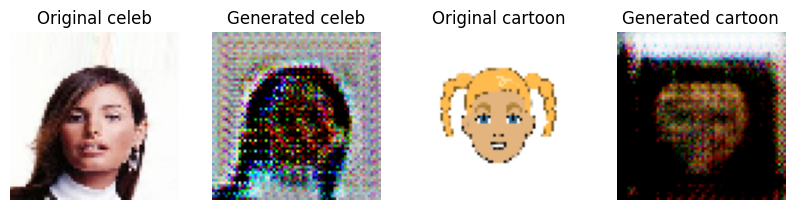

1/1 [==============================] - 0s 20ms/step


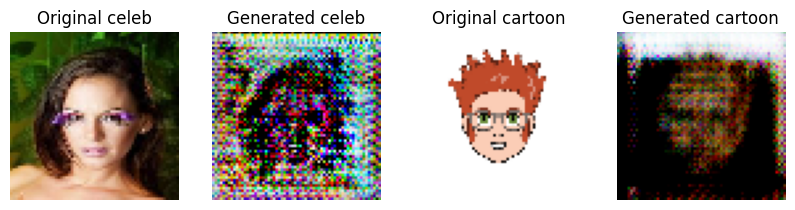

1/1 [==============================] - 0s 20ms/step


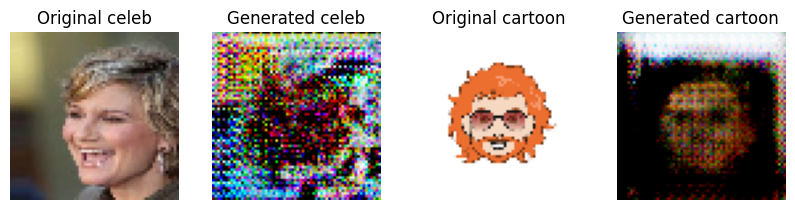

1/1 [==============================] - 0s 19ms/step


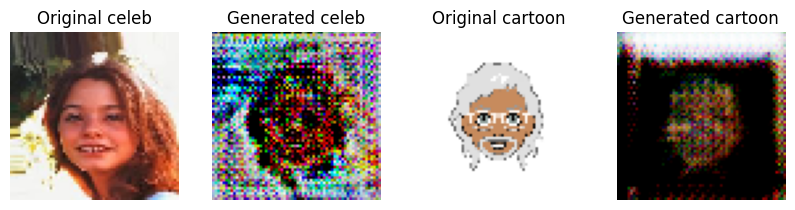

1/1 [==============================] - 0s 20ms/step


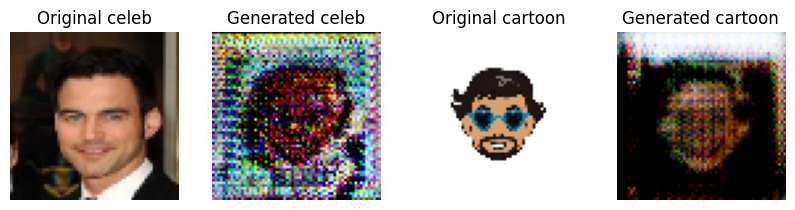

In [41]:
show_preds(CelebtoCartoon_gen,CartoontoCeleb_gen ,n_images=5)